In [1]:
from __future__ import division
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Input, Lambda, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import keras.backend as K
from collections import deque
import h5py
import os
import gym
import cv2
import matplotlib.pyplot as plt
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import BinarySpaceToDiscreteSpaceEnv

Using TensorFlow backend.


In [2]:
EPISODES = 100


#Creating the agent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.8
        self.epsilon_decay = 0.999
        self.learning_rate = 0.09
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

        #Defining a loss function       
    def _huber_loss(self, target, prediction):
        # sqrt(1+error^2)-1
        error = prediction - target
        return K.mean(K.sqrt(1+K.square(error))-1, axis=-1)

    # The Architecture
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(72, activation='relu'))
        model.add(Dense(96, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] += reward
            else:
                # a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] += reward + self.gamma * np.amax(t)
                #target[0][action] = reward + self.gamma * t[np.argmax(t)]
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [3]:
if __name__ == "__main__":
    env = gym.make("SuperMarioBros-v2")
    env = BinarySpaceToDiscreteSpaceEnv(env, SIMPLE_MOVEMENT)
    state_size = env.observation_space.shape[1]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    train_summary = {'episode': [], 'time_step': [], 'epsilon': [], 'rewards': []}
    # agent.load("./save/cartpole-ddqn.h5")
    done = False
    batch_size = 32

    for e in range(EPISODES):
        state = env.reset()
        state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
        #state = np.reshape(state, [1, state_size])
        for time in range(500):
            #env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = cv2.cvtColor(next_state, cv2.COLOR_BGR2GRAY)
            reward += reward if not done else state == env.reset()
            #next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.update_target_model()
            print("episode: {}/{}, time: {}, epsilon: {:.2}, rewards: {}".format(e, EPISODES, time, agent.epsilon, reward))
            train_summary['episode'].append(e)
            train_summary['time_step'].append(time)
            train_summary['epsilon'].append(agent.epsilon)
            train_summary['rewards'].append(reward)
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

/usr/local/lib/python3.5/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


episode: 0/100, time: 0, epsilon: 1.0, rewards: 0
episode: 0/100, time: 1, epsilon: 1.0, rewards: 4
episode: 0/100, time: 2, epsilon: 1.0, rewards: 4
episode: 0/100, time: 3, epsilon: 1.0, rewards: 4
episode: 0/100, time: 4, epsilon: 1.0, rewards: 0
episode: 0/100, time: 5, epsilon: 1.0, rewards: 4
episode: 0/100, time: 6, epsilon: 1.0, rewards: 2
episode: 0/100, time: 7, epsilon: 1.0, rewards: -2
episode: 0/100, time: 8, epsilon: 1.0, rewards: 0
episode: 0/100, time: 9, epsilon: 1.0, rewards: -2
episode: 0/100, time: 10, epsilon: 1.0, rewards: 2
episode: 0/100, time: 11, epsilon: 1.0, rewards: 4
episode: 0/100, time: 12, epsilon: 1.0, rewards: 10
episode: 0/100, time: 13, epsilon: 1.0, rewards: 12
episode: 0/100, time: 14, epsilon: 1.0, rewards: 16
episode: 0/100, time: 15, epsilon: 1.0, rewards: 18
episode: 0/100, time: 16, epsilon: 1.0, rewards: 16
episode: 0/100, time: 17, epsilon: 1.0, rewards: 14
episode: 0/100, time: 18, epsilon: 1.0, rewards: 14
episode: 0/100, time: 19, epsilo

episode: 0/100, time: 156, epsilon: 0.88, rewards: 0
episode: 0/100, time: 157, epsilon: 0.88, rewards: 0
episode: 0/100, time: 158, epsilon: 0.88, rewards: 2
episode: 0/100, time: 159, epsilon: 0.88, rewards: 0
episode: 0/100, time: 160, epsilon: 0.88, rewards: 0
episode: 0/100, time: 161, epsilon: 0.88, rewards: 0
episode: 0/100, time: 162, epsilon: 0.88, rewards: 0
episode: 0/100, time: 163, epsilon: 0.88, rewards: -2
episode: 0/100, time: 164, epsilon: 0.88, rewards: -4
episode: 0/100, time: 165, epsilon: 0.88, rewards: 0
episode: 0/100, time: 166, epsilon: 0.87, rewards: 4
episode: 0/100, time: 167, epsilon: 0.87, rewards: 0
episode: 0/100, time: 168, epsilon: 0.87, rewards: -2
episode: 0/100, time: 169, epsilon: 0.87, rewards: -6
episode: 0/100, time: 170, epsilon: 0.87, rewards: -2
episode: 0/100, time: 171, epsilon: 0.87, rewards: 0
episode: 0/100, time: 172, epsilon: 0.87, rewards: 2
episode: 0/100, time: 173, epsilon: 0.87, rewards: 0
episode: 0/100, time: 174, epsilon: 0.87,

episode: 0/100, time: 311, epsilon: 0.8, rewards: 14
episode: 0/100, time: 312, epsilon: 0.8, rewards: 12
episode: 0/100, time: 313, epsilon: 0.8, rewards: 10
episode: 0/100, time: 314, epsilon: 0.8, rewards: 6
episode: 0/100, time: 315, epsilon: 0.8, rewards: 6
episode: 0/100, time: 316, epsilon: 0.8, rewards: 6
episode: 0/100, time: 317, epsilon: 0.8, rewards: 2
episode: 0/100, time: 318, epsilon: 0.8, rewards: 2
episode: 0/100, time: 319, epsilon: 0.8, rewards: 0
episode: 0/100, time: 320, epsilon: 0.8, rewards: 2
episode: 0/100, time: 321, epsilon: 0.8, rewards: 2
episode: 0/100, time: 322, epsilon: 0.8, rewards: 4
episode: 0/100, time: 323, epsilon: 0.8, rewards: 0
episode: 0/100, time: 324, epsilon: 0.8, rewards: -2
episode: 0/100, time: 325, epsilon: 0.8, rewards: 0
episode: 0/100, time: 326, epsilon: 0.8, rewards: 0
episode: 0/100, time: 327, epsilon: 0.8, rewards: 0
episode: 0/100, time: 328, epsilon: 0.8, rewards: 2
episode: 0/100, time: 329, epsilon: 0.8, rewards: 2
episode:

episode: 0/100, time: 468, epsilon: 0.8, rewards: 2
episode: 0/100, time: 469, epsilon: 0.8, rewards: 4
episode: 0/100, time: 470, epsilon: 0.8, rewards: 6
episode: 0/100, time: 471, epsilon: 0.8, rewards: 4
episode: 0/100, time: 472, epsilon: 0.8, rewards: 0
episode: 0/100, time: 473, epsilon: 0.8, rewards: 0
episode: 0/100, time: 474, epsilon: 0.8, rewards: 0
episode: 0/100, time: 475, epsilon: 0.8, rewards: 4
episode: 0/100, time: 476, epsilon: 0.8, rewards: 4
episode: 0/100, time: 477, epsilon: 0.8, rewards: 6
episode: 0/100, time: 478, epsilon: 0.8, rewards: 12
episode: 0/100, time: 479, epsilon: 0.8, rewards: 14
episode: 0/100, time: 480, epsilon: 0.8, rewards: 12
episode: 0/100, time: 481, epsilon: 0.8, rewards: 10
episode: 0/100, time: 482, epsilon: 0.8, rewards: 14
episode: 0/100, time: 483, epsilon: 0.8, rewards: 14
episode: 0/100, time: 484, epsilon: 0.8, rewards: 14
episode: 0/100, time: 485, epsilon: 0.8, rewards: 16
episode: 0/100, time: 486, epsilon: 0.8, rewards: 10
epi

episode: 1/100, time: 126, epsilon: 0.8, rewards: 14
episode: 1/100, time: 127, epsilon: 0.8, rewards: 12
episode: 1/100, time: 128, epsilon: 0.8, rewards: 12
episode: 1/100, time: 129, epsilon: 0.8, rewards: 12
episode: 1/100, time: 130, epsilon: 0.8, rewards: 14
episode: 1/100, time: 131, epsilon: 0.8, rewards: 12
episode: 1/100, time: 132, epsilon: 0.8, rewards: 12
episode: 1/100, time: 133, epsilon: 0.8, rewards: 12
episode: 1/100, time: 134, epsilon: 0.8, rewards: 8
episode: 1/100, time: 135, epsilon: 0.8, rewards: -30
episode: 1/100, time: 136, epsilon: 0.8, rewards: 0
episode: 1/100, time: 137, epsilon: 0.8, rewards: -2
episode: 1/100, time: 138, epsilon: 0.8, rewards: -4
episode: 1/100, time: 139, epsilon: 0.8, rewards: -2
episode: 1/100, time: 140, epsilon: 0.8, rewards: -4
episode: 1/100, time: 141, epsilon: 0.8, rewards: -4
episode: 1/100, time: 142, epsilon: 0.8, rewards: -2
episode: 1/100, time: 143, epsilon: 0.8, rewards: -2
episode: 1/100, time: 144, epsilon: 0.8, reward

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


episode: 1/100, time: 275, epsilon: 0.8, rewards: -15
episode: 1/100, time: 276, epsilon: 0.8, rewards: 0
episode: 1/100, time: 277, epsilon: 0.8, rewards: 2
episode: 1/100, time: 278, epsilon: 0.8, rewards: 0
episode: 1/100, time: 279, epsilon: 0.8, rewards: 0
episode: 1/100, time: 280, epsilon: 0.8, rewards: -4
episode: 1/100, time: 281, epsilon: 0.8, rewards: 0
episode: 1/100, time: 282, epsilon: 0.8, rewards: 2
episode: 1/100, time: 283, epsilon: 0.8, rewards: 2
episode: 1/100, time: 284, epsilon: 0.8, rewards: 4
episode: 1/100, time: 285, epsilon: 0.8, rewards: 6
episode: 1/100, time: 286, epsilon: 0.8, rewards: 8
episode: 1/100, time: 287, epsilon: 0.8, rewards: 12
episode: 1/100, time: 288, epsilon: 0.8, rewards: 14
episode: 1/100, time: 289, epsilon: 0.8, rewards: 18
episode: 1/100, time: 290, epsilon: 0.8, rewards: 18
episode: 1/100, time: 291, epsilon: 0.8, rewards: 20
episode: 1/100, time: 292, epsilon: 0.8, rewards: 24
episode: 1/100, time: 293, epsilon: 0.8, rewards: 24
ep

episode: 1/100, time: 431, epsilon: 0.8, rewards: 4
episode: 1/100, time: 432, epsilon: 0.8, rewards: 4
episode: 1/100, time: 433, epsilon: 0.8, rewards: 4
episode: 1/100, time: 434, epsilon: 0.8, rewards: 8
episode: 1/100, time: 435, epsilon: 0.8, rewards: 6
episode: 1/100, time: 436, epsilon: 0.8, rewards: 8
episode: 1/100, time: 437, epsilon: 0.8, rewards: 6
episode: 1/100, time: 438, epsilon: 0.8, rewards: 6
episode: 1/100, time: 439, epsilon: 0.8, rewards: 6
episode: 1/100, time: 440, epsilon: 0.8, rewards: 4
episode: 1/100, time: 441, epsilon: 0.8, rewards: 6
episode: 1/100, time: 442, epsilon: 0.8, rewards: 6
episode: 1/100, time: 443, epsilon: 0.8, rewards: 4
episode: 1/100, time: 444, epsilon: 0.8, rewards: 6
episode: 1/100, time: 445, epsilon: 0.8, rewards: 4
episode: 1/100, time: 446, epsilon: 0.8, rewards: 6
episode: 1/100, time: 447, epsilon: 0.8, rewards: 6
episode: 1/100, time: 448, epsilon: 0.8, rewards: 6
episode: 1/100, time: 449, epsilon: 0.8, rewards: 8
episode: 1/1

episode: 2/100, time: 90, epsilon: 0.8, rewards: 12
episode: 2/100, time: 91, epsilon: 0.8, rewards: 2
episode: 2/100, time: 92, epsilon: 0.8, rewards: -2
episode: 2/100, time: 93, epsilon: 0.8, rewards: 0
episode: 2/100, time: 94, epsilon: 0.8, rewards: 0
episode: 2/100, time: 95, epsilon: 0.8, rewards: 0
episode: 2/100, time: 96, epsilon: 0.8, rewards: 0
episode: 2/100, time: 97, epsilon: 0.8, rewards: 0
episode: 2/100, time: 98, epsilon: 0.8, rewards: 0
episode: 2/100, time: 99, epsilon: 0.8, rewards: -2
episode: 2/100, time: 100, epsilon: 0.8, rewards: 0
episode: 2/100, time: 101, epsilon: 0.8, rewards: 0
episode: 2/100, time: 102, epsilon: 0.8, rewards: 0
episode: 2/100, time: 103, epsilon: 0.8, rewards: 0
episode: 2/100, time: 104, epsilon: 0.8, rewards: -2
episode: 2/100, time: 105, epsilon: 0.8, rewards: 0
episode: 2/100, time: 106, epsilon: 0.8, rewards: 0
episode: 2/100, time: 107, epsilon: 0.8, rewards: 0
episode: 2/100, time: 108, epsilon: 0.8, rewards: 0
episode: 2/100, ti

episode: 2/100, time: 247, epsilon: 0.8, rewards: 0
episode: 2/100, time: 248, epsilon: 0.8, rewards: 0
episode: 2/100, time: 249, epsilon: 0.8, rewards: -2
episode: 2/100, time: 250, epsilon: 0.8, rewards: 0
episode: 2/100, time: 251, epsilon: 0.8, rewards: 0
episode: 2/100, time: 252, epsilon: 0.8, rewards: 0
episode: 2/100, time: 253, epsilon: 0.8, rewards: 0
episode: 2/100, time: 254, epsilon: 0.8, rewards: -2
episode: 2/100, time: 255, epsilon: 0.8, rewards: -2
episode: 2/100, time: 256, epsilon: 0.8, rewards: -4
episode: 2/100, time: 257, epsilon: 0.8, rewards: -2
episode: 2/100, time: 258, epsilon: 0.8, rewards: 2
episode: 2/100, time: 259, epsilon: 0.8, rewards: -2
episode: 2/100, time: 260, epsilon: 0.8, rewards: 4
episode: 2/100, time: 261, epsilon: 0.8, rewards: 0
episode: 2/100, time: 262, epsilon: 0.8, rewards: -4
episode: 2/100, time: 263, epsilon: 0.8, rewards: -6
episode: 2/100, time: 264, epsilon: 0.8, rewards: -6
episode: 2/100, time: 265, epsilon: 0.8, rewards: -2
ep

episode: 2/100, time: 404, epsilon: 0.8, rewards: -2
episode: 2/100, time: 405, epsilon: 0.8, rewards: 0
episode: 2/100, time: 406, epsilon: 0.8, rewards: 0
episode: 2/100, time: 407, epsilon: 0.8, rewards: 0
episode: 2/100, time: 408, epsilon: 0.8, rewards: 0
episode: 2/100, time: 409, epsilon: 0.8, rewards: -2
episode: 2/100, time: 410, epsilon: 0.8, rewards: 0
episode: 2/100, time: 411, epsilon: 0.8, rewards: 0
episode: 2/100, time: 412, epsilon: 0.8, rewards: 0
episode: 2/100, time: 413, epsilon: 0.8, rewards: 0
episode: 2/100, time: 414, epsilon: 0.8, rewards: -2
episode: 2/100, time: 415, epsilon: 0.8, rewards: -2
episode: 2/100, time: 416, epsilon: 0.8, rewards: -2
episode: 2/100, time: 417, epsilon: 0.8, rewards: 0
episode: 2/100, time: 418, epsilon: 0.8, rewards: 0
episode: 2/100, time: 419, epsilon: 0.8, rewards: -2
episode: 2/100, time: 420, epsilon: 0.8, rewards: 2
episode: 2/100, time: 421, epsilon: 0.8, rewards: 2
episode: 2/100, time: 422, epsilon: 0.8, rewards: 0
episod

episode: 3/100, time: 62, epsilon: 0.8, rewards: 14
episode: 3/100, time: 63, epsilon: 0.8, rewards: -30
episode: 3/100, time: 64, epsilon: 0.8, rewards: 0
episode: 3/100, time: 65, epsilon: 0.8, rewards: 2
episode: 3/100, time: 66, epsilon: 0.8, rewards: 2
episode: 3/100, time: 67, epsilon: 0.8, rewards: 0
episode: 3/100, time: 68, epsilon: 0.8, rewards: -6
episode: 3/100, time: 69, epsilon: 0.8, rewards: -6
episode: 3/100, time: 70, epsilon: 0.8, rewards: -6
episode: 3/100, time: 71, epsilon: 0.8, rewards: -4
episode: 3/100, time: 72, epsilon: 0.8, rewards: 2
episode: 3/100, time: 73, epsilon: 0.8, rewards: 0
episode: 3/100, time: 74, epsilon: 0.8, rewards: 6
episode: 3/100, time: 75, epsilon: 0.8, rewards: 6
episode: 3/100, time: 76, epsilon: 0.8, rewards: 6
episode: 3/100, time: 77, epsilon: 0.8, rewards: 8
episode: 3/100, time: 78, epsilon: 0.8, rewards: 6
episode: 3/100, time: 79, epsilon: 0.8, rewards: 12
episode: 3/100, time: 80, epsilon: 0.8, rewards: 14
episode: 3/100, time: 

episode: 3/100, time: 219, epsilon: 0.8, rewards: 0
episode: 3/100, time: 220, epsilon: 0.8, rewards: 0
episode: 3/100, time: 221, epsilon: 0.8, rewards: 0
episode: 3/100, time: 222, epsilon: 0.8, rewards: 0
episode: 3/100, time: 223, epsilon: 0.8, rewards: -4
episode: 3/100, time: 224, epsilon: 0.8, rewards: 0
episode: 3/100, time: 225, epsilon: 0.8, rewards: 2
episode: 3/100, time: 226, epsilon: 0.8, rewards: 0
episode: 3/100, time: 227, epsilon: 0.8, rewards: 0
episode: 3/100, time: 228, epsilon: 0.8, rewards: -2
episode: 3/100, time: 229, epsilon: 0.8, rewards: 0
episode: 3/100, time: 230, epsilon: 0.8, rewards: 0
episode: 3/100, time: 231, epsilon: 0.8, rewards: 0
episode: 3/100, time: 232, epsilon: 0.8, rewards: 0
episode: 3/100, time: 233, epsilon: 0.8, rewards: -2
episode: 3/100, time: 234, epsilon: 0.8, rewards: 0
episode: 3/100, time: 235, epsilon: 0.8, rewards: 0
episode: 3/100, time: 236, epsilon: 0.8, rewards: 0
episode: 3/100, time: 237, epsilon: 0.8, rewards: 0
episode: 

episode: 3/100, time: 376, epsilon: 0.8, rewards: 12
episode: 3/100, time: 377, epsilon: 0.8, rewards: 14
episode: 3/100, time: 378, epsilon: 0.8, rewards: 12
episode: 3/100, time: 379, epsilon: 0.8, rewards: 14
episode: 3/100, time: 380, epsilon: 0.8, rewards: 12
episode: 3/100, time: 381, epsilon: 0.8, rewards: 14
episode: 3/100, time: 382, epsilon: 0.8, rewards: 16
episode: 3/100, time: 383, epsilon: 0.8, rewards: 12
episode: 3/100, time: 384, epsilon: 0.8, rewards: 16
episode: 3/100, time: 385, epsilon: 0.8, rewards: 12
episode: 3/100, time: 386, epsilon: 0.8, rewards: 14
episode: 3/100, time: 387, epsilon: 0.8, rewards: 14
episode: 3/100, time: 388, epsilon: 0.8, rewards: 12
episode: 3/100, time: 389, epsilon: 0.8, rewards: 0
episode: 3/100, time: 390, epsilon: 0.8, rewards: 0
episode: 3/100, time: 391, epsilon: 0.8, rewards: 0
episode: 3/100, time: 392, epsilon: 0.8, rewards: 0
episode: 3/100, time: 393, epsilon: 0.8, rewards: -2
episode: 3/100, time: 394, epsilon: 0.8, rewards: 

episode: 4/100, time: 33, epsilon: 0.8, rewards: -4
episode: 4/100, time: 34, epsilon: 0.8, rewards: -4
episode: 4/100, time: 35, epsilon: 0.8, rewards: -2
episode: 4/100, time: 36, epsilon: 0.8, rewards: 0
episode: 4/100, time: 37, epsilon: 0.8, rewards: -2
episode: 4/100, time: 38, epsilon: 0.8, rewards: 2
episode: 4/100, time: 39, epsilon: 0.8, rewards: 2
episode: 4/100, time: 40, epsilon: 0.8, rewards: 6
episode: 4/100, time: 41, epsilon: 0.8, rewards: 6
episode: 4/100, time: 42, epsilon: 0.8, rewards: 4
episode: 4/100, time: 43, epsilon: 0.8, rewards: 0
episode: 4/100, time: 44, epsilon: 0.8, rewards: -2
episode: 4/100, time: 45, epsilon: 0.8, rewards: 2
episode: 4/100, time: 46, epsilon: 0.8, rewards: 4
episode: 4/100, time: 47, epsilon: 0.8, rewards: 4
episode: 4/100, time: 48, epsilon: 0.8, rewards: 8
episode: 4/100, time: 49, epsilon: 0.8, rewards: 6
episode: 4/100, time: 50, epsilon: 0.8, rewards: 10
episode: 4/100, time: 51, epsilon: 0.8, rewards: -30
episode: 4/100, time: 5

episode: 4/100, time: 190, epsilon: 0.8, rewards: 2
episode: 4/100, time: 191, epsilon: 0.8, rewards: 2
episode: 4/100, time: 192, epsilon: 0.8, rewards: 4
episode: 4/100, time: 193, epsilon: 0.8, rewards: 4
episode: 4/100, time: 194, epsilon: 0.8, rewards: 8
episode: 4/100, time: 195, epsilon: 0.8, rewards: 0
episode: 4/100, time: 196, epsilon: 0.8, rewards: -2
episode: 4/100, time: 197, epsilon: 0.8, rewards: 0
episode: 4/100, time: 198, epsilon: 0.8, rewards: 0
episode: 4/100, time: 199, epsilon: 0.8, rewards: 0
episode: 4/100, time: 200, epsilon: 0.8, rewards: 0
episode: 4/100, time: 201, epsilon: 0.8, rewards: -2
episode: 4/100, time: 202, epsilon: 0.8, rewards: 0
episode: 4/100, time: 203, epsilon: 0.8, rewards: 0
episode: 4/100, time: 204, epsilon: 0.8, rewards: 0
episode: 4/100, time: 205, epsilon: 0.8, rewards: 0
episode: 4/100, time: 206, epsilon: 0.8, rewards: -2
episode: 4/100, time: 207, epsilon: 0.8, rewards: 0
episode: 4/100, time: 208, epsilon: 0.8, rewards: 0
episode: 

episode: 4/100, time: 347, epsilon: 0.8, rewards: -4
episode: 4/100, time: 348, epsilon: 0.8, rewards: 0
episode: 4/100, time: 349, epsilon: 0.8, rewards: 0
episode: 4/100, time: 350, epsilon: 0.8, rewards: 2
episode: 4/100, time: 351, epsilon: 0.8, rewards: 2
episode: 4/100, time: 352, epsilon: 0.8, rewards: 6
episode: 4/100, time: 353, epsilon: 0.8, rewards: 2
episode: 4/100, time: 354, epsilon: 0.8, rewards: 0
episode: 4/100, time: 355, epsilon: 0.8, rewards: 2
episode: 4/100, time: 356, epsilon: 0.8, rewards: 4
episode: 4/100, time: 357, epsilon: 0.8, rewards: 6
episode: 4/100, time: 358, epsilon: 0.8, rewards: 6
episode: 4/100, time: 359, epsilon: 0.8, rewards: 8
episode: 4/100, time: 360, epsilon: 0.8, rewards: 10
episode: 4/100, time: 361, epsilon: 0.8, rewards: 8
episode: 4/100, time: 362, epsilon: 0.8, rewards: 8
episode: 4/100, time: 363, epsilon: 0.8, rewards: 8
episode: 4/100, time: 364, epsilon: 0.8, rewards: 10
episode: 4/100, time: 365, epsilon: 0.8, rewards: 10
episode:

episode: 5/100, time: 3, epsilon: 0.8, rewards: 8
episode: 5/100, time: 4, epsilon: 0.8, rewards: 4
episode: 5/100, time: 5, epsilon: 0.8, rewards: 10
episode: 5/100, time: 6, epsilon: 0.8, rewards: 12
episode: 5/100, time: 7, epsilon: 0.8, rewards: 12
episode: 5/100, time: 8, epsilon: 0.8, rewards: 12
episode: 5/100, time: 9, epsilon: 0.8, rewards: 10
episode: 5/100, time: 10, epsilon: 0.8, rewards: 12
episode: 5/100, time: 11, epsilon: 0.8, rewards: 12
episode: 5/100, time: 12, epsilon: 0.8, rewards: 12
episode: 5/100, time: 13, epsilon: 0.8, rewards: 14
episode: 5/100, time: 14, epsilon: 0.8, rewards: 12
episode: 5/100, time: 15, epsilon: 0.8, rewards: 14
episode: 5/100, time: 16, epsilon: 0.8, rewards: 14
episode: 5/100, time: 17, epsilon: 0.8, rewards: 14
episode: 5/100, time: 18, epsilon: 0.8, rewards: 14
episode: 5/100, time: 19, epsilon: 0.8, rewards: 12
episode: 5/100, time: 20, epsilon: 0.8, rewards: 14
episode: 5/100, time: 21, epsilon: 0.8, rewards: 14
episode: 5/100, time:

episode: 5/100, time: 161, epsilon: 0.8, rewards: 18
episode: 5/100, time: 162, epsilon: 0.8, rewards: 12
episode: 5/100, time: 163, epsilon: 0.8, rewards: 12
episode: 5/100, time: 164, epsilon: 0.8, rewards: 10
episode: 5/100, time: 165, epsilon: 0.8, rewards: 14
episode: 5/100, time: 166, epsilon: 0.8, rewards: 14
episode: 5/100, time: 167, epsilon: 0.8, rewards: 12
episode: 5/100, time: 168, epsilon: 0.8, rewards: 16
episode: 5/100, time: 169, epsilon: 0.8, rewards: 22
episode: 5/100, time: 170, epsilon: 0.8, rewards: 22
episode: 5/100, time: 171, epsilon: 0.8, rewards: 24
episode: 5/100, time: 172, epsilon: 0.8, rewards: 22
episode: 5/100, time: 173, epsilon: 0.8, rewards: 22
episode: 5/100, time: 174, epsilon: 0.8, rewards: 14
episode: 5/100, time: 175, epsilon: 0.8, rewards: 14
episode: 5/100, time: 176, epsilon: 0.8, rewards: 14
episode: 5/100, time: 177, epsilon: 0.8, rewards: 12
episode: 5/100, time: 178, epsilon: 0.8, rewards: 14
episode: 5/100, time: 179, epsilon: 0.8, rewar

episode: 5/100, time: 318, epsilon: 0.8, rewards: 4
episode: 5/100, time: 319, epsilon: 0.8, rewards: 0
episode: 5/100, time: 320, epsilon: 0.8, rewards: 4
episode: 5/100, time: 321, epsilon: 0.8, rewards: 4
episode: 5/100, time: 322, epsilon: 0.8, rewards: 2
episode: 5/100, time: 323, epsilon: 0.8, rewards: 4
episode: 5/100, time: 324, epsilon: 0.8, rewards: 0
episode: 5/100, time: 325, epsilon: 0.8, rewards: 0
episode: 5/100, time: 326, epsilon: 0.8, rewards: 0
episode: 5/100, time: 327, epsilon: 0.8, rewards: -2
episode: 5/100, time: 328, epsilon: 0.8, rewards: 0
episode: 5/100, time: 329, epsilon: 0.8, rewards: 0
episode: 5/100, time: 330, epsilon: 0.8, rewards: 0
episode: 5/100, time: 331, epsilon: 0.8, rewards: 0
episode: 5/100, time: 332, epsilon: 0.8, rewards: -2
episode: 5/100, time: 333, epsilon: 0.8, rewards: 0
episode: 5/100, time: 334, epsilon: 0.8, rewards: 0
episode: 5/100, time: 335, epsilon: 0.8, rewards: 0
episode: 5/100, time: 336, epsilon: 0.8, rewards: -2
episode: 

episode: 5/100, time: 474, epsilon: 0.8, rewards: -4
episode: 5/100, time: 475, epsilon: 0.8, rewards: -2
episode: 5/100, time: 476, epsilon: 0.8, rewards: -2
episode: 5/100, time: 477, epsilon: 0.8, rewards: 2
episode: 5/100, time: 478, epsilon: 0.8, rewards: -2
episode: 5/100, time: 479, epsilon: 0.8, rewards: -2
episode: 5/100, time: 480, epsilon: 0.8, rewards: 0
episode: 5/100, time: 481, epsilon: 0.8, rewards: 4
episode: 5/100, time: 482, epsilon: 0.8, rewards: 6
episode: 5/100, time: 483, epsilon: 0.8, rewards: 4
episode: 5/100, time: 484, epsilon: 0.8, rewards: 6
episode: 5/100, time: 485, epsilon: 0.8, rewards: 10
episode: 5/100, time: 486, epsilon: 0.8, rewards: 12
episode: 5/100, time: 487, epsilon: 0.8, rewards: 14
episode: 5/100, time: 488, epsilon: 0.8, rewards: 12
episode: 5/100, time: 489, epsilon: 0.8, rewards: 14
episode: 5/100, time: 490, epsilon: 0.8, rewards: 14
episode: 5/100, time: 491, epsilon: 0.8, rewards: 14
episode: 5/100, time: 492, epsilon: 0.8, rewards: 14

episode: 6/100, time: 132, epsilon: 0.8, rewards: 10
episode: 6/100, time: 133, epsilon: 0.8, rewards: 10
episode: 6/100, time: 134, epsilon: 0.8, rewards: 12
episode: 6/100, time: 135, epsilon: 0.8, rewards: 2
episode: 6/100, time: 136, epsilon: 0.8, rewards: 0
episode: 6/100, time: 137, epsilon: 0.8, rewards: 4
episode: 6/100, time: 138, epsilon: 0.8, rewards: 8
episode: 6/100, time: 139, epsilon: 0.8, rewards: 8
episode: 6/100, time: 140, epsilon: 0.8, rewards: 10
episode: 6/100, time: 141, epsilon: 0.8, rewards: 8
episode: 6/100, time: 142, epsilon: 0.8, rewards: 10
episode: 6/100, time: 143, epsilon: 0.8, rewards: 14
episode: 6/100, time: 144, epsilon: 0.8, rewards: 12
episode: 6/100, time: 145, epsilon: 0.8, rewards: 12
episode: 6/100, time: 146, epsilon: 0.8, rewards: 10
episode: 6/100, time: 147, epsilon: 0.8, rewards: 14
episode: 6/100, time: 148, epsilon: 0.8, rewards: 12
episode: 6/100, time: 149, epsilon: 0.8, rewards: 12
episode: 6/100, time: 150, epsilon: 0.8, rewards: 14

episode: 6/100, time: 289, epsilon: 0.8, rewards: 2
episode: 6/100, time: 290, epsilon: 0.8, rewards: 4
episode: 6/100, time: 291, epsilon: 0.8, rewards: 2
episode: 6/100, time: 292, epsilon: 0.8, rewards: 6
episode: 6/100, time: 293, epsilon: 0.8, rewards: 6
episode: 6/100, time: 294, epsilon: 0.8, rewards: 6
episode: 6/100, time: 295, epsilon: 0.8, rewards: 6
episode: 6/100, time: 296, epsilon: 0.8, rewards: 6
episode: 6/100, time: 297, epsilon: 0.8, rewards: 8
episode: 6/100, time: 298, epsilon: 0.8, rewards: 10
episode: 6/100, time: 299, epsilon: 0.8, rewards: 10
episode: 6/100, time: 300, epsilon: 0.8, rewards: 12
episode: 6/100, time: 301, epsilon: 0.8, rewards: 10
episode: 6/100, time: 302, epsilon: 0.8, rewards: 12
episode: 6/100, time: 303, epsilon: 0.8, rewards: 14
episode: 6/100, time: 304, epsilon: 0.8, rewards: 14
episode: 6/100, time: 305, epsilon: 0.8, rewards: 14
episode: 6/100, time: 306, epsilon: 0.8, rewards: 16
episode: 6/100, time: 307, epsilon: 0.8, rewards: 18
ep

episode: 6/100, time: 445, epsilon: 0.8, rewards: -4
episode: 6/100, time: 446, epsilon: 0.8, rewards: -6
episode: 6/100, time: 447, epsilon: 0.8, rewards: -4
episode: 6/100, time: 448, epsilon: 0.8, rewards: -2
episode: 6/100, time: 449, epsilon: 0.8, rewards: 0
episode: 6/100, time: 450, epsilon: 0.8, rewards: 2
episode: 6/100, time: 451, epsilon: 0.8, rewards: 4
episode: 6/100, time: 452, epsilon: 0.8, rewards: 6
episode: 6/100, time: 453, epsilon: 0.8, rewards: 8
episode: 6/100, time: 454, epsilon: 0.8, rewards: 8
episode: 6/100, time: 455, epsilon: 0.8, rewards: 8
episode: 6/100, time: 456, epsilon: 0.8, rewards: 6
episode: 6/100, time: 457, epsilon: 0.8, rewards: 12
episode: 6/100, time: 458, epsilon: 0.8, rewards: 12
episode: 6/100, time: 459, epsilon: 0.8, rewards: 12
episode: 6/100, time: 460, epsilon: 0.8, rewards: 12
episode: 6/100, time: 461, epsilon: 0.8, rewards: 8
episode: 6/100, time: 462, epsilon: 0.8, rewards: 12
episode: 6/100, time: 463, epsilon: 0.8, rewards: 16
ep

episode: 7/100, time: 104, epsilon: 0.8, rewards: 6
episode: 7/100, time: 105, epsilon: 0.8, rewards: 6
episode: 7/100, time: 106, epsilon: 0.8, rewards: 4
episode: 7/100, time: 107, epsilon: 0.8, rewards: 8
episode: 7/100, time: 108, epsilon: 0.8, rewards: 10
episode: 7/100, time: 109, epsilon: 0.8, rewards: 8
episode: 7/100, time: 110, epsilon: 0.8, rewards: 10
episode: 7/100, time: 111, epsilon: 0.8, rewards: 12
episode: 7/100, time: 112, epsilon: 0.8, rewards: 14
episode: 7/100, time: 113, epsilon: 0.8, rewards: 14
episode: 7/100, time: 114, epsilon: 0.8, rewards: 12
episode: 7/100, time: 115, epsilon: 0.8, rewards: 14
episode: 7/100, time: 116, epsilon: 0.8, rewards: 14
episode: 7/100, time: 117, epsilon: 0.8, rewards: 12
episode: 7/100, time: 118, epsilon: 0.8, rewards: 12
episode: 7/100, time: 119, epsilon: 0.8, rewards: 6
episode: 7/100, time: 120, epsilon: 0.8, rewards: 8
episode: 7/100, time: 121, epsilon: 0.8, rewards: 10
episode: 7/100, time: 122, epsilon: 0.8, rewards: 8
e

episode: 7/100, time: 261, epsilon: 0.8, rewards: 0
episode: 7/100, time: 262, epsilon: 0.8, rewards: 0
episode: 7/100, time: 263, epsilon: 0.8, rewards: 0
episode: 7/100, time: 264, epsilon: 0.8, rewards: -2
episode: 7/100, time: 265, epsilon: 0.8, rewards: 0
episode: 7/100, time: 266, epsilon: 0.8, rewards: 0
episode: 7/100, time: 267, epsilon: 0.8, rewards: 0
episode: 7/100, time: 268, epsilon: 0.8, rewards: 0
episode: 7/100, time: 269, epsilon: 0.8, rewards: -2
episode: 7/100, time: 270, epsilon: 0.8, rewards: 0
episode: 7/100, time: 271, epsilon: 0.8, rewards: 0
episode: 7/100, time: 272, epsilon: 0.8, rewards: 0
episode: 7/100, time: 273, epsilon: 0.8, rewards: 0
episode: 7/100, time: 274, epsilon: 0.8, rewards: -2
episode: 7/100, time: 275, epsilon: 0.8, rewards: 0
episode: 7/100, time: 276, epsilon: 0.8, rewards: 0
episode: 7/100, time: 277, epsilon: 0.8, rewards: 0
episode: 7/100, time: 278, epsilon: 0.8, rewards: 0
episode: 7/100, time: 279, epsilon: 0.8, rewards: -2
episode:

episode: 7/100, time: 418, epsilon: 0.8, rewards: 0
episode: 7/100, time: 419, epsilon: 0.8, rewards: -4
episode: 7/100, time: 420, epsilon: 0.8, rewards: -2
episode: 7/100, time: 421, epsilon: 0.8, rewards: 2
episode: 7/100, time: 422, epsilon: 0.8, rewards: 2
episode: 7/100, time: 423, epsilon: 0.8, rewards: 0
episode: 7/100, time: 424, epsilon: 0.8, rewards: -2
episode: 7/100, time: 425, epsilon: 0.8, rewards: 0
episode: 7/100, time: 426, epsilon: 0.8, rewards: 0
episode: 7/100, time: 427, epsilon: 0.8, rewards: 0
episode: 7/100, time: 428, epsilon: 0.8, rewards: 0
episode: 7/100, time: 429, epsilon: 0.8, rewards: -2
episode: 7/100, time: 430, epsilon: 0.8, rewards: 0
episode: 7/100, time: 431, epsilon: 0.8, rewards: -2
episode: 7/100, time: 432, epsilon: 0.8, rewards: 2
episode: 7/100, time: 433, epsilon: 0.8, rewards: 0
episode: 7/100, time: 434, epsilon: 0.8, rewards: -2
episode: 7/100, time: 435, epsilon: 0.8, rewards: 0
episode: 7/100, time: 436, epsilon: 0.8, rewards: 0
episod

episode: 8/100, time: 76, epsilon: 0.8, rewards: 10
episode: 8/100, time: 77, epsilon: 0.8, rewards: 14
episode: 8/100, time: 78, epsilon: 0.8, rewards: 12
episode: 8/100, time: 79, epsilon: 0.8, rewards: 12
episode: 8/100, time: 80, epsilon: 0.8, rewards: 14
episode: 8/100, time: 81, epsilon: 0.8, rewards: 14
episode: 8/100, time: 82, epsilon: 0.8, rewards: 14
episode: 8/100, time: 83, epsilon: 0.8, rewards: 14
episode: 8/100, time: 84, epsilon: 0.8, rewards: 14
episode: 8/100, time: 85, epsilon: 0.8, rewards: 18
episode: 8/100, time: 86, epsilon: 0.8, rewards: 18
episode: 8/100, time: 87, epsilon: 0.8, rewards: 22
episode: 8/100, time: 88, epsilon: 0.8, rewards: 24
episode: 8/100, time: 89, epsilon: 0.8, rewards: 18
episode: 8/100, time: 90, epsilon: 0.8, rewards: 20
episode: 8/100, time: 91, epsilon: 0.8, rewards: 20
episode: 8/100, time: 92, epsilon: 0.8, rewards: 24
episode: 8/100, time: 93, epsilon: 0.8, rewards: 2
episode: 8/100, time: 94, epsilon: 0.8, rewards: -2
episode: 8/10

episode: 8/100, time: 233, epsilon: 0.8, rewards: 24
episode: 8/100, time: 234, epsilon: 0.8, rewards: 24
episode: 8/100, time: 235, epsilon: 0.8, rewards: 20
episode: 8/100, time: 236, epsilon: 0.8, rewards: -2
episode: 8/100, time: 237, epsilon: 0.8, rewards: 2
episode: 8/100, time: 238, epsilon: 0.8, rewards: 4
episode: 8/100, time: 239, epsilon: 0.8, rewards: 6
episode: 8/100, time: 240, epsilon: 0.8, rewards: 2
episode: 8/100, time: 241, epsilon: 0.8, rewards: 4
episode: 8/100, time: 242, epsilon: 0.8, rewards: 6
episode: 8/100, time: 243, epsilon: 0.8, rewards: 8
episode: 8/100, time: 244, epsilon: 0.8, rewards: 4
episode: 8/100, time: 245, epsilon: 0.8, rewards: 2
episode: 8/100, time: 246, epsilon: 0.8, rewards: 4
episode: 8/100, time: 247, epsilon: 0.8, rewards: 6
episode: 8/100, time: 248, epsilon: 0.8, rewards: 4
episode: 8/100, time: 249, epsilon: 0.8, rewards: 6
episode: 8/100, time: 250, epsilon: 0.8, rewards: 2
episode: 8/100, time: 251, epsilon: 0.8, rewards: 8
episode:

episode: 8/100, time: 389, epsilon: 0.8, rewards: 0
episode: 8/100, time: 390, epsilon: 0.8, rewards: -2
episode: 8/100, time: 391, epsilon: 0.8, rewards: 0
episode: 8/100, time: 392, epsilon: 0.8, rewards: 0
episode: 8/100, time: 393, epsilon: 0.8, rewards: -4
episode: 8/100, time: 394, epsilon: 0.8, rewards: -4
episode: 8/100, time: 395, epsilon: 0.8, rewards: -6
episode: 8/100, time: 396, epsilon: 0.8, rewards: -2
episode: 8/100, time: 397, epsilon: 0.8, rewards: -6
episode: 8/100, time: 398, epsilon: 0.8, rewards: -4
episode: 8/100, time: 399, epsilon: 0.8, rewards: -2
episode: 8/100, time: 400, epsilon: 0.8, rewards: 0
episode: 8/100, time: 401, epsilon: 0.8, rewards: 2
episode: 8/100, time: 402, epsilon: 0.8, rewards: 4
episode: 8/100, time: 403, epsilon: 0.8, rewards: 6
episode: 8/100, time: 404, epsilon: 0.8, rewards: 6
episode: 8/100, time: 405, epsilon: 0.8, rewards: 4
episode: 8/100, time: 406, epsilon: 0.8, rewards: 8
episode: 8/100, time: 407, epsilon: 0.8, rewards: 8
epis

episode: 9/100, time: 47, epsilon: 0.8, rewards: 22
episode: 9/100, time: 48, epsilon: 0.8, rewards: 24
episode: 9/100, time: 49, epsilon: 0.8, rewards: 22
episode: 9/100, time: 50, epsilon: 0.8, rewards: 24
episode: 9/100, time: 51, epsilon: 0.8, rewards: -30
episode: 9/100, time: 52, epsilon: 0.8, rewards: -2
episode: 9/100, time: 53, epsilon: 0.8, rewards: -4
episode: 9/100, time: 54, epsilon: 0.8, rewards: 0
episode: 9/100, time: 55, epsilon: 0.8, rewards: 4
episode: 9/100, time: 56, epsilon: 0.8, rewards: 0
episode: 9/100, time: 57, epsilon: 0.8, rewards: 4
episode: 9/100, time: 58, epsilon: 0.8, rewards: 4
episode: 9/100, time: 59, epsilon: 0.8, rewards: 6
episode: 9/100, time: 60, epsilon: 0.8, rewards: 6
episode: 9/100, time: 61, epsilon: 0.8, rewards: 4
episode: 9/100, time: 62, epsilon: 0.8, rewards: 8
episode: 9/100, time: 63, epsilon: 0.8, rewards: 12
episode: 9/100, time: 64, epsilon: 0.8, rewards: 14
episode: 9/100, time: 65, epsilon: 0.8, rewards: 14
episode: 9/100, time

episode: 9/100, time: 204, epsilon: 0.8, rewards: 14
episode: 9/100, time: 205, epsilon: 0.8, rewards: 14
episode: 9/100, time: 206, epsilon: 0.8, rewards: 12
episode: 9/100, time: 207, epsilon: 0.8, rewards: 14
episode: 9/100, time: 208, epsilon: 0.8, rewards: 14
episode: 9/100, time: 209, epsilon: 0.8, rewards: 14
episode: 9/100, time: 210, epsilon: 0.8, rewards: 14
episode: 9/100, time: 211, epsilon: 0.8, rewards: 12
episode: 9/100, time: 212, epsilon: 0.8, rewards: 12
episode: 9/100, time: 213, epsilon: 0.8, rewards: 10
episode: 9/100, time: 214, epsilon: 0.8, rewards: 10
episode: 9/100, time: 215, epsilon: 0.8, rewards: 12
episode: 9/100, time: 216, epsilon: 0.8, rewards: 12
episode: 9/100, time: 217, epsilon: 0.8, rewards: 6
episode: 9/100, time: 218, epsilon: 0.8, rewards: 0
episode: 9/100, time: 219, epsilon: 0.8, rewards: 0
episode: 9/100, time: 220, epsilon: 0.8, rewards: 0
episode: 9/100, time: 221, epsilon: 0.8, rewards: -2
episode: 9/100, time: 222, epsilon: 0.8, rewards: 

episode: 9/100, time: 361, epsilon: 0.8, rewards: -4
episode: 9/100, time: 362, epsilon: 0.8, rewards: -4
episode: 9/100, time: 363, epsilon: 0.8, rewards: 0
episode: 9/100, time: 364, epsilon: 0.8, rewards: 4
episode: 9/100, time: 365, epsilon: 0.8, rewards: 4
episode: 9/100, time: 366, epsilon: 0.8, rewards: 4
episode: 9/100, time: 367, epsilon: 0.8, rewards: 4
episode: 9/100, time: 368, epsilon: 0.8, rewards: -2
episode: 9/100, time: 369, epsilon: 0.8, rewards: -2
episode: 9/100, time: 370, epsilon: 0.8, rewards: -2
episode: 9/100, time: 371, epsilon: 0.8, rewards: 0
episode: 9/100, time: 372, epsilon: 0.8, rewards: 0
episode: 9/100, time: 373, epsilon: 0.8, rewards: 2
episode: 9/100, time: 374, epsilon: 0.8, rewards: 2
episode: 9/100, time: 375, epsilon: 0.8, rewards: 0
episode: 9/100, time: 376, epsilon: 0.8, rewards: -2
episode: 9/100, time: 377, epsilon: 0.8, rewards: 0
episode: 9/100, time: 378, epsilon: 0.8, rewards: 0
episode: 9/100, time: 379, epsilon: 0.8, rewards: -2
episo

episode: 10/100, time: 18, epsilon: 0.8, rewards: 12
episode: 10/100, time: 19, epsilon: 0.8, rewards: 6
episode: 10/100, time: 20, epsilon: 0.8, rewards: 10
episode: 10/100, time: 21, epsilon: 0.8, rewards: 10
episode: 10/100, time: 22, epsilon: 0.8, rewards: 8
episode: 10/100, time: 23, epsilon: 0.8, rewards: 8
episode: 10/100, time: 24, epsilon: 0.8, rewards: 8
episode: 10/100, time: 25, epsilon: 0.8, rewards: 6
episode: 10/100, time: 26, epsilon: 0.8, rewards: 8
episode: 10/100, time: 27, epsilon: 0.8, rewards: 8
episode: 10/100, time: 28, epsilon: 0.8, rewards: 10
episode: 10/100, time: 29, epsilon: 0.8, rewards: 10
episode: 10/100, time: 30, epsilon: 0.8, rewards: 10
episode: 10/100, time: 31, epsilon: 0.8, rewards: 14
episode: 10/100, time: 32, epsilon: 0.8, rewards: 12
episode: 10/100, time: 33, epsilon: 0.8, rewards: 14
episode: 10/100, time: 34, epsilon: 0.8, rewards: 12
episode: 10/100, time: 35, epsilon: 0.8, rewards: 14
episode: 10/100, time: 36, epsilon: 0.8, rewards: 14


episode: 10/100, time: 173, epsilon: 0.8, rewards: 14
episode: 10/100, time: 174, epsilon: 0.8, rewards: 12
episode: 10/100, time: 175, epsilon: 0.8, rewards: 14
episode: 10/100, time: 176, epsilon: 0.8, rewards: 14
episode: 10/100, time: 177, epsilon: 0.8, rewards: 12
episode: 10/100, time: 178, epsilon: 0.8, rewards: 12
episode: 10/100, time: 179, epsilon: 0.8, rewards: 10
episode: 10/100, time: 180, epsilon: 0.8, rewards: 12
episode: 10/100, time: 181, epsilon: 0.8, rewards: 10
episode: 10/100, time: 182, epsilon: 0.8, rewards: 14
episode: 10/100, time: 183, epsilon: 0.8, rewards: 14
episode: 10/100, time: 184, epsilon: 0.8, rewards: 4
episode: 10/100, time: 185, epsilon: 0.8, rewards: 0
episode: 10/100, time: 186, epsilon: 0.8, rewards: 0
episode: 10/100, time: 187, epsilon: 0.8, rewards: 0
episode: 10/100, time: 188, epsilon: 0.8, rewards: 0
episode: 10/100, time: 189, epsilon: 0.8, rewards: -2
episode: 10/100, time: 190, epsilon: 0.8, rewards: 0
episode: 10/100, time: 191, epsilo

episode: 10/100, time: 327, epsilon: 0.8, rewards: 0
episode: 10/100, time: 328, epsilon: 0.8, rewards: 0
episode: 10/100, time: 329, epsilon: 0.8, rewards: 0
episode: 10/100, time: 330, epsilon: 0.8, rewards: 6
episode: 10/100, time: 331, epsilon: 0.8, rewards: 8
episode: 10/100, time: 332, epsilon: 0.8, rewards: 12
episode: 10/100, time: 333, epsilon: 0.8, rewards: 10
episode: 10/100, time: 334, epsilon: 0.8, rewards: 10
episode: 10/100, time: 335, epsilon: 0.8, rewards: 10
episode: 10/100, time: 336, epsilon: 0.8, rewards: 10
episode: 10/100, time: 337, epsilon: 0.8, rewards: 12
episode: 10/100, time: 338, epsilon: 0.8, rewards: 14
episode: 10/100, time: 339, epsilon: 0.8, rewards: 12
episode: 10/100, time: 340, epsilon: 0.8, rewards: 14
episode: 10/100, time: 341, epsilon: 0.8, rewards: 14
episode: 10/100, time: 342, epsilon: 0.8, rewards: 12
episode: 10/100, time: 343, epsilon: 0.8, rewards: 14
episode: 10/100, time: 344, epsilon: 0.8, rewards: 12
episode: 10/100, time: 345, epsil

episode: 10/100, time: 480, epsilon: 0.8, rewards: 14
episode: 10/100, time: 481, epsilon: 0.8, rewards: 14
episode: 10/100, time: 482, epsilon: 0.8, rewards: 14
episode: 10/100, time: 483, epsilon: 0.8, rewards: 12
episode: 10/100, time: 484, epsilon: 0.8, rewards: 14
episode: 10/100, time: 485, epsilon: 0.8, rewards: 8
episode: 10/100, time: 486, epsilon: 0.8, rewards: 4
episode: 10/100, time: 487, epsilon: 0.8, rewards: 2
episode: 10/100, time: 488, epsilon: 0.8, rewards: 0
episode: 10/100, time: 489, epsilon: 0.8, rewards: 4
episode: 10/100, time: 490, epsilon: 0.8, rewards: 8
episode: 10/100, time: 491, epsilon: 0.8, rewards: 8
episode: 10/100, time: 492, epsilon: 0.8, rewards: 10
episode: 10/100, time: 493, epsilon: 0.8, rewards: 8
episode: 10/100, time: 494, epsilon: 0.8, rewards: 12
episode: 10/100, time: 495, epsilon: 0.8, rewards: 12
episode: 10/100, time: 496, epsilon: 0.8, rewards: 8
episode: 10/100, time: 497, epsilon: 0.8, rewards: 8
episode: 10/100, time: 498, epsilon: 0

episode: 11/100, time: 136, epsilon: 0.8, rewards: 0
episode: 11/100, time: 137, epsilon: 0.8, rewards: 0
episode: 11/100, time: 138, epsilon: 0.8, rewards: 2
episode: 11/100, time: 139, epsilon: 0.8, rewards: 4
episode: 11/100, time: 140, epsilon: 0.8, rewards: 4
episode: 11/100, time: 141, epsilon: 0.8, rewards: 8
episode: 11/100, time: 142, epsilon: 0.8, rewards: 6
episode: 11/100, time: 143, epsilon: 0.8, rewards: 8
episode: 11/100, time: 144, epsilon: 0.8, rewards: 6
episode: 11/100, time: 145, epsilon: 0.8, rewards: 10
episode: 11/100, time: 146, epsilon: 0.8, rewards: 12
episode: 11/100, time: 147, epsilon: 0.8, rewards: 14
episode: 11/100, time: 148, epsilon: 0.8, rewards: 8
episode: 11/100, time: 149, epsilon: 0.8, rewards: 10
episode: 11/100, time: 150, epsilon: 0.8, rewards: 12
episode: 11/100, time: 151, epsilon: 0.8, rewards: 14
episode: 11/100, time: 152, epsilon: 0.8, rewards: 14
episode: 11/100, time: 153, epsilon: 0.8, rewards: 6
episode: 11/100, time: 154, epsilon: 0.

episode: 11/100, time: 290, epsilon: 0.8, rewards: 0
episode: 11/100, time: 291, epsilon: 0.8, rewards: -4
episode: 11/100, time: 292, epsilon: 0.8, rewards: -4
episode: 11/100, time: 293, epsilon: 0.8, rewards: -8
episode: 11/100, time: 294, epsilon: 0.8, rewards: -6
episode: 11/100, time: 295, epsilon: 0.8, rewards: -6
episode: 11/100, time: 296, epsilon: 0.8, rewards: -6
episode: 11/100, time: 297, epsilon: 0.8, rewards: -8
episode: 11/100, time: 298, epsilon: 0.8, rewards: -8
episode: 11/100, time: 299, epsilon: 0.8, rewards: -4
episode: 11/100, time: 300, epsilon: 0.8, rewards: -2
episode: 11/100, time: 301, epsilon: 0.8, rewards: 0
episode: 11/100, time: 302, epsilon: 0.8, rewards: 0
episode: 11/100, time: 303, epsilon: 0.8, rewards: -4
episode: 11/100, time: 304, epsilon: 0.8, rewards: -2
episode: 11/100, time: 305, epsilon: 0.8, rewards: -2
episode: 11/100, time: 306, epsilon: 0.8, rewards: -2
episode: 11/100, time: 307, epsilon: 0.8, rewards: -4
episode: 11/100, time: 308, eps

episode: 11/100, time: 444, epsilon: 0.8, rewards: 6
episode: 11/100, time: 445, epsilon: 0.8, rewards: 10
episode: 11/100, time: 446, epsilon: 0.8, rewards: 14
episode: 11/100, time: 447, epsilon: 0.8, rewards: 2
episode: 11/100, time: 448, epsilon: 0.8, rewards: -2
episode: 11/100, time: 449, epsilon: 0.8, rewards: 0
episode: 11/100, time: 450, epsilon: 0.8, rewards: 0
episode: 11/100, time: 451, epsilon: 0.8, rewards: 0
episode: 11/100, time: 452, epsilon: 0.8, rewards: 0
episode: 11/100, time: 453, epsilon: 0.8, rewards: -2
episode: 11/100, time: 454, epsilon: 0.8, rewards: 0
episode: 11/100, time: 455, epsilon: 0.8, rewards: 0
episode: 11/100, time: 456, epsilon: 0.8, rewards: 2
episode: 11/100, time: 457, epsilon: 0.8, rewards: 2
episode: 11/100, time: 458, epsilon: 0.8, rewards: 0
episode: 11/100, time: 459, epsilon: 0.8, rewards: 2
episode: 11/100, time: 460, epsilon: 0.8, rewards: 6
episode: 11/100, time: 461, epsilon: 0.8, rewards: 6
episode: 11/100, time: 462, epsilon: 0.8, 

episode: 12/100, time: 99, epsilon: 0.8, rewards: 0
episode: 12/100, time: 100, epsilon: 0.8, rewards: 2
episode: 12/100, time: 101, epsilon: 0.8, rewards: 0
episode: 12/100, time: 102, epsilon: 0.8, rewards: 0
episode: 12/100, time: 103, epsilon: 0.8, rewards: -2
episode: 12/100, time: 104, epsilon: 0.8, rewards: 0
episode: 12/100, time: 105, epsilon: 0.8, rewards: 2
episode: 12/100, time: 106, epsilon: 0.8, rewards: 4
episode: 12/100, time: 107, epsilon: 0.8, rewards: 6
episode: 12/100, time: 108, epsilon: 0.8, rewards: 6
episode: 12/100, time: 109, epsilon: 0.8, rewards: -2
episode: 12/100, time: 110, epsilon: 0.8, rewards: 0
episode: 12/100, time: 111, epsilon: 0.8, rewards: 0
episode: 12/100, time: 112, epsilon: 0.8, rewards: 0
episode: 12/100, time: 113, epsilon: 0.8, rewards: 0
episode: 12/100, time: 114, epsilon: 0.8, rewards: -2
episode: 12/100, time: 115, epsilon: 0.8, rewards: 0
episode: 12/100, time: 116, epsilon: 0.8, rewards: 0
episode: 12/100, time: 117, epsilon: 0.8, re

episode: 12/100, time: 253, epsilon: 0.8, rewards: 14
episode: 12/100, time: 254, epsilon: 0.8, rewards: 10
episode: 12/100, time: 255, epsilon: 0.8, rewards: 12
episode: 12/100, time: 256, epsilon: 0.8, rewards: 12
episode: 12/100, time: 257, epsilon: 0.8, rewards: 14
episode: 12/100, time: 258, epsilon: 0.8, rewards: 12
episode: 12/100, time: 259, epsilon: 0.8, rewards: 14
episode: 12/100, time: 260, epsilon: 0.8, rewards: 12
episode: 12/100, time: 261, epsilon: 0.8, rewards: 4
episode: 12/100, time: 262, epsilon: 0.8, rewards: 0
episode: 12/100, time: 263, epsilon: 0.8, rewards: 0
episode: 12/100, time: 264, epsilon: 0.8, rewards: 0
episode: 12/100, time: 265, epsilon: 0.8, rewards: 0
episode: 12/100, time: 266, epsilon: 0.8, rewards: -2
episode: 12/100, time: 267, epsilon: 0.8, rewards: 2
episode: 12/100, time: 268, epsilon: 0.8, rewards: 2
episode: 12/100, time: 269, epsilon: 0.8, rewards: 4
episode: 12/100, time: 270, epsilon: 0.8, rewards: 8
episode: 12/100, time: 271, epsilon: 

episode: 12/100, time: 407, epsilon: 0.8, rewards: 2
episode: 12/100, time: 408, epsilon: 0.8, rewards: 0
episode: 12/100, time: 409, epsilon: 0.8, rewards: 2
episode: 12/100, time: 410, epsilon: 0.8, rewards: 4
episode: 12/100, time: 411, epsilon: 0.8, rewards: 2
episode: 12/100, time: 412, epsilon: 0.8, rewards: 4
episode: 12/100, time: 413, epsilon: 0.8, rewards: 4
episode: 12/100, time: 414, epsilon: 0.8, rewards: 6
episode: 12/100, time: 415, epsilon: 0.8, rewards: 4
episode: 12/100, time: 416, epsilon: 0.8, rewards: 4
episode: 12/100, time: 417, epsilon: 0.8, rewards: 4
episode: 12/100, time: 418, epsilon: 0.8, rewards: 0
episode: 12/100, time: 419, epsilon: 0.8, rewards: -2
episode: 12/100, time: 420, epsilon: 0.8, rewards: -2
episode: 12/100, time: 421, epsilon: 0.8, rewards: -4
episode: 12/100, time: 422, epsilon: 0.8, rewards: 0
episode: 12/100, time: 423, epsilon: 0.8, rewards: -2
episode: 12/100, time: 424, epsilon: 0.8, rewards: -2
episode: 12/100, time: 425, epsilon: 0.8,

episode: 13/100, time: 62, epsilon: 0.8, rewards: 10
episode: 13/100, time: 63, epsilon: 0.8, rewards: 10
episode: 13/100, time: 64, epsilon: 0.8, rewards: 8
episode: 13/100, time: 65, epsilon: 0.8, rewards: 12
episode: 13/100, time: 66, epsilon: 0.8, rewards: 12
episode: 13/100, time: 67, epsilon: 0.8, rewards: 12
episode: 13/100, time: 68, epsilon: 0.8, rewards: 4
episode: 13/100, time: 69, epsilon: 0.8, rewards: -2
episode: 13/100, time: 70, epsilon: 0.8, rewards: 0
episode: 13/100, time: 71, epsilon: 0.8, rewards: 0
episode: 13/100, time: 72, epsilon: 0.8, rewards: 0
episode: 13/100, time: 73, epsilon: 0.8, rewards: 2
episode: 13/100, time: 74, epsilon: 0.8, rewards: -4
episode: 13/100, time: 75, epsilon: 0.8, rewards: 0
episode: 13/100, time: 76, epsilon: 0.8, rewards: 0
episode: 13/100, time: 77, epsilon: 0.8, rewards: 0
episode: 13/100, time: 78, epsilon: 0.8, rewards: 2
episode: 13/100, time: 79, epsilon: 0.8, rewards: 0
episode: 13/100, time: 80, epsilon: 0.8, rewards: 0
episo

episode: 13/100, time: 216, epsilon: 0.8, rewards: 8
episode: 13/100, time: 217, epsilon: 0.8, rewards: 8
episode: 13/100, time: 218, epsilon: 0.8, rewards: 8
episode: 13/100, time: 219, epsilon: 0.8, rewards: 6
episode: 13/100, time: 220, epsilon: 0.8, rewards: 8
episode: 13/100, time: 221, epsilon: 0.8, rewards: 8
episode: 13/100, time: 222, epsilon: 0.8, rewards: 4
episode: 13/100, time: 223, epsilon: 0.8, rewards: 0
episode: 13/100, time: 224, epsilon: 0.8, rewards: -6
episode: 13/100, time: 225, epsilon: 0.8, rewards: -30
episode: 13/100, time: 226, epsilon: 0.8, rewards: 0
episode: 13/100, time: 227, epsilon: 0.8, rewards: 4
episode: 13/100, time: 228, epsilon: 0.8, rewards: 4
episode: 13/100, time: 229, epsilon: 0.8, rewards: 2
episode: 13/100, time: 230, epsilon: 0.8, rewards: 4
episode: 13/100, time: 231, epsilon: 0.8, rewards: 6
episode: 13/100, time: 232, epsilon: 0.8, rewards: 6
episode: 13/100, time: 233, epsilon: 0.8, rewards: 10
episode: 13/100, time: 234, epsilon: 0.8, 

episode: 13/100, time: 370, epsilon: 0.8, rewards: -2
episode: 13/100, time: 371, epsilon: 0.8, rewards: 0
episode: 13/100, time: 372, epsilon: 0.8, rewards: -2
episode: 13/100, time: 373, epsilon: 0.8, rewards: -4
episode: 13/100, time: 374, epsilon: 0.8, rewards: -8
episode: 13/100, time: 375, epsilon: 0.8, rewards: -8
episode: 13/100, time: 376, epsilon: 0.8, rewards: -2
episode: 13/100, time: 377, epsilon: 0.8, rewards: 2
episode: 13/100, time: 378, epsilon: 0.8, rewards: 4
episode: 13/100, time: 379, epsilon: 0.8, rewards: 6
episode: 13/100, time: 380, epsilon: 0.8, rewards: 4
episode: 13/100, time: 381, epsilon: 0.8, rewards: 6
episode: 13/100, time: 382, epsilon: 0.8, rewards: 6
episode: 13/100, time: 383, epsilon: 0.8, rewards: 8
episode: 13/100, time: 384, epsilon: 0.8, rewards: 8
episode: 13/100, time: 385, epsilon: 0.8, rewards: 6
episode: 13/100, time: 386, epsilon: 0.8, rewards: 6
episode: 13/100, time: 387, epsilon: 0.8, rewards: 4
episode: 13/100, time: 388, epsilon: 0.8

episode: 14/100, time: 24, epsilon: 0.8, rewards: 14
episode: 14/100, time: 25, epsilon: 0.8, rewards: 20
episode: 14/100, time: 26, epsilon: 0.8, rewards: 24
episode: 14/100, time: 27, epsilon: 0.8, rewards: 24
episode: 14/100, time: 28, epsilon: 0.8, rewards: 24
episode: 14/100, time: 29, epsilon: 0.8, rewards: 22
episode: 14/100, time: 30, epsilon: 0.8, rewards: 24
episode: 14/100, time: 31, epsilon: 0.8, rewards: 20
episode: 14/100, time: 32, epsilon: 0.8, rewards: 18
episode: 14/100, time: 33, epsilon: 0.8, rewards: 18
episode: 14/100, time: 34, epsilon: 0.8, rewards: 16
episode: 14/100, time: 35, epsilon: 0.8, rewards: 16
episode: 14/100, time: 36, epsilon: 0.8, rewards: 18
episode: 14/100, time: 37, epsilon: 0.8, rewards: 10
episode: 14/100, time: 38, epsilon: 0.8, rewards: 6
episode: 14/100, time: 39, epsilon: 0.8, rewards: 8
episode: 14/100, time: 40, epsilon: 0.8, rewards: 10
episode: 14/100, time: 41, epsilon: 0.8, rewards: 6
episode: 14/100, time: 42, epsilon: 0.8, rewards:

episode: 14/100, time: 179, epsilon: 0.8, rewards: 6
episode: 14/100, time: 180, epsilon: 0.8, rewards: 4
episode: 14/100, time: 181, epsilon: 0.8, rewards: 0
episode: 14/100, time: 182, epsilon: 0.8, rewards: 0
episode: 14/100, time: 183, epsilon: 0.8, rewards: 0
episode: 14/100, time: 184, epsilon: 0.8, rewards: -2
episode: 14/100, time: 185, epsilon: 0.8, rewards: 0
episode: 14/100, time: 186, epsilon: 0.8, rewards: 0
episode: 14/100, time: 187, epsilon: 0.8, rewards: -2
episode: 14/100, time: 188, epsilon: 0.8, rewards: -4
episode: 14/100, time: 189, epsilon: 0.8, rewards: -4
episode: 14/100, time: 190, epsilon: 0.8, rewards: -2
episode: 14/100, time: 191, epsilon: 0.8, rewards: 0
episode: 14/100, time: 192, epsilon: 0.8, rewards: 2
episode: 14/100, time: 193, epsilon: 0.8, rewards: 4
episode: 14/100, time: 194, epsilon: 0.8, rewards: 2
episode: 14/100, time: 195, epsilon: 0.8, rewards: 0
episode: 14/100, time: 196, epsilon: 0.8, rewards: 0
episode: 14/100, time: 197, epsilon: 0.8,

episode: 14/100, time: 333, epsilon: 0.8, rewards: 0
episode: 14/100, time: 334, epsilon: 0.8, rewards: -2
episode: 14/100, time: 335, epsilon: 0.8, rewards: 0
episode: 14/100, time: 336, epsilon: 0.8, rewards: 0
episode: 14/100, time: 337, epsilon: 0.8, rewards: 0
episode: 14/100, time: 338, epsilon: 0.8, rewards: 0
episode: 14/100, time: 339, epsilon: 0.8, rewards: -2
episode: 14/100, time: 340, epsilon: 0.8, rewards: 0
episode: 14/100, time: 341, epsilon: 0.8, rewards: 0
episode: 14/100, time: 342, epsilon: 0.8, rewards: 0
episode: 14/100, time: 343, epsilon: 0.8, rewards: 0
episode: 14/100, time: 344, epsilon: 0.8, rewards: -2
episode: 14/100, time: 345, epsilon: 0.8, rewards: 0
episode: 14/100, time: 346, epsilon: 0.8, rewards: 0
episode: 14/100, time: 347, epsilon: 0.8, rewards: 0
episode: 14/100, time: 348, epsilon: 0.8, rewards: 0
episode: 14/100, time: 349, epsilon: 0.8, rewards: -2
episode: 14/100, time: 350, epsilon: 0.8, rewards: 0
episode: 14/100, time: 351, epsilon: 0.8, 

episode: 14/100, time: 487, epsilon: 0.8, rewards: 0
episode: 14/100, time: 488, epsilon: 0.8, rewards: 0
episode: 14/100, time: 489, epsilon: 0.8, rewards: -2
episode: 14/100, time: 490, epsilon: 0.8, rewards: 0
episode: 14/100, time: 491, epsilon: 0.8, rewards: 0
episode: 14/100, time: 492, epsilon: 0.8, rewards: -2
episode: 14/100, time: 493, epsilon: 0.8, rewards: 0
episode: 14/100, time: 494, epsilon: 0.8, rewards: 0
episode: 14/100, time: 495, epsilon: 0.8, rewards: 0
episode: 14/100, time: 496, epsilon: 0.8, rewards: 0
episode: 14/100, time: 497, epsilon: 0.8, rewards: 0
episode: 14/100, time: 498, epsilon: 0.8, rewards: 0
episode: 14/100, time: 499, epsilon: 0.8, rewards: -2
episode: 15/100, time: 0, epsilon: 0.8, rewards: 0
episode: 15/100, time: 1, epsilon: 0.8, rewards: 0
episode: 15/100, time: 2, epsilon: 0.8, rewards: 4
episode: 15/100, time: 3, epsilon: 0.8, rewards: 4
episode: 15/100, time: 4, epsilon: 0.8, rewards: 4
episode: 15/100, time: 5, epsilon: 0.8, rewards: 6
ep

episode: 15/100, time: 143, epsilon: 0.8, rewards: 6
episode: 15/100, time: 144, epsilon: 0.8, rewards: 4
episode: 15/100, time: 145, epsilon: 0.8, rewards: 6
episode: 15/100, time: 146, epsilon: 0.8, rewards: 0
episode: 15/100, time: 147, epsilon: 0.8, rewards: 0
episode: 15/100, time: 148, epsilon: 0.8, rewards: 0
episode: 15/100, time: 149, epsilon: 0.8, rewards: -2
episode: 15/100, time: 150, epsilon: 0.8, rewards: 0
episode: 15/100, time: 151, epsilon: 0.8, rewards: -2
episode: 15/100, time: 152, epsilon: 0.8, rewards: 0
episode: 15/100, time: 153, epsilon: 0.8, rewards: 2
episode: 15/100, time: 154, epsilon: 0.8, rewards: -2
episode: 15/100, time: 155, epsilon: 0.8, rewards: -2
episode: 15/100, time: 156, epsilon: 0.8, rewards: -2
episode: 15/100, time: 157, epsilon: 0.8, rewards: -2
episode: 15/100, time: 158, epsilon: 0.8, rewards: -2
episode: 15/100, time: 159, epsilon: 0.8, rewards: -2
episode: 15/100, time: 160, epsilon: 0.8, rewards: -2
episode: 15/100, time: 161, epsilon: 

episode: 15/100, time: 296, epsilon: 0.8, rewards: 10
episode: 15/100, time: 297, epsilon: 0.8, rewards: 10
episode: 15/100, time: 298, epsilon: 0.8, rewards: 12
episode: 15/100, time: 299, epsilon: 0.8, rewards: 12
episode: 15/100, time: 300, epsilon: 0.8, rewards: 10
episode: 15/100, time: 301, epsilon: 0.8, rewards: 6
episode: 15/100, time: 302, epsilon: 0.8, rewards: -2
episode: 15/100, time: 303, epsilon: 0.8, rewards: 2
episode: 15/100, time: 304, epsilon: 0.8, rewards: 2
episode: 15/100, time: 305, epsilon: 0.8, rewards: -2
episode: 15/100, time: 306, epsilon: 0.8, rewards: 2
episode: 15/100, time: 307, epsilon: 0.8, rewards: -2
episode: 15/100, time: 308, epsilon: 0.8, rewards: 0
episode: 15/100, time: 309, epsilon: 0.8, rewards: -2
episode: 15/100, time: 310, epsilon: 0.8, rewards: -2
episode: 15/100, time: 311, epsilon: 0.8, rewards: -4
episode: 15/100, time: 312, epsilon: 0.8, rewards: -4
episode: 15/100, time: 313, epsilon: 0.8, rewards: 4
episode: 15/100, time: 314, epsilo

episode: 15/100, time: 450, epsilon: 0.8, rewards: 0
episode: 15/100, time: 451, epsilon: 0.8, rewards: 0
episode: 15/100, time: 452, epsilon: 0.8, rewards: -2
episode: 15/100, time: 453, epsilon: 0.8, rewards: 2
episode: 15/100, time: 454, epsilon: 0.8, rewards: -2
episode: 15/100, time: 455, epsilon: 0.8, rewards: 0
episode: 15/100, time: 456, epsilon: 0.8, rewards: 0
episode: 15/100, time: 457, epsilon: 0.8, rewards: -2
episode: 15/100, time: 458, epsilon: 0.8, rewards: 0
episode: 15/100, time: 459, epsilon: 0.8, rewards: 0
episode: 15/100, time: 460, epsilon: 0.8, rewards: 0
episode: 15/100, time: 461, epsilon: 0.8, rewards: 0
episode: 15/100, time: 462, epsilon: 0.8, rewards: -2
episode: 15/100, time: 463, epsilon: 0.8, rewards: -2
episode: 15/100, time: 464, epsilon: 0.8, rewards: -6
episode: 15/100, time: 465, epsilon: 0.8, rewards: -4
episode: 15/100, time: 466, epsilon: 0.8, rewards: 2
episode: 15/100, time: 467, epsilon: 0.8, rewards: 2
episode: 15/100, time: 468, epsilon: 0.

episode: 16/100, time: 106, epsilon: 0.8, rewards: 10
episode: 16/100, time: 107, epsilon: 0.8, rewards: 10
episode: 16/100, time: 108, epsilon: 0.8, rewards: 10
episode: 16/100, time: 109, epsilon: 0.8, rewards: 12
episode: 16/100, time: 110, epsilon: 0.8, rewards: 12
episode: 16/100, time: 111, epsilon: 0.8, rewards: 14
episode: 16/100, time: 112, epsilon: 0.8, rewards: 14
episode: 16/100, time: 113, epsilon: 0.8, rewards: 12
episode: 16/100, time: 114, epsilon: 0.8, rewards: 14
episode: 16/100, time: 115, epsilon: 0.8, rewards: 12
episode: 16/100, time: 116, epsilon: 0.8, rewards: 14
episode: 16/100, time: 117, epsilon: 0.8, rewards: 12
episode: 16/100, time: 118, epsilon: 0.8, rewards: 14
episode: 16/100, time: 119, epsilon: 0.8, rewards: 14
episode: 16/100, time: 120, epsilon: 0.8, rewards: 12
episode: 16/100, time: 121, epsilon: 0.8, rewards: 10
episode: 16/100, time: 122, epsilon: 0.8, rewards: 12
episode: 16/100, time: 123, epsilon: 0.8, rewards: 12
episode: 16/100, time: 124, 

episode: 16/100, time: 259, epsilon: 0.8, rewards: -4
episode: 16/100, time: 260, epsilon: 0.8, rewards: -4
episode: 16/100, time: 261, epsilon: 0.8, rewards: 0
episode: 16/100, time: 262, epsilon: 0.8, rewards: 2
episode: 16/100, time: 263, epsilon: 0.8, rewards: 4
episode: 16/100, time: 264, epsilon: 0.8, rewards: 2
episode: 16/100, time: 265, epsilon: 0.8, rewards: -2
episode: 16/100, time: 266, epsilon: 0.8, rewards: 0
episode: 16/100, time: 267, epsilon: 0.8, rewards: 0
episode: 16/100, time: 268, epsilon: 0.8, rewards: 0
episode: 16/100, time: 269, epsilon: 0.8, rewards: 2
episode: 16/100, time: 270, epsilon: 0.8, rewards: -2
episode: 16/100, time: 271, epsilon: 0.8, rewards: -2
episode: 16/100, time: 272, epsilon: 0.8, rewards: 0
episode: 16/100, time: 273, epsilon: 0.8, rewards: 0
episode: 16/100, time: 274, epsilon: 0.8, rewards: 0
episode: 16/100, time: 275, epsilon: 0.8, rewards: -2
episode: 16/100, time: 276, epsilon: 0.8, rewards: 0
episode: 16/100, time: 277, epsilon: 0.8

episode: 16/100, time: 413, epsilon: 0.8, rewards: 8
episode: 16/100, time: 414, epsilon: 0.8, rewards: 10
episode: 16/100, time: 415, epsilon: 0.8, rewards: 2
episode: 16/100, time: 416, epsilon: 0.8, rewards: 2
episode: 16/100, time: 417, epsilon: 0.8, rewards: 4
episode: 16/100, time: 418, epsilon: 0.8, rewards: 4
episode: 16/100, time: 419, epsilon: 0.8, rewards: 8
episode: 16/100, time: 420, epsilon: 0.8, rewards: 10
episode: 16/100, time: 421, epsilon: 0.8, rewards: 10
episode: 16/100, time: 422, epsilon: 0.8, rewards: 10
episode: 16/100, time: 423, epsilon: 0.8, rewards: 10
episode: 16/100, time: 424, epsilon: 0.8, rewards: 12
episode: 16/100, time: 425, epsilon: 0.8, rewards: 10
episode: 16/100, time: 426, epsilon: 0.8, rewards: 12
episode: 16/100, time: 427, epsilon: 0.8, rewards: 14
episode: 16/100, time: 428, epsilon: 0.8, rewards: 12
episode: 16/100, time: 429, epsilon: 0.8, rewards: 16
episode: 16/100, time: 430, epsilon: 0.8, rewards: 18
episode: 16/100, time: 431, epsilo

episode: 17/100, time: 68, epsilon: 0.8, rewards: 2
episode: 17/100, time: 69, epsilon: 0.8, rewards: 4
episode: 17/100, time: 70, epsilon: 0.8, rewards: 4
episode: 17/100, time: 71, epsilon: 0.8, rewards: 2
episode: 17/100, time: 72, epsilon: 0.8, rewards: 2
episode: 17/100, time: 73, epsilon: 0.8, rewards: 4
episode: 17/100, time: 74, epsilon: 0.8, rewards: 4
episode: 17/100, time: 75, epsilon: 0.8, rewards: 8
episode: 17/100, time: 76, epsilon: 0.8, rewards: 10
episode: 17/100, time: 77, epsilon: 0.8, rewards: 12
episode: 17/100, time: 78, epsilon: 0.8, rewards: 14
episode: 17/100, time: 79, epsilon: 0.8, rewards: 12
episode: 17/100, time: 80, epsilon: 0.8, rewards: 14
episode: 17/100, time: 81, epsilon: 0.8, rewards: 14
episode: 17/100, time: 82, epsilon: 0.8, rewards: 14
episode: 17/100, time: 83, epsilon: 0.8, rewards: 14
episode: 17/100, time: 84, epsilon: 0.8, rewards: 10
episode: 17/100, time: 85, epsilon: 0.8, rewards: 14
episode: 17/100, time: 86, epsilon: 0.8, rewards: 14
e

episode: 17/100, time: 222, epsilon: 0.8, rewards: 6
episode: 17/100, time: 223, epsilon: 0.8, rewards: 6
episode: 17/100, time: 224, epsilon: 0.8, rewards: -4
episode: 17/100, time: 225, epsilon: 0.8, rewards: 0
episode: 17/100, time: 226, epsilon: 0.8, rewards: 0
episode: 17/100, time: 227, epsilon: 0.8, rewards: 0
episode: 17/100, time: 228, epsilon: 0.8, rewards: 2
episode: 17/100, time: 229, epsilon: 0.8, rewards: -2
episode: 17/100, time: 230, epsilon: 0.8, rewards: 0
episode: 17/100, time: 231, epsilon: 0.8, rewards: -2
episode: 17/100, time: 232, epsilon: 0.8, rewards: -2
episode: 17/100, time: 233, epsilon: 0.8, rewards: 0
episode: 17/100, time: 234, epsilon: 0.8, rewards: -2
episode: 17/100, time: 235, epsilon: 0.8, rewards: 4
episode: 17/100, time: 236, epsilon: 0.8, rewards: 0
episode: 17/100, time: 237, epsilon: 0.8, rewards: 0
episode: 17/100, time: 238, epsilon: 0.8, rewards: 0
episode: 17/100, time: 239, epsilon: 0.8, rewards: -2
episode: 17/100, time: 240, epsilon: 0.8

episode: 17/100, time: 376, epsilon: 0.8, rewards: 0
episode: 17/100, time: 377, epsilon: 0.8, rewards: 4
episode: 17/100, time: 378, epsilon: 0.8, rewards: 6
episode: 17/100, time: 379, epsilon: 0.8, rewards: 2
episode: 17/100, time: 380, epsilon: 0.8, rewards: 2
episode: 17/100, time: 381, epsilon: 0.8, rewards: 4
episode: 17/100, time: 382, epsilon: 0.8, rewards: 2
episode: 17/100, time: 383, epsilon: 0.8, rewards: 4
episode: 17/100, time: 384, epsilon: 0.8, rewards: 0
episode: 17/100, time: 385, epsilon: 0.8, rewards: -4
episode: 17/100, time: 386, epsilon: 0.8, rewards: -30
episode: 17/100, time: 387, epsilon: 0.8, rewards: 0
episode: 17/100, time: 388, epsilon: 0.8, rewards: 4
episode: 17/100, time: 389, epsilon: 0.8, rewards: 4
episode: 17/100, time: 390, epsilon: 0.8, rewards: 6
episode: 17/100, time: 391, epsilon: 0.8, rewards: 2
episode: 17/100, time: 392, epsilon: 0.8, rewards: 6
episode: 17/100, time: 393, epsilon: 0.8, rewards: 4
episode: 17/100, time: 394, epsilon: 0.8, r

episode: 18/100, time: 30, epsilon: 0.8, rewards: 12
episode: 18/100, time: 31, epsilon: 0.8, rewards: 12
episode: 18/100, time: 32, epsilon: 0.8, rewards: 12
episode: 18/100, time: 33, epsilon: 0.8, rewards: 12
episode: 18/100, time: 34, epsilon: 0.8, rewards: 12
episode: 18/100, time: 35, epsilon: 0.8, rewards: 12
episode: 18/100, time: 36, epsilon: 0.8, rewards: 14
episode: 18/100, time: 37, epsilon: 0.8, rewards: 14
episode: 18/100, time: 38, epsilon: 0.8, rewards: 14
episode: 18/100, time: 39, epsilon: 0.8, rewards: 12
episode: 18/100, time: 40, epsilon: 0.8, rewards: 14
episode: 18/100, time: 41, epsilon: 0.8, rewards: 14
episode: 18/100, time: 42, epsilon: 0.8, rewards: 14
episode: 18/100, time: 43, epsilon: 0.8, rewards: 14
episode: 18/100, time: 44, epsilon: 0.8, rewards: -30
episode: 18/100, time: 45, epsilon: 0.8, rewards: 0
episode: 18/100, time: 46, epsilon: 0.8, rewards: 4
episode: 18/100, time: 47, epsilon: 0.8, rewards: 4
episode: 18/100, time: 48, epsilon: 0.8, rewards

episode: 18/100, time: 185, epsilon: 0.8, rewards: 12
episode: 18/100, time: 186, epsilon: 0.8, rewards: 14
episode: 18/100, time: 187, epsilon: 0.8, rewards: 14
episode: 18/100, time: 188, epsilon: 0.8, rewards: 14
episode: 18/100, time: 189, epsilon: 0.8, rewards: 10
episode: 18/100, time: 190, epsilon: 0.8, rewards: 12
episode: 18/100, time: 191, epsilon: 0.8, rewards: 14
episode: 18/100, time: 192, epsilon: 0.8, rewards: 14
episode: 18/100, time: 193, epsilon: 0.8, rewards: 14
episode: 18/100, time: 194, epsilon: 0.8, rewards: 12
episode: 18/100, time: 195, epsilon: 0.8, rewards: 14
episode: 18/100, time: 196, epsilon: 0.8, rewards: 14
episode: 18/100, time: 197, epsilon: 0.8, rewards: 10
episode: 18/100, time: 198, epsilon: 0.8, rewards: 12
episode: 18/100, time: 199, epsilon: 0.8, rewards: 4
episode: 18/100, time: 200, epsilon: 0.8, rewards: 0
episode: 18/100, time: 201, epsilon: 0.8, rewards: 0
episode: 18/100, time: 202, epsilon: 0.8, rewards: 0
episode: 18/100, time: 203, epsi

episode: 18/100, time: 339, epsilon: 0.8, rewards: 0
episode: 18/100, time: 340, epsilon: 0.8, rewards: 4
episode: 18/100, time: 341, epsilon: 0.8, rewards: 0
episode: 18/100, time: 342, epsilon: 0.8, rewards: 0
episode: 18/100, time: 343, epsilon: 0.8, rewards: 0
episode: 18/100, time: 344, epsilon: 0.8, rewards: -2
episode: 18/100, time: 345, epsilon: 0.8, rewards: 0
episode: 18/100, time: 346, epsilon: 0.8, rewards: 0
episode: 18/100, time: 347, epsilon: 0.8, rewards: 0
episode: 18/100, time: 348, epsilon: 0.8, rewards: 0
episode: 18/100, time: 349, epsilon: 0.8, rewards: -2
episode: 18/100, time: 350, epsilon: 0.8, rewards: 0
episode: 18/100, time: 351, epsilon: 0.8, rewards: 2
episode: 18/100, time: 352, epsilon: 0.8, rewards: 4
episode: 18/100, time: 353, epsilon: 0.8, rewards: 6
episode: 18/100, time: 354, epsilon: 0.8, rewards: 2
episode: 18/100, time: 355, epsilon: 0.8, rewards: 2
episode: 18/100, time: 356, epsilon: 0.8, rewards: 0
episode: 18/100, time: 357, epsilon: 0.8, re

episode: 18/100, time: 493, epsilon: 0.8, rewards: 12
episode: 18/100, time: 494, epsilon: 0.8, rewards: 14
episode: 18/100, time: 495, epsilon: 0.8, rewards: 14
episode: 18/100, time: 496, epsilon: 0.8, rewards: 14
episode: 18/100, time: 497, epsilon: 0.8, rewards: 12
episode: 18/100, time: 498, epsilon: 0.8, rewards: 10
episode: 18/100, time: 499, epsilon: 0.8, rewards: 10
episode: 19/100, time: 0, epsilon: 0.8, rewards: -2
episode: 19/100, time: 1, epsilon: 0.8, rewards: -2
episode: 19/100, time: 2, epsilon: 0.8, rewards: 0
episode: 19/100, time: 3, epsilon: 0.8, rewards: 4
episode: 19/100, time: 4, epsilon: 0.8, rewards: 6
episode: 19/100, time: 5, epsilon: 0.8, rewards: 12
episode: 19/100, time: 6, epsilon: 0.8, rewards: 12
episode: 19/100, time: 7, epsilon: 0.8, rewards: 16
episode: 19/100, time: 8, epsilon: 0.8, rewards: 16
episode: 19/100, time: 9, epsilon: 0.8, rewards: 14
episode: 19/100, time: 10, epsilon: 0.8, rewards: 14
episode: 19/100, time: 11, epsilon: 0.8, rewards: 16

episode: 19/100, time: 148, epsilon: 0.8, rewards: 10
episode: 19/100, time: 149, epsilon: 0.8, rewards: 8
episode: 19/100, time: 150, epsilon: 0.8, rewards: 0
episode: 19/100, time: 151, epsilon: 0.8, rewards: 2
episode: 19/100, time: 152, epsilon: 0.8, rewards: 6
episode: 19/100, time: 153, epsilon: 0.8, rewards: 10
episode: 19/100, time: 154, epsilon: 0.8, rewards: 14
episode: 19/100, time: 155, epsilon: 0.8, rewards: 16
episode: 19/100, time: 156, epsilon: 0.8, rewards: 18
episode: 19/100, time: 157, epsilon: 0.8, rewards: 14
episode: 19/100, time: 158, epsilon: 0.8, rewards: 4
episode: 19/100, time: 159, epsilon: 0.8, rewards: -2
episode: 19/100, time: 160, epsilon: 0.8, rewards: -2
episode: 19/100, time: 161, epsilon: 0.8, rewards: 0
episode: 19/100, time: 162, epsilon: 0.8, rewards: 0
episode: 19/100, time: 163, epsilon: 0.8, rewards: 0
episode: 19/100, time: 164, epsilon: 0.8, rewards: 0
episode: 19/100, time: 165, epsilon: 0.8, rewards: 2
episode: 19/100, time: 166, epsilon: 0

episode: 19/100, time: 302, epsilon: 0.8, rewards: 10
episode: 19/100, time: 303, epsilon: 0.8, rewards: 8
episode: 19/100, time: 304, epsilon: 0.8, rewards: 0
episode: 19/100, time: 305, epsilon: 0.8, rewards: 2
episode: 19/100, time: 306, epsilon: 0.8, rewards: -2
episode: 19/100, time: 307, epsilon: 0.8, rewards: 2
episode: 19/100, time: 308, epsilon: 0.8, rewards: 2
episode: 19/100, time: 309, epsilon: 0.8, rewards: 2
episode: 19/100, time: 310, epsilon: 0.8, rewards: 2
episode: 19/100, time: 311, epsilon: 0.8, rewards: 6
episode: 19/100, time: 312, epsilon: 0.8, rewards: 8
episode: 19/100, time: 313, epsilon: 0.8, rewards: 6
episode: 19/100, time: 314, epsilon: 0.8, rewards: 12
episode: 19/100, time: 315, epsilon: 0.8, rewards: 12
episode: 19/100, time: 316, epsilon: 0.8, rewards: 12
episode: 19/100, time: 317, epsilon: 0.8, rewards: 14
episode: 19/100, time: 318, epsilon: 0.8, rewards: 14
episode: 19/100, time: 319, epsilon: 0.8, rewards: 14
episode: 19/100, time: 320, epsilon: 0

episode: 19/100, time: 456, epsilon: 0.8, rewards: 2
episode: 19/100, time: 457, epsilon: 0.8, rewards: 0
episode: 19/100, time: 458, epsilon: 0.8, rewards: 2
episode: 19/100, time: 459, epsilon: 0.8, rewards: 4
episode: 19/100, time: 460, epsilon: 0.8, rewards: 4
episode: 19/100, time: 461, epsilon: 0.8, rewards: 2
episode: 19/100, time: 462, epsilon: 0.8, rewards: 0
episode: 19/100, time: 463, epsilon: 0.8, rewards: -4
episode: 19/100, time: 464, epsilon: 0.8, rewards: -2
episode: 19/100, time: 465, epsilon: 0.8, rewards: -4
episode: 19/100, time: 466, epsilon: 0.8, rewards: -6
episode: 19/100, time: 467, epsilon: 0.8, rewards: -4
episode: 19/100, time: 468, epsilon: 0.8, rewards: -4
episode: 19/100, time: 469, epsilon: 0.8, rewards: -6
episode: 19/100, time: 470, epsilon: 0.8, rewards: -4
episode: 19/100, time: 471, epsilon: 0.8, rewards: -4
episode: 19/100, time: 472, epsilon: 0.8, rewards: -2
episode: 19/100, time: 473, epsilon: 0.8, rewards: -4
episode: 19/100, time: 474, epsilon

episode: 20/100, time: 112, epsilon: 0.8, rewards: 8
episode: 20/100, time: 113, epsilon: 0.8, rewards: 6
episode: 20/100, time: 114, epsilon: 0.8, rewards: 4
episode: 20/100, time: 115, epsilon: 0.8, rewards: 4
episode: 20/100, time: 116, epsilon: 0.8, rewards: 0
episode: 20/100, time: 117, epsilon: 0.8, rewards: -2
episode: 20/100, time: 118, epsilon: 0.8, rewards: -2
episode: 20/100, time: 119, epsilon: 0.8, rewards: -2
episode: 20/100, time: 120, epsilon: 0.8, rewards: 2
episode: 20/100, time: 121, epsilon: 0.8, rewards: 4
episode: 20/100, time: 122, epsilon: 0.8, rewards: 8
episode: 20/100, time: 123, epsilon: 0.8, rewards: 6
episode: 20/100, time: 124, epsilon: 0.8, rewards: 4
episode: 20/100, time: 125, epsilon: 0.8, rewards: 6
episode: 20/100, time: 126, epsilon: 0.8, rewards: 6
episode: 20/100, time: 127, epsilon: 0.8, rewards: 4
episode: 20/100, time: 128, epsilon: 0.8, rewards: 4
episode: 20/100, time: 129, epsilon: 0.8, rewards: 4
episode: 20/100, time: 130, epsilon: 0.8, r

episode: 20/100, time: 266, epsilon: 0.8, rewards: 2
episode: 20/100, time: 267, epsilon: 0.8, rewards: -2
episode: 20/100, time: 268, epsilon: 0.8, rewards: -2
episode: 20/100, time: 269, epsilon: 0.8, rewards: -2
episode: 20/100, time: 270, epsilon: 0.8, rewards: 0
episode: 20/100, time: 271, epsilon: 0.8, rewards: 0
episode: 20/100, time: 272, epsilon: 0.8, rewards: 2
episode: 20/100, time: 273, epsilon: 0.8, rewards: 0
episode: 20/100, time: 274, epsilon: 0.8, rewards: 0
episode: 20/100, time: 275, epsilon: 0.8, rewards: -2
episode: 20/100, time: 276, epsilon: 0.8, rewards: 0
episode: 20/100, time: 277, epsilon: 0.8, rewards: 0
episode: 20/100, time: 278, epsilon: 0.8, rewards: 0
episode: 20/100, time: 279, epsilon: 0.8, rewards: -2
episode: 20/100, time: 280, epsilon: 0.8, rewards: -2
episode: 20/100, time: 281, epsilon: 0.8, rewards: -2
episode: 20/100, time: 282, epsilon: 0.8, rewards: 0
episode: 20/100, time: 283, epsilon: 0.8, rewards: 2
episode: 20/100, time: 284, epsilon: 0.

episode: 20/100, time: 419, epsilon: 0.8, rewards: 8
episode: 20/100, time: 420, epsilon: 0.8, rewards: 6
episode: 20/100, time: 421, epsilon: 0.8, rewards: 4
episode: 20/100, time: 422, epsilon: 0.8, rewards: 0
episode: 20/100, time: 423, epsilon: 0.8, rewards: 0
episode: 20/100, time: 424, epsilon: 0.8, rewards: -2
episode: 20/100, time: 425, epsilon: 0.8, rewards: 0
episode: 20/100, time: 426, epsilon: 0.8, rewards: 4
episode: 20/100, time: 427, epsilon: 0.8, rewards: 6
episode: 20/100, time: 428, epsilon: 0.8, rewards: 10
episode: 20/100, time: 429, epsilon: 0.8, rewards: 8
episode: 20/100, time: 430, epsilon: 0.8, rewards: 10
episode: 20/100, time: 431, epsilon: 0.8, rewards: 10
episode: 20/100, time: 432, epsilon: 0.8, rewards: 10
episode: 20/100, time: 433, epsilon: 0.8, rewards: 12
episode: 20/100, time: 434, epsilon: 0.8, rewards: 10
episode: 20/100, time: 435, epsilon: 0.8, rewards: 10
episode: 20/100, time: 436, epsilon: 0.8, rewards: 8
episode: 20/100, time: 437, epsilon: 0

episode: 21/100, time: 74, epsilon: 0.8, rewards: 22
episode: 21/100, time: 75, epsilon: 0.8, rewards: -26
episode: 21/100, time: 76, epsilon: 0.8, rewards: 0
episode: 21/100, time: 77, epsilon: 0.8, rewards: 4
episode: 21/100, time: 78, epsilon: 0.8, rewards: 6
episode: 21/100, time: 79, epsilon: 0.8, rewards: 6
episode: 21/100, time: 80, epsilon: 0.8, rewards: 8
episode: 21/100, time: 81, epsilon: 0.8, rewards: 10
episode: 21/100, time: 82, epsilon: 0.8, rewards: 12
episode: 21/100, time: 83, epsilon: 0.8, rewards: 14
episode: 21/100, time: 84, epsilon: 0.8, rewards: 14
episode: 21/100, time: 85, epsilon: 0.8, rewards: 12
episode: 21/100, time: 86, epsilon: 0.8, rewards: 14
episode: 21/100, time: 87, epsilon: 0.8, rewards: 14
episode: 21/100, time: 88, epsilon: 0.8, rewards: 12
episode: 21/100, time: 89, epsilon: 0.8, rewards: 14
episode: 21/100, time: 90, epsilon: 0.8, rewards: 12
episode: 21/100, time: 91, epsilon: 0.8, rewards: 14
episode: 21/100, time: 92, epsilon: 0.8, rewards: 

episode: 21/100, time: 228, epsilon: 0.8, rewards: 0
episode: 21/100, time: 229, epsilon: 0.8, rewards: 0
episode: 21/100, time: 230, epsilon: 0.8, rewards: -2
episode: 21/100, time: 231, epsilon: 0.8, rewards: -2
episode: 21/100, time: 232, epsilon: 0.8, rewards: -2
episode: 21/100, time: 233, epsilon: 0.8, rewards: -4
episode: 21/100, time: 234, epsilon: 0.8, rewards: -2
episode: 21/100, time: 235, epsilon: 0.8, rewards: -6
episode: 21/100, time: 236, epsilon: 0.8, rewards: -2
episode: 21/100, time: 237, epsilon: 0.8, rewards: 0
episode: 21/100, time: 238, epsilon: 0.8, rewards: -2
episode: 21/100, time: 239, epsilon: 0.8, rewards: 2
episode: 21/100, time: 240, epsilon: 0.8, rewards: 0
episode: 21/100, time: 241, epsilon: 0.8, rewards: 4
episode: 21/100, time: 242, epsilon: 0.8, rewards: 2
episode: 21/100, time: 243, epsilon: 0.8, rewards: 4
episode: 21/100, time: 244, epsilon: 0.8, rewards: 6
episode: 21/100, time: 245, epsilon: 0.8, rewards: 4
episode: 21/100, time: 246, epsilon: 0

episode: 21/100, time: 382, epsilon: 0.8, rewards: -2
episode: 21/100, time: 383, epsilon: 0.8, rewards: 0
episode: 21/100, time: 384, epsilon: 0.8, rewards: 0
episode: 21/100, time: 385, epsilon: 0.8, rewards: 0
episode: 21/100, time: 386, epsilon: 0.8, rewards: -2
episode: 21/100, time: 387, epsilon: 0.8, rewards: -2
episode: 21/100, time: 388, epsilon: 0.8, rewards: -4
episode: 21/100, time: 389, epsilon: 0.8, rewards: 0
episode: 21/100, time: 390, epsilon: 0.8, rewards: -2
episode: 21/100, time: 391, epsilon: 0.8, rewards: 0
episode: 21/100, time: 392, epsilon: 0.8, rewards: 0
episode: 21/100, time: 393, epsilon: 0.8, rewards: 0
episode: 21/100, time: 394, epsilon: 0.8, rewards: 2
episode: 21/100, time: 395, epsilon: 0.8, rewards: 2
episode: 21/100, time: 396, epsilon: 0.8, rewards: 2
episode: 21/100, time: 397, epsilon: 0.8, rewards: 0
episode: 21/100, time: 398, epsilon: 0.8, rewards: 0
episode: 21/100, time: 399, epsilon: 0.8, rewards: 0
episode: 21/100, time: 400, epsilon: 0.8,

episode: 22/100, time: 37, epsilon: 0.8, rewards: 10
episode: 22/100, time: 38, epsilon: 0.8, rewards: 10
episode: 22/100, time: 39, epsilon: 0.8, rewards: 8
episode: 22/100, time: 40, epsilon: 0.8, rewards: 10
episode: 22/100, time: 41, epsilon: 0.8, rewards: 14
episode: 22/100, time: 42, epsilon: 0.8, rewards: 12
episode: 22/100, time: 43, epsilon: 0.8, rewards: 8
episode: 22/100, time: 44, epsilon: 0.8, rewards: 6
episode: 22/100, time: 45, epsilon: 0.8, rewards: 12
episode: 22/100, time: 46, epsilon: 0.8, rewards: 12
episode: 22/100, time: 47, epsilon: 0.8, rewards: -6
episode: 22/100, time: 48, epsilon: 0.8, rewards: 0
episode: 22/100, time: 49, epsilon: 0.8, rewards: -2
episode: 22/100, time: 50, epsilon: 0.8, rewards: 6
episode: 22/100, time: 51, epsilon: 0.8, rewards: 8
episode: 22/100, time: 52, epsilon: 0.8, rewards: 10
episode: 22/100, time: 53, epsilon: 0.8, rewards: 10
episode: 22/100, time: 54, epsilon: 0.8, rewards: 6
episode: 22/100, time: 55, epsilon: 0.8, rewards: 14


episode: 22/100, time: 192, epsilon: 0.8, rewards: -4
episode: 22/100, time: 193, epsilon: 0.8, rewards: -6
episode: 22/100, time: 194, epsilon: 0.8, rewards: -10
episode: 22/100, time: 195, epsilon: 0.8, rewards: -4
episode: 22/100, time: 196, epsilon: 0.8, rewards: -4
episode: 22/100, time: 197, epsilon: 0.8, rewards: -4
episode: 22/100, time: 198, epsilon: 0.8, rewards: -6
episode: 22/100, time: 199, epsilon: 0.8, rewards: -8
episode: 22/100, time: 200, epsilon: 0.8, rewards: -8
episode: 22/100, time: 201, epsilon: 0.8, rewards: -8
episode: 22/100, time: 202, epsilon: 0.8, rewards: -8
episode: 22/100, time: 203, epsilon: 0.8, rewards: -10
episode: 22/100, time: 204, epsilon: 0.8, rewards: -6
episode: 22/100, time: 205, epsilon: 0.8, rewards: -2
episode: 22/100, time: 206, epsilon: 0.8, rewards: -4
episode: 22/100, time: 207, epsilon: 0.8, rewards: 0
episode: 22/100, time: 208, epsilon: 0.8, rewards: 2
episode: 22/100, time: 209, epsilon: 0.8, rewards: 0
episode: 22/100, time: 210, e

episode: 22/100, time: 346, epsilon: 0.8, rewards: 12
episode: 22/100, time: 347, epsilon: 0.8, rewards: 14
episode: 22/100, time: 348, epsilon: 0.8, rewards: 12
episode: 22/100, time: 349, epsilon: 0.8, rewards: 14
episode: 22/100, time: 350, epsilon: 0.8, rewards: 14
episode: 22/100, time: 351, epsilon: 0.8, rewards: 10
episode: 22/100, time: 352, epsilon: 0.8, rewards: 10
episode: 22/100, time: 353, epsilon: 0.8, rewards: 8
episode: 22/100, time: 354, epsilon: 0.8, rewards: 10
episode: 22/100, time: 355, epsilon: 0.8, rewards: 10
episode: 22/100, time: 356, epsilon: 0.8, rewards: 12
episode: 22/100, time: 357, epsilon: 0.8, rewards: 10
episode: 22/100, time: 358, epsilon: 0.8, rewards: 8
episode: 22/100, time: 359, epsilon: 0.8, rewards: 10
episode: 22/100, time: 360, epsilon: 0.8, rewards: 14
episode: 22/100, time: 361, epsilon: 0.8, rewards: 14
episode: 22/100, time: 362, epsilon: 0.8, rewards: 14
episode: 22/100, time: 363, epsilon: 0.8, rewards: 12
episode: 22/100, time: 364, ep

episode: 22/100, time: 499, epsilon: 0.8, rewards: 12
episode: 23/100, time: 0, epsilon: 0.8, rewards: 0
episode: 23/100, time: 1, epsilon: 0.8, rewards: 4
episode: 23/100, time: 2, epsilon: 0.8, rewards: 4
episode: 23/100, time: 3, epsilon: 0.8, rewards: 8
episode: 23/100, time: 4, epsilon: 0.8, rewards: 6
episode: 23/100, time: 5, epsilon: 0.8, rewards: 8
episode: 23/100, time: 6, epsilon: 0.8, rewards: 8
episode: 23/100, time: 7, epsilon: 0.8, rewards: 12
episode: 23/100, time: 8, epsilon: 0.8, rewards: 14
episode: 23/100, time: 9, epsilon: 0.8, rewards: 10
episode: 23/100, time: 10, epsilon: 0.8, rewards: 16
episode: 23/100, time: 11, epsilon: 0.8, rewards: 14
episode: 23/100, time: 12, epsilon: 0.8, rewards: 14
episode: 23/100, time: 13, epsilon: 0.8, rewards: 14
episode: 23/100, time: 14, epsilon: 0.8, rewards: 12
episode: 23/100, time: 15, epsilon: 0.8, rewards: 14
episode: 23/100, time: 16, epsilon: 0.8, rewards: 16
episode: 23/100, time: 17, epsilon: 0.8, rewards: 22
episode: 

episode: 23/100, time: 154, epsilon: 0.8, rewards: 8
episode: 23/100, time: 155, epsilon: 0.8, rewards: 10
episode: 23/100, time: 156, epsilon: 0.8, rewards: 10
episode: 23/100, time: 157, epsilon: 0.8, rewards: 10
episode: 23/100, time: 158, epsilon: 0.8, rewards: 12
episode: 23/100, time: 159, epsilon: 0.8, rewards: 12
episode: 23/100, time: 160, epsilon: 0.8, rewards: 14
episode: 23/100, time: 161, epsilon: 0.8, rewards: 14
episode: 23/100, time: 162, epsilon: 0.8, rewards: 14
episode: 23/100, time: 163, epsilon: 0.8, rewards: 12
episode: 23/100, time: 164, epsilon: 0.8, rewards: 8
episode: 23/100, time: 165, epsilon: 0.8, rewards: 12
episode: 23/100, time: 166, epsilon: 0.8, rewards: 14
episode: 23/100, time: 167, epsilon: 0.8, rewards: 0
episode: 23/100, time: 168, epsilon: 0.8, rewards: -2
episode: 23/100, time: 169, epsilon: 0.8, rewards: -4
episode: 23/100, time: 170, epsilon: 0.8, rewards: -2
episode: 23/100, time: 171, epsilon: 0.8, rewards: -2
episode: 23/100, time: 172, eps

episode: 23/100, time: 308, epsilon: 0.8, rewards: 8
episode: 23/100, time: 309, epsilon: 0.8, rewards: 6
episode: 23/100, time: 310, epsilon: 0.8, rewards: 0
episode: 23/100, time: 311, epsilon: 0.8, rewards: 0
episode: 23/100, time: 312, epsilon: 0.8, rewards: 0
episode: 23/100, time: 313, epsilon: 0.8, rewards: -30
episode: 23/100, time: 314, epsilon: 0.8, rewards: 0
episode: 23/100, time: 315, epsilon: 0.8, rewards: 0
episode: 23/100, time: 316, epsilon: 0.8, rewards: 0
episode: 23/100, time: 317, epsilon: 0.8, rewards: 2
episode: 23/100, time: 318, epsilon: 0.8, rewards: 2
episode: 23/100, time: 319, epsilon: 0.8, rewards: 6
episode: 23/100, time: 320, epsilon: 0.8, rewards: 8
episode: 23/100, time: 321, epsilon: 0.8, rewards: 12
episode: 23/100, time: 322, epsilon: 0.8, rewards: 12
episode: 23/100, time: 323, epsilon: 0.8, rewards: 10
episode: 23/100, time: 324, epsilon: 0.8, rewards: 14
episode: 23/100, time: 325, epsilon: 0.8, rewards: 14
episode: 23/100, time: 326, epsilon: 0.

episode: 23/100, time: 461, epsilon: 0.8, rewards: 0
episode: 23/100, time: 462, epsilon: 0.8, rewards: 0
episode: 23/100, time: 463, epsilon: 0.8, rewards: -2
episode: 23/100, time: 464, epsilon: 0.8, rewards: 2
episode: 23/100, time: 465, epsilon: 0.8, rewards: 4
episode: 23/100, time: 466, epsilon: 0.8, rewards: 4
episode: 23/100, time: 467, epsilon: 0.8, rewards: 8
episode: 23/100, time: 468, epsilon: 0.8, rewards: 6
episode: 23/100, time: 469, epsilon: 0.8, rewards: 6
episode: 23/100, time: 470, epsilon: 0.8, rewards: 6
episode: 23/100, time: 471, epsilon: 0.8, rewards: 6
episode: 23/100, time: 472, epsilon: 0.8, rewards: 4
episode: 23/100, time: 473, epsilon: 0.8, rewards: 0
episode: 23/100, time: 474, epsilon: 0.8, rewards: 4
episode: 23/100, time: 475, epsilon: 0.8, rewards: 0
episode: 23/100, time: 476, epsilon: 0.8, rewards: -2
episode: 23/100, time: 477, epsilon: 0.8, rewards: 0
episode: 23/100, time: 478, epsilon: 0.8, rewards: -2
episode: 23/100, time: 479, epsilon: 0.8, r

episode: 24/100, time: 117, epsilon: 0.8, rewards: -2
episode: 24/100, time: 118, epsilon: 0.8, rewards: -2
episode: 24/100, time: 119, epsilon: 0.8, rewards: -6
episode: 24/100, time: 120, epsilon: 0.8, rewards: 0
episode: 24/100, time: 121, epsilon: 0.8, rewards: 0
episode: 24/100, time: 122, epsilon: 0.8, rewards: 0
episode: 24/100, time: 123, epsilon: 0.8, rewards: -2
episode: 24/100, time: 124, epsilon: 0.8, rewards: -4
episode: 24/100, time: 125, epsilon: 0.8, rewards: 0
episode: 24/100, time: 126, epsilon: 0.8, rewards: 2
episode: 24/100, time: 127, epsilon: 0.8, rewards: 4
episode: 24/100, time: 128, epsilon: 0.8, rewards: 4
episode: 24/100, time: 129, epsilon: 0.8, rewards: 6
episode: 24/100, time: 130, epsilon: 0.8, rewards: 0
episode: 24/100, time: 131, epsilon: 0.8, rewards: 0
episode: 24/100, time: 132, epsilon: 0.8, rewards: 0
episode: 24/100, time: 133, epsilon: 0.8, rewards: 2
episode: 24/100, time: 134, epsilon: 0.8, rewards: 0
episode: 24/100, time: 135, epsilon: 0.8,

episode: 24/100, time: 271, epsilon: 0.8, rewards: 2
episode: 24/100, time: 272, epsilon: 0.8, rewards: 4
episode: 24/100, time: 273, epsilon: 0.8, rewards: 0
episode: 24/100, time: 274, epsilon: 0.8, rewards: 2
episode: 24/100, time: 275, epsilon: 0.8, rewards: 2
episode: 24/100, time: 276, epsilon: 0.8, rewards: 4
episode: 24/100, time: 277, epsilon: 0.8, rewards: 6
episode: 24/100, time: 278, epsilon: 0.8, rewards: 8
episode: 24/100, time: 279, epsilon: 0.8, rewards: 4
episode: 24/100, time: 280, epsilon: 0.8, rewards: 10
episode: 24/100, time: 281, epsilon: 0.8, rewards: 10
episode: 24/100, time: 282, epsilon: 0.8, rewards: 12
episode: 24/100, time: 283, epsilon: 0.8, rewards: 14
episode: 24/100, time: 284, epsilon: 0.8, rewards: 16
episode: 24/100, time: 285, epsilon: 0.8, rewards: 22
episode: 24/100, time: 286, epsilon: 0.8, rewards: 24
episode: 24/100, time: 287, epsilon: 0.8, rewards: 22
episode: 24/100, time: 288, epsilon: 0.8, rewards: 20
episode: 24/100, time: 289, epsilon: 

episode: 24/100, time: 424, epsilon: 0.8, rewards: 22
episode: 24/100, time: 425, epsilon: 0.8, rewards: 22
episode: 24/100, time: 426, epsilon: 0.8, rewards: -30
episode: 24/100, time: 427, epsilon: 0.8, rewards: 0
episode: 24/100, time: 428, epsilon: 0.8, rewards: 4
episode: 24/100, time: 429, epsilon: 0.8, rewards: 4
episode: 24/100, time: 430, epsilon: 0.8, rewards: 4
episode: 24/100, time: 431, epsilon: 0.8, rewards: 2
episode: 24/100, time: 432, epsilon: 0.8, rewards: 2
episode: 24/100, time: 433, epsilon: 0.8, rewards: 2
episode: 24/100, time: 434, epsilon: 0.8, rewards: 4
episode: 24/100, time: 435, epsilon: 0.8, rewards: 2
episode: 24/100, time: 436, epsilon: 0.8, rewards: 0
episode: 24/100, time: 437, epsilon: 0.8, rewards: 4
episode: 24/100, time: 438, epsilon: 0.8, rewards: 6
episode: 24/100, time: 439, epsilon: 0.8, rewards: 8
episode: 24/100, time: 440, epsilon: 0.8, rewards: 8
episode: 24/100, time: 441, epsilon: 0.8, rewards: 8
episode: 24/100, time: 442, epsilon: 0.8, 

episode: 25/100, time: 79, epsilon: 0.8, rewards: 4
episode: 25/100, time: 80, epsilon: 0.8, rewards: 8
episode: 25/100, time: 81, epsilon: 0.8, rewards: 8
episode: 25/100, time: 82, epsilon: 0.8, rewards: 10
episode: 25/100, time: 83, epsilon: 0.8, rewards: 12
episode: 25/100, time: 84, epsilon: 0.8, rewards: 12
episode: 25/100, time: 85, epsilon: 0.8, rewards: 14
episode: 25/100, time: 86, epsilon: 0.8, rewards: 12
episode: 25/100, time: 87, epsilon: 0.8, rewards: 12
episode: 25/100, time: 88, epsilon: 0.8, rewards: 14
episode: 25/100, time: 89, epsilon: 0.8, rewards: 12
episode: 25/100, time: 90, epsilon: 0.8, rewards: 14
episode: 25/100, time: 91, epsilon: 0.8, rewards: 12
episode: 25/100, time: 92, epsilon: 0.8, rewards: 12
episode: 25/100, time: 93, epsilon: 0.8, rewards: 14
episode: 25/100, time: 94, epsilon: 0.8, rewards: 12
episode: 25/100, time: 95, epsilon: 0.8, rewards: 14
episode: 25/100, time: 96, epsilon: 0.8, rewards: 16
episode: 25/100, time: 97, epsilon: 0.8, rewards:

episode: 25/100, time: 233, epsilon: 0.8, rewards: 0
episode: 25/100, time: 234, epsilon: 0.8, rewards: -2
episode: 25/100, time: 235, epsilon: 0.8, rewards: 0
episode: 25/100, time: 236, epsilon: 0.8, rewards: -2
episode: 25/100, time: 237, epsilon: 0.8, rewards: -2
episode: 25/100, time: 238, epsilon: 0.8, rewards: 0
episode: 25/100, time: 239, epsilon: 0.8, rewards: 0
episode: 25/100, time: 240, epsilon: 0.8, rewards: 2
episode: 25/100, time: 241, epsilon: 0.8, rewards: 0
episode: 25/100, time: 242, epsilon: 0.8, rewards: 0
episode: 25/100, time: 243, epsilon: 0.8, rewards: 0
episode: 25/100, time: 244, epsilon: 0.8, rewards: -2
episode: 25/100, time: 245, epsilon: 0.8, rewards: 0
episode: 25/100, time: 246, epsilon: 0.8, rewards: 0
episode: 25/100, time: 247, epsilon: 0.8, rewards: 0
episode: 25/100, time: 248, epsilon: 0.8, rewards: 0
episode: 25/100, time: 249, epsilon: 0.8, rewards: -2
episode: 25/100, time: 250, epsilon: 0.8, rewards: 0
episode: 25/100, time: 251, epsilon: 0.8,

episode: 25/100, time: 387, epsilon: 0.8, rewards: 0
episode: 25/100, time: 388, epsilon: 0.8, rewards: 0
episode: 25/100, time: 389, epsilon: 0.8, rewards: -4
episode: 25/100, time: 390, epsilon: 0.8, rewards: -2
episode: 25/100, time: 391, epsilon: 0.8, rewards: 0
episode: 25/100, time: 392, epsilon: 0.8, rewards: 4
episode: 25/100, time: 393, epsilon: 0.8, rewards: 0
episode: 25/100, time: 394, epsilon: 0.8, rewards: -2
episode: 25/100, time: 395, epsilon: 0.8, rewards: 0
episode: 25/100, time: 396, epsilon: 0.8, rewards: 0
episode: 25/100, time: 397, epsilon: 0.8, rewards: 0
episode: 25/100, time: 398, epsilon: 0.8, rewards: 0
episode: 25/100, time: 399, epsilon: 0.8, rewards: -2
episode: 25/100, time: 400, epsilon: 0.8, rewards: 0
episode: 25/100, time: 401, epsilon: 0.8, rewards: -2
episode: 25/100, time: 402, epsilon: 0.8, rewards: 2
episode: 25/100, time: 403, epsilon: 0.8, rewards: 0
episode: 25/100, time: 404, epsilon: 0.8, rewards: -2
episode: 25/100, time: 405, epsilon: 0.8

episode: 26/100, time: 42, epsilon: 0.8, rewards: 0
episode: 26/100, time: 43, epsilon: 0.8, rewards: -2
episode: 26/100, time: 44, epsilon: 0.8, rewards: -10
episode: 26/100, time: 45, epsilon: 0.8, rewards: -12
episode: 26/100, time: 46, epsilon: 0.8, rewards: -12
episode: 26/100, time: 47, epsilon: 0.8, rewards: -8
episode: 26/100, time: 48, epsilon: 0.8, rewards: -6
episode: 26/100, time: 49, epsilon: 0.8, rewards: -6
episode: 26/100, time: 50, epsilon: 0.8, rewards: 2
episode: 26/100, time: 51, epsilon: 0.8, rewards: 4
episode: 26/100, time: 52, epsilon: 0.8, rewards: 4
episode: 26/100, time: 53, epsilon: 0.8, rewards: 6
episode: 26/100, time: 54, epsilon: 0.8, rewards: 2
episode: 26/100, time: 55, epsilon: 0.8, rewards: 8
episode: 26/100, time: 56, epsilon: 0.8, rewards: 10
episode: 26/100, time: 57, epsilon: 0.8, rewards: 12
episode: 26/100, time: 58, epsilon: 0.8, rewards: 8
episode: 26/100, time: 59, epsilon: 0.8, rewards: -8
episode: 26/100, time: 60, epsilon: 0.8, rewards: 0

episode: 26/100, time: 196, epsilon: 0.8, rewards: 0
episode: 26/100, time: 197, epsilon: 0.8, rewards: 2
episode: 26/100, time: 198, epsilon: 0.8, rewards: -2
episode: 26/100, time: 199, epsilon: 0.8, rewards: -2
episode: 26/100, time: 200, epsilon: 0.8, rewards: 2
episode: 26/100, time: 201, epsilon: 0.8, rewards: 2
episode: 26/100, time: 202, epsilon: 0.8, rewards: 2
episode: 26/100, time: 203, epsilon: 0.8, rewards: 4
episode: 26/100, time: 204, epsilon: 0.8, rewards: 2
episode: 26/100, time: 205, epsilon: 0.8, rewards: 8
episode: 26/100, time: 206, epsilon: 0.8, rewards: 8
episode: 26/100, time: 207, epsilon: 0.8, rewards: -2
episode: 26/100, time: 208, epsilon: 0.8, rewards: -2
episode: 26/100, time: 209, epsilon: 0.8, rewards: -4
episode: 26/100, time: 210, epsilon: 0.8, rewards: -2
episode: 26/100, time: 211, epsilon: 0.8, rewards: 0
episode: 26/100, time: 212, epsilon: 0.8, rewards: 0
episode: 26/100, time: 213, epsilon: 0.8, rewards: 2
episode: 26/100, time: 214, epsilon: 0.8

episode: 26/100, time: 349, epsilon: 0.8, rewards: -4
episode: 26/100, time: 350, epsilon: 0.8, rewards: -4
episode: 26/100, time: 351, epsilon: 0.8, rewards: -4
episode: 26/100, time: 352, epsilon: 0.8, rewards: -2
episode: 26/100, time: 353, epsilon: 0.8, rewards: -2
episode: 26/100, time: 354, epsilon: 0.8, rewards: 0
episode: 26/100, time: 355, epsilon: 0.8, rewards: 4
episode: 26/100, time: 356, epsilon: 0.8, rewards: 2
episode: 26/100, time: 357, epsilon: 0.8, rewards: 6
episode: 26/100, time: 358, epsilon: 0.8, rewards: 4
episode: 26/100, time: 359, epsilon: 0.8, rewards: 8
episode: 26/100, time: 360, epsilon: 0.8, rewards: -2
episode: 26/100, time: 361, epsilon: 0.8, rewards: -4
episode: 26/100, time: 362, epsilon: 0.8, rewards: 2
episode: 26/100, time: 363, epsilon: 0.8, rewards: 2
episode: 26/100, time: 364, epsilon: 0.8, rewards: 0
episode: 26/100, time: 365, epsilon: 0.8, rewards: 2
episode: 26/100, time: 366, epsilon: 0.8, rewards: -4
episode: 26/100, time: 367, epsilon: 0

episode: 27/100, time: 3, epsilon: 0.8, rewards: -2
episode: 27/100, time: 4, epsilon: 0.8, rewards: -4
episode: 27/100, time: 5, epsilon: 0.8, rewards: 2
episode: 27/100, time: 6, epsilon: 0.8, rewards: 4
episode: 27/100, time: 7, epsilon: 0.8, rewards: 4
episode: 27/100, time: 8, epsilon: 0.8, rewards: 10
episode: 27/100, time: 9, epsilon: 0.8, rewards: 10
episode: 27/100, time: 10, epsilon: 0.8, rewards: 10
episode: 27/100, time: 11, epsilon: 0.8, rewards: 14
episode: 27/100, time: 12, epsilon: 0.8, rewards: 12
episode: 27/100, time: 13, epsilon: 0.8, rewards: 14
episode: 27/100, time: 14, epsilon: 0.8, rewards: 12
episode: 27/100, time: 15, epsilon: 0.8, rewards: 14
episode: 27/100, time: 16, epsilon: 0.8, rewards: 12
episode: 27/100, time: 17, epsilon: 0.8, rewards: 14
episode: 27/100, time: 18, epsilon: 0.8, rewards: 14
episode: 27/100, time: 19, epsilon: 0.8, rewards: 8
episode: 27/100, time: 20, epsilon: 0.8, rewards: 12
episode: 27/100, time: 21, epsilon: 0.8, rewards: 12
epis

episode: 27/100, time: 158, epsilon: 0.8, rewards: -4
episode: 27/100, time: 159, epsilon: 0.8, rewards: -6
episode: 27/100, time: 160, epsilon: 0.8, rewards: 2
episode: 27/100, time: 161, epsilon: 0.8, rewards: 2
episode: 27/100, time: 162, epsilon: 0.8, rewards: 4
episode: 27/100, time: 163, epsilon: 0.8, rewards: 0
episode: 27/100, time: 164, epsilon: 0.8, rewards: -2
episode: 27/100, time: 165, epsilon: 0.8, rewards: 0
episode: 27/100, time: 166, epsilon: 0.8, rewards: 0
episode: 27/100, time: 167, epsilon: 0.8, rewards: 0
episode: 27/100, time: 168, epsilon: 0.8, rewards: 0
episode: 27/100, time: 169, epsilon: 0.8, rewards: -2
episode: 27/100, time: 170, epsilon: 0.8, rewards: 0
episode: 27/100, time: 171, epsilon: 0.8, rewards: -2
episode: 27/100, time: 172, epsilon: 0.8, rewards: 0
episode: 27/100, time: 173, epsilon: 0.8, rewards: 2
episode: 27/100, time: 174, epsilon: 0.8, rewards: -2
episode: 27/100, time: 175, epsilon: 0.8, rewards: 0
episode: 27/100, time: 176, epsilon: 0.8

episode: 27/100, time: 312, epsilon: 0.8, rewards: 4
episode: 27/100, time: 313, epsilon: 0.8, rewards: 0
episode: 27/100, time: 314, epsilon: 0.8, rewards: -2
episode: 27/100, time: 315, epsilon: 0.8, rewards: 0
episode: 27/100, time: 316, epsilon: 0.8, rewards: 0
episode: 27/100, time: 317, epsilon: 0.8, rewards: 0
episode: 27/100, time: 318, epsilon: 0.8, rewards: 0
episode: 27/100, time: 319, epsilon: 0.8, rewards: -2
episode: 27/100, time: 320, epsilon: 0.8, rewards: 0
episode: 27/100, time: 321, epsilon: 0.8, rewards: -2
episode: 27/100, time: 322, epsilon: 0.8, rewards: -2
episode: 27/100, time: 323, epsilon: 0.8, rewards: -4
episode: 27/100, time: 324, epsilon: 0.8, rewards: -6
episode: 27/100, time: 325, epsilon: 0.8, rewards: -4
episode: 27/100, time: 326, epsilon: 0.8, rewards: -8
episode: 27/100, time: 327, epsilon: 0.8, rewards: -8
episode: 27/100, time: 328, epsilon: 0.8, rewards: -6
episode: 27/100, time: 329, epsilon: 0.8, rewards: -8
episode: 27/100, time: 330, epsilon

episode: 27/100, time: 466, epsilon: 0.8, rewards: 0
episode: 27/100, time: 467, epsilon: 0.8, rewards: 0
episode: 27/100, time: 468, epsilon: 0.8, rewards: 0
episode: 27/100, time: 469, epsilon: 0.8, rewards: -2
episode: 27/100, time: 470, epsilon: 0.8, rewards: 0
episode: 27/100, time: 471, epsilon: 0.8, rewards: 0
episode: 27/100, time: 472, epsilon: 0.8, rewards: -2
episode: 27/100, time: 473, epsilon: 0.8, rewards: -4
episode: 27/100, time: 474, epsilon: 0.8, rewards: -4
episode: 27/100, time: 475, epsilon: 0.8, rewards: 0
episode: 27/100, time: 476, epsilon: 0.8, rewards: 2
episode: 27/100, time: 477, epsilon: 0.8, rewards: 4
episode: 27/100, time: 478, epsilon: 0.8, rewards: 2
episode: 27/100, time: 479, epsilon: 0.8, rewards: -2
episode: 27/100, time: 480, epsilon: 0.8, rewards: 0
episode: 27/100, time: 481, epsilon: 0.8, rewards: -2
episode: 27/100, time: 482, epsilon: 0.8, rewards: -2
episode: 27/100, time: 483, epsilon: 0.8, rewards: 2
episode: 27/100, time: 484, epsilon: 0.

episode: 28/100, time: 121, epsilon: 0.8, rewards: 10
episode: 28/100, time: 122, epsilon: 0.8, rewards: 10
episode: 28/100, time: 123, epsilon: 0.8, rewards: 12
episode: 28/100, time: 124, epsilon: 0.8, rewards: 6
episode: 28/100, time: 125, epsilon: 0.8, rewards: 10
episode: 28/100, time: 126, epsilon: 0.8, rewards: 10
episode: 28/100, time: 127, epsilon: 0.8, rewards: 10
episode: 28/100, time: 128, epsilon: 0.8, rewards: 10
episode: 28/100, time: 129, epsilon: 0.8, rewards: 10
episode: 28/100, time: 130, epsilon: 0.8, rewards: 12
episode: 28/100, time: 131, epsilon: 0.8, rewards: 12
episode: 28/100, time: 132, epsilon: 0.8, rewards: 12
episode: 28/100, time: 133, epsilon: 0.8, rewards: 12
episode: 28/100, time: 134, epsilon: 0.8, rewards: 12
episode: 28/100, time: 135, epsilon: 0.8, rewards: 12
episode: 28/100, time: 136, epsilon: 0.8, rewards: 12
episode: 28/100, time: 137, epsilon: 0.8, rewards: 10
episode: 28/100, time: 138, epsilon: 0.8, rewards: 12
episode: 28/100, time: 139, e

episode: 28/100, time: 275, epsilon: 0.8, rewards: -4
episode: 28/100, time: 276, epsilon: 0.8, rewards: 0
episode: 28/100, time: 277, epsilon: 0.8, rewards: 6
episode: 28/100, time: 278, epsilon: 0.8, rewards: 4
episode: 28/100, time: 279, epsilon: 0.8, rewards: 2
episode: 28/100, time: 280, epsilon: 0.8, rewards: 4
episode: 28/100, time: 281, epsilon: 0.8, rewards: 4
episode: 28/100, time: 282, epsilon: 0.8, rewards: 4
episode: 28/100, time: 283, epsilon: 0.8, rewards: 0
episode: 28/100, time: 284, epsilon: 0.8, rewards: -2
episode: 28/100, time: 285, epsilon: 0.8, rewards: 0
episode: 28/100, time: 286, epsilon: 0.8, rewards: 0
episode: 28/100, time: 287, epsilon: 0.8, rewards: 0
episode: 28/100, time: 288, epsilon: 0.8, rewards: 0
episode: 28/100, time: 289, epsilon: 0.8, rewards: -2
episode: 28/100, time: 290, epsilon: 0.8, rewards: 0
episode: 28/100, time: 291, epsilon: 0.8, rewards: -2
episode: 28/100, time: 292, epsilon: 0.8, rewards: -2
episode: 28/100, time: 293, epsilon: 0.8,

episode: 28/100, time: 429, epsilon: 0.8, rewards: 12
episode: 28/100, time: 430, epsilon: 0.8, rewards: 14
episode: 28/100, time: 431, epsilon: 0.8, rewards: 14
episode: 28/100, time: 432, epsilon: 0.8, rewards: 16
episode: 28/100, time: 433, epsilon: 0.8, rewards: 18
episode: 28/100, time: 434, epsilon: 0.8, rewards: 18
episode: 28/100, time: 435, epsilon: 0.8, rewards: 18
episode: 28/100, time: 436, epsilon: 0.8, rewards: 22
episode: 28/100, time: 437, epsilon: 0.8, rewards: 22
episode: 28/100, time: 438, epsilon: 0.8, rewards: 22
episode: 28/100, time: 439, epsilon: 0.8, rewards: 16
episode: 28/100, time: 440, epsilon: 0.8, rewards: 12
episode: 28/100, time: 441, epsilon: 0.8, rewards: 6
episode: 28/100, time: 442, epsilon: 0.8, rewards: 2
episode: 28/100, time: 443, epsilon: 0.8, rewards: 2
episode: 28/100, time: 444, epsilon: 0.8, rewards: 2
episode: 28/100, time: 445, epsilon: 0.8, rewards: 8
episode: 28/100, time: 446, epsilon: 0.8, rewards: 10
episode: 28/100, time: 447, epsil

episode: 29/100, time: 84, epsilon: 0.8, rewards: 12
episode: 29/100, time: 85, epsilon: 0.8, rewards: 14
episode: 29/100, time: 86, epsilon: 0.8, rewards: 14
episode: 29/100, time: 87, epsilon: 0.8, rewards: 14
episode: 29/100, time: 88, epsilon: 0.8, rewards: 14
episode: 29/100, time: 89, epsilon: 0.8, rewards: 10
episode: 29/100, time: 90, epsilon: 0.8, rewards: 0
episode: 29/100, time: 91, epsilon: 0.8, rewards: 0
episode: 29/100, time: 92, epsilon: 0.8, rewards: 4
episode: 29/100, time: 93, epsilon: 0.8, rewards: 2
episode: 29/100, time: 94, epsilon: 0.8, rewards: 2
episode: 29/100, time: 95, epsilon: 0.8, rewards: 2
episode: 29/100, time: 96, epsilon: 0.8, rewards: 4
episode: 29/100, time: 97, epsilon: 0.8, rewards: 2
episode: 29/100, time: 98, epsilon: 0.8, rewards: 2
episode: 29/100, time: 99, epsilon: 0.8, rewards: 2
episode: 29/100, time: 100, epsilon: 0.8, rewards: 4
episode: 29/100, time: 101, epsilon: 0.8, rewards: 4
episode: 29/100, time: 102, epsilon: 0.8, rewards: 4
epi

episode: 29/100, time: 237, epsilon: 0.8, rewards: -2
episode: 29/100, time: 238, epsilon: 0.8, rewards: 0
episode: 29/100, time: 239, epsilon: 0.8, rewards: 0
episode: 29/100, time: 240, epsilon: 0.8, rewards: 0
episode: 29/100, time: 241, epsilon: 0.8, rewards: 0
episode: 29/100, time: 242, epsilon: 0.8, rewards: -2
episode: 29/100, time: 243, epsilon: 0.8, rewards: 0
episode: 29/100, time: 244, epsilon: 0.8, rewards: 0
episode: 29/100, time: 245, epsilon: 0.8, rewards: 0
episode: 29/100, time: 246, epsilon: 0.8, rewards: 0
episode: 29/100, time: 247, epsilon: 0.8, rewards: -2
episode: 29/100, time: 248, epsilon: 0.8, rewards: 0
episode: 29/100, time: 249, epsilon: 0.8, rewards: 0
episode: 29/100, time: 250, epsilon: 0.8, rewards: 0
episode: 29/100, time: 251, epsilon: 0.8, rewards: 0
episode: 29/100, time: 252, epsilon: 0.8, rewards: -2
episode: 29/100, time: 253, epsilon: 0.8, rewards: 0
episode: 29/100, time: 254, epsilon: 0.8, rewards: 0
episode: 29/100, time: 255, epsilon: 0.8, 

episode: 29/100, time: 391, epsilon: 0.8, rewards: -2
episode: 29/100, time: 392, epsilon: 0.8, rewards: -2
episode: 29/100, time: 393, epsilon: 0.8, rewards: -4
episode: 29/100, time: 394, epsilon: 0.8, rewards: 0
episode: 29/100, time: 395, epsilon: 0.8, rewards: 2
episode: 29/100, time: 396, epsilon: 0.8, rewards: 6
episode: 29/100, time: 397, epsilon: 0.8, rewards: 4
episode: 29/100, time: 398, epsilon: 0.8, rewards: 6
episode: 29/100, time: 399, epsilon: 0.8, rewards: 8
episode: 29/100, time: 400, epsilon: 0.8, rewards: 12
episode: 29/100, time: 401, epsilon: 0.8, rewards: 10
episode: 29/100, time: 402, epsilon: 0.8, rewards: 8
episode: 29/100, time: 403, epsilon: 0.8, rewards: 10
episode: 29/100, time: 404, epsilon: 0.8, rewards: 12
episode: 29/100, time: 405, epsilon: 0.8, rewards: 14
episode: 29/100, time: 406, epsilon: 0.8, rewards: 20
episode: 29/100, time: 407, epsilon: 0.8, rewards: 16
episode: 29/100, time: 408, epsilon: 0.8, rewards: 20
episode: 29/100, time: 409, epsilon

episode: 30/100, time: 45, epsilon: 0.8, rewards: 14
episode: 30/100, time: 46, epsilon: 0.8, rewards: 14
episode: 30/100, time: 47, epsilon: 0.8, rewards: 14
episode: 30/100, time: 48, epsilon: 0.8, rewards: 14
episode: 30/100, time: 49, epsilon: 0.8, rewards: 12
episode: 30/100, time: 50, epsilon: 0.8, rewards: 14
episode: 30/100, time: 51, epsilon: 0.8, rewards: 12
episode: 30/100, time: 52, epsilon: 0.8, rewards: 16
episode: 30/100, time: 53, epsilon: 0.8, rewards: 12
episode: 30/100, time: 54, epsilon: 0.8, rewards: 12
episode: 30/100, time: 55, epsilon: 0.8, rewards: 14
episode: 30/100, time: 56, epsilon: 0.8, rewards: 14
episode: 30/100, time: 57, epsilon: 0.8, rewards: 14
episode: 30/100, time: 58, epsilon: 0.8, rewards: 14
episode: 30/100, time: 59, epsilon: 0.8, rewards: 10
episode: 30/100, time: 60, epsilon: 0.8, rewards: 0
episode: 30/100, time: 61, epsilon: 0.8, rewards: -2
episode: 30/100, time: 62, epsilon: 0.8, rewards: -2
episode: 30/100, time: 63, epsilon: 0.8, reward

episode: 30/100, time: 200, epsilon: 0.8, rewards: 0
episode: 30/100, time: 201, epsilon: 0.8, rewards: 0
episode: 30/100, time: 202, epsilon: 0.8, rewards: 0
episode: 30/100, time: 203, epsilon: 0.8, rewards: -2
episode: 30/100, time: 204, epsilon: 0.8, rewards: -4
episode: 30/100, time: 205, epsilon: 0.8, rewards: -2
episode: 30/100, time: 206, epsilon: 0.8, rewards: -2
episode: 30/100, time: 207, epsilon: 0.8, rewards: 0
episode: 30/100, time: 208, epsilon: 0.8, rewards: 0
episode: 30/100, time: 209, epsilon: 0.8, rewards: 4
episode: 30/100, time: 210, epsilon: 0.8, rewards: 2
episode: 30/100, time: 211, epsilon: 0.8, rewards: 0
episode: 30/100, time: 212, epsilon: 0.8, rewards: 0
episode: 30/100, time: 213, epsilon: 0.8, rewards: -2
episode: 30/100, time: 214, epsilon: 0.8, rewards: -4
episode: 30/100, time: 215, epsilon: 0.8, rewards: -2
episode: 30/100, time: 216, epsilon: 0.8, rewards: 2
episode: 30/100, time: 217, epsilon: 0.8, rewards: 4
episode: 30/100, time: 218, epsilon: 0.

episode: 30/100, time: 354, epsilon: 0.8, rewards: 12
episode: 30/100, time: 355, epsilon: 0.8, rewards: 14
episode: 30/100, time: 356, epsilon: 0.8, rewards: 14
episode: 30/100, time: 357, epsilon: 0.8, rewards: 14
episode: 30/100, time: 358, epsilon: 0.8, rewards: 14
episode: 30/100, time: 359, epsilon: 0.8, rewards: 12
episode: 30/100, time: 360, epsilon: 0.8, rewards: 14
episode: 30/100, time: 361, epsilon: 0.8, rewards: 14
episode: 30/100, time: 362, epsilon: 0.8, rewards: 14
episode: 30/100, time: 363, epsilon: 0.8, rewards: 0
episode: 30/100, time: 364, epsilon: 0.8, rewards: -2
episode: 30/100, time: 365, epsilon: 0.8, rewards: 0
episode: 30/100, time: 366, epsilon: 0.8, rewards: 0
episode: 30/100, time: 367, epsilon: 0.8, rewards: 0
episode: 30/100, time: 368, epsilon: 0.8, rewards: 0
episode: 30/100, time: 369, epsilon: 0.8, rewards: -2
episode: 30/100, time: 370, epsilon: 0.8, rewards: 0
episode: 30/100, time: 371, epsilon: 0.8, rewards: 0
episode: 30/100, time: 372, epsilon

episode: 31/100, time: 8, epsilon: 0.8, rewards: 0
episode: 31/100, time: 9, epsilon: 0.8, rewards: -4
episode: 31/100, time: 10, epsilon: 0.8, rewards: -2
episode: 31/100, time: 11, epsilon: 0.8, rewards: -2
episode: 31/100, time: 12, epsilon: 0.8, rewards: 2
episode: 31/100, time: 13, epsilon: 0.8, rewards: 6
episode: 31/100, time: 14, epsilon: 0.8, rewards: 2
episode: 31/100, time: 15, epsilon: 0.8, rewards: 4
episode: 31/100, time: 16, epsilon: 0.8, rewards: 2
episode: 31/100, time: 17, epsilon: 0.8, rewards: 0
episode: 31/100, time: 18, epsilon: 0.8, rewards: 0
episode: 31/100, time: 19, epsilon: 0.8, rewards: 4
episode: 31/100, time: 20, epsilon: 0.8, rewards: 8
episode: 31/100, time: 21, epsilon: 0.8, rewards: 12
episode: 31/100, time: 22, epsilon: 0.8, rewards: 12
episode: 31/100, time: 23, epsilon: 0.8, rewards: 10
episode: 31/100, time: 24, epsilon: 0.8, rewards: 12
episode: 31/100, time: 25, epsilon: 0.8, rewards: 14
episode: 31/100, time: 26, epsilon: 0.8, rewards: 14
episo

episode: 31/100, time: 163, epsilon: 0.8, rewards: 14
episode: 31/100, time: 164, epsilon: 0.8, rewards: 12
episode: 31/100, time: 165, epsilon: 0.8, rewards: 14
episode: 31/100, time: 166, epsilon: 0.8, rewards: 12
episode: 31/100, time: 167, epsilon: 0.8, rewards: 12
episode: 31/100, time: 168, epsilon: 0.8, rewards: 10
episode: 31/100, time: 169, epsilon: 0.8, rewards: 10
episode: 31/100, time: 170, epsilon: 0.8, rewards: 14
episode: 31/100, time: 171, epsilon: 0.8, rewards: 12
episode: 31/100, time: 172, epsilon: 0.8, rewards: -2
episode: 31/100, time: 173, epsilon: 0.8, rewards: 0
episode: 31/100, time: 174, epsilon: 0.8, rewards: -2
episode: 31/100, time: 175, epsilon: 0.8, rewards: 0
episode: 31/100, time: 176, epsilon: 0.8, rewards: 0
episode: 31/100, time: 177, epsilon: 0.8, rewards: -2
episode: 31/100, time: 178, epsilon: 0.8, rewards: 0
episode: 31/100, time: 179, epsilon: 0.8, rewards: -2
episode: 31/100, time: 180, epsilon: 0.8, rewards: 2
episode: 31/100, time: 181, epsil

episode: 31/100, time: 317, epsilon: 0.8, rewards: 2
episode: 31/100, time: 318, epsilon: 0.8, rewards: 0
episode: 31/100, time: 319, epsilon: 0.8, rewards: -2
episode: 31/100, time: 320, epsilon: 0.8, rewards: -2
episode: 31/100, time: 321, epsilon: 0.8, rewards: -2
episode: 31/100, time: 322, epsilon: 0.8, rewards: -4
episode: 31/100, time: 323, epsilon: 0.8, rewards: -4
episode: 31/100, time: 324, epsilon: 0.8, rewards: -4
episode: 31/100, time: 325, epsilon: 0.8, rewards: 4
episode: 31/100, time: 326, epsilon: 0.8, rewards: 6
episode: 31/100, time: 327, epsilon: 0.8, rewards: 4
episode: 31/100, time: 328, epsilon: 0.8, rewards: 0
episode: 31/100, time: 329, epsilon: 0.8, rewards: -2
episode: 31/100, time: 330, epsilon: 0.8, rewards: 0
episode: 31/100, time: 331, epsilon: 0.8, rewards: 0
episode: 31/100, time: 332, epsilon: 0.8, rewards: 2
episode: 31/100, time: 333, epsilon: 0.8, rewards: 4
episode: 31/100, time: 334, epsilon: 0.8, rewards: 0
episode: 31/100, time: 335, epsilon: 0.

episode: 31/100, time: 470, epsilon: 0.8, rewards: 20
episode: 31/100, time: 471, epsilon: 0.8, rewards: 14
episode: 31/100, time: 472, epsilon: 0.8, rewards: 0
episode: 31/100, time: 473, epsilon: 0.8, rewards: -2
episode: 31/100, time: 474, epsilon: 0.8, rewards: 0
episode: 31/100, time: 475, epsilon: 0.8, rewards: 0
episode: 31/100, time: 476, epsilon: 0.8, rewards: 0
episode: 31/100, time: 477, epsilon: 0.8, rewards: 0
episode: 31/100, time: 478, epsilon: 0.8, rewards: -2
episode: 31/100, time: 479, epsilon: 0.8, rewards: 0
episode: 31/100, time: 480, epsilon: 0.8, rewards: 0
episode: 31/100, time: 481, epsilon: 0.8, rewards: 0
episode: 31/100, time: 482, epsilon: 0.8, rewards: 0
episode: 31/100, time: 483, epsilon: 0.8, rewards: -2
episode: 31/100, time: 484, epsilon: 0.8, rewards: 0
episode: 31/100, time: 485, epsilon: 0.8, rewards: 0
episode: 31/100, time: 486, epsilon: 0.8, rewards: -2
episode: 31/100, time: 487, epsilon: 0.8, rewards: -2
episode: 31/100, time: 488, epsilon: 0.

episode: 32/100, time: 125, epsilon: 0.8, rewards: 18
episode: 32/100, time: 126, epsilon: 0.8, rewards: 16
episode: 32/100, time: 127, epsilon: 0.8, rewards: 18
episode: 32/100, time: 128, epsilon: 0.8, rewards: 24
episode: 32/100, time: 129, epsilon: 0.8, rewards: 22
episode: 32/100, time: 130, epsilon: 0.8, rewards: 24
episode: 32/100, time: 131, epsilon: 0.8, rewards: 20
episode: 32/100, time: 132, epsilon: 0.8, rewards: 20
episode: 32/100, time: 133, epsilon: 0.8, rewards: 22
episode: 32/100, time: 134, epsilon: 0.8, rewards: 8
episode: 32/100, time: 135, epsilon: 0.8, rewards: -2
episode: 32/100, time: 136, epsilon: 0.8, rewards: 0
episode: 32/100, time: 137, epsilon: 0.8, rewards: 0
episode: 32/100, time: 138, epsilon: 0.8, rewards: 0
episode: 32/100, time: 139, epsilon: 0.8, rewards: -2
episode: 32/100, time: 140, epsilon: 0.8, rewards: 0
episode: 32/100, time: 141, epsilon: 0.8, rewards: 0
episode: 32/100, time: 142, epsilon: 0.8, rewards: 0
episode: 32/100, time: 143, epsilon

episode: 32/100, time: 279, epsilon: 0.8, rewards: 14
episode: 32/100, time: 280, epsilon: 0.8, rewards: 12
episode: 32/100, time: 281, epsilon: 0.8, rewards: 12
episode: 32/100, time: 282, epsilon: 0.8, rewards: 10
episode: 32/100, time: 283, epsilon: 0.8, rewards: 10
episode: 32/100, time: 284, epsilon: 0.8, rewards: 14
episode: 32/100, time: 285, epsilon: 0.8, rewards: 12
episode: 32/100, time: 286, epsilon: 0.8, rewards: 14
episode: 32/100, time: 287, epsilon: 0.8, rewards: 12
episode: 32/100, time: 288, epsilon: 0.8, rewards: 14
episode: 32/100, time: 289, epsilon: 0.8, rewards: 10
episode: 32/100, time: 290, epsilon: 0.8, rewards: 8
episode: 32/100, time: 291, epsilon: 0.8, rewards: 8
episode: 32/100, time: 292, epsilon: 0.8, rewards: 8
episode: 32/100, time: 293, epsilon: 0.8, rewards: 6
episode: 32/100, time: 294, epsilon: 0.8, rewards: 8
episode: 32/100, time: 295, epsilon: 0.8, rewards: 8
episode: 32/100, time: 296, epsilon: 0.8, rewards: 12
episode: 32/100, time: 297, epsilo

episode: 32/100, time: 432, epsilon: 0.8, rewards: 2
episode: 32/100, time: 433, epsilon: 0.8, rewards: 4
episode: 32/100, time: 434, epsilon: 0.8, rewards: 4
episode: 32/100, time: 435, epsilon: 0.8, rewards: -2
episode: 32/100, time: 436, epsilon: 0.8, rewards: 2
episode: 32/100, time: 437, epsilon: 0.8, rewards: 4
episode: 32/100, time: 438, epsilon: 0.8, rewards: 6
episode: 32/100, time: 439, epsilon: 0.8, rewards: 10
episode: 32/100, time: 440, epsilon: 0.8, rewards: 8
episode: 32/100, time: 441, epsilon: 0.8, rewards: 10
episode: 32/100, time: 442, epsilon: 0.8, rewards: 12
episode: 32/100, time: 443, epsilon: 0.8, rewards: 12
episode: 32/100, time: 444, epsilon: 0.8, rewards: 10
episode: 32/100, time: 445, epsilon: 0.8, rewards: 10
episode: 32/100, time: 446, epsilon: 0.8, rewards: 14
episode: 32/100, time: 447, epsilon: 0.8, rewards: 14
episode: 32/100, time: 448, epsilon: 0.8, rewards: 14
episode: 32/100, time: 449, epsilon: 0.8, rewards: 12
episode: 32/100, time: 450, epsilon

episode: 33/100, time: 87, epsilon: 0.8, rewards: 2
episode: 33/100, time: 88, epsilon: 0.8, rewards: 2
episode: 33/100, time: 89, epsilon: 0.8, rewards: 6
episode: 33/100, time: 90, epsilon: 0.8, rewards: 10
episode: 33/100, time: 91, epsilon: 0.8, rewards: 10
episode: 33/100, time: 92, epsilon: 0.8, rewards: 10
episode: 33/100, time: 93, epsilon: 0.8, rewards: 10
episode: 33/100, time: 94, epsilon: 0.8, rewards: 14
episode: 33/100, time: 95, epsilon: 0.8, rewards: 16
episode: 33/100, time: 96, epsilon: 0.8, rewards: -30
episode: 33/100, time: 97, epsilon: 0.8, rewards: 0
episode: 33/100, time: 98, epsilon: 0.8, rewards: 0
episode: 33/100, time: 99, epsilon: 0.8, rewards: 4
episode: 33/100, time: 100, epsilon: 0.8, rewards: 4
episode: 33/100, time: 101, epsilon: 0.8, rewards: 4
episode: 33/100, time: 102, epsilon: 0.8, rewards: 4
episode: 33/100, time: 103, epsilon: 0.8, rewards: 4
episode: 33/100, time: 104, epsilon: 0.8, rewards: 4
episode: 33/100, time: 105, epsilon: 0.8, rewards: 

episode: 33/100, time: 241, epsilon: 0.8, rewards: 24
episode: 33/100, time: 242, epsilon: 0.8, rewards: 24
episode: 33/100, time: 243, epsilon: 0.8, rewards: 24
episode: 33/100, time: 244, epsilon: 0.8, rewards: 22
episode: 33/100, time: 245, epsilon: 0.8, rewards: 16
episode: 33/100, time: 246, epsilon: 0.8, rewards: 14
episode: 33/100, time: 247, epsilon: 0.8, rewards: 14
episode: 33/100, time: 248, epsilon: 0.8, rewards: 14
episode: 33/100, time: 249, epsilon: 0.8, rewards: 12
episode: 33/100, time: 250, epsilon: 0.8, rewards: 14
episode: 33/100, time: 251, epsilon: 0.8, rewards: 14
episode: 33/100, time: 252, epsilon: 0.8, rewards: 14
episode: 33/100, time: 253, epsilon: 0.8, rewards: 14
episode: 33/100, time: 254, epsilon: 0.8, rewards: 12
episode: 33/100, time: 255, epsilon: 0.8, rewards: 12
episode: 33/100, time: 256, epsilon: 0.8, rewards: 14
episode: 33/100, time: 257, epsilon: 0.8, rewards: 14
episode: 33/100, time: 258, epsilon: 0.8, rewards: 14
episode: 33/100, time: 259, 

episode: 33/100, time: 395, epsilon: 0.8, rewards: -2
episode: 33/100, time: 396, epsilon: 0.8, rewards: -2
episode: 33/100, time: 397, epsilon: 0.8, rewards: 2
episode: 33/100, time: 398, epsilon: 0.8, rewards: 2
episode: 33/100, time: 399, epsilon: 0.8, rewards: -2
episode: 33/100, time: 400, epsilon: 0.8, rewards: -2
episode: 33/100, time: 401, epsilon: 0.8, rewards: 0
episode: 33/100, time: 402, epsilon: 0.8, rewards: 2
episode: 33/100, time: 403, epsilon: 0.8, rewards: 0
episode: 33/100, time: 404, epsilon: 0.8, rewards: -2
episode: 33/100, time: 405, epsilon: 0.8, rewards: 0
episode: 33/100, time: 406, epsilon: 0.8, rewards: -2
episode: 33/100, time: 407, epsilon: 0.8, rewards: 0
episode: 33/100, time: 408, epsilon: 0.8, rewards: 0
episode: 33/100, time: 409, epsilon: 0.8, rewards: 0
episode: 33/100, time: 410, epsilon: 0.8, rewards: -2
episode: 33/100, time: 411, epsilon: 0.8, rewards: -2
episode: 33/100, time: 412, epsilon: 0.8, rewards: -6
episode: 33/100, time: 413, epsilon: 

episode: 34/100, time: 50, epsilon: 0.8, rewards: 24
episode: 34/100, time: 51, epsilon: 0.8, rewards: 24
episode: 34/100, time: 52, epsilon: 0.8, rewards: 24
episode: 34/100, time: 53, epsilon: 0.8, rewards: 24
episode: 34/100, time: 54, epsilon: 0.8, rewards: 22
episode: 34/100, time: 55, epsilon: 0.8, rewards: 24
episode: 34/100, time: 56, epsilon: 0.8, rewards: 24
episode: 34/100, time: 57, epsilon: 0.8, rewards: 24
episode: 34/100, time: 58, epsilon: 0.8, rewards: 24
episode: 34/100, time: 59, epsilon: 0.8, rewards: 22
episode: 34/100, time: 60, epsilon: 0.8, rewards: 24
episode: 34/100, time: 61, epsilon: 0.8, rewards: 22
episode: 34/100, time: 62, epsilon: 0.8, rewards: 22
episode: 34/100, time: 63, epsilon: 0.8, rewards: 24
episode: 34/100, time: 64, epsilon: 0.8, rewards: 22
episode: 34/100, time: 65, epsilon: 0.8, rewards: 24
episode: 34/100, time: 66, epsilon: 0.8, rewards: 24
episode: 34/100, time: 67, epsilon: 0.8, rewards: 22
episode: 34/100, time: 68, epsilon: 0.8, rewar

episode: 34/100, time: 204, epsilon: 0.8, rewards: 0
episode: 34/100, time: 205, epsilon: 0.8, rewards: 0
episode: 34/100, time: 206, epsilon: 0.8, rewards: 0
episode: 34/100, time: 207, epsilon: 0.8, rewards: 0
episode: 34/100, time: 208, epsilon: 0.8, rewards: 0
episode: 34/100, time: 209, epsilon: 0.8, rewards: 0
episode: 34/100, time: 210, epsilon: 0.8, rewards: 0
episode: 34/100, time: 211, epsilon: 0.8, rewards: 0
episode: 34/100, time: 212, epsilon: 0.8, rewards: 0
episode: 34/100, time: 213, epsilon: 0.8, rewards: 0
episode: 34/100, time: 214, epsilon: 0.8, rewards: 0
episode: 34/100, time: 215, epsilon: 0.8, rewards: 0
episode: 34/100, time: 216, epsilon: 0.8, rewards: 0
episode: 34/100, time: 217, epsilon: 0.8, rewards: -2
episode: 34/100, time: 218, epsilon: 0.8, rewards: 0
episode: 34/100, time: 219, epsilon: 0.8, rewards: 0
episode: 34/100, time: 220, epsilon: 0.8, rewards: 0
episode: 34/100, time: 221, epsilon: 0.8, rewards: 0
episode: 34/100, time: 222, epsilon: 0.8, rew

episode: 34/100, time: 358, epsilon: 0.8, rewards: 2
episode: 34/100, time: 359, epsilon: 0.8, rewards: 0
episode: 34/100, time: 360, epsilon: 0.8, rewards: 0
episode: 34/100, time: 361, epsilon: 0.8, rewards: -2
episode: 34/100, time: 362, epsilon: 0.8, rewards: -4
episode: 34/100, time: 363, epsilon: 0.8, rewards: -4
episode: 34/100, time: 364, epsilon: 0.8, rewards: -4
episode: 34/100, time: 365, epsilon: 0.8, rewards: -2
episode: 34/100, time: 366, epsilon: 0.8, rewards: 0
episode: 34/100, time: 367, epsilon: 0.8, rewards: -2
episode: 34/100, time: 368, epsilon: 0.8, rewards: 2
episode: 34/100, time: 369, epsilon: 0.8, rewards: 2
episode: 34/100, time: 370, epsilon: 0.8, rewards: 6
episode: 34/100, time: 371, epsilon: 0.8, rewards: 4
episode: 34/100, time: 372, epsilon: 0.8, rewards: 4
episode: 34/100, time: 373, epsilon: 0.8, rewards: 8
episode: 34/100, time: 374, epsilon: 0.8, rewards: 8
episode: 34/100, time: 375, epsilon: 0.8, rewards: 2
episode: 34/100, time: 376, epsilon: 0.8

episode: 35/100, time: 12, epsilon: 0.8, rewards: 14
episode: 35/100, time: 13, epsilon: 0.8, rewards: 14
episode: 35/100, time: 14, epsilon: 0.8, rewards: 12
episode: 35/100, time: 15, epsilon: 0.8, rewards: 14
episode: 35/100, time: 16, epsilon: 0.8, rewards: 14
episode: 35/100, time: 17, epsilon: 0.8, rewards: 14
episode: 35/100, time: 18, epsilon: 0.8, rewards: 14
episode: 35/100, time: 19, epsilon: 0.8, rewards: 12
episode: 35/100, time: 20, epsilon: 0.8, rewards: 18
episode: 35/100, time: 21, epsilon: 0.8, rewards: 20
episode: 35/100, time: 22, epsilon: 0.8, rewards: 24
episode: 35/100, time: 23, epsilon: 0.8, rewards: 24
episode: 35/100, time: 24, epsilon: 0.8, rewards: 20
episode: 35/100, time: 25, epsilon: 0.8, rewards: 20
episode: 35/100, time: 26, epsilon: 0.8, rewards: 16
episode: 35/100, time: 27, epsilon: 0.8, rewards: 14
episode: 35/100, time: 28, epsilon: 0.8, rewards: 14
episode: 35/100, time: 29, epsilon: 0.8, rewards: 12
episode: 35/100, time: 30, epsilon: 0.8, rewar

episode: 35/100, time: 167, epsilon: 0.8, rewards: 10
episode: 35/100, time: 168, epsilon: 0.8, rewards: 14
episode: 35/100, time: 169, epsilon: 0.8, rewards: 14
episode: 35/100, time: 170, epsilon: 0.8, rewards: 12
episode: 35/100, time: 171, epsilon: 0.8, rewards: 14
episode: 35/100, time: 172, epsilon: 0.8, rewards: 2
episode: 35/100, time: 173, epsilon: 0.8, rewards: 0
episode: 35/100, time: 174, epsilon: 0.8, rewards: 0
episode: 35/100, time: 175, epsilon: 0.8, rewards: -2
episode: 35/100, time: 176, epsilon: 0.8, rewards: 0
episode: 35/100, time: 177, epsilon: 0.8, rewards: 0
episode: 35/100, time: 178, epsilon: 0.8, rewards: 0
episode: 35/100, time: 179, epsilon: 0.8, rewards: 0
episode: 35/100, time: 180, epsilon: 0.8, rewards: -2
episode: 35/100, time: 181, epsilon: 0.8, rewards: 0
episode: 35/100, time: 182, epsilon: 0.8, rewards: -2
episode: 35/100, time: 183, epsilon: 0.8, rewards: 0
episode: 35/100, time: 184, epsilon: 0.8, rewards: 2
episode: 35/100, time: 185, epsilon: 0

episode: 35/100, time: 321, epsilon: 0.8, rewards: -2
episode: 35/100, time: 322, epsilon: 0.8, rewards: -6
episode: 35/100, time: 323, epsilon: 0.8, rewards: -6
episode: 35/100, time: 324, epsilon: 0.8, rewards: -6
episode: 35/100, time: 325, epsilon: 0.8, rewards: 0
episode: 35/100, time: 326, epsilon: 0.8, rewards: 2
episode: 35/100, time: 327, epsilon: 0.8, rewards: 0
episode: 35/100, time: 328, epsilon: 0.8, rewards: 0
episode: 35/100, time: 329, epsilon: 0.8, rewards: 0
episode: 35/100, time: 330, epsilon: 0.8, rewards: 0
episode: 35/100, time: 331, epsilon: 0.8, rewards: 2
episode: 35/100, time: 332, epsilon: 0.8, rewards: 4
episode: 35/100, time: 333, epsilon: 0.8, rewards: 4
episode: 35/100, time: 334, epsilon: 0.8, rewards: 4
episode: 35/100, time: 335, epsilon: 0.8, rewards: 8
episode: 35/100, time: 336, epsilon: 0.8, rewards: 6
episode: 35/100, time: 337, epsilon: 0.8, rewards: 8
episode: 35/100, time: 338, epsilon: 0.8, rewards: 6
episode: 35/100, time: 339, epsilon: 0.8, 

episode: 35/100, time: 475, epsilon: 0.8, rewards: 6
episode: 35/100, time: 476, epsilon: 0.8, rewards: 4
episode: 35/100, time: 477, epsilon: 0.8, rewards: 0
episode: 35/100, time: 478, epsilon: 0.8, rewards: 0
episode: 35/100, time: 479, epsilon: 0.8, rewards: -2
episode: 35/100, time: 480, epsilon: 0.8, rewards: 0
episode: 35/100, time: 481, epsilon: 0.8, rewards: 0
episode: 35/100, time: 482, epsilon: 0.8, rewards: 0
episode: 35/100, time: 483, epsilon: 0.8, rewards: 0
episode: 35/100, time: 484, epsilon: 0.8, rewards: -2
episode: 35/100, time: 485, epsilon: 0.8, rewards: 0
episode: 35/100, time: 486, epsilon: 0.8, rewards: 0
episode: 35/100, time: 487, epsilon: 0.8, rewards: 0
episode: 35/100, time: 488, epsilon: 0.8, rewards: -2
episode: 35/100, time: 489, epsilon: 0.8, rewards: -2
episode: 35/100, time: 490, epsilon: 0.8, rewards: 2
episode: 35/100, time: 491, epsilon: 0.8, rewards: 0
episode: 35/100, time: 492, epsilon: 0.8, rewards: 0
episode: 35/100, time: 493, epsilon: 0.8, 

episode: 36/100, time: 131, epsilon: 0.8, rewards: 0
episode: 36/100, time: 132, epsilon: 0.8, rewards: 0
episode: 36/100, time: 133, epsilon: 0.8, rewards: 0
episode: 36/100, time: 134, epsilon: 0.8, rewards: 0
episode: 36/100, time: 135, epsilon: 0.8, rewards: 0
episode: 36/100, time: 136, epsilon: 0.8, rewards: -2
episode: 36/100, time: 137, epsilon: 0.8, rewards: -2
episode: 36/100, time: 138, epsilon: 0.8, rewards: 2
episode: 36/100, time: 139, epsilon: 0.8, rewards: 2
episode: 36/100, time: 140, epsilon: 0.8, rewards: 4
episode: 36/100, time: 141, epsilon: 0.8, rewards: 6
episode: 36/100, time: 142, epsilon: 0.8, rewards: 6
episode: 36/100, time: 143, epsilon: 0.8, rewards: 6
episode: 36/100, time: 144, epsilon: 0.8, rewards: 4
episode: 36/100, time: 145, epsilon: 0.8, rewards: 8
episode: 36/100, time: 146, epsilon: 0.8, rewards: 4
episode: 36/100, time: 147, epsilon: 0.8, rewards: 6
episode: 36/100, time: 148, epsilon: 0.8, rewards: 8
episode: 36/100, time: 149, epsilon: 0.8, re

episode: 36/100, time: 285, epsilon: 0.8, rewards: 14
episode: 36/100, time: 286, epsilon: 0.8, rewards: 14
episode: 36/100, time: 287, epsilon: 0.8, rewards: 14
episode: 36/100, time: 288, epsilon: 0.8, rewards: 10
episode: 36/100, time: 289, epsilon: 0.8, rewards: 8
episode: 36/100, time: 290, epsilon: 0.8, rewards: 12
episode: 36/100, time: 291, epsilon: 0.8, rewards: 12
episode: 36/100, time: 292, epsilon: 0.8, rewards: 4
episode: 36/100, time: 293, epsilon: 0.8, rewards: 0
episode: 36/100, time: 294, epsilon: 0.8, rewards: -4
episode: 36/100, time: 295, epsilon: 0.8, rewards: -2
episode: 36/100, time: 296, epsilon: 0.8, rewards: -2
episode: 36/100, time: 297, epsilon: 0.8, rewards: 0
episode: 36/100, time: 298, epsilon: 0.8, rewards: 0
episode: 36/100, time: 299, epsilon: 0.8, rewards: -6
episode: 36/100, time: 300, epsilon: 0.8, rewards: -4
episode: 36/100, time: 301, epsilon: 0.8, rewards: -4
episode: 36/100, time: 302, epsilon: 0.8, rewards: -4
episode: 36/100, time: 303, epsil

episode: 36/100, time: 439, epsilon: 0.8, rewards: 0
episode: 36/100, time: 440, epsilon: 0.8, rewards: 0
episode: 36/100, time: 441, epsilon: 0.8, rewards: 0
episode: 36/100, time: 442, epsilon: 0.8, rewards: 0
episode: 36/100, time: 443, epsilon: 0.8, rewards: 0
episode: 36/100, time: 444, epsilon: 0.8, rewards: -2
episode: 36/100, time: 445, epsilon: 0.8, rewards: 0
episode: 36/100, time: 446, epsilon: 0.8, rewards: 0
episode: 36/100, time: 447, epsilon: 0.8, rewards: -2
episode: 36/100, time: 448, epsilon: 0.8, rewards: -2
episode: 36/100, time: 449, epsilon: 0.8, rewards: -6
episode: 36/100, time: 450, epsilon: 0.8, rewards: -4
episode: 36/100, time: 451, epsilon: 0.8, rewards: -4
episode: 36/100, time: 452, epsilon: 0.8, rewards: -6
episode: 36/100, time: 453, epsilon: 0.8, rewards: -6
episode: 36/100, time: 454, epsilon: 0.8, rewards: -6
episode: 36/100, time: 455, epsilon: 0.8, rewards: 0
episode: 36/100, time: 456, epsilon: 0.8, rewards: 0
episode: 36/100, time: 457, epsilon: 

episode: 37/100, time: 95, epsilon: 0.8, rewards: 22
episode: 37/100, time: 96, epsilon: 0.8, rewards: 22
episode: 37/100, time: 97, epsilon: 0.8, rewards: 24
episode: 37/100, time: 98, epsilon: 0.8, rewards: 22
episode: 37/100, time: 99, epsilon: 0.8, rewards: 22
episode: 37/100, time: 100, epsilon: 0.8, rewards: 24
episode: 37/100, time: 101, epsilon: 0.8, rewards: 18
episode: 37/100, time: 102, epsilon: 0.8, rewards: 20
episode: 37/100, time: 103, epsilon: 0.8, rewards: 24
episode: 37/100, time: 104, epsilon: 0.8, rewards: 24
episode: 37/100, time: 105, epsilon: 0.8, rewards: 24
episode: 37/100, time: 106, epsilon: 0.8, rewards: 22
episode: 37/100, time: 107, epsilon: 0.8, rewards: 24
episode: 37/100, time: 108, epsilon: 0.8, rewards: 6
episode: 37/100, time: 109, epsilon: 0.8, rewards: 0
episode: 37/100, time: 110, epsilon: 0.8, rewards: 4
episode: 37/100, time: 111, epsilon: 0.8, rewards: 4
episode: 37/100, time: 112, epsilon: 0.8, rewards: 6
episode: 37/100, time: 113, epsilon: 0

episode: 37/100, time: 248, epsilon: 0.8, rewards: 14
episode: 37/100, time: 249, epsilon: 0.8, rewards: 12
episode: 37/100, time: 250, epsilon: 0.8, rewards: 12
episode: 37/100, time: 251, epsilon: 0.8, rewards: 10
episode: 37/100, time: 252, epsilon: 0.8, rewards: 12
episode: 37/100, time: 253, epsilon: 0.8, rewards: 14
episode: 37/100, time: 254, epsilon: 0.8, rewards: 14
episode: 37/100, time: 255, epsilon: 0.8, rewards: 14
episode: 37/100, time: 256, epsilon: 0.8, rewards: 2
episode: 37/100, time: 257, epsilon: 0.8, rewards: 0
episode: 37/100, time: 258, epsilon: 0.8, rewards: -2
episode: 37/100, time: 259, epsilon: 0.8, rewards: 0
episode: 37/100, time: 260, epsilon: 0.8, rewards: 4
episode: 37/100, time: 261, epsilon: 0.8, rewards: 2
episode: 37/100, time: 262, epsilon: 0.8, rewards: 0
episode: 37/100, time: 263, epsilon: 0.8, rewards: -2
episode: 37/100, time: 264, epsilon: 0.8, rewards: 0
episode: 37/100, time: 265, epsilon: 0.8, rewards: -2
episode: 37/100, time: 266, epsilon

episode: 37/100, time: 401, epsilon: 0.8, rewards: 14
episode: 37/100, time: 402, epsilon: 0.8, rewards: 18
episode: 37/100, time: 403, epsilon: 0.8, rewards: 22
episode: 37/100, time: 404, epsilon: 0.8, rewards: 22
episode: 37/100, time: 405, epsilon: 0.8, rewards: 20
episode: 37/100, time: 406, epsilon: 0.8, rewards: 16
episode: 37/100, time: 407, epsilon: 0.8, rewards: 22
episode: 37/100, time: 408, epsilon: 0.8, rewards: 24
episode: 37/100, time: 409, epsilon: 0.8, rewards: 24
episode: 37/100, time: 410, epsilon: 0.8, rewards: 24
episode: 37/100, time: 411, epsilon: 0.8, rewards: 22
episode: 37/100, time: 412, epsilon: 0.8, rewards: 24
episode: 37/100, time: 413, epsilon: 0.8, rewards: 24
episode: 37/100, time: 414, epsilon: 0.8, rewards: 24
episode: 37/100, time: 415, epsilon: 0.8, rewards: 24
episode: 37/100, time: 416, epsilon: 0.8, rewards: 22
episode: 37/100, time: 417, epsilon: 0.8, rewards: 24
episode: 37/100, time: 418, epsilon: 0.8, rewards: 24
episode: 37/100, time: 419, 

episode: 38/100, time: 55, epsilon: 0.8, rewards: 4
episode: 38/100, time: 56, epsilon: 0.8, rewards: 4
episode: 38/100, time: 57, epsilon: 0.8, rewards: 4
episode: 38/100, time: 58, epsilon: 0.8, rewards: 6
episode: 38/100, time: 59, epsilon: 0.8, rewards: 4
episode: 38/100, time: 60, epsilon: 0.8, rewards: 8
episode: 38/100, time: 61, epsilon: 0.8, rewards: 8
episode: 38/100, time: 62, epsilon: 0.8, rewards: 12
episode: 38/100, time: 63, epsilon: 0.8, rewards: 8
episode: 38/100, time: 64, epsilon: 0.8, rewards: 6
episode: 38/100, time: 65, epsilon: 0.8, rewards: 14
episode: 38/100, time: 66, epsilon: 0.8, rewards: 16
episode: 38/100, time: 67, epsilon: 0.8, rewards: 18
episode: 38/100, time: 68, epsilon: 0.8, rewards: 16
episode: 38/100, time: 69, epsilon: 0.8, rewards: 14
episode: 38/100, time: 70, epsilon: 0.8, rewards: 20
episode: 38/100, time: 71, epsilon: 0.8, rewards: 20
episode: 38/100, time: 72, epsilon: 0.8, rewards: 14
episode: 38/100, time: 73, epsilon: 0.8, rewards: 14
ep

episode: 38/100, time: 209, epsilon: 0.8, rewards: 0
episode: 38/100, time: 210, epsilon: 0.8, rewards: 2
episode: 38/100, time: 211, epsilon: 0.8, rewards: 4
episode: 38/100, time: 212, epsilon: 0.8, rewards: 6
episode: 38/100, time: 213, epsilon: 0.8, rewards: 4
episode: 38/100, time: 214, epsilon: 0.8, rewards: 8
episode: 38/100, time: 215, epsilon: 0.8, rewards: 8
episode: 38/100, time: 216, epsilon: 0.8, rewards: 6
episode: 38/100, time: 217, epsilon: 0.8, rewards: 6
episode: 38/100, time: 218, epsilon: 0.8, rewards: 6
episode: 38/100, time: 219, epsilon: 0.8, rewards: 10
episode: 38/100, time: 220, epsilon: 0.8, rewards: 10
episode: 38/100, time: 221, epsilon: 0.8, rewards: 10
episode: 38/100, time: 222, epsilon: 0.8, rewards: 14
episode: 38/100, time: 223, epsilon: 0.8, rewards: 8
episode: 38/100, time: 224, epsilon: 0.8, rewards: 14
episode: 38/100, time: 225, epsilon: 0.8, rewards: 14
episode: 38/100, time: 226, epsilon: 0.8, rewards: 14
episode: 38/100, time: 227, epsilon: 0.

episode: 38/100, time: 363, epsilon: 0.8, rewards: 6
episode: 38/100, time: 364, epsilon: 0.8, rewards: 8
episode: 38/100, time: 365, epsilon: 0.8, rewards: 12
episode: 38/100, time: 366, epsilon: 0.8, rewards: 12
episode: 38/100, time: 367, epsilon: 0.8, rewards: 14
episode: 38/100, time: 368, epsilon: 0.8, rewards: 12
episode: 38/100, time: 369, epsilon: 0.8, rewards: 2
episode: 38/100, time: 370, epsilon: 0.8, rewards: -2
episode: 38/100, time: 371, epsilon: 0.8, rewards: -2
episode: 38/100, time: 372, epsilon: 0.8, rewards: 0
episode: 38/100, time: 373, epsilon: 0.8, rewards: 0
episode: 38/100, time: 374, epsilon: 0.8, rewards: 0
episode: 38/100, time: 375, epsilon: 0.8, rewards: 0
episode: 38/100, time: 376, epsilon: 0.8, rewards: 0
episode: 38/100, time: 377, epsilon: 0.8, rewards: 0
episode: 38/100, time: 378, epsilon: 0.8, rewards: -2
episode: 38/100, time: 379, epsilon: 0.8, rewards: 0
episode: 38/100, time: 380, epsilon: 0.8, rewards: 0
episode: 38/100, time: 381, epsilon: 0.

episode: 39/100, time: 18, epsilon: 0.8, rewards: 0
episode: 39/100, time: 19, epsilon: 0.8, rewards: 0
episode: 39/100, time: 20, epsilon: 0.8, rewards: 2
episode: 39/100, time: 21, epsilon: 0.8, rewards: 4
episode: 39/100, time: 22, epsilon: 0.8, rewards: 2
episode: 39/100, time: 23, epsilon: 0.8, rewards: 2
episode: 39/100, time: 24, epsilon: 0.8, rewards: 2
episode: 39/100, time: 25, epsilon: 0.8, rewards: 4
episode: 39/100, time: 26, epsilon: 0.8, rewards: 2
episode: 39/100, time: 27, epsilon: 0.8, rewards: -2
episode: 39/100, time: 28, epsilon: 0.8, rewards: -4
episode: 39/100, time: 29, epsilon: 0.8, rewards: -4
episode: 39/100, time: 30, epsilon: 0.8, rewards: -2
episode: 39/100, time: 31, epsilon: 0.8, rewards: -2
episode: 39/100, time: 32, epsilon: 0.8, rewards: 0
episode: 39/100, time: 33, epsilon: 0.8, rewards: 0
episode: 39/100, time: 34, epsilon: 0.8, rewards: -2
episode: 39/100, time: 35, epsilon: 0.8, rewards: 2
episode: 39/100, time: 36, epsilon: 0.8, rewards: 0
episod

episode: 39/100, time: 173, epsilon: 0.8, rewards: 0
episode: 39/100, time: 174, epsilon: 0.8, rewards: -4
episode: 39/100, time: 175, epsilon: 0.8, rewards: 2
episode: 39/100, time: 176, epsilon: 0.8, rewards: 0
episode: 39/100, time: 177, epsilon: 0.8, rewards: 0
episode: 39/100, time: 178, epsilon: 0.8, rewards: 0
episode: 39/100, time: 179, epsilon: 0.8, rewards: -2
episode: 39/100, time: 180, epsilon: 0.8, rewards: -2
episode: 39/100, time: 181, epsilon: 0.8, rewards: -2
episode: 39/100, time: 182, epsilon: 0.8, rewards: -2
episode: 39/100, time: 183, epsilon: 0.8, rewards: -2
episode: 39/100, time: 184, epsilon: 0.8, rewards: -6
episode: 39/100, time: 185, epsilon: 0.8, rewards: -2
episode: 39/100, time: 186, epsilon: 0.8, rewards: -2
episode: 39/100, time: 187, epsilon: 0.8, rewards: -2
episode: 39/100, time: 188, epsilon: 0.8, rewards: 0
episode: 39/100, time: 189, epsilon: 0.8, rewards: 0
episode: 39/100, time: 190, epsilon: 0.8, rewards: 4
episode: 39/100, time: 191, epsilon:

episode: 39/100, time: 327, epsilon: 0.8, rewards: 10
episode: 39/100, time: 328, epsilon: 0.8, rewards: 10
episode: 39/100, time: 329, epsilon: 0.8, rewards: 10
episode: 39/100, time: 330, epsilon: 0.8, rewards: 12
episode: 39/100, time: 331, epsilon: 0.8, rewards: 14
episode: 39/100, time: 332, epsilon: 0.8, rewards: 16
episode: 39/100, time: 333, epsilon: 0.8, rewards: 18
episode: 39/100, time: 334, epsilon: 0.8, rewards: 0
episode: 39/100, time: 335, epsilon: 0.8, rewards: -4
episode: 39/100, time: 336, epsilon: 0.8, rewards: 2
episode: 39/100, time: 337, epsilon: 0.8, rewards: 4
episode: 39/100, time: 338, epsilon: 0.8, rewards: 0
episode: 39/100, time: 339, epsilon: 0.8, rewards: -2
episode: 39/100, time: 340, epsilon: 0.8, rewards: 0
episode: 39/100, time: 341, epsilon: 0.8, rewards: 0
episode: 39/100, time: 342, epsilon: 0.8, rewards: 0
episode: 39/100, time: 343, epsilon: 0.8, rewards: 0
episode: 39/100, time: 344, epsilon: 0.8, rewards: -4
episode: 39/100, time: 345, epsilon:

episode: 39/100, time: 481, epsilon: 0.8, rewards: 2
episode: 39/100, time: 482, epsilon: 0.8, rewards: 4
episode: 39/100, time: 483, epsilon: 0.8, rewards: 2
episode: 39/100, time: 484, epsilon: 0.8, rewards: -2
episode: 39/100, time: 485, epsilon: 0.8, rewards: 0
episode: 39/100, time: 486, epsilon: 0.8, rewards: 0
episode: 39/100, time: 487, epsilon: 0.8, rewards: 0
episode: 39/100, time: 488, epsilon: 0.8, rewards: 0
episode: 39/100, time: 489, epsilon: 0.8, rewards: -4
episode: 39/100, time: 490, epsilon: 0.8, rewards: 2
episode: 39/100, time: 491, epsilon: 0.8, rewards: -2
episode: 39/100, time: 492, epsilon: 0.8, rewards: -2
episode: 39/100, time: 493, epsilon: 0.8, rewards: 0
episode: 39/100, time: 494, epsilon: 0.8, rewards: 2
episode: 39/100, time: 495, epsilon: 0.8, rewards: 0
episode: 39/100, time: 496, epsilon: 0.8, rewards: 0
episode: 39/100, time: 497, epsilon: 0.8, rewards: -2
episode: 39/100, time: 498, epsilon: 0.8, rewards: -2
episode: 39/100, time: 499, epsilon: 0.8

episode: 40/100, time: 137, epsilon: 0.8, rewards: -6
episode: 40/100, time: 138, epsilon: 0.8, rewards: -2
episode: 40/100, time: 139, epsilon: 0.8, rewards: -4
episode: 40/100, time: 140, epsilon: 0.8, rewards: 0
episode: 40/100, time: 141, epsilon: 0.8, rewards: 0
episode: 40/100, time: 142, epsilon: 0.8, rewards: 2
episode: 40/100, time: 143, epsilon: 0.8, rewards: 4
episode: 40/100, time: 144, epsilon: 0.8, rewards: 8
episode: 40/100, time: 145, epsilon: 0.8, rewards: 12
episode: 40/100, time: 146, epsilon: 0.8, rewards: 14
episode: 40/100, time: 147, epsilon: 0.8, rewards: 14
episode: 40/100, time: 148, epsilon: 0.8, rewards: 14
episode: 40/100, time: 149, epsilon: 0.8, rewards: 12
episode: 40/100, time: 150, epsilon: 0.8, rewards: 14
episode: 40/100, time: 151, epsilon: 0.8, rewards: 14
episode: 40/100, time: 152, epsilon: 0.8, rewards: 14
episode: 40/100, time: 153, epsilon: 0.8, rewards: 14
episode: 40/100, time: 154, epsilon: 0.8, rewards: 12
episode: 40/100, time: 155, epsil

episode: 40/100, time: 291, epsilon: 0.8, rewards: 0
episode: 40/100, time: 292, epsilon: 0.8, rewards: 0
episode: 40/100, time: 293, epsilon: 0.8, rewards: 0
episode: 40/100, time: 294, epsilon: 0.8, rewards: -2
episode: 40/100, time: 295, epsilon: 0.8, rewards: 0
episode: 40/100, time: 296, epsilon: 0.8, rewards: 0
episode: 40/100, time: 297, epsilon: 0.8, rewards: 0
episode: 40/100, time: 298, epsilon: 0.8, rewards: 0
episode: 40/100, time: 299, epsilon: 0.8, rewards: -2
episode: 40/100, time: 300, epsilon: 0.8, rewards: 0
episode: 40/100, time: 301, epsilon: 0.8, rewards: 0
episode: 40/100, time: 302, epsilon: 0.8, rewards: 0
episode: 40/100, time: 303, epsilon: 0.8, rewards: 0
episode: 40/100, time: 304, epsilon: 0.8, rewards: -2
episode: 40/100, time: 305, epsilon: 0.8, rewards: 0
episode: 40/100, time: 306, epsilon: 0.8, rewards: 0
episode: 40/100, time: 307, epsilon: 0.8, rewards: 0
episode: 40/100, time: 308, epsilon: 0.8, rewards: 0
episode: 40/100, time: 309, epsilon: 0.8, r

episode: 40/100, time: 445, epsilon: 0.8, rewards: 0
episode: 40/100, time: 446, epsilon: 0.8, rewards: 0
episode: 40/100, time: 447, epsilon: 0.8, rewards: 0
episode: 40/100, time: 448, epsilon: 0.8, rewards: 0
episode: 40/100, time: 449, epsilon: 0.8, rewards: 0
episode: 40/100, time: 450, epsilon: 0.8, rewards: 0
episode: 40/100, time: 451, epsilon: 0.8, rewards: 4
episode: 40/100, time: 452, epsilon: 0.8, rewards: 4
episode: 40/100, time: 453, epsilon: 0.8, rewards: 6
episode: 40/100, time: 454, epsilon: 0.8, rewards: 6
episode: 40/100, time: 455, epsilon: 0.8, rewards: 10
episode: 40/100, time: 456, epsilon: 0.8, rewards: 10
episode: 40/100, time: 457, epsilon: 0.8, rewards: 14
episode: 40/100, time: 458, epsilon: 0.8, rewards: 10
episode: 40/100, time: 459, epsilon: 0.8, rewards: 4
episode: 40/100, time: 460, epsilon: 0.8, rewards: 0
episode: 40/100, time: 461, epsilon: 0.8, rewards: 0
episode: 40/100, time: 462, epsilon: 0.8, rewards: 0
episode: 40/100, time: 463, epsilon: 0.8, 

episode: 41/100, time: 100, epsilon: 0.8, rewards: 2
episode: 41/100, time: 101, epsilon: 0.8, rewards: 8
episode: 41/100, time: 102, epsilon: 0.8, rewards: 8
episode: 41/100, time: 103, epsilon: 0.8, rewards: 6
episode: 41/100, time: 104, epsilon: 0.8, rewards: 2
episode: 41/100, time: 105, epsilon: 0.8, rewards: 0
episode: 41/100, time: 106, epsilon: 0.8, rewards: -2
episode: 41/100, time: 107, epsilon: 0.8, rewards: -4
episode: 41/100, time: 108, epsilon: 0.8, rewards: -2
episode: 41/100, time: 109, epsilon: 0.8, rewards: -4
episode: 41/100, time: 110, epsilon: 0.8, rewards: -2
episode: 41/100, time: 111, epsilon: 0.8, rewards: 0
episode: 41/100, time: 112, epsilon: 0.8, rewards: 4
episode: 41/100, time: 113, epsilon: 0.8, rewards: 6
episode: 41/100, time: 114, epsilon: 0.8, rewards: 6
episode: 41/100, time: 115, epsilon: 0.8, rewards: 10
episode: 41/100, time: 116, epsilon: 0.8, rewards: 10
episode: 41/100, time: 117, epsilon: 0.8, rewards: 12
episode: 41/100, time: 118, epsilon: 0

episode: 41/100, time: 253, epsilon: 0.8, rewards: 0
episode: 41/100, time: 254, epsilon: 0.8, rewards: -2
episode: 41/100, time: 255, epsilon: 0.8, rewards: -2
episode: 41/100, time: 256, epsilon: 0.8, rewards: -2
episode: 41/100, time: 257, epsilon: 0.8, rewards: -2
episode: 41/100, time: 258, epsilon: 0.8, rewards: 2
episode: 41/100, time: 259, epsilon: 0.8, rewards: 2
episode: 41/100, time: 260, epsilon: 0.8, rewards: 0
episode: 41/100, time: 261, epsilon: 0.8, rewards: 0
episode: 41/100, time: 262, epsilon: 0.8, rewards: 0
episode: 41/100, time: 263, epsilon: 0.8, rewards: 0
episode: 41/100, time: 264, epsilon: 0.8, rewards: -2
episode: 41/100, time: 265, epsilon: 0.8, rewards: 0
episode: 41/100, time: 266, epsilon: 0.8, rewards: 0
episode: 41/100, time: 267, epsilon: 0.8, rewards: 0
episode: 41/100, time: 268, epsilon: 0.8, rewards: 0
episode: 41/100, time: 269, epsilon: 0.8, rewards: -2
episode: 41/100, time: 270, epsilon: 0.8, rewards: 0
episode: 41/100, time: 271, epsilon: 0.8

episode: 41/100, time: 407, epsilon: 0.8, rewards: 6
episode: 41/100, time: 408, epsilon: 0.8, rewards: 4
episode: 41/100, time: 409, epsilon: 0.8, rewards: 2
episode: 41/100, time: 410, epsilon: 0.8, rewards: 2
episode: 41/100, time: 411, epsilon: 0.8, rewards: 0
episode: 41/100, time: 412, epsilon: 0.8, rewards: 2
episode: 41/100, time: 413, epsilon: 0.8, rewards: 0
episode: 41/100, time: 414, epsilon: 0.8, rewards: -2
episode: 41/100, time: 415, epsilon: 0.8, rewards: 2
episode: 41/100, time: 416, epsilon: 0.8, rewards: 4
episode: 41/100, time: 417, epsilon: 0.8, rewards: 0
episode: 41/100, time: 418, epsilon: 0.8, rewards: 0
episode: 41/100, time: 419, epsilon: 0.8, rewards: -2
episode: 41/100, time: 420, epsilon: 0.8, rewards: 0
episode: 41/100, time: 421, epsilon: 0.8, rewards: 0
episode: 41/100, time: 422, epsilon: 0.8, rewards: 0
episode: 41/100, time: 423, epsilon: 0.8, rewards: 0
episode: 41/100, time: 424, epsilon: 0.8, rewards: -2
episode: 41/100, time: 425, epsilon: 0.8, r

episode: 42/100, time: 62, epsilon: 0.8, rewards: 14
episode: 42/100, time: 63, epsilon: 0.8, rewards: 12
episode: 42/100, time: 64, epsilon: 0.8, rewards: 12
episode: 42/100, time: 65, epsilon: 0.8, rewards: 14
episode: 42/100, time: 66, epsilon: 0.8, rewards: 14
episode: 42/100, time: 67, epsilon: 0.8, rewards: 14
episode: 42/100, time: 68, epsilon: 0.8, rewards: 12
episode: 42/100, time: 69, epsilon: 0.8, rewards: 10
episode: 42/100, time: 70, epsilon: 0.8, rewards: 14
episode: 42/100, time: 71, epsilon: 0.8, rewards: 14
episode: 42/100, time: 72, epsilon: 0.8, rewards: 14
episode: 42/100, time: 73, epsilon: 0.8, rewards: 14
episode: 42/100, time: 74, epsilon: 0.8, rewards: 10
episode: 42/100, time: 75, epsilon: 0.8, rewards: 14
episode: 42/100, time: 76, epsilon: 0.8, rewards: 14
episode: 42/100, time: 77, epsilon: 0.8, rewards: 14
episode: 42/100, time: 78, epsilon: 0.8, rewards: 16
episode: 42/100, time: 79, epsilon: 0.8, rewards: 16
episode: 42/100, time: 80, epsilon: 0.8, rewar

episode: 42/100, time: 216, epsilon: 0.8, rewards: 4
episode: 42/100, time: 217, epsilon: 0.8, rewards: 8
episode: 42/100, time: 218, epsilon: 0.8, rewards: 8
episode: 42/100, time: 219, epsilon: 0.8, rewards: 10
episode: 42/100, time: 220, epsilon: 0.8, rewards: 12
episode: 42/100, time: 221, epsilon: 0.8, rewards: 12
episode: 42/100, time: 222, epsilon: 0.8, rewards: 14
episode: 42/100, time: 223, epsilon: 0.8, rewards: 12
episode: 42/100, time: 224, epsilon: 0.8, rewards: 12
episode: 42/100, time: 225, epsilon: 0.8, rewards: 14
episode: 42/100, time: 226, epsilon: 0.8, rewards: 12
episode: 42/100, time: 227, epsilon: 0.8, rewards: 14
episode: 42/100, time: 228, epsilon: 0.8, rewards: 12
episode: 42/100, time: 229, epsilon: 0.8, rewards: 4
episode: 42/100, time: 230, epsilon: 0.8, rewards: 0
episode: 42/100, time: 231, epsilon: 0.8, rewards: -2
episode: 42/100, time: 232, epsilon: 0.8, rewards: 0
episode: 42/100, time: 233, epsilon: 0.8, rewards: 0
episode: 42/100, time: 234, epsilon

episode: 42/100, time: 370, epsilon: 0.8, rewards: 8
episode: 42/100, time: 371, epsilon: 0.8, rewards: 8
episode: 42/100, time: 372, epsilon: 0.8, rewards: 10
episode: 42/100, time: 373, epsilon: 0.8, rewards: 10
episode: 42/100, time: 374, epsilon: 0.8, rewards: 10
episode: 42/100, time: 375, epsilon: 0.8, rewards: 14
episode: 42/100, time: 376, epsilon: 0.8, rewards: 10
episode: 42/100, time: 377, epsilon: 0.8, rewards: 14
episode: 42/100, time: 378, epsilon: 0.8, rewards: 14
episode: 42/100, time: 379, epsilon: 0.8, rewards: 14
episode: 42/100, time: 380, epsilon: 0.8, rewards: 14
episode: 42/100, time: 381, epsilon: 0.8, rewards: 12
episode: 42/100, time: 382, epsilon: 0.8, rewards: 14
episode: 42/100, time: 383, epsilon: 0.8, rewards: 14
episode: 42/100, time: 384, epsilon: 0.8, rewards: 14
episode: 42/100, time: 385, epsilon: 0.8, rewards: 14
episode: 42/100, time: 386, epsilon: 0.8, rewards: 12
episode: 42/100, time: 387, epsilon: 0.8, rewards: 14
episode: 42/100, time: 388, ep

episode: 43/100, time: 24, epsilon: 0.8, rewards: 4
episode: 43/100, time: 25, epsilon: 0.8, rewards: 4
episode: 43/100, time: 26, epsilon: 0.8, rewards: 4
episode: 43/100, time: 27, epsilon: 0.8, rewards: 4
episode: 43/100, time: 28, epsilon: 0.8, rewards: 4
episode: 43/100, time: 29, epsilon: 0.8, rewards: 2
episode: 43/100, time: 30, epsilon: 0.8, rewards: 6
episode: 43/100, time: 31, epsilon: 0.8, rewards: 8
episode: 43/100, time: 32, epsilon: 0.8, rewards: 10
episode: 43/100, time: 33, epsilon: 0.8, rewards: 10
episode: 43/100, time: 34, epsilon: 0.8, rewards: 8
episode: 43/100, time: 35, epsilon: 0.8, rewards: 10
episode: 43/100, time: 36, epsilon: 0.8, rewards: 10
episode: 43/100, time: 37, epsilon: 0.8, rewards: 10
episode: 43/100, time: 38, epsilon: 0.8, rewards: 10
episode: 43/100, time: 39, epsilon: 0.8, rewards: 8
episode: 43/100, time: 40, epsilon: 0.8, rewards: 12
episode: 43/100, time: 41, epsilon: 0.8, rewards: 14
episode: 43/100, time: 42, epsilon: 0.8, rewards: 12
epi

episode: 43/100, time: 179, epsilon: 0.8, rewards: 0
episode: 43/100, time: 180, epsilon: 0.8, rewards: 2
episode: 43/100, time: 181, epsilon: 0.8, rewards: 0
episode: 43/100, time: 182, epsilon: 0.8, rewards: 0
episode: 43/100, time: 183, epsilon: 0.8, rewards: 0
episode: 43/100, time: 184, epsilon: 0.8, rewards: -2
episode: 43/100, time: 185, epsilon: 0.8, rewards: 0
episode: 43/100, time: 186, epsilon: 0.8, rewards: 0
episode: 43/100, time: 187, epsilon: 0.8, rewards: 0
episode: 43/100, time: 188, epsilon: 0.8, rewards: 0
episode: 43/100, time: 189, epsilon: 0.8, rewards: -2
episode: 43/100, time: 190, epsilon: 0.8, rewards: 0
episode: 43/100, time: 191, epsilon: 0.8, rewards: 2
episode: 43/100, time: 192, epsilon: 0.8, rewards: 2
episode: 43/100, time: 193, epsilon: 0.8, rewards: 2
episode: 43/100, time: 194, epsilon: 0.8, rewards: 4
episode: 43/100, time: 195, epsilon: 0.8, rewards: 6
episode: 43/100, time: 196, epsilon: 0.8, rewards: 4
episode: 43/100, time: 197, epsilon: 0.8, re

episode: 43/100, time: 333, epsilon: 0.8, rewards: 8
episode: 43/100, time: 334, epsilon: 0.8, rewards: 8
episode: 43/100, time: 335, epsilon: 0.8, rewards: 8
episode: 43/100, time: 336, epsilon: 0.8, rewards: 6
episode: 43/100, time: 337, epsilon: 0.8, rewards: 10
episode: 43/100, time: 338, epsilon: 0.8, rewards: 10
episode: 43/100, time: 339, epsilon: 0.8, rewards: 10
episode: 43/100, time: 340, epsilon: 0.8, rewards: 10
episode: 43/100, time: 341, epsilon: 0.8, rewards: 4
episode: 43/100, time: 342, epsilon: 0.8, rewards: 6
episode: 43/100, time: 343, epsilon: 0.8, rewards: 4
episode: 43/100, time: 344, epsilon: 0.8, rewards: 6
episode: 43/100, time: 345, epsilon: 0.8, rewards: 4
episode: 43/100, time: 346, epsilon: 0.8, rewards: 6
episode: 43/100, time: 347, epsilon: 0.8, rewards: 8
episode: 43/100, time: 348, epsilon: 0.8, rewards: 4
episode: 43/100, time: 349, epsilon: 0.8, rewards: 4
episode: 43/100, time: 350, epsilon: 0.8, rewards: 8
episode: 43/100, time: 351, epsilon: 0.8, 

episode: 43/100, time: 487, epsilon: 0.8, rewards: -2
episode: 43/100, time: 488, epsilon: 0.8, rewards: -2
episode: 43/100, time: 489, epsilon: 0.8, rewards: 2
episode: 43/100, time: 490, epsilon: 0.8, rewards: 2
episode: 43/100, time: 491, epsilon: 0.8, rewards: -2
episode: 43/100, time: 492, epsilon: 0.8, rewards: -2
episode: 43/100, time: 493, epsilon: 0.8, rewards: -2
episode: 43/100, time: 494, epsilon: 0.8, rewards: 0
episode: 43/100, time: 495, epsilon: 0.8, rewards: 0
episode: 43/100, time: 496, epsilon: 0.8, rewards: -2
episode: 43/100, time: 497, epsilon: 0.8, rewards: 4
episode: 43/100, time: 498, epsilon: 0.8, rewards: 0
episode: 43/100, time: 499, epsilon: 0.8, rewards: 0
episode: 44/100, time: 0, epsilon: 0.8, rewards: 0
episode: 44/100, time: 1, epsilon: 0.8, rewards: 4
episode: 44/100, time: 2, epsilon: 0.8, rewards: 4
episode: 44/100, time: 3, epsilon: 0.8, rewards: 8
episode: 44/100, time: 4, epsilon: 0.8, rewards: 4
episode: 44/100, time: 5, epsilon: 0.8, rewards: 1

episode: 44/100, time: 142, epsilon: 0.8, rewards: 14
episode: 44/100, time: 143, epsilon: 0.8, rewards: -2
episode: 44/100, time: 144, epsilon: 0.8, rewards: -2
episode: 44/100, time: 145, epsilon: 0.8, rewards: 0
episode: 44/100, time: 146, epsilon: 0.8, rewards: 0
episode: 44/100, time: 147, epsilon: 0.8, rewards: 0
episode: 44/100, time: 148, epsilon: 0.8, rewards: 0
episode: 44/100, time: 149, epsilon: 0.8, rewards: -4
episode: 44/100, time: 150, epsilon: 0.8, rewards: 0
episode: 44/100, time: 151, epsilon: 0.8, rewards: 0
episode: 44/100, time: 152, epsilon: 0.8, rewards: 2
episode: 44/100, time: 153, epsilon: 0.8, rewards: 0
episode: 44/100, time: 154, epsilon: 0.8, rewards: -2
episode: 44/100, time: 155, epsilon: 0.8, rewards: 0
episode: 44/100, time: 156, epsilon: 0.8, rewards: 0
episode: 44/100, time: 157, epsilon: 0.8, rewards: 0
episode: 44/100, time: 158, epsilon: 0.8, rewards: 0
episode: 44/100, time: 159, epsilon: 0.8, rewards: -2
episode: 44/100, time: 160, epsilon: 0.8

episode: 44/100, time: 296, epsilon: 0.8, rewards: 16
episode: 44/100, time: 297, epsilon: 0.8, rewards: 20
episode: 44/100, time: 298, epsilon: 0.8, rewards: 20
episode: 44/100, time: 299, epsilon: 0.8, rewards: 24
episode: 44/100, time: 300, epsilon: 0.8, rewards: 24
episode: 44/100, time: 301, epsilon: 0.8, rewards: 22
episode: 44/100, time: 302, epsilon: 0.8, rewards: 24
episode: 44/100, time: 303, epsilon: 0.8, rewards: 24
episode: 44/100, time: 304, epsilon: 0.8, rewards: 24
episode: 44/100, time: 305, epsilon: 0.8, rewards: 22
episode: 44/100, time: 306, epsilon: 0.8, rewards: 18
episode: 44/100, time: 307, epsilon: 0.8, rewards: 20
episode: 44/100, time: 308, epsilon: 0.8, rewards: 8
episode: 44/100, time: 309, epsilon: 0.8, rewards: 2
episode: 44/100, time: 310, epsilon: 0.8, rewards: 6
episode: 44/100, time: 311, epsilon: 0.8, rewards: 6
episode: 44/100, time: 312, epsilon: 0.8, rewards: 12
episode: 44/100, time: 313, epsilon: 0.8, rewards: 14
episode: 44/100, time: 314, epsi

episode: 44/100, time: 449, epsilon: 0.8, rewards: -2
episode: 44/100, time: 450, epsilon: 0.8, rewards: 2
episode: 44/100, time: 451, epsilon: 0.8, rewards: 0
episode: 44/100, time: 452, epsilon: 0.8, rewards: 2
episode: 44/100, time: 453, epsilon: 0.8, rewards: 2
episode: 44/100, time: 454, epsilon: 0.8, rewards: 0
episode: 44/100, time: 455, epsilon: 0.8, rewards: 4
episode: 44/100, time: 456, epsilon: 0.8, rewards: 4
episode: 44/100, time: 457, epsilon: 0.8, rewards: 4
episode: 44/100, time: 458, epsilon: 0.8, rewards: 6
episode: 44/100, time: 459, epsilon: 0.8, rewards: 0
episode: 44/100, time: 460, epsilon: 0.8, rewards: -2
episode: 44/100, time: 461, epsilon: 0.8, rewards: -4
episode: 44/100, time: 462, epsilon: 0.8, rewards: 2
episode: 44/100, time: 463, epsilon: 0.8, rewards: 2
episode: 44/100, time: 464, epsilon: 0.8, rewards: -2
episode: 44/100, time: 465, epsilon: 0.8, rewards: 2
episode: 44/100, time: 466, epsilon: 0.8, rewards: 4
episode: 44/100, time: 467, epsilon: 0.8, 

episode: 45/100, time: 104, epsilon: 0.8, rewards: 12
episode: 45/100, time: 105, epsilon: 0.8, rewards: 14
episode: 45/100, time: 106, epsilon: 0.8, rewards: 14
episode: 45/100, time: 107, epsilon: 0.8, rewards: 12
episode: 45/100, time: 108, epsilon: 0.8, rewards: 12
episode: 45/100, time: 109, epsilon: 0.8, rewards: 12
episode: 45/100, time: 110, epsilon: 0.8, rewards: 14
episode: 45/100, time: 111, epsilon: 0.8, rewards: 12
episode: 45/100, time: 112, epsilon: 0.8, rewards: 10
episode: 45/100, time: 113, epsilon: 0.8, rewards: 10
episode: 45/100, time: 114, epsilon: 0.8, rewards: 8
episode: 45/100, time: 115, epsilon: 0.8, rewards: 8
episode: 45/100, time: 116, epsilon: 0.8, rewards: 8
episode: 45/100, time: 117, epsilon: 0.8, rewards: 8
episode: 45/100, time: 118, epsilon: 0.8, rewards: 6
episode: 45/100, time: 119, epsilon: 0.8, rewards: 4
episode: 45/100, time: 120, epsilon: 0.8, rewards: 8
episode: 45/100, time: 121, epsilon: 0.8, rewards: 10
episode: 45/100, time: 122, epsilon

episode: 45/100, time: 258, epsilon: 0.8, rewards: 2
episode: 45/100, time: 259, epsilon: 0.8, rewards: 0
episode: 45/100, time: 260, epsilon: 0.8, rewards: 0
episode: 45/100, time: 261, epsilon: 0.8, rewards: 0
episode: 45/100, time: 262, epsilon: 0.8, rewards: 0
episode: 45/100, time: 263, epsilon: 0.8, rewards: 0
episode: 45/100, time: 264, epsilon: 0.8, rewards: -2
episode: 45/100, time: 265, epsilon: 0.8, rewards: 0
episode: 45/100, time: 266, epsilon: 0.8, rewards: 0
episode: 45/100, time: 267, epsilon: 0.8, rewards: 0
episode: 45/100, time: 268, epsilon: 0.8, rewards: 0
episode: 45/100, time: 269, epsilon: 0.8, rewards: -2
episode: 45/100, time: 270, epsilon: 0.8, rewards: 0
episode: 45/100, time: 271, epsilon: 0.8, rewards: 0
episode: 45/100, time: 272, epsilon: 0.8, rewards: 0
episode: 45/100, time: 273, epsilon: 0.8, rewards: 0
episode: 45/100, time: 274, epsilon: 0.8, rewards: -2
episode: 45/100, time: 275, epsilon: 0.8, rewards: 0
episode: 45/100, time: 276, epsilon: 0.8, r

episode: 45/100, time: 412, epsilon: 0.8, rewards: -4
episode: 45/100, time: 413, epsilon: 0.8, rewards: -2
episode: 45/100, time: 414, epsilon: 0.8, rewards: 0
episode: 45/100, time: 415, epsilon: 0.8, rewards: 4
episode: 45/100, time: 416, epsilon: 0.8, rewards: 8
episode: 45/100, time: 417, epsilon: 0.8, rewards: 12
episode: 45/100, time: 418, epsilon: 0.8, rewards: 14
episode: 45/100, time: 419, epsilon: 0.8, rewards: 12
episode: 45/100, time: 420, epsilon: 0.8, rewards: 12
episode: 45/100, time: 421, epsilon: 0.8, rewards: 14
episode: 45/100, time: 422, epsilon: 0.8, rewards: 14
episode: 45/100, time: 423, epsilon: 0.8, rewards: 14
episode: 45/100, time: 424, epsilon: 0.8, rewards: 12
episode: 45/100, time: 425, epsilon: 0.8, rewards: 14
episode: 45/100, time: 426, epsilon: 0.8, rewards: 14
episode: 45/100, time: 427, epsilon: 0.8, rewards: 14
episode: 45/100, time: 428, epsilon: 0.8, rewards: 18
episode: 45/100, time: 429, epsilon: 0.8, rewards: 22
episode: 45/100, time: 430, eps

episode: 46/100, time: 67, epsilon: 0.8, rewards: 24
episode: 46/100, time: 68, epsilon: 0.8, rewards: 24
episode: 46/100, time: 69, epsilon: 0.8, rewards: 22
episode: 46/100, time: 70, epsilon: 0.8, rewards: 24
episode: 46/100, time: 71, epsilon: 0.8, rewards: 24
episode: 46/100, time: 72, epsilon: 0.8, rewards: 20
episode: 46/100, time: 73, epsilon: 0.8, rewards: 16
episode: 46/100, time: 74, epsilon: 0.8, rewards: 14
episode: 46/100, time: 75, epsilon: 0.8, rewards: 18
episode: 46/100, time: 76, epsilon: 0.8, rewards: 20
episode: 46/100, time: 77, epsilon: 0.8, rewards: 18
episode: 46/100, time: 78, epsilon: 0.8, rewards: 24
episode: 46/100, time: 79, epsilon: 0.8, rewards: 20
episode: 46/100, time: 80, epsilon: 0.8, rewards: 18
episode: 46/100, time: 81, epsilon: 0.8, rewards: 14
episode: 46/100, time: 82, epsilon: 0.8, rewards: 18
episode: 46/100, time: 83, epsilon: 0.8, rewards: 12
episode: 46/100, time: 84, epsilon: 0.8, rewards: 8
episode: 46/100, time: 85, epsilon: 0.8, reward

episode: 46/100, time: 221, epsilon: 0.8, rewards: 0
episode: 46/100, time: 222, epsilon: 0.8, rewards: -4
episode: 46/100, time: 223, epsilon: 0.8, rewards: -2
episode: 46/100, time: 224, epsilon: 0.8, rewards: 0
episode: 46/100, time: 225, epsilon: 0.8, rewards: 2
episode: 46/100, time: 226, epsilon: 0.8, rewards: 2
episode: 46/100, time: 227, epsilon: 0.8, rewards: 0
episode: 46/100, time: 228, epsilon: 0.8, rewards: 0
episode: 46/100, time: 229, epsilon: 0.8, rewards: -2
episode: 46/100, time: 230, epsilon: 0.8, rewards: 0
episode: 46/100, time: 231, epsilon: 0.8, rewards: -2
episode: 46/100, time: 232, epsilon: 0.8, rewards: -2
episode: 46/100, time: 233, epsilon: 0.8, rewards: 0
episode: 46/100, time: 234, epsilon: 0.8, rewards: 0
episode: 46/100, time: 235, epsilon: 0.8, rewards: 2
episode: 46/100, time: 236, epsilon: 0.8, rewards: 0
episode: 46/100, time: 237, epsilon: 0.8, rewards: 0
episode: 46/100, time: 238, epsilon: 0.8, rewards: 0
episode: 46/100, time: 239, epsilon: 0.8,

episode: 46/100, time: 374, epsilon: 0.8, rewards: 2
episode: 46/100, time: 375, epsilon: 0.8, rewards: 0
episode: 46/100, time: 376, epsilon: 0.8, rewards: 0
episode: 46/100, time: 377, epsilon: 0.8, rewards: -2
episode: 46/100, time: 378, epsilon: 0.8, rewards: 0
episode: 46/100, time: 379, epsilon: 0.8, rewards: 0
episode: 46/100, time: 380, epsilon: 0.8, rewards: 0
episode: 46/100, time: 381, epsilon: 0.8, rewards: 0
episode: 46/100, time: 382, epsilon: 0.8, rewards: -2
episode: 46/100, time: 383, epsilon: 0.8, rewards: 0
episode: 46/100, time: 384, epsilon: 0.8, rewards: 0
episode: 46/100, time: 385, epsilon: 0.8, rewards: 0
episode: 46/100, time: 386, epsilon: 0.8, rewards: 0
episode: 46/100, time: 387, epsilon: 0.8, rewards: -2
episode: 46/100, time: 388, epsilon: 0.8, rewards: 0
episode: 46/100, time: 389, epsilon: 0.8, rewards: 0
episode: 46/100, time: 390, epsilon: 0.8, rewards: 0
episode: 46/100, time: 391, epsilon: 0.8, rewards: 2
episode: 46/100, time: 392, epsilon: 0.8, r

episode: 47/100, time: 29, epsilon: 0.8, rewards: 8
episode: 47/100, time: 30, epsilon: 0.8, rewards: 8
episode: 47/100, time: 31, epsilon: 0.8, rewards: 10
episode: 47/100, time: 32, epsilon: 0.8, rewards: 12
episode: 47/100, time: 33, epsilon: 0.8, rewards: 10
episode: 47/100, time: 34, epsilon: 0.8, rewards: 10
episode: 47/100, time: 35, epsilon: 0.8, rewards: 12
episode: 47/100, time: 36, epsilon: 0.8, rewards: 14
episode: 47/100, time: 37, epsilon: 0.8, rewards: 12
episode: 47/100, time: 38, epsilon: 0.8, rewards: 14
episode: 47/100, time: 39, epsilon: 0.8, rewards: 10
episode: 47/100, time: 40, epsilon: 0.8, rewards: 8
episode: 47/100, time: 41, epsilon: 0.8, rewards: 12
episode: 47/100, time: 42, epsilon: 0.8, rewards: 12
episode: 47/100, time: 43, epsilon: 0.8, rewards: 0
episode: 47/100, time: 44, epsilon: 0.8, rewards: 0
episode: 47/100, time: 45, epsilon: 0.8, rewards: -2
episode: 47/100, time: 46, epsilon: 0.8, rewards: 0
episode: 47/100, time: 47, epsilon: 0.8, rewards: 0


episode: 47/100, time: 183, epsilon: 0.8, rewards: 0
episode: 47/100, time: 184, epsilon: 0.8, rewards: 0
episode: 47/100, time: 185, epsilon: 0.8, rewards: -30
episode: 47/100, time: 186, epsilon: 0.8, rewards: -15
episode: 47/100, time: 187, epsilon: 0.8, rewards: 0
episode: 47/100, time: 188, epsilon: 0.8, rewards: 0
episode: 47/100, time: 189, epsilon: 0.8, rewards: 2
episode: 47/100, time: 190, epsilon: 0.8, rewards: 2
episode: 47/100, time: 191, epsilon: 0.8, rewards: -2
episode: 47/100, time: 192, epsilon: 0.8, rewards: 2
episode: 47/100, time: 193, epsilon: 0.8, rewards: 0
episode: 47/100, time: 194, epsilon: 0.8, rewards: 0
episode: 47/100, time: 195, epsilon: 0.8, rewards: 0
episode: 47/100, time: 196, epsilon: 0.8, rewards: 0
episode: 47/100, time: 197, epsilon: 0.8, rewards: 4
episode: 47/100, time: 198, epsilon: 0.8, rewards: 4
episode: 47/100, time: 199, epsilon: 0.8, rewards: 6
episode: 47/100, time: 200, epsilon: 0.8, rewards: 6
episode: 47/100, time: 201, epsilon: 0.8,

episode: 47/100, time: 337, epsilon: 0.8, rewards: 10
episode: 47/100, time: 338, epsilon: 0.8, rewards: 12
episode: 47/100, time: 339, epsilon: 0.8, rewards: 12
episode: 47/100, time: 340, epsilon: 0.8, rewards: 10
episode: 47/100, time: 341, epsilon: 0.8, rewards: 14
episode: 47/100, time: 342, epsilon: 0.8, rewards: 14
episode: 47/100, time: 343, epsilon: 0.8, rewards: 14
episode: 47/100, time: 344, epsilon: 0.8, rewards: 14
episode: 47/100, time: 345, epsilon: 0.8, rewards: 12
episode: 47/100, time: 346, epsilon: 0.8, rewards: 12
episode: 47/100, time: 347, epsilon: 0.8, rewards: 12
episode: 47/100, time: 348, epsilon: 0.8, rewards: 12
episode: 47/100, time: 349, epsilon: 0.8, rewards: 14
episode: 47/100, time: 350, epsilon: 0.8, rewards: 10
episode: 47/100, time: 351, epsilon: 0.8, rewards: 14
episode: 47/100, time: 352, epsilon: 0.8, rewards: 16
episode: 47/100, time: 353, epsilon: 0.8, rewards: 20
episode: 47/100, time: 354, epsilon: 0.8, rewards: 20
episode: 47/100, time: 355, 

episode: 47/100, time: 490, epsilon: 0.8, rewards: 12
episode: 47/100, time: 491, epsilon: 0.8, rewards: 14
episode: 47/100, time: 492, epsilon: 0.8, rewards: 12
episode: 47/100, time: 493, epsilon: 0.8, rewards: 12
episode: 47/100, time: 494, epsilon: 0.8, rewards: 10
episode: 47/100, time: 495, epsilon: 0.8, rewards: -4
episode: 47/100, time: 496, epsilon: 0.8, rewards: 0
episode: 47/100, time: 497, epsilon: 0.8, rewards: 0
episode: 47/100, time: 498, epsilon: 0.8, rewards: 0
episode: 47/100, time: 499, epsilon: 0.8, rewards: 0
episode: 48/100, time: 0, epsilon: 0.8, rewards: 0
episode: 48/100, time: 1, epsilon: 0.8, rewards: 0
episode: 48/100, time: 2, epsilon: 0.8, rewards: 4
episode: 48/100, time: 3, epsilon: 0.8, rewards: 4
episode: 48/100, time: 4, epsilon: 0.8, rewards: 6
episode: 48/100, time: 5, epsilon: 0.8, rewards: 10
episode: 48/100, time: 6, epsilon: 0.8, rewards: 10
episode: 48/100, time: 7, epsilon: 0.8, rewards: 14
episode: 48/100, time: 8, epsilon: 0.8, rewards: 14
e

episode: 48/100, time: 146, epsilon: 0.8, rewards: 24
episode: 48/100, time: 147, epsilon: 0.8, rewards: 24
episode: 48/100, time: 148, epsilon: 0.8, rewards: 24
episode: 48/100, time: 149, epsilon: 0.8, rewards: 24
episode: 48/100, time: 150, epsilon: 0.8, rewards: 20
episode: 48/100, time: 151, epsilon: 0.8, rewards: 24
episode: 48/100, time: 152, epsilon: 0.8, rewards: 22
episode: 48/100, time: 153, epsilon: 0.8, rewards: 20
episode: 48/100, time: 154, epsilon: 0.8, rewards: 22
episode: 48/100, time: 155, epsilon: 0.8, rewards: 18
episode: 48/100, time: 156, epsilon: 0.8, rewards: 14
episode: 48/100, time: 157, epsilon: 0.8, rewards: 14
episode: 48/100, time: 158, epsilon: 0.8, rewards: 14
episode: 48/100, time: 159, epsilon: 0.8, rewards: 14
episode: 48/100, time: 160, epsilon: 0.8, rewards: 12
episode: 48/100, time: 161, epsilon: 0.8, rewards: 14
episode: 48/100, time: 162, epsilon: 0.8, rewards: 14
episode: 48/100, time: 163, epsilon: 0.8, rewards: 16
episode: 48/100, time: 164, 

episode: 48/100, time: 299, epsilon: 0.8, rewards: -2
episode: 48/100, time: 300, epsilon: 0.8, rewards: -4
episode: 48/100, time: 301, epsilon: 0.8, rewards: 0
episode: 48/100, time: 302, epsilon: 0.8, rewards: 0
episode: 48/100, time: 303, epsilon: 0.8, rewards: 2
episode: 48/100, time: 304, epsilon: 0.8, rewards: 4
episode: 48/100, time: 305, epsilon: 0.8, rewards: 4
episode: 48/100, time: 306, epsilon: 0.8, rewards: -2
episode: 48/100, time: 307, epsilon: 0.8, rewards: 0
episode: 48/100, time: 308, epsilon: 0.8, rewards: 0
episode: 48/100, time: 309, epsilon: 0.8, rewards: 0
episode: 48/100, time: 310, epsilon: 0.8, rewards: -2
episode: 48/100, time: 311, epsilon: 0.8, rewards: 0
episode: 48/100, time: 312, epsilon: 0.8, rewards: 0
episode: 48/100, time: 313, epsilon: 0.8, rewards: 0
episode: 48/100, time: 314, epsilon: 0.8, rewards: 0
episode: 48/100, time: 315, epsilon: 0.8, rewards: -2
episode: 48/100, time: 316, epsilon: 0.8, rewards: 0
episode: 48/100, time: 317, epsilon: 0.8,

episode: 48/100, time: 453, epsilon: 0.8, rewards: 18
episode: 48/100, time: 454, epsilon: 0.8, rewards: 22
episode: 48/100, time: 455, epsilon: 0.8, rewards: 22
episode: 48/100, time: 456, epsilon: 0.8, rewards: 24
episode: 48/100, time: 457, epsilon: 0.8, rewards: 24
episode: 48/100, time: 458, epsilon: 0.8, rewards: 24
episode: 48/100, time: 459, epsilon: 0.8, rewards: 22
episode: 48/100, time: 460, epsilon: 0.8, rewards: 18
episode: 48/100, time: 461, epsilon: 0.8, rewards: 22
episode: 48/100, time: 462, epsilon: 0.8, rewards: 24
episode: 48/100, time: 463, epsilon: 0.8, rewards: 24
episode: 48/100, time: 464, epsilon: 0.8, rewards: 22
episode: 48/100, time: 465, epsilon: 0.8, rewards: 22
episode: 48/100, time: 466, epsilon: 0.8, rewards: 22
episode: 48/100, time: 467, epsilon: 0.8, rewards: 18
episode: 48/100, time: 468, epsilon: 0.8, rewards: 16
episode: 48/100, time: 469, epsilon: 0.8, rewards: 14
episode: 48/100, time: 470, epsilon: 0.8, rewards: 12
episode: 48/100, time: 471, 

episode: 49/100, time: 108, epsilon: 0.8, rewards: -4
episode: 49/100, time: 109, epsilon: 0.8, rewards: -4
episode: 49/100, time: 110, epsilon: 0.8, rewards: -2
episode: 49/100, time: 111, epsilon: 0.8, rewards: -2
episode: 49/100, time: 112, epsilon: 0.8, rewards: -2
episode: 49/100, time: 113, epsilon: 0.8, rewards: -2
episode: 49/100, time: 114, epsilon: 0.8, rewards: -2
episode: 49/100, time: 115, epsilon: 0.8, rewards: 6
episode: 49/100, time: 116, epsilon: 0.8, rewards: 8
episode: 49/100, time: 117, epsilon: 0.8, rewards: 12
episode: 49/100, time: 118, epsilon: 0.8, rewards: 6
episode: 49/100, time: 119, epsilon: 0.8, rewards: -2
episode: 49/100, time: 120, epsilon: 0.8, rewards: 0
episode: 49/100, time: 121, epsilon: 0.8, rewards: 4
episode: 49/100, time: 122, epsilon: 0.8, rewards: 4
episode: 49/100, time: 123, epsilon: 0.8, rewards: 4
episode: 49/100, time: 124, epsilon: 0.8, rewards: 4
episode: 49/100, time: 125, epsilon: 0.8, rewards: 6
episode: 49/100, time: 126, epsilon: 

episode: 49/100, time: 262, epsilon: 0.8, rewards: 0
episode: 49/100, time: 263, epsilon: 0.8, rewards: -2
episode: 49/100, time: 264, epsilon: 0.8, rewards: -4
episode: 49/100, time: 265, epsilon: 0.8, rewards: -2
episode: 49/100, time: 266, epsilon: 0.8, rewards: 0
episode: 49/100, time: 267, epsilon: 0.8, rewards: -2
episode: 49/100, time: 268, epsilon: 0.8, rewards: -2
episode: 49/100, time: 269, epsilon: 0.8, rewards: -6
episode: 49/100, time: 270, epsilon: 0.8, rewards: -2
episode: 49/100, time: 271, epsilon: 0.8, rewards: -4
episode: 49/100, time: 272, epsilon: 0.8, rewards: -4
episode: 49/100, time: 273, epsilon: 0.8, rewards: -4
episode: 49/100, time: 274, epsilon: 0.8, rewards: -4
episode: 49/100, time: 275, epsilon: 0.8, rewards: -2
episode: 49/100, time: 276, epsilon: 0.8, rewards: 2
episode: 49/100, time: 277, epsilon: 0.8, rewards: 4
episode: 49/100, time: 278, epsilon: 0.8, rewards: 4
episode: 49/100, time: 279, epsilon: 0.8, rewards: 0
episode: 49/100, time: 280, epsilo

episode: 49/100, time: 415, epsilon: 0.8, rewards: 8
episode: 49/100, time: 416, epsilon: 0.8, rewards: -4
episode: 49/100, time: 417, epsilon: 0.8, rewards: -4
episode: 49/100, time: 418, epsilon: 0.8, rewards: -30
episode: 49/100, time: 419, epsilon: 0.8, rewards: 0
episode: 49/100, time: 420, epsilon: 0.8, rewards: 2
episode: 49/100, time: 421, epsilon: 0.8, rewards: 4
episode: 49/100, time: 422, epsilon: 0.8, rewards: 2
episode: 49/100, time: 423, epsilon: 0.8, rewards: 4
episode: 49/100, time: 424, epsilon: 0.8, rewards: 6
episode: 49/100, time: 425, epsilon: 0.8, rewards: 8
episode: 49/100, time: 426, epsilon: 0.8, rewards: 8
episode: 49/100, time: 427, epsilon: 0.8, rewards: 12
episode: 49/100, time: 428, epsilon: 0.8, rewards: 12
episode: 49/100, time: 429, epsilon: 0.8, rewards: 14
episode: 49/100, time: 430, epsilon: 0.8, rewards: 14
episode: 49/100, time: 431, epsilon: 0.8, rewards: 14
episode: 49/100, time: 432, epsilon: 0.8, rewards: 14
episode: 49/100, time: 433, epsilon:

episode: 50/100, time: 70, epsilon: 0.8, rewards: 6
episode: 50/100, time: 71, epsilon: 0.8, rewards: 8
episode: 50/100, time: 72, epsilon: 0.8, rewards: 8
episode: 50/100, time: 73, epsilon: 0.8, rewards: 8
episode: 50/100, time: 74, epsilon: 0.8, rewards: 8
episode: 50/100, time: 75, epsilon: 0.8, rewards: 8
episode: 50/100, time: 76, epsilon: 0.8, rewards: 8
episode: 50/100, time: 77, epsilon: 0.8, rewards: 8
episode: 50/100, time: 78, epsilon: 0.8, rewards: 8
episode: 50/100, time: 79, epsilon: 0.8, rewards: 6
episode: 50/100, time: 80, epsilon: 0.8, rewards: 8
episode: 50/100, time: 81, epsilon: 0.8, rewards: 8
episode: 50/100, time: 82, epsilon: 0.8, rewards: 10
episode: 50/100, time: 83, epsilon: 0.8, rewards: 8
episode: 50/100, time: 84, epsilon: 0.8, rewards: 6
episode: 50/100, time: 85, epsilon: 0.8, rewards: 8
episode: 50/100, time: 86, epsilon: 0.8, rewards: 0
episode: 50/100, time: 87, epsilon: 0.8, rewards: -2
episode: 50/100, time: 88, epsilon: 0.8, rewards: 2
episode: 5

episode: 50/100, time: 225, epsilon: 0.8, rewards: 22
episode: 50/100, time: 226, epsilon: 0.8, rewards: 4
episode: 50/100, time: 227, epsilon: 0.8, rewards: -2
episode: 50/100, time: 228, epsilon: 0.8, rewards: -6
episode: 50/100, time: 229, epsilon: 0.8, rewards: -4
episode: 50/100, time: 230, epsilon: 0.8, rewards: 0
episode: 50/100, time: 231, epsilon: 0.8, rewards: 0
episode: 50/100, time: 232, epsilon: 0.8, rewards: 2
episode: 50/100, time: 233, epsilon: 0.8, rewards: 6
episode: 50/100, time: 234, epsilon: 0.8, rewards: 0
episode: 50/100, time: 235, epsilon: 0.8, rewards: 0
episode: 50/100, time: 236, epsilon: 0.8, rewards: 0
episode: 50/100, time: 237, epsilon: 0.8, rewards: -2
episode: 50/100, time: 238, epsilon: 0.8, rewards: 0
episode: 50/100, time: 239, epsilon: 0.8, rewards: -2
episode: 50/100, time: 240, epsilon: 0.8, rewards: 0
episode: 50/100, time: 241, epsilon: 0.8, rewards: 0
episode: 50/100, time: 242, epsilon: 0.8, rewards: 2
episode: 50/100, time: 243, epsilon: 0.8

episode: 50/100, time: 379, epsilon: 0.8, rewards: 14
episode: 50/100, time: 380, epsilon: 0.8, rewards: 14
episode: 50/100, time: 381, epsilon: 0.8, rewards: 12
episode: 50/100, time: 382, epsilon: 0.8, rewards: 12
episode: 50/100, time: 383, epsilon: 0.8, rewards: 4
episode: 50/100, time: 384, epsilon: 0.8, rewards: -2
episode: 50/100, time: 385, epsilon: 0.8, rewards: -2
episode: 50/100, time: 386, epsilon: 0.8, rewards: 0
episode: 50/100, time: 387, epsilon: 0.8, rewards: 2
episode: 50/100, time: 388, epsilon: 0.8, rewards: -2
episode: 50/100, time: 389, epsilon: 0.8, rewards: -4
episode: 50/100, time: 390, epsilon: 0.8, rewards: -2
episode: 50/100, time: 391, epsilon: 0.8, rewards: -6
episode: 50/100, time: 392, epsilon: 0.8, rewards: 0
episode: 50/100, time: 393, epsilon: 0.8, rewards: 0
episode: 50/100, time: 394, epsilon: 0.8, rewards: 2
episode: 50/100, time: 395, epsilon: 0.8, rewards: 4
episode: 50/100, time: 396, epsilon: 0.8, rewards: 0
episode: 50/100, time: 397, epsilon:

episode: 51/100, time: 34, epsilon: 0.8, rewards: 12
episode: 51/100, time: 35, epsilon: 0.8, rewards: 16
episode: 51/100, time: 36, epsilon: 0.8, rewards: 18
episode: 51/100, time: 37, epsilon: 0.8, rewards: 18
episode: 51/100, time: 38, epsilon: 0.8, rewards: 22
episode: 51/100, time: 39, epsilon: 0.8, rewards: 20
episode: 51/100, time: 40, epsilon: 0.8, rewards: 24
episode: 51/100, time: 41, epsilon: 0.8, rewards: 22
episode: 51/100, time: 42, epsilon: 0.8, rewards: 20
episode: 51/100, time: 43, epsilon: 0.8, rewards: 20
episode: 51/100, time: 44, epsilon: 0.8, rewards: 22
episode: 51/100, time: 45, epsilon: 0.8, rewards: 24
episode: 51/100, time: 46, epsilon: 0.8, rewards: 24
episode: 51/100, time: 47, epsilon: 0.8, rewards: 24
episode: 51/100, time: 48, epsilon: 0.8, rewards: 24
episode: 51/100, time: 49, epsilon: 0.8, rewards: 22
episode: 51/100, time: 50, epsilon: 0.8, rewards: 24
episode: 51/100, time: 51, epsilon: 0.8, rewards: 22
episode: 51/100, time: 52, epsilon: 0.8, rewar

episode: 51/100, time: 189, epsilon: 0.8, rewards: -2
episode: 51/100, time: 190, epsilon: 0.8, rewards: 0
episode: 51/100, time: 191, epsilon: 0.8, rewards: 0
episode: 51/100, time: 192, epsilon: 0.8, rewards: 0
episode: 51/100, time: 193, epsilon: 0.8, rewards: 0
episode: 51/100, time: 194, epsilon: 0.8, rewards: -2
episode: 51/100, time: 195, epsilon: 0.8, rewards: -2
episode: 51/100, time: 196, epsilon: 0.8, rewards: 0
episode: 51/100, time: 197, epsilon: 0.8, rewards: 0
episode: 51/100, time: 198, epsilon: 0.8, rewards: 0
episode: 51/100, time: 199, epsilon: 0.8, rewards: -2
episode: 51/100, time: 200, epsilon: 0.8, rewards: 2
episode: 51/100, time: 201, epsilon: 0.8, rewards: 0
episode: 51/100, time: 202, epsilon: 0.8, rewards: 0
episode: 51/100, time: 203, epsilon: 0.8, rewards: 0
episode: 51/100, time: 204, epsilon: 0.8, rewards: -2
episode: 51/100, time: 205, epsilon: 0.8, rewards: 0
episode: 51/100, time: 206, epsilon: 0.8, rewards: 0
episode: 51/100, time: 207, epsilon: 0.8,

episode: 51/100, time: 343, epsilon: 0.8, rewards: 0
episode: 51/100, time: 344, epsilon: 0.8, rewards: -2
episode: 51/100, time: 345, epsilon: 0.8, rewards: 0
episode: 51/100, time: 346, epsilon: 0.8, rewards: 0
episode: 51/100, time: 347, epsilon: 0.8, rewards: 0
episode: 51/100, time: 348, epsilon: 0.8, rewards: 0
episode: 51/100, time: 349, epsilon: 0.8, rewards: -2
episode: 51/100, time: 350, epsilon: 0.8, rewards: 0
episode: 51/100, time: 351, epsilon: 0.8, rewards: 0
episode: 51/100, time: 352, epsilon: 0.8, rewards: 0
episode: 51/100, time: 353, epsilon: 0.8, rewards: 0
episode: 51/100, time: 354, epsilon: 0.8, rewards: -2
episode: 51/100, time: 355, epsilon: 0.8, rewards: -2
episode: 51/100, time: 356, epsilon: 0.8, rewards: -2
episode: 51/100, time: 357, epsilon: 0.8, rewards: 0
episode: 51/100, time: 358, epsilon: 0.8, rewards: 2
episode: 51/100, time: 359, epsilon: 0.8, rewards: 0
episode: 51/100, time: 360, epsilon: 0.8, rewards: 0
episode: 51/100, time: 361, epsilon: 0.8,

episode: 51/100, time: 497, epsilon: 0.8, rewards: 0
episode: 51/100, time: 498, epsilon: 0.8, rewards: 0
episode: 51/100, time: 499, epsilon: 0.8, rewards: -2
episode: 52/100, time: 0, epsilon: 0.8, rewards: -2
episode: 52/100, time: 1, epsilon: 0.8, rewards: -2
episode: 52/100, time: 2, epsilon: 0.8, rewards: -2
episode: 52/100, time: 3, epsilon: 0.8, rewards: 0
episode: 52/100, time: 4, epsilon: 0.8, rewards: -4
episode: 52/100, time: 5, epsilon: 0.8, rewards: 0
episode: 52/100, time: 6, epsilon: 0.8, rewards: 0
episode: 52/100, time: 7, epsilon: 0.8, rewards: 0
episode: 52/100, time: 8, epsilon: 0.8, rewards: 4
episode: 52/100, time: 9, epsilon: 0.8, rewards: 2
episode: 52/100, time: 10, epsilon: 0.8, rewards: 4
episode: 52/100, time: 11, epsilon: 0.8, rewards: 6
episode: 52/100, time: 12, epsilon: 0.8, rewards: 6
episode: 52/100, time: 13, epsilon: 0.8, rewards: 6
episode: 52/100, time: 14, epsilon: 0.8, rewards: 2
episode: 52/100, time: 15, epsilon: 0.8, rewards: 6
episode: 52/10

episode: 52/100, time: 152, epsilon: 0.8, rewards: -2
episode: 52/100, time: 153, epsilon: 0.8, rewards: 2
episode: 52/100, time: 154, epsilon: 0.8, rewards: -2
episode: 52/100, time: 155, epsilon: 0.8, rewards: 2
episode: 52/100, time: 156, epsilon: 0.8, rewards: 0
episode: 52/100, time: 157, epsilon: 0.8, rewards: 2
episode: 52/100, time: 158, epsilon: 0.8, rewards: 0
episode: 52/100, time: 159, epsilon: 0.8, rewards: -2
episode: 52/100, time: 160, epsilon: 0.8, rewards: 2
episode: 52/100, time: 161, epsilon: 0.8, rewards: 0
episode: 52/100, time: 162, epsilon: 0.8, rewards: 0
episode: 52/100, time: 163, epsilon: 0.8, rewards: 0
episode: 52/100, time: 164, epsilon: 0.8, rewards: -2
episode: 52/100, time: 165, epsilon: 0.8, rewards: -2
episode: 52/100, time: 166, epsilon: 0.8, rewards: 0
episode: 52/100, time: 167, epsilon: 0.8, rewards: 0
episode: 52/100, time: 168, epsilon: 0.8, rewards: 0
episode: 52/100, time: 169, epsilon: 0.8, rewards: -2
episode: 52/100, time: 170, epsilon: 0.8

episode: 52/100, time: 305, epsilon: 0.8, rewards: 0
episode: 52/100, time: 306, epsilon: 0.8, rewards: 0
episode: 52/100, time: 307, epsilon: 0.8, rewards: 0
episode: 52/100, time: 308, epsilon: 0.8, rewards: -2
episode: 52/100, time: 309, epsilon: 0.8, rewards: 0
episode: 52/100, time: 310, epsilon: 0.8, rewards: 0
episode: 52/100, time: 311, epsilon: 0.8, rewards: 0
episode: 52/100, time: 312, epsilon: 0.8, rewards: 0
episode: 52/100, time: 313, epsilon: 0.8, rewards: -4
episode: 52/100, time: 314, epsilon: 0.8, rewards: -6
episode: 52/100, time: 315, epsilon: 0.8, rewards: -2
episode: 52/100, time: 316, epsilon: 0.8, rewards: -6
episode: 52/100, time: 317, epsilon: 0.8, rewards: -2
episode: 52/100, time: 318, epsilon: 0.8, rewards: -2
episode: 52/100, time: 319, epsilon: 0.8, rewards: 2
episode: 52/100, time: 320, epsilon: 0.8, rewards: 4
episode: 52/100, time: 321, epsilon: 0.8, rewards: 8
episode: 52/100, time: 322, epsilon: 0.8, rewards: 4
episode: 52/100, time: 323, epsilon: 0.

episode: 52/100, time: 459, epsilon: 0.8, rewards: 16
episode: 52/100, time: 460, epsilon: 0.8, rewards: 16
episode: 52/100, time: 461, epsilon: 0.8, rewards: 18
episode: 52/100, time: 462, epsilon: 0.8, rewards: 14
episode: 52/100, time: 463, epsilon: 0.8, rewards: 10
episode: 52/100, time: 464, epsilon: 0.8, rewards: 0
episode: 52/100, time: 465, epsilon: 0.8, rewards: 0
episode: 52/100, time: 466, epsilon: 0.8, rewards: 0
episode: 52/100, time: 467, epsilon: 0.8, rewards: 0
episode: 52/100, time: 468, epsilon: 0.8, rewards: 6
episode: 52/100, time: 469, epsilon: 0.8, rewards: 6
episode: 52/100, time: 470, epsilon: 0.8, rewards: 6
episode: 52/100, time: 471, epsilon: 0.8, rewards: 6
episode: 52/100, time: 472, epsilon: 0.8, rewards: 4
episode: 52/100, time: 473, epsilon: 0.8, rewards: 8
episode: 52/100, time: 474, epsilon: 0.8, rewards: 4
episode: 52/100, time: 475, epsilon: 0.8, rewards: 4
episode: 52/100, time: 476, epsilon: 0.8, rewards: 6
episode: 52/100, time: 477, epsilon: 0.8,

episode: 53/100, time: 115, epsilon: 0.8, rewards: 10
episode: 53/100, time: 116, epsilon: 0.8, rewards: 10
episode: 53/100, time: 117, epsilon: 0.8, rewards: 10
episode: 53/100, time: 118, epsilon: 0.8, rewards: 8
episode: 53/100, time: 119, epsilon: 0.8, rewards: 4
episode: 53/100, time: 120, epsilon: 0.8, rewards: 6
episode: 53/100, time: 121, epsilon: 0.8, rewards: 6
episode: 53/100, time: 122, epsilon: 0.8, rewards: 4
episode: 53/100, time: 123, epsilon: 0.8, rewards: 4
episode: 53/100, time: 124, epsilon: 0.8, rewards: 2
episode: 53/100, time: 125, epsilon: 0.8, rewards: -2
episode: 53/100, time: 126, epsilon: 0.8, rewards: -2
episode: 53/100, time: 127, epsilon: 0.8, rewards: -2
episode: 53/100, time: 128, epsilon: 0.8, rewards: -2
episode: 53/100, time: 129, epsilon: 0.8, rewards: 2
episode: 53/100, time: 130, epsilon: 0.8, rewards: 4
episode: 53/100, time: 131, epsilon: 0.8, rewards: 2
episode: 53/100, time: 132, epsilon: 0.8, rewards: 0
episode: 53/100, time: 133, epsilon: 0.

episode: 53/100, time: 269, epsilon: 0.8, rewards: 12
episode: 53/100, time: 270, epsilon: 0.8, rewards: 14
episode: 53/100, time: 271, epsilon: 0.8, rewards: 14
episode: 53/100, time: 272, epsilon: 0.8, rewards: 8
episode: 53/100, time: 273, epsilon: 0.8, rewards: -2
episode: 53/100, time: 274, epsilon: 0.8, rewards: -4
episode: 53/100, time: 275, epsilon: 0.8, rewards: 0
episode: 53/100, time: 276, epsilon: 0.8, rewards: 2
episode: 53/100, time: 277, epsilon: 0.8, rewards: 0
episode: 53/100, time: 278, epsilon: 0.8, rewards: 0
episode: 53/100, time: 279, epsilon: 0.8, rewards: -2
episode: 53/100, time: 280, epsilon: 0.8, rewards: 0
episode: 53/100, time: 281, epsilon: 0.8, rewards: 0
episode: 53/100, time: 282, epsilon: 0.8, rewards: 0
episode: 53/100, time: 283, epsilon: 0.8, rewards: 0
episode: 53/100, time: 284, epsilon: 0.8, rewards: -2
episode: 53/100, time: 285, epsilon: 0.8, rewards: 0
episode: 53/100, time: 286, epsilon: 0.8, rewards: 0
episode: 53/100, time: 287, epsilon: 0.

episode: 53/100, time: 423, epsilon: 0.8, rewards: 0
episode: 53/100, time: 424, epsilon: 0.8, rewards: 2
episode: 53/100, time: 425, epsilon: 0.8, rewards: 4
episode: 53/100, time: 426, epsilon: 0.8, rewards: 2
episode: 53/100, time: 427, epsilon: 0.8, rewards: 4
episode: 53/100, time: 428, epsilon: 0.8, rewards: 0
episode: 53/100, time: 429, epsilon: 0.8, rewards: 0
episode: 53/100, time: 430, epsilon: 0.8, rewards: 0
episode: 53/100, time: 431, epsilon: 0.8, rewards: -4
episode: 53/100, time: 432, epsilon: 0.8, rewards: 0
episode: 53/100, time: 433, epsilon: 0.8, rewards: 4
episode: 53/100, time: 434, epsilon: 0.8, rewards: 4
episode: 53/100, time: 435, epsilon: 0.8, rewards: 10
episode: 53/100, time: 436, epsilon: 0.8, rewards: 8
episode: 53/100, time: 437, epsilon: 0.8, rewards: 12
episode: 53/100, time: 438, epsilon: 0.8, rewards: 10
episode: 53/100, time: 439, epsilon: 0.8, rewards: 12
episode: 53/100, time: 440, epsilon: 0.8, rewards: 14
episode: 53/100, time: 441, epsilon: 0.8

episode: 54/100, time: 78, epsilon: 0.8, rewards: 12
episode: 54/100, time: 79, epsilon: 0.8, rewards: 10
episode: 54/100, time: 80, epsilon: 0.8, rewards: 12
episode: 54/100, time: 81, epsilon: 0.8, rewards: 12
episode: 54/100, time: 82, epsilon: 0.8, rewards: 0
episode: 54/100, time: 83, epsilon: 0.8, rewards: 0
episode: 54/100, time: 84, epsilon: 0.8, rewards: -2
episode: 54/100, time: 85, epsilon: 0.8, rewards: -2
episode: 54/100, time: 86, epsilon: 0.8, rewards: -4
episode: 54/100, time: 87, epsilon: 0.8, rewards: -2
episode: 54/100, time: 88, epsilon: 0.8, rewards: -4
episode: 54/100, time: 89, epsilon: 0.8, rewards: -4
episode: 54/100, time: 90, epsilon: 0.8, rewards: -4
episode: 54/100, time: 91, epsilon: 0.8, rewards: -2
episode: 54/100, time: 92, epsilon: 0.8, rewards: -4
episode: 54/100, time: 93, epsilon: 0.8, rewards: -4
episode: 54/100, time: 94, epsilon: 0.8, rewards: -4
episode: 54/100, time: 95, epsilon: 0.8, rewards: -2
episode: 54/100, time: 96, epsilon: 0.8, rewards

episode: 54/100, time: 232, epsilon: 0.8, rewards: 16
episode: 54/100, time: 233, epsilon: 0.8, rewards: 16
episode: 54/100, time: 234, epsilon: 0.8, rewards: 12
episode: 54/100, time: 235, epsilon: 0.8, rewards: 12
episode: 54/100, time: 236, epsilon: 0.8, rewards: 14
episode: 54/100, time: 237, epsilon: 0.8, rewards: 14
episode: 54/100, time: 238, epsilon: 0.8, rewards: 14
episode: 54/100, time: 239, epsilon: 0.8, rewards: 12
episode: 54/100, time: 240, epsilon: 0.8, rewards: 14
episode: 54/100, time: 241, epsilon: 0.8, rewards: 14
episode: 54/100, time: 242, epsilon: 0.8, rewards: 14
episode: 54/100, time: 243, epsilon: 0.8, rewards: 14
episode: 54/100, time: 244, epsilon: 0.8, rewards: 8
episode: 54/100, time: 245, epsilon: 0.8, rewards: 14
episode: 54/100, time: 246, epsilon: 0.8, rewards: 12
episode: 54/100, time: 247, epsilon: 0.8, rewards: 16
episode: 54/100, time: 248, epsilon: 0.8, rewards: 12
episode: 54/100, time: 249, epsilon: 0.8, rewards: 8
episode: 54/100, time: 250, ep

episode: 54/100, time: 385, epsilon: 0.8, rewards: -2
episode: 54/100, time: 386, epsilon: 0.8, rewards: 0
episode: 54/100, time: 387, epsilon: 0.8, rewards: 0
episode: 54/100, time: 388, epsilon: 0.8, rewards: -2
episode: 54/100, time: 389, epsilon: 0.8, rewards: -2
episode: 54/100, time: 390, epsilon: 0.8, rewards: 0
episode: 54/100, time: 391, epsilon: 0.8, rewards: 6
episode: 54/100, time: 392, epsilon: 0.8, rewards: 10
episode: 54/100, time: 393, epsilon: 0.8, rewards: 12
episode: 54/100, time: 394, epsilon: 0.8, rewards: 10
episode: 54/100, time: 395, epsilon: 0.8, rewards: 10
episode: 54/100, time: 396, epsilon: 0.8, rewards: 14
episode: 54/100, time: 397, epsilon: 0.8, rewards: 14
episode: 54/100, time: 398, epsilon: 0.8, rewards: 14
episode: 54/100, time: 399, epsilon: 0.8, rewards: 14
episode: 54/100, time: 400, epsilon: 0.8, rewards: 12
episode: 54/100, time: 401, epsilon: 0.8, rewards: -30
episode: 54/100, time: 402, epsilon: 0.8, rewards: -15
episode: 54/100, time: 403, ep

episode: 55/100, time: 39, epsilon: 0.8, rewards: 16
episode: 55/100, time: 40, epsilon: 0.8, rewards: 20
episode: 55/100, time: 41, epsilon: 0.8, rewards: 14
episode: 55/100, time: 42, epsilon: 0.8, rewards: 14
episode: 55/100, time: 43, epsilon: 0.8, rewards: 10
episode: 55/100, time: 44, epsilon: 0.8, rewards: 8
episode: 55/100, time: 45, epsilon: 0.8, rewards: -30
episode: 55/100, time: 46, epsilon: 0.8, rewards: 0
episode: 55/100, time: 47, epsilon: 0.8, rewards: 4
episode: 55/100, time: 48, epsilon: 0.8, rewards: 4
episode: 55/100, time: 49, epsilon: 0.8, rewards: 6
episode: 55/100, time: 50, epsilon: 0.8, rewards: 4
episode: 55/100, time: 51, epsilon: 0.8, rewards: 6
episode: 55/100, time: 52, epsilon: 0.8, rewards: 10
episode: 55/100, time: 53, epsilon: 0.8, rewards: 8
episode: 55/100, time: 54, epsilon: 0.8, rewards: 6
episode: 55/100, time: 55, epsilon: 0.8, rewards: 4
episode: 55/100, time: 56, epsilon: 0.8, rewards: 8
episode: 55/100, time: 57, epsilon: 0.8, rewards: 8
epis

episode: 55/100, time: 193, epsilon: 0.8, rewards: -2
episode: 55/100, time: 194, epsilon: 0.8, rewards: 2
episode: 55/100, time: 195, epsilon: 0.8, rewards: 0
episode: 55/100, time: 196, epsilon: 0.8, rewards: 2
episode: 55/100, time: 197, epsilon: 0.8, rewards: 2
episode: 55/100, time: 198, epsilon: 0.8, rewards: -2
episode: 55/100, time: 199, epsilon: 0.8, rewards: -2
episode: 55/100, time: 200, epsilon: 0.8, rewards: -4
episode: 55/100, time: 201, epsilon: 0.8, rewards: -2
episode: 55/100, time: 202, epsilon: 0.8, rewards: -2
episode: 55/100, time: 203, epsilon: 0.8, rewards: -2
episode: 55/100, time: 204, epsilon: 0.8, rewards: -2
episode: 55/100, time: 205, epsilon: 0.8, rewards: -4
episode: 55/100, time: 206, epsilon: 0.8, rewards: 2
episode: 55/100, time: 207, epsilon: 0.8, rewards: 4
episode: 55/100, time: 208, epsilon: 0.8, rewards: 6
episode: 55/100, time: 209, epsilon: 0.8, rewards: 6
episode: 55/100, time: 210, epsilon: 0.8, rewards: 6
episode: 55/100, time: 211, epsilon: 

episode: 55/100, time: 346, epsilon: 0.8, rewards: 6
episode: 55/100, time: 347, epsilon: 0.8, rewards: 6
episode: 55/100, time: 348, epsilon: 0.8, rewards: 4
episode: 55/100, time: 349, epsilon: 0.8, rewards: 6
episode: 55/100, time: 350, epsilon: 0.8, rewards: 8
episode: 55/100, time: 351, epsilon: 0.8, rewards: 8
episode: 55/100, time: 352, epsilon: 0.8, rewards: 6
episode: 55/100, time: 353, epsilon: 0.8, rewards: 6
episode: 55/100, time: 354, epsilon: 0.8, rewards: 10
episode: 55/100, time: 355, epsilon: 0.8, rewards: 8
episode: 55/100, time: 356, epsilon: 0.8, rewards: 10
episode: 55/100, time: 357, epsilon: 0.8, rewards: 10
episode: 55/100, time: 358, epsilon: 0.8, rewards: 8
episode: 55/100, time: 359, epsilon: 0.8, rewards: 10
episode: 55/100, time: 360, epsilon: 0.8, rewards: 10
episode: 55/100, time: 361, epsilon: 0.8, rewards: 12
episode: 55/100, time: 362, epsilon: 0.8, rewards: 14
episode: 55/100, time: 363, epsilon: 0.8, rewards: 12
episode: 55/100, time: 364, epsilon: 0

episode: 56/100, time: 0, epsilon: 0.8, rewards: 0
episode: 56/100, time: 1, epsilon: 0.8, rewards: 0
episode: 56/100, time: 2, epsilon: 0.8, rewards: 0
episode: 56/100, time: 3, epsilon: 0.8, rewards: 0
episode: 56/100, time: 4, epsilon: 0.8, rewards: 2
episode: 56/100, time: 5, epsilon: 0.8, rewards: 4
episode: 56/100, time: 6, epsilon: 0.8, rewards: 4
episode: 56/100, time: 7, epsilon: 0.8, rewards: 6
episode: 56/100, time: 8, epsilon: 0.8, rewards: 6
episode: 56/100, time: 9, epsilon: 0.8, rewards: 2
episode: 56/100, time: 10, epsilon: 0.8, rewards: 0
episode: 56/100, time: 11, epsilon: 0.8, rewards: -2
episode: 56/100, time: 12, epsilon: 0.8, rewards: -2
episode: 56/100, time: 13, epsilon: 0.8, rewards: 0
episode: 56/100, time: 14, epsilon: 0.8, rewards: -2
episode: 56/100, time: 15, epsilon: 0.8, rewards: 2
episode: 56/100, time: 16, epsilon: 0.8, rewards: 2
episode: 56/100, time: 17, epsilon: 0.8, rewards: 0
episode: 56/100, time: 18, epsilon: 0.8, rewards: 0
episode: 56/100, ti

episode: 56/100, time: 156, epsilon: 0.8, rewards: 12
episode: 56/100, time: 157, epsilon: 0.8, rewards: 14
episode: 56/100, time: 158, epsilon: 0.8, rewards: 12
episode: 56/100, time: 159, epsilon: 0.8, rewards: 12
episode: 56/100, time: 160, epsilon: 0.8, rewards: 14
episode: 56/100, time: 161, epsilon: 0.8, rewards: 14
episode: 56/100, time: 162, epsilon: 0.8, rewards: 14
episode: 56/100, time: 163, epsilon: 0.8, rewards: 14
episode: 56/100, time: 164, epsilon: 0.8, rewards: 14
episode: 56/100, time: 165, epsilon: 0.8, rewards: 18
episode: 56/100, time: 166, epsilon: 0.8, rewards: 14
episode: 56/100, time: 167, epsilon: 0.8, rewards: 14
episode: 56/100, time: 168, epsilon: 0.8, rewards: 14
episode: 56/100, time: 169, epsilon: 0.8, rewards: 12
episode: 56/100, time: 170, epsilon: 0.8, rewards: 14
episode: 56/100, time: 171, epsilon: 0.8, rewards: 18
episode: 56/100, time: 172, epsilon: 0.8, rewards: 2
episode: 56/100, time: 173, epsilon: 0.8, rewards: 2
episode: 56/100, time: 174, ep

episode: 56/100, time: 310, epsilon: 0.8, rewards: 0
episode: 56/100, time: 311, epsilon: 0.8, rewards: 0
episode: 56/100, time: 312, epsilon: 0.8, rewards: 0
episode: 56/100, time: 313, epsilon: 0.8, rewards: 0
episode: 56/100, time: 314, epsilon: 0.8, rewards: -4
episode: 56/100, time: 315, epsilon: 0.8, rewards: -2
episode: 56/100, time: 316, epsilon: 0.8, rewards: -4
episode: 56/100, time: 317, epsilon: 0.8, rewards: 0
episode: 56/100, time: 318, epsilon: 0.8, rewards: 2
episode: 56/100, time: 319, epsilon: 0.8, rewards: 4
episode: 56/100, time: 320, epsilon: 0.8, rewards: 0
episode: 56/100, time: 321, epsilon: 0.8, rewards: 0
episode: 56/100, time: 322, epsilon: 0.8, rewards: 0
episode: 56/100, time: 323, epsilon: 0.8, rewards: 0
episode: 56/100, time: 324, epsilon: 0.8, rewards: -2
episode: 56/100, time: 325, epsilon: 0.8, rewards: 0
episode: 56/100, time: 326, epsilon: 0.8, rewards: -2
episode: 56/100, time: 327, epsilon: 0.8, rewards: -2
episode: 56/100, time: 328, epsilon: 0.8

episode: 56/100, time: 464, epsilon: 0.8, rewards: -2
episode: 56/100, time: 465, epsilon: 0.8, rewards: 0
episode: 56/100, time: 466, epsilon: 0.8, rewards: 0
episode: 56/100, time: 467, epsilon: 0.8, rewards: 0
episode: 56/100, time: 468, epsilon: 0.8, rewards: 0
episode: 56/100, time: 469, epsilon: 0.8, rewards: -2
episode: 56/100, time: 470, epsilon: 0.8, rewards: 0
episode: 56/100, time: 471, epsilon: 0.8, rewards: 0
episode: 56/100, time: 472, epsilon: 0.8, rewards: 0
episode: 56/100, time: 473, epsilon: 0.8, rewards: 0
episode: 56/100, time: 474, epsilon: 0.8, rewards: -2
episode: 56/100, time: 475, epsilon: 0.8, rewards: -2
episode: 56/100, time: 476, epsilon: 0.8, rewards: -4
episode: 56/100, time: 477, epsilon: 0.8, rewards: -4
episode: 56/100, time: 478, epsilon: 0.8, rewards: -4
episode: 56/100, time: 479, epsilon: 0.8, rewards: -8
episode: 56/100, time: 480, epsilon: 0.8, rewards: 0
episode: 56/100, time: 481, epsilon: 0.8, rewards: 4
episode: 56/100, time: 482, epsilon: 0

episode: 57/100, time: 119, epsilon: 0.8, rewards: 0
episode: 57/100, time: 120, epsilon: 0.8, rewards: -2
episode: 57/100, time: 121, epsilon: 0.8, rewards: -6
episode: 57/100, time: 122, epsilon: 0.8, rewards: -6
episode: 57/100, time: 123, epsilon: 0.8, rewards: -6
episode: 57/100, time: 124, epsilon: 0.8, rewards: -6
episode: 57/100, time: 125, epsilon: 0.8, rewards: -2
episode: 57/100, time: 126, epsilon: 0.8, rewards: 0
episode: 57/100, time: 127, epsilon: 0.8, rewards: 2
episode: 57/100, time: 128, epsilon: 0.8, rewards: 0
episode: 57/100, time: 129, epsilon: 0.8, rewards: 4
episode: 57/100, time: 130, epsilon: 0.8, rewards: 4
episode: 57/100, time: 131, epsilon: 0.8, rewards: 4
episode: 57/100, time: 132, epsilon: 0.8, rewards: 6
episode: 57/100, time: 133, epsilon: 0.8, rewards: -2
episode: 57/100, time: 134, epsilon: 0.8, rewards: 2
episode: 57/100, time: 135, epsilon: 0.8, rewards: 2
episode: 57/100, time: 136, epsilon: 0.8, rewards: 6
episode: 57/100, time: 137, epsilon: 0.

episode: 57/100, time: 273, epsilon: 0.8, rewards: -4
episode: 57/100, time: 274, epsilon: 0.8, rewards: -2
episode: 57/100, time: 275, epsilon: 0.8, rewards: 0
episode: 57/100, time: 276, epsilon: 0.8, rewards: 0
episode: 57/100, time: 277, epsilon: 0.8, rewards: 0
episode: 57/100, time: 278, epsilon: 0.8, rewards: -2
episode: 57/100, time: 279, epsilon: 0.8, rewards: -2
episode: 57/100, time: 280, epsilon: 0.8, rewards: 0
episode: 57/100, time: 281, epsilon: 0.8, rewards: 0
episode: 57/100, time: 282, epsilon: 0.8, rewards: 2
episode: 57/100, time: 283, epsilon: 0.8, rewards: 2
episode: 57/100, time: 284, epsilon: 0.8, rewards: 2
episode: 57/100, time: 285, epsilon: 0.8, rewards: 2
episode: 57/100, time: 286, epsilon: 0.8, rewards: 6
episode: 57/100, time: 287, epsilon: 0.8, rewards: 8
episode: 57/100, time: 288, epsilon: 0.8, rewards: 8
episode: 57/100, time: 289, epsilon: 0.8, rewards: 10
episode: 57/100, time: 290, epsilon: 0.8, rewards: 10
episode: 57/100, time: 291, epsilon: 0.8

episode: 57/100, time: 427, epsilon: 0.8, rewards: 2
episode: 57/100, time: 428, epsilon: 0.8, rewards: 4
episode: 57/100, time: 429, epsilon: 0.8, rewards: 10
episode: 57/100, time: 430, epsilon: 0.8, rewards: 0
episode: 57/100, time: 431, epsilon: 0.8, rewards: 0
episode: 57/100, time: 432, epsilon: 0.8, rewards: 0
episode: 57/100, time: 433, epsilon: 0.8, rewards: -2
episode: 57/100, time: 434, epsilon: 0.8, rewards: 0
episode: 57/100, time: 435, epsilon: 0.8, rewards: 0
episode: 57/100, time: 436, epsilon: 0.8, rewards: -2
episode: 57/100, time: 437, epsilon: 0.8, rewards: 0
episode: 57/100, time: 438, epsilon: 0.8, rewards: 0
episode: 57/100, time: 439, epsilon: 0.8, rewards: 0
episode: 57/100, time: 440, epsilon: 0.8, rewards: 0
episode: 57/100, time: 441, epsilon: 0.8, rewards: 0
episode: 57/100, time: 442, epsilon: 0.8, rewards: 0
episode: 57/100, time: 443, epsilon: 0.8, rewards: -2
episode: 57/100, time: 444, epsilon: 0.8, rewards: 0
episode: 57/100, time: 445, epsilon: 0.8, 

episode: 58/100, time: 82, epsilon: 0.8, rewards: 12
episode: 58/100, time: 83, epsilon: 0.8, rewards: -2
episode: 58/100, time: 84, epsilon: 0.8, rewards: -4
episode: 58/100, time: 85, epsilon: 0.8, rewards: -2
episode: 58/100, time: 86, epsilon: 0.8, rewards: 2
episode: 58/100, time: 87, epsilon: 0.8, rewards: 4
episode: 58/100, time: 88, epsilon: 0.8, rewards: 0
episode: 58/100, time: 89, epsilon: 0.8, rewards: -2
episode: 58/100, time: 90, epsilon: 0.8, rewards: 0
episode: 58/100, time: 91, epsilon: 0.8, rewards: 0
episode: 58/100, time: 92, epsilon: 0.8, rewards: -2
episode: 58/100, time: 93, epsilon: 0.8, rewards: 2
episode: 58/100, time: 94, epsilon: 0.8, rewards: -2
episode: 58/100, time: 95, epsilon: 0.8, rewards: 0
episode: 58/100, time: 96, epsilon: 0.8, rewards: 4
episode: 58/100, time: 97, epsilon: 0.8, rewards: 2
episode: 58/100, time: 98, epsilon: 0.8, rewards: 2
episode: 58/100, time: 99, epsilon: 0.8, rewards: 2
episode: 58/100, time: 100, epsilon: 0.8, rewards: 4
epis

episode: 58/100, time: 235, epsilon: 0.8, rewards: 2
episode: 58/100, time: 236, epsilon: 0.8, rewards: 4
episode: 58/100, time: 237, epsilon: 0.8, rewards: 2
episode: 58/100, time: 238, epsilon: 0.8, rewards: 6
episode: 58/100, time: 239, epsilon: 0.8, rewards: 6
episode: 58/100, time: 240, epsilon: 0.8, rewards: 6
episode: 58/100, time: 241, epsilon: 0.8, rewards: 4
episode: 58/100, time: 242, epsilon: 0.8, rewards: -2
episode: 58/100, time: 243, epsilon: 0.8, rewards: 0
episode: 58/100, time: 244, epsilon: 0.8, rewards: 0
episode: 58/100, time: 245, epsilon: 0.8, rewards: 0
episode: 58/100, time: 246, epsilon: 0.8, rewards: 0
episode: 58/100, time: 247, epsilon: 0.8, rewards: -2
episode: 58/100, time: 248, epsilon: 0.8, rewards: 0
episode: 58/100, time: 249, epsilon: 0.8, rewards: 0
episode: 58/100, time: 250, epsilon: 0.8, rewards: 0
episode: 58/100, time: 251, epsilon: 0.8, rewards: 0
episode: 58/100, time: 252, epsilon: 0.8, rewards: -2
episode: 58/100, time: 253, epsilon: 0.8, r

episode: 58/100, time: 389, epsilon: 0.8, rewards: 0
episode: 58/100, time: 390, epsilon: 0.8, rewards: 2
episode: 58/100, time: 391, epsilon: 0.8, rewards: 0
episode: 58/100, time: 392, epsilon: 0.8, rewards: -2
episode: 58/100, time: 393, epsilon: 0.8, rewards: 4
episode: 58/100, time: 394, epsilon: 0.8, rewards: 0
episode: 58/100, time: 395, epsilon: 0.8, rewards: 0
episode: 58/100, time: 396, epsilon: 0.8, rewards: 4
episode: 58/100, time: 397, epsilon: 0.8, rewards: 0
episode: 58/100, time: 398, epsilon: 0.8, rewards: 0
episode: 58/100, time: 399, epsilon: 0.8, rewards: 0
episode: 58/100, time: 400, epsilon: 0.8, rewards: 0
episode: 58/100, time: 401, epsilon: 0.8, rewards: 0
episode: 58/100, time: 402, epsilon: 0.8, rewards: -2
episode: 58/100, time: 403, epsilon: 0.8, rewards: 0
episode: 58/100, time: 404, epsilon: 0.8, rewards: 0
episode: 58/100, time: 405, epsilon: 0.8, rewards: 0
episode: 58/100, time: 406, epsilon: 0.8, rewards: 0
episode: 58/100, time: 407, epsilon: 0.8, re

episode: 59/100, time: 44, epsilon: 0.8, rewards: 22
episode: 59/100, time: 45, epsilon: 0.8, rewards: 22
episode: 59/100, time: 46, epsilon: 0.8, rewards: 22
episode: 59/100, time: 47, epsilon: 0.8, rewards: 24
episode: 59/100, time: 48, epsilon: 0.8, rewards: 24
episode: 59/100, time: 49, epsilon: 0.8, rewards: 22
episode: 59/100, time: 50, epsilon: 0.8, rewards: 20
episode: 59/100, time: 51, epsilon: 0.8, rewards: 14
episode: 59/100, time: 52, epsilon: 0.8, rewards: 10
episode: 59/100, time: 53, epsilon: 0.8, rewards: 10
episode: 59/100, time: 54, epsilon: 0.8, rewards: 10
episode: 59/100, time: 55, epsilon: 0.8, rewards: 16
episode: 59/100, time: 56, epsilon: 0.8, rewards: 14
episode: 59/100, time: 57, epsilon: 0.8, rewards: 14
episode: 59/100, time: 58, epsilon: 0.8, rewards: 16
episode: 59/100, time: 59, epsilon: 0.8, rewards: 12
episode: 59/100, time: 60, epsilon: 0.8, rewards: 14
episode: 59/100, time: 61, epsilon: 0.8, rewards: 14
episode: 59/100, time: 62, epsilon: 0.8, rewar

episode: 59/100, time: 198, epsilon: 0.8, rewards: 16
episode: 59/100, time: 199, epsilon: 0.8, rewards: 14
episode: 59/100, time: 200, epsilon: 0.8, rewards: 14
episode: 59/100, time: 201, epsilon: 0.8, rewards: 14
episode: 59/100, time: 202, epsilon: 0.8, rewards: 12
episode: 59/100, time: 203, epsilon: 0.8, rewards: 14
episode: 59/100, time: 204, epsilon: 0.8, rewards: 14
episode: 59/100, time: 205, epsilon: 0.8, rewards: 14
episode: 59/100, time: 206, epsilon: 0.8, rewards: 14
episode: 59/100, time: 207, epsilon: 0.8, rewards: 10
episode: 59/100, time: 208, epsilon: 0.8, rewards: 8
episode: 59/100, time: 209, epsilon: 0.8, rewards: 0
episode: 59/100, time: 210, epsilon: 0.8, rewards: 4
episode: 59/100, time: 211, epsilon: 0.8, rewards: 8
episode: 59/100, time: 212, epsilon: 0.8, rewards: 8
episode: 59/100, time: 213, epsilon: 0.8, rewards: 12
episode: 59/100, time: 214, epsilon: 0.8, rewards: 6
episode: 59/100, time: 215, epsilon: 0.8, rewards: 4
episode: 59/100, time: 216, epsilon

episode: 59/100, time: 352, epsilon: 0.8, rewards: -2
episode: 59/100, time: 353, epsilon: 0.8, rewards: 0
episode: 59/100, time: 354, epsilon: 0.8, rewards: 0
episode: 59/100, time: 355, epsilon: 0.8, rewards: 0
episode: 59/100, time: 356, epsilon: 0.8, rewards: 0
episode: 59/100, time: 357, epsilon: 0.8, rewards: -2
episode: 59/100, time: 358, epsilon: 0.8, rewards: 0
episode: 59/100, time: 359, epsilon: 0.8, rewards: 0
episode: 59/100, time: 360, epsilon: 0.8, rewards: 0
episode: 59/100, time: 361, epsilon: 0.8, rewards: 0
episode: 59/100, time: 362, epsilon: 0.8, rewards: 0
episode: 59/100, time: 363, epsilon: 0.8, rewards: 2
episode: 59/100, time: 364, epsilon: 0.8, rewards: 2
episode: 59/100, time: 365, epsilon: 0.8, rewards: -2
episode: 59/100, time: 366, epsilon: 0.8, rewards: -2
episode: 59/100, time: 367, epsilon: 0.8, rewards: -6
episode: 59/100, time: 368, epsilon: 0.8, rewards: -2
episode: 59/100, time: 369, epsilon: 0.8, rewards: -4
episode: 59/100, time: 370, epsilon: 0.

episode: 60/100, time: 6, epsilon: 0.8, rewards: 0
episode: 60/100, time: 7, epsilon: 0.8, rewards: 4
episode: 60/100, time: 8, epsilon: 0.8, rewards: 0
episode: 60/100, time: 9, epsilon: 0.8, rewards: 0
episode: 60/100, time: 10, epsilon: 0.8, rewards: 2
episode: 60/100, time: 11, epsilon: 0.8, rewards: 4
episode: 60/100, time: 12, epsilon: 0.8, rewards: 8
episode: 60/100, time: 13, epsilon: 0.8, rewards: 8
episode: 60/100, time: 14, epsilon: 0.8, rewards: 6
episode: 60/100, time: 15, epsilon: 0.8, rewards: 10
episode: 60/100, time: 16, epsilon: 0.8, rewards: 8
episode: 60/100, time: 17, epsilon: 0.8, rewards: 8
episode: 60/100, time: 18, epsilon: 0.8, rewards: 10
episode: 60/100, time: 19, epsilon: 0.8, rewards: 10
episode: 60/100, time: 20, epsilon: 0.8, rewards: 12
episode: 60/100, time: 21, epsilon: 0.8, rewards: 12
episode: 60/100, time: 22, epsilon: 0.8, rewards: 14
episode: 60/100, time: 23, epsilon: 0.8, rewards: 14
episode: 60/100, time: 24, epsilon: 0.8, rewards: 12
episode:

episode: 60/100, time: 161, epsilon: 0.8, rewards: 0
episode: 60/100, time: 162, epsilon: 0.8, rewards: -2
episode: 60/100, time: 163, epsilon: 0.8, rewards: -2
episode: 60/100, time: 164, epsilon: 0.8, rewards: -2
episode: 60/100, time: 165, epsilon: 0.8, rewards: 2
episode: 60/100, time: 166, epsilon: 0.8, rewards: 2
episode: 60/100, time: 167, epsilon: 0.8, rewards: 0
episode: 60/100, time: 168, epsilon: 0.8, rewards: 0
episode: 60/100, time: 169, epsilon: 0.8, rewards: -2
episode: 60/100, time: 170, epsilon: 0.8, rewards: 0
episode: 60/100, time: 171, epsilon: 0.8, rewards: -4
episode: 60/100, time: 172, epsilon: 0.8, rewards: 0
episode: 60/100, time: 173, epsilon: 0.8, rewards: 0
episode: 60/100, time: 174, epsilon: 0.8, rewards: -4
episode: 60/100, time: 175, epsilon: 0.8, rewards: -2
episode: 60/100, time: 176, epsilon: 0.8, rewards: -2
episode: 60/100, time: 177, epsilon: 0.8, rewards: 0
episode: 60/100, time: 178, epsilon: 0.8, rewards: 0
episode: 60/100, time: 179, epsilon: 0

episode: 60/100, time: 315, epsilon: 0.8, rewards: 12
episode: 60/100, time: 316, epsilon: 0.8, rewards: 12
episode: 60/100, time: 317, epsilon: 0.8, rewards: 12
episode: 60/100, time: 318, epsilon: 0.8, rewards: 10
episode: 60/100, time: 319, epsilon: 0.8, rewards: 12
episode: 60/100, time: 320, epsilon: 0.8, rewards: 12
episode: 60/100, time: 321, epsilon: 0.8, rewards: 14
episode: 60/100, time: 322, epsilon: 0.8, rewards: 12
episode: 60/100, time: 323, epsilon: 0.8, rewards: 6
episode: 60/100, time: 324, epsilon: 0.8, rewards: 8
episode: 60/100, time: 325, epsilon: 0.8, rewards: 8
episode: 60/100, time: 326, epsilon: 0.8, rewards: 8
episode: 60/100, time: 327, epsilon: 0.8, rewards: 0
episode: 60/100, time: 328, epsilon: 0.8, rewards: -6
episode: 60/100, time: 329, epsilon: 0.8, rewards: -2
episode: 60/100, time: 330, epsilon: 0.8, rewards: -2
episode: 60/100, time: 331, epsilon: 0.8, rewards: -2
episode: 60/100, time: 332, epsilon: 0.8, rewards: -4
episode: 60/100, time: 333, epsil

episode: 60/100, time: 469, epsilon: 0.8, rewards: 0
episode: 60/100, time: 470, epsilon: 0.8, rewards: 0
episode: 60/100, time: 471, epsilon: 0.8, rewards: 0
episode: 60/100, time: 472, epsilon: 0.8, rewards: 0
episode: 60/100, time: 473, epsilon: 0.8, rewards: -2
episode: 60/100, time: 474, epsilon: 0.8, rewards: -2
episode: 60/100, time: 475, epsilon: 0.8, rewards: -4
episode: 60/100, time: 476, epsilon: 0.8, rewards: -2
episode: 60/100, time: 477, epsilon: 0.8, rewards: 0
episode: 60/100, time: 478, epsilon: 0.8, rewards: -2
episode: 60/100, time: 479, epsilon: 0.8, rewards: 2
episode: 60/100, time: 480, epsilon: 0.8, rewards: 4
episode: 60/100, time: 481, epsilon: 0.8, rewards: 2
episode: 60/100, time: 482, epsilon: 0.8, rewards: 0
episode: 60/100, time: 483, epsilon: 0.8, rewards: -2
episode: 60/100, time: 484, epsilon: 0.8, rewards: 0
episode: 60/100, time: 485, epsilon: 0.8, rewards: 0
episode: 60/100, time: 486, epsilon: 0.8, rewards: 0
episode: 60/100, time: 487, epsilon: 0.8

episode: 61/100, time: 125, epsilon: 0.8, rewards: 0
episode: 61/100, time: 126, epsilon: 0.8, rewards: -4
episode: 61/100, time: 127, epsilon: 0.8, rewards: -2
episode: 61/100, time: 128, epsilon: 0.8, rewards: -2
episode: 61/100, time: 129, epsilon: 0.8, rewards: -4
episode: 61/100, time: 130, epsilon: 0.8, rewards: -4
episode: 61/100, time: 131, epsilon: 0.8, rewards: -4
episode: 61/100, time: 132, epsilon: 0.8, rewards: -6
episode: 61/100, time: 133, epsilon: 0.8, rewards: -6
episode: 61/100, time: 134, epsilon: 0.8, rewards: -4
episode: 61/100, time: 135, epsilon: 0.8, rewards: 0
episode: 61/100, time: 136, epsilon: 0.8, rewards: 0
episode: 61/100, time: 137, epsilon: 0.8, rewards: 2
episode: 61/100, time: 138, epsilon: 0.8, rewards: 2
episode: 61/100, time: 139, epsilon: 0.8, rewards: 0
episode: 61/100, time: 140, epsilon: 0.8, rewards: 6
episode: 61/100, time: 141, epsilon: 0.8, rewards: 4
episode: 61/100, time: 142, epsilon: 0.8, rewards: 4
episode: 61/100, time: 143, epsilon: 

episode: 61/100, time: 279, epsilon: 0.8, rewards: 12
episode: 61/100, time: 280, epsilon: 0.8, rewards: 10
episode: 61/100, time: 281, epsilon: 0.8, rewards: 12
episode: 61/100, time: 282, epsilon: 0.8, rewards: 14
episode: 61/100, time: 283, epsilon: 0.8, rewards: 14
episode: 61/100, time: 284, epsilon: 0.8, rewards: 16
episode: 61/100, time: 285, epsilon: 0.8, rewards: 16
episode: 61/100, time: 286, epsilon: 0.8, rewards: 10
episode: 61/100, time: 287, epsilon: 0.8, rewards: 10
episode: 61/100, time: 288, epsilon: 0.8, rewards: 8
episode: 61/100, time: 289, epsilon: 0.8, rewards: 6
episode: 61/100, time: 290, epsilon: 0.8, rewards: 6
episode: 61/100, time: 291, epsilon: 0.8, rewards: 2
episode: 61/100, time: 292, epsilon: 0.8, rewards: 8
episode: 61/100, time: 293, epsilon: 0.8, rewards: 8
episode: 61/100, time: 294, epsilon: 0.8, rewards: 14
episode: 61/100, time: 295, epsilon: 0.8, rewards: 14
episode: 61/100, time: 296, epsilon: 0.8, rewards: 12
episode: 61/100, time: 297, epsilo

episode: 61/100, time: 432, epsilon: 0.8, rewards: 4
episode: 61/100, time: 433, epsilon: 0.8, rewards: 2
episode: 61/100, time: 434, epsilon: 0.8, rewards: 6
episode: 61/100, time: 435, epsilon: 0.8, rewards: 4
episode: 61/100, time: 436, epsilon: 0.8, rewards: 4
episode: 61/100, time: 437, epsilon: 0.8, rewards: 4
episode: 61/100, time: 438, epsilon: 0.8, rewards: 0
episode: 61/100, time: 439, epsilon: 0.8, rewards: 0
episode: 61/100, time: 440, epsilon: 0.8, rewards: 4
episode: 61/100, time: 441, epsilon: 0.8, rewards: 6
episode: 61/100, time: 442, epsilon: 0.8, rewards: 8
episode: 61/100, time: 443, epsilon: 0.8, rewards: 10
episode: 61/100, time: 444, epsilon: 0.8, rewards: 14
episode: 61/100, time: 445, epsilon: 0.8, rewards: 14
episode: 61/100, time: 446, epsilon: 0.8, rewards: 14
episode: 61/100, time: 447, epsilon: 0.8, rewards: 14
episode: 61/100, time: 448, epsilon: 0.8, rewards: 10
episode: 61/100, time: 449, epsilon: 0.8, rewards: 12
episode: 61/100, time: 450, epsilon: 0.

episode: 62/100, time: 87, epsilon: 0.8, rewards: 22
episode: 62/100, time: 88, epsilon: 0.8, rewards: 24
episode: 62/100, time: 89, epsilon: 0.8, rewards: 24
episode: 62/100, time: 90, epsilon: 0.8, rewards: 22
episode: 62/100, time: 91, epsilon: 0.8, rewards: 24
episode: 62/100, time: 92, epsilon: 0.8, rewards: 24
episode: 62/100, time: 93, epsilon: 0.8, rewards: 20
episode: 62/100, time: 94, epsilon: 0.8, rewards: 12
episode: 62/100, time: 95, epsilon: 0.8, rewards: 12
episode: 62/100, time: 96, epsilon: 0.8, rewards: 8
episode: 62/100, time: 97, epsilon: 0.8, rewards: 0
episode: 62/100, time: 98, epsilon: 0.8, rewards: 0
episode: 62/100, time: 99, epsilon: 0.8, rewards: 0
episode: 62/100, time: 100, epsilon: 0.8, rewards: -2
episode: 62/100, time: 101, epsilon: 0.8, rewards: 0
episode: 62/100, time: 102, epsilon: 0.8, rewards: 0
episode: 62/100, time: 103, epsilon: 0.8, rewards: 0
episode: 62/100, time: 104, epsilon: 0.8, rewards: 0
episode: 62/100, time: 105, epsilon: 0.8, rewards

episode: 62/100, time: 241, epsilon: 0.8, rewards: 8
episode: 62/100, time: 242, epsilon: 0.8, rewards: 10
episode: 62/100, time: 243, epsilon: 0.8, rewards: 8
episode: 62/100, time: 244, epsilon: 0.8, rewards: 10
episode: 62/100, time: 245, epsilon: 0.8, rewards: 14
episode: 62/100, time: 246, epsilon: 0.8, rewards: 14
episode: 62/100, time: 247, epsilon: 0.8, rewards: 14
episode: 62/100, time: 248, epsilon: 0.8, rewards: 12
episode: 62/100, time: 249, epsilon: 0.8, rewards: 14
episode: 62/100, time: 250, epsilon: 0.8, rewards: 10
episode: 62/100, time: 251, epsilon: 0.8, rewards: 10
episode: 62/100, time: 252, epsilon: 0.8, rewards: 12
episode: 62/100, time: 253, epsilon: 0.8, rewards: 10
episode: 62/100, time: 254, epsilon: 0.8, rewards: 14
episode: 62/100, time: 255, epsilon: 0.8, rewards: 12
episode: 62/100, time: 256, epsilon: 0.8, rewards: 10
episode: 62/100, time: 257, epsilon: 0.8, rewards: 10
episode: 62/100, time: 258, epsilon: 0.8, rewards: 6
episode: 62/100, time: 259, eps

episode: 62/100, time: 394, epsilon: 0.8, rewards: 6
episode: 62/100, time: 395, epsilon: 0.8, rewards: 8
episode: 62/100, time: 396, epsilon: 0.8, rewards: 14
episode: 62/100, time: 397, epsilon: 0.8, rewards: 10
episode: 62/100, time: 398, epsilon: 0.8, rewards: 6
episode: 62/100, time: 399, epsilon: 0.8, rewards: 10
episode: 62/100, time: 400, epsilon: 0.8, rewards: 14
episode: 62/100, time: 401, epsilon: 0.8, rewards: 14
episode: 62/100, time: 402, epsilon: 0.8, rewards: 14
episode: 62/100, time: 403, epsilon: 0.8, rewards: 12
episode: 62/100, time: 404, epsilon: 0.8, rewards: 14
episode: 62/100, time: 405, epsilon: 0.8, rewards: 14
episode: 62/100, time: 406, epsilon: 0.8, rewards: 14
episode: 62/100, time: 407, epsilon: 0.8, rewards: 12
episode: 62/100, time: 408, epsilon: 0.8, rewards: 8
episode: 62/100, time: 409, epsilon: 0.8, rewards: 8
episode: 62/100, time: 410, epsilon: 0.8, rewards: 4
episode: 62/100, time: 411, epsilon: 0.8, rewards: 4
episode: 62/100, time: 412, epsilon

episode: 63/100, time: 48, epsilon: 0.8, rewards: 10
episode: 63/100, time: 49, epsilon: 0.8, rewards: 10
episode: 63/100, time: 50, epsilon: 0.8, rewards: 14
episode: 63/100, time: 51, epsilon: 0.8, rewards: 18
episode: 63/100, time: 52, epsilon: 0.8, rewards: 20
episode: 63/100, time: 53, epsilon: 0.8, rewards: 20
episode: 63/100, time: 54, epsilon: 0.8, rewards: 22
episode: 63/100, time: 55, epsilon: 0.8, rewards: 24
episode: 63/100, time: 56, epsilon: 0.8, rewards: 24
episode: 63/100, time: 57, epsilon: 0.8, rewards: 22
episode: 63/100, time: 58, epsilon: 0.8, rewards: 0
episode: 63/100, time: 59, epsilon: 0.8, rewards: -2
episode: 63/100, time: 60, epsilon: 0.8, rewards: 0
episode: 63/100, time: 61, epsilon: 0.8, rewards: 0
episode: 63/100, time: 62, epsilon: 0.8, rewards: 0
episode: 63/100, time: 63, epsilon: 0.8, rewards: 0
episode: 63/100, time: 64, epsilon: 0.8, rewards: -2
episode: 63/100, time: 65, epsilon: 0.8, rewards: 0
episode: 63/100, time: 66, epsilon: 0.8, rewards: 2


episode: 63/100, time: 203, epsilon: 0.8, rewards: 2
episode: 63/100, time: 204, epsilon: 0.8, rewards: -2
episode: 63/100, time: 205, epsilon: 0.8, rewards: 0
episode: 63/100, time: 206, epsilon: 0.8, rewards: 0
episode: 63/100, time: 207, epsilon: 0.8, rewards: 0
episode: 63/100, time: 208, epsilon: 0.8, rewards: 0
episode: 63/100, time: 209, epsilon: 0.8, rewards: -2
episode: 63/100, time: 210, epsilon: 0.8, rewards: 4
episode: 63/100, time: 211, epsilon: 0.8, rewards: 4
episode: 63/100, time: 212, epsilon: 0.8, rewards: 4
episode: 63/100, time: 213, epsilon: 0.8, rewards: 6
episode: 63/100, time: 214, epsilon: 0.8, rewards: 2
episode: 63/100, time: 215, epsilon: 0.8, rewards: 4
episode: 63/100, time: 216, epsilon: 0.8, rewards: 4
episode: 63/100, time: 217, epsilon: 0.8, rewards: 6
episode: 63/100, time: 218, epsilon: 0.8, rewards: 6
episode: 63/100, time: 219, epsilon: 0.8, rewards: 4
episode: 63/100, time: 220, epsilon: 0.8, rewards: 6
episode: 63/100, time: 221, epsilon: 0.8, re

episode: 63/100, time: 357, epsilon: 0.8, rewards: 2
episode: 63/100, time: 358, epsilon: 0.8, rewards: 0
episode: 63/100, time: 359, epsilon: 0.8, rewards: -2
episode: 63/100, time: 360, epsilon: 0.8, rewards: 0
episode: 63/100, time: 361, epsilon: 0.8, rewards: -2
episode: 63/100, time: 362, epsilon: 0.8, rewards: -2
episode: 63/100, time: 363, epsilon: 0.8, rewards: 0
episode: 63/100, time: 364, epsilon: 0.8, rewards: -2
episode: 63/100, time: 365, epsilon: 0.8, rewards: 0
episode: 63/100, time: 366, epsilon: 0.8, rewards: 0
episode: 63/100, time: 367, epsilon: 0.8, rewards: 2
episode: 63/100, time: 368, epsilon: 0.8, rewards: 2
episode: 63/100, time: 369, epsilon: 0.8, rewards: -2
episode: 63/100, time: 370, epsilon: 0.8, rewards: 0
episode: 63/100, time: 371, epsilon: 0.8, rewards: -2
episode: 63/100, time: 372, epsilon: 0.8, rewards: -4
episode: 63/100, time: 373, epsilon: 0.8, rewards: -2
episode: 63/100, time: 374, epsilon: 0.8, rewards: -6
episode: 63/100, time: 375, epsilon: 

episode: 64/100, time: 12, epsilon: 0.8, rewards: 2
episode: 64/100, time: 13, epsilon: 0.8, rewards: 4
episode: 64/100, time: 14, epsilon: 0.8, rewards: 4
episode: 64/100, time: 15, epsilon: 0.8, rewards: 8
episode: 64/100, time: 16, epsilon: 0.8, rewards: 8
episode: 64/100, time: 17, epsilon: 0.8, rewards: 10
episode: 64/100, time: 18, epsilon: 0.8, rewards: 10
episode: 64/100, time: 19, epsilon: 0.8, rewards: 12
episode: 64/100, time: 20, epsilon: 0.8, rewards: 12
episode: 64/100, time: 21, epsilon: 0.8, rewards: 12
episode: 64/100, time: 22, epsilon: 0.8, rewards: 10
episode: 64/100, time: 23, epsilon: 0.8, rewards: 8
episode: 64/100, time: 24, epsilon: 0.8, rewards: 6
episode: 64/100, time: 25, epsilon: 0.8, rewards: 12
episode: 64/100, time: 26, epsilon: 0.8, rewards: 12
episode: 64/100, time: 27, epsilon: 0.8, rewards: 12
episode: 64/100, time: 28, epsilon: 0.8, rewards: 12
episode: 64/100, time: 29, epsilon: 0.8, rewards: 14
episode: 64/100, time: 30, epsilon: 0.8, rewards: 18


episode: 64/100, time: 167, epsilon: 0.8, rewards: 0
episode: 64/100, time: 168, epsilon: 0.8, rewards: 0
episode: 64/100, time: 169, epsilon: 0.8, rewards: -2
episode: 64/100, time: 170, epsilon: 0.8, rewards: 0
episode: 64/100, time: 171, epsilon: 0.8, rewards: -2
episode: 64/100, time: 172, epsilon: 0.8, rewards: 0
episode: 64/100, time: 173, epsilon: 0.8, rewards: -2
episode: 64/100, time: 174, epsilon: 0.8, rewards: -4
episode: 64/100, time: 175, epsilon: 0.8, rewards: 0
episode: 64/100, time: 176, epsilon: 0.8, rewards: 0
episode: 64/100, time: 177, epsilon: 0.8, rewards: 2
episode: 64/100, time: 178, epsilon: 0.8, rewards: 0
episode: 64/100, time: 179, epsilon: 0.8, rewards: -2
episode: 64/100, time: 180, epsilon: 0.8, rewards: 2
episode: 64/100, time: 181, epsilon: 0.8, rewards: 2
episode: 64/100, time: 182, epsilon: 0.8, rewards: 0
episode: 64/100, time: 183, epsilon: 0.8, rewards: 0
episode: 64/100, time: 184, epsilon: 0.8, rewards: -2
episode: 64/100, time: 185, epsilon: 0.8

episode: 64/100, time: 321, epsilon: 0.8, rewards: 4
episode: 64/100, time: 322, epsilon: 0.8, rewards: 6
episode: 64/100, time: 323, epsilon: 0.8, rewards: 6
episode: 64/100, time: 324, epsilon: 0.8, rewards: 10
episode: 64/100, time: 325, epsilon: 0.8, rewards: 10
episode: 64/100, time: 326, epsilon: 0.8, rewards: 12
episode: 64/100, time: 327, epsilon: 0.8, rewards: 10
episode: 64/100, time: 328, epsilon: 0.8, rewards: 14
episode: 64/100, time: 329, epsilon: 0.8, rewards: 18
episode: 64/100, time: 330, epsilon: 0.8, rewards: 18
episode: 64/100, time: 331, epsilon: 0.8, rewards: 20
episode: 64/100, time: 332, epsilon: 0.8, rewards: 22
episode: 64/100, time: 333, epsilon: 0.8, rewards: 22
episode: 64/100, time: 334, epsilon: 0.8, rewards: 20
episode: 64/100, time: 335, epsilon: 0.8, rewards: 22
episode: 64/100, time: 336, epsilon: 0.8, rewards: 24
episode: 64/100, time: 337, epsilon: 0.8, rewards: 22
episode: 64/100, time: 338, epsilon: 0.8, rewards: 22
episode: 64/100, time: 339, eps

episode: 64/100, time: 475, epsilon: 0.8, rewards: 0
episode: 64/100, time: 476, epsilon: 0.8, rewards: 0
episode: 64/100, time: 477, epsilon: 0.8, rewards: -2
episode: 64/100, time: 478, epsilon: 0.8, rewards: 0
episode: 64/100, time: 479, epsilon: 0.8, rewards: 0
episode: 64/100, time: 480, epsilon: 0.8, rewards: 0
episode: 64/100, time: 481, epsilon: 0.8, rewards: 0
episode: 64/100, time: 482, epsilon: 0.8, rewards: -2
episode: 64/100, time: 483, epsilon: 0.8, rewards: 0
episode: 64/100, time: 484, epsilon: 0.8, rewards: 0
episode: 64/100, time: 485, epsilon: 0.8, rewards: 0
episode: 64/100, time: 486, epsilon: 0.8, rewards: 0
episode: 64/100, time: 487, epsilon: 0.8, rewards: -2
episode: 64/100, time: 488, epsilon: 0.8, rewards: 0
episode: 64/100, time: 489, epsilon: 0.8, rewards: 0
episode: 64/100, time: 490, epsilon: 0.8, rewards: 0
episode: 64/100, time: 491, epsilon: 0.8, rewards: 0
episode: 64/100, time: 492, epsilon: 0.8, rewards: -2
episode: 64/100, time: 493, epsilon: 0.8, 

episode: 65/100, time: 131, epsilon: 0.8, rewards: 6
episode: 65/100, time: 132, epsilon: 0.8, rewards: 6
episode: 65/100, time: 133, epsilon: 0.8, rewards: 10
episode: 65/100, time: 134, epsilon: 0.8, rewards: 12
episode: 65/100, time: 135, epsilon: 0.8, rewards: 12
episode: 65/100, time: 136, epsilon: 0.8, rewards: 14
episode: 65/100, time: 137, epsilon: 0.8, rewards: 12
episode: 65/100, time: 138, epsilon: 0.8, rewards: 14
episode: 65/100, time: 139, epsilon: 0.8, rewards: 14
episode: 65/100, time: 140, epsilon: 0.8, rewards: 12
episode: 65/100, time: 141, epsilon: 0.8, rewards: 14
episode: 65/100, time: 142, epsilon: 0.8, rewards: 12
episode: 65/100, time: 143, epsilon: 0.8, rewards: 14
episode: 65/100, time: 144, epsilon: 0.8, rewards: 14
episode: 65/100, time: 145, epsilon: 0.8, rewards: 14
episode: 65/100, time: 146, epsilon: 0.8, rewards: 16
episode: 65/100, time: 147, epsilon: 0.8, rewards: 16
episode: 65/100, time: 148, epsilon: 0.8, rewards: 18
episode: 65/100, time: 149, ep

episode: 65/100, time: 285, epsilon: 0.8, rewards: 0
episode: 65/100, time: 286, epsilon: 0.8, rewards: 0
episode: 65/100, time: 287, epsilon: 0.8, rewards: 0
episode: 65/100, time: 288, epsilon: 0.8, rewards: 4
episode: 65/100, time: 289, epsilon: 0.8, rewards: 0
episode: 65/100, time: 290, epsilon: 0.8, rewards: -4
episode: 65/100, time: 291, epsilon: 0.8, rewards: -4
episode: 65/100, time: 292, epsilon: 0.8, rewards: -4
episode: 65/100, time: 293, epsilon: 0.8, rewards: -2
episode: 65/100, time: 294, epsilon: 0.8, rewards: -2
episode: 65/100, time: 295, epsilon: 0.8, rewards: 0
episode: 65/100, time: 296, epsilon: 0.8, rewards: 0
episode: 65/100, time: 297, epsilon: 0.8, rewards: -4
episode: 65/100, time: 298, epsilon: 0.8, rewards: 0
episode: 65/100, time: 299, epsilon: 0.8, rewards: 0
episode: 65/100, time: 300, epsilon: 0.8, rewards: 2
episode: 65/100, time: 301, epsilon: 0.8, rewards: 0
episode: 65/100, time: 302, epsilon: 0.8, rewards: -2
episode: 65/100, time: 303, epsilon: 0.

episode: 65/100, time: 439, epsilon: 0.8, rewards: 2
episode: 65/100, time: 440, epsilon: 0.8, rewards: 0
episode: 65/100, time: 441, epsilon: 0.8, rewards: 0
episode: 65/100, time: 442, epsilon: 0.8, rewards: -2
episode: 65/100, time: 443, epsilon: 0.8, rewards: 0
episode: 65/100, time: 444, epsilon: 0.8, rewards: 0
episode: 65/100, time: 445, epsilon: 0.8, rewards: 0
episode: 65/100, time: 446, epsilon: 0.8, rewards: 0
episode: 65/100, time: 447, epsilon: 0.8, rewards: -2
episode: 65/100, time: 448, epsilon: 0.8, rewards: 0
episode: 65/100, time: 449, epsilon: 0.8, rewards: 2
episode: 65/100, time: 450, epsilon: 0.8, rewards: 2
episode: 65/100, time: 451, epsilon: 0.8, rewards: 8
episode: 65/100, time: 452, epsilon: 0.8, rewards: 8
episode: 65/100, time: 453, epsilon: 0.8, rewards: 14
episode: 65/100, time: 454, epsilon: 0.8, rewards: 10
episode: 65/100, time: 455, epsilon: 0.8, rewards: 12
episode: 65/100, time: 456, epsilon: 0.8, rewards: 14
episode: 65/100, time: 457, epsilon: 0.8

episode: 66/100, time: 94, epsilon: 0.8, rewards: 14
episode: 66/100, time: 95, epsilon: 0.8, rewards: 12
episode: 66/100, time: 96, epsilon: 0.8, rewards: 12
episode: 66/100, time: 97, epsilon: 0.8, rewards: 14
episode: 66/100, time: 98, epsilon: 0.8, rewards: 14
episode: 66/100, time: 99, epsilon: 0.8, rewards: 0
episode: 66/100, time: 100, epsilon: 0.8, rewards: 0
episode: 66/100, time: 101, epsilon: 0.8, rewards: -2
episode: 66/100, time: 102, epsilon: 0.8, rewards: 2
episode: 66/100, time: 103, epsilon: 0.8, rewards: 4
episode: 66/100, time: 104, epsilon: 0.8, rewards: 4
episode: 66/100, time: 105, epsilon: 0.8, rewards: 4
episode: 66/100, time: 106, epsilon: 0.8, rewards: 4
episode: 66/100, time: 107, epsilon: 0.8, rewards: 6
episode: 66/100, time: 108, epsilon: 0.8, rewards: 10
episode: 66/100, time: 109, epsilon: 0.8, rewards: 8
episode: 66/100, time: 110, epsilon: 0.8, rewards: 10
episode: 66/100, time: 111, epsilon: 0.8, rewards: 6
episode: 66/100, time: 112, epsilon: 0.8, re

episode: 66/100, time: 248, epsilon: 0.8, rewards: -2
episode: 66/100, time: 249, epsilon: 0.8, rewards: -2
episode: 66/100, time: 250, epsilon: 0.8, rewards: 0
episode: 66/100, time: 251, epsilon: 0.8, rewards: 0
episode: 66/100, time: 252, epsilon: 0.8, rewards: 2
episode: 66/100, time: 253, epsilon: 0.8, rewards: 2
episode: 66/100, time: 254, epsilon: 0.8, rewards: 4
episode: 66/100, time: 255, epsilon: 0.8, rewards: 6
episode: 66/100, time: 256, epsilon: 0.8, rewards: 4
episode: 66/100, time: 257, epsilon: 0.8, rewards: 8
episode: 66/100, time: 258, epsilon: 0.8, rewards: 8
episode: 66/100, time: 259, epsilon: 0.8, rewards: 10
episode: 66/100, time: 260, epsilon: 0.8, rewards: 12
episode: 66/100, time: 261, epsilon: 0.8, rewards: 12
episode: 66/100, time: 262, epsilon: 0.8, rewards: 12
episode: 66/100, time: 263, epsilon: 0.8, rewards: 14
episode: 66/100, time: 264, epsilon: 0.8, rewards: 14
episode: 66/100, time: 265, epsilon: 0.8, rewards: 14
episode: 66/100, time: 266, epsilon: 

episode: 66/100, time: 401, epsilon: 0.8, rewards: 0
episode: 66/100, time: 402, epsilon: 0.8, rewards: 0
episode: 66/100, time: 403, epsilon: 0.8, rewards: 0
episode: 66/100, time: 404, epsilon: 0.8, rewards: 2
episode: 66/100, time: 405, epsilon: 0.8, rewards: 2
episode: 66/100, time: 406, epsilon: 0.8, rewards: 6
episode: 66/100, time: 407, epsilon: 0.8, rewards: 4
episode: 66/100, time: 408, epsilon: 0.8, rewards: 0
episode: 66/100, time: 409, epsilon: 0.8, rewards: -2
episode: 66/100, time: 410, epsilon: 0.8, rewards: -2
episode: 66/100, time: 411, epsilon: 0.8, rewards: 0
episode: 66/100, time: 412, epsilon: 0.8, rewards: 0
episode: 66/100, time: 413, epsilon: 0.8, rewards: 0
episode: 66/100, time: 414, epsilon: 0.8, rewards: 6
episode: 66/100, time: 415, epsilon: 0.8, rewards: 6
episode: 66/100, time: 416, epsilon: 0.8, rewards: 12
episode: 66/100, time: 417, epsilon: 0.8, rewards: 12
episode: 66/100, time: 418, epsilon: 0.8, rewards: 14
episode: 66/100, time: 419, epsilon: 0.8,

episode: 67/100, time: 55, epsilon: 0.8, rewards: 8
episode: 67/100, time: 56, epsilon: 0.8, rewards: 6
episode: 67/100, time: 57, epsilon: 0.8, rewards: 8
episode: 67/100, time: 58, epsilon: 0.8, rewards: 6
episode: 67/100, time: 59, epsilon: 0.8, rewards: 8
episode: 67/100, time: 60, epsilon: 0.8, rewards: 8
episode: 67/100, time: 61, epsilon: 0.8, rewards: 10
episode: 67/100, time: 62, epsilon: 0.8, rewards: 8
episode: 67/100, time: 63, epsilon: 0.8, rewards: 8
episode: 67/100, time: 64, epsilon: 0.8, rewards: 2
episode: 67/100, time: 65, epsilon: 0.8, rewards: 6
episode: 67/100, time: 66, epsilon: 0.8, rewards: 6
episode: 67/100, time: 67, epsilon: 0.8, rewards: 8
episode: 67/100, time: 68, epsilon: 0.8, rewards: 10
episode: 67/100, time: 69, epsilon: 0.8, rewards: 8
episode: 67/100, time: 70, epsilon: 0.8, rewards: 12
episode: 67/100, time: 71, epsilon: 0.8, rewards: 14
episode: 67/100, time: 72, epsilon: 0.8, rewards: 12
episode: 67/100, time: 73, epsilon: 0.8, rewards: 10
episod

episode: 67/100, time: 209, epsilon: 0.8, rewards: -2
episode: 67/100, time: 210, epsilon: 0.8, rewards: 0
episode: 67/100, time: 211, epsilon: 0.8, rewards: 0
episode: 67/100, time: 212, epsilon: 0.8, rewards: 2
episode: 67/100, time: 213, epsilon: 0.8, rewards: 0
episode: 67/100, time: 214, epsilon: 0.8, rewards: -4
episode: 67/100, time: 215, epsilon: 0.8, rewards: -2
episode: 67/100, time: 216, epsilon: 0.8, rewards: -2
episode: 67/100, time: 217, epsilon: 0.8, rewards: 0
episode: 67/100, time: 218, epsilon: 0.8, rewards: 4
episode: 67/100, time: 219, epsilon: 0.8, rewards: 0
episode: 67/100, time: 220, epsilon: 0.8, rewards: 0
episode: 67/100, time: 221, epsilon: 0.8, rewards: 0
episode: 67/100, time: 222, epsilon: 0.8, rewards: 0
episode: 67/100, time: 223, epsilon: 0.8, rewards: 0
episode: 67/100, time: 224, epsilon: 0.8, rewards: -2
episode: 67/100, time: 225, epsilon: 0.8, rewards: 0
episode: 67/100, time: 226, epsilon: 0.8, rewards: -2
episode: 67/100, time: 227, epsilon: 0.8

episode: 67/100, time: 363, epsilon: 0.8, rewards: -2
episode: 67/100, time: 364, epsilon: 0.8, rewards: 0
episode: 67/100, time: 365, epsilon: 0.8, rewards: 0
episode: 67/100, time: 366, epsilon: 0.8, rewards: 2
episode: 67/100, time: 367, epsilon: 0.8, rewards: 0
episode: 67/100, time: 368, epsilon: 0.8, rewards: 0
episode: 67/100, time: 369, epsilon: 0.8, rewards: -2
episode: 67/100, time: 370, epsilon: 0.8, rewards: 0
episode: 67/100, time: 371, epsilon: 0.8, rewards: -2
episode: 67/100, time: 372, epsilon: 0.8, rewards: 0
episode: 67/100, time: 373, epsilon: 0.8, rewards: 2
episode: 67/100, time: 374, epsilon: 0.8, rewards: 0
episode: 67/100, time: 375, epsilon: 0.8, rewards: 2
episode: 67/100, time: 376, epsilon: 0.8, rewards: 0
episode: 67/100, time: 377, epsilon: 0.8, rewards: 0
episode: 67/100, time: 378, epsilon: 0.8, rewards: -2
episode: 67/100, time: 379, epsilon: 0.8, rewards: -4
episode: 67/100, time: 380, epsilon: 0.8, rewards: -2
episode: 67/100, time: 381, epsilon: 0.8

episode: 68/100, time: 18, epsilon: 0.8, rewards: 10
episode: 68/100, time: 19, epsilon: 0.8, rewards: 10
episode: 68/100, time: 20, epsilon: 0.8, rewards: 12
episode: 68/100, time: 21, epsilon: 0.8, rewards: 14
episode: 68/100, time: 22, epsilon: 0.8, rewards: 14
episode: 68/100, time: 23, epsilon: 0.8, rewards: 14
episode: 68/100, time: 24, epsilon: 0.8, rewards: 12
episode: 68/100, time: 25, epsilon: 0.8, rewards: 14
episode: 68/100, time: 26, epsilon: 0.8, rewards: 14
episode: 68/100, time: 27, epsilon: 0.8, rewards: 14
episode: 68/100, time: 28, epsilon: 0.8, rewards: 14
episode: 68/100, time: 29, epsilon: 0.8, rewards: 12
episode: 68/100, time: 30, epsilon: 0.8, rewards: 14
episode: 68/100, time: 31, epsilon: 0.8, rewards: 12
episode: 68/100, time: 32, epsilon: 0.8, rewards: 12
episode: 68/100, time: 33, epsilon: 0.8, rewards: 14
episode: 68/100, time: 34, epsilon: 0.8, rewards: 10
episode: 68/100, time: 35, epsilon: 0.8, rewards: 14
episode: 68/100, time: 36, epsilon: 0.8, rewar

episode: 68/100, time: 172, epsilon: 0.8, rewards: 14
episode: 68/100, time: 173, epsilon: 0.8, rewards: 14
episode: 68/100, time: 174, epsilon: 0.8, rewards: 16
episode: 68/100, time: 175, epsilon: 0.8, rewards: 4
episode: 68/100, time: 176, epsilon: 0.8, rewards: 0
episode: 68/100, time: 177, epsilon: 0.8, rewards: 0
episode: 68/100, time: 178, epsilon: 0.8, rewards: 0
episode: 68/100, time: 179, epsilon: 0.8, rewards: 0
episode: 68/100, time: 180, epsilon: 0.8, rewards: 2
episode: 68/100, time: 181, epsilon: 0.8, rewards: 4
episode: 68/100, time: 182, epsilon: 0.8, rewards: 8
episode: 68/100, time: 183, epsilon: 0.8, rewards: 8
episode: 68/100, time: 184, epsilon: 0.8, rewards: 10
episode: 68/100, time: 185, epsilon: 0.8, rewards: 8
episode: 68/100, time: 186, epsilon: 0.8, rewards: 12
episode: 68/100, time: 187, epsilon: 0.8, rewards: 12
episode: 68/100, time: 188, epsilon: 0.8, rewards: 12
episode: 68/100, time: 189, epsilon: 0.8, rewards: 12
episode: 68/100, time: 190, epsilon: 0

episode: 68/100, time: 326, epsilon: 0.8, rewards: 18
episode: 68/100, time: 327, epsilon: 0.8, rewards: -30
episode: 68/100, time: 328, epsilon: 0.8, rewards: -15
episode: 68/100, time: 329, epsilon: 0.8, rewards: 0
episode: 68/100, time: 330, epsilon: 0.8, rewards: 0
episode: 68/100, time: 331, epsilon: 0.8, rewards: 4
episode: 68/100, time: 332, epsilon: 0.8, rewards: 4
episode: 68/100, time: 333, epsilon: 0.8, rewards: 2
episode: 68/100, time: 334, epsilon: 0.8, rewards: 6
episode: 68/100, time: 335, epsilon: 0.8, rewards: 8
episode: 68/100, time: 336, epsilon: 0.8, rewards: 12
episode: 68/100, time: 337, epsilon: 0.8, rewards: 14
episode: 68/100, time: 338, epsilon: 0.8, rewards: 12
episode: 68/100, time: 339, epsilon: 0.8, rewards: 14
episode: 68/100, time: 340, epsilon: 0.8, rewards: 14
episode: 68/100, time: 341, epsilon: 0.8, rewards: 14
episode: 68/100, time: 342, epsilon: 0.8, rewards: 14
episode: 68/100, time: 343, epsilon: 0.8, rewards: 12
episode: 68/100, time: 344, epsil

episode: 68/100, time: 479, epsilon: 0.8, rewards: 0
episode: 68/100, time: 480, epsilon: 0.8, rewards: 6
episode: 68/100, time: 481, epsilon: 0.8, rewards: 0
episode: 68/100, time: 482, epsilon: 0.8, rewards: 0
episode: 68/100, time: 483, epsilon: 0.8, rewards: 0
episode: 68/100, time: 484, epsilon: 0.8, rewards: 2
episode: 68/100, time: 485, epsilon: 0.8, rewards: 2
episode: 68/100, time: 486, epsilon: 0.8, rewards: 4
episode: 68/100, time: 487, epsilon: 0.8, rewards: 4
episode: 68/100, time: 488, epsilon: 0.8, rewards: 2
episode: 68/100, time: 489, epsilon: 0.8, rewards: 4
episode: 68/100, time: 490, epsilon: 0.8, rewards: 4
episode: 68/100, time: 491, epsilon: 0.8, rewards: 4
episode: 68/100, time: 492, epsilon: 0.8, rewards: 2
episode: 68/100, time: 493, epsilon: 0.8, rewards: 4
episode: 68/100, time: 494, epsilon: 0.8, rewards: 6
episode: 68/100, time: 495, epsilon: 0.8, rewards: 8
episode: 68/100, time: 496, epsilon: 0.8, rewards: 6
episode: 68/100, time: 497, epsilon: 0.8, rewa

episode: 69/100, time: 135, epsilon: 0.8, rewards: 4
episode: 69/100, time: 136, epsilon: 0.8, rewards: 4
episode: 69/100, time: 137, epsilon: 0.8, rewards: 0
episode: 69/100, time: 138, epsilon: 0.8, rewards: -2
episode: 69/100, time: 139, epsilon: 0.8, rewards: -2
episode: 69/100, time: 140, epsilon: 0.8, rewards: 0
episode: 69/100, time: 141, epsilon: 0.8, rewards: 0
episode: 69/100, time: 142, epsilon: 0.8, rewards: -2
episode: 69/100, time: 143, epsilon: 0.8, rewards: 0
episode: 69/100, time: 144, epsilon: 0.8, rewards: -2
episode: 69/100, time: 145, epsilon: 0.8, rewards: 0
episode: 69/100, time: 146, epsilon: 0.8, rewards: -2
episode: 69/100, time: 147, epsilon: 0.8, rewards: -2
episode: 69/100, time: 148, epsilon: 0.8, rewards: -4
episode: 69/100, time: 149, epsilon: 0.8, rewards: -4
episode: 69/100, time: 150, epsilon: 0.8, rewards: 0
episode: 69/100, time: 151, epsilon: 0.8, rewards: 2
episode: 69/100, time: 152, epsilon: 0.8, rewards: 4
episode: 69/100, time: 153, epsilon: 0

episode: 69/100, time: 289, epsilon: 0.8, rewards: -2
episode: 69/100, time: 290, epsilon: 0.8, rewards: 0
episode: 69/100, time: 291, epsilon: 0.8, rewards: 0
episode: 69/100, time: 292, epsilon: 0.8, rewards: 4
episode: 69/100, time: 293, epsilon: 0.8, rewards: 4
episode: 69/100, time: 294, epsilon: 0.8, rewards: 0
episode: 69/100, time: 295, epsilon: 0.8, rewards: -2
episode: 69/100, time: 296, epsilon: 0.8, rewards: -4
episode: 69/100, time: 297, epsilon: 0.8, rewards: -4
episode: 69/100, time: 298, epsilon: 0.8, rewards: -4
episode: 69/100, time: 299, epsilon: 0.8, rewards: -2
episode: 69/100, time: 300, epsilon: 0.8, rewards: 0
episode: 69/100, time: 301, epsilon: 0.8, rewards: 2
episode: 69/100, time: 302, epsilon: 0.8, rewards: 2
episode: 69/100, time: 303, epsilon: 0.8, rewards: 0
episode: 69/100, time: 304, epsilon: 0.8, rewards: -2
episode: 69/100, time: 305, epsilon: 0.8, rewards: 0
episode: 69/100, time: 306, epsilon: 0.8, rewards: 0
episode: 69/100, time: 307, epsilon: 0.

episode: 69/100, time: 443, epsilon: 0.8, rewards: 0
episode: 69/100, time: 444, epsilon: 0.8, rewards: -2
episode: 69/100, time: 445, epsilon: 0.8, rewards: 0
episode: 69/100, time: 446, epsilon: 0.8, rewards: 0
episode: 69/100, time: 447, epsilon: 0.8, rewards: 0
episode: 69/100, time: 448, epsilon: 0.8, rewards: 0
episode: 69/100, time: 449, epsilon: 0.8, rewards: -2
episode: 69/100, time: 450, epsilon: 0.8, rewards: 0
episode: 69/100, time: 451, epsilon: 0.8, rewards: 0
episode: 69/100, time: 452, epsilon: 0.8, rewards: 0
episode: 69/100, time: 453, epsilon: 0.8, rewards: 0
episode: 69/100, time: 454, epsilon: 0.8, rewards: -4
episode: 69/100, time: 455, epsilon: 0.8, rewards: 0
episode: 69/100, time: 456, epsilon: 0.8, rewards: -2
episode: 69/100, time: 457, epsilon: 0.8, rewards: 2
episode: 69/100, time: 458, epsilon: 0.8, rewards: 0
episode: 69/100, time: 459, epsilon: 0.8, rewards: -2
episode: 69/100, time: 460, epsilon: 0.8, rewards: 2
episode: 69/100, time: 461, epsilon: 0.8,

episode: 70/100, time: 98, epsilon: 0.8, rewards: 0
episode: 70/100, time: 99, epsilon: 0.8, rewards: -2
episode: 70/100, time: 100, epsilon: 0.8, rewards: -2
episode: 70/100, time: 101, epsilon: 0.8, rewards: 0
episode: 70/100, time: 102, epsilon: 0.8, rewards: -2
episode: 70/100, time: 103, epsilon: 0.8, rewards: 2
episode: 70/100, time: 104, epsilon: 0.8, rewards: -2
episode: 70/100, time: 105, epsilon: 0.8, rewards: 2
episode: 70/100, time: 106, epsilon: 0.8, rewards: 0
episode: 70/100, time: 107, epsilon: 0.8, rewards: 0
episode: 70/100, time: 108, epsilon: 0.8, rewards: 0
episode: 70/100, time: 109, epsilon: 0.8, rewards: -2
episode: 70/100, time: 110, epsilon: 0.8, rewards: 0
episode: 70/100, time: 111, epsilon: 0.8, rewards: 0
episode: 70/100, time: 112, epsilon: 0.8, rewards: 0
episode: 70/100, time: 113, epsilon: 0.8, rewards: 0
episode: 70/100, time: 114, epsilon: 0.8, rewards: -2
episode: 70/100, time: 115, epsilon: 0.8, rewards: 0
episode: 70/100, time: 116, epsilon: 0.8, 

episode: 70/100, time: 251, epsilon: 0.8, rewards: 10
episode: 70/100, time: 252, epsilon: 0.8, rewards: 8
episode: 70/100, time: 253, epsilon: 0.8, rewards: 8
episode: 70/100, time: 254, epsilon: 0.8, rewards: 10
episode: 70/100, time: 255, epsilon: 0.8, rewards: 12
episode: 70/100, time: 256, epsilon: 0.8, rewards: 12
episode: 70/100, time: 257, epsilon: 0.8, rewards: 14
episode: 70/100, time: 258, epsilon: 0.8, rewards: 10
episode: 70/100, time: 259, epsilon: 0.8, rewards: 14
episode: 70/100, time: 260, epsilon: 0.8, rewards: 14
episode: 70/100, time: 261, epsilon: 0.8, rewards: 18
episode: 70/100, time: 262, epsilon: 0.8, rewards: 20
episode: 70/100, time: 263, epsilon: 0.8, rewards: 18
episode: 70/100, time: 264, epsilon: 0.8, rewards: 20
episode: 70/100, time: 265, epsilon: 0.8, rewards: 20
episode: 70/100, time: 266, epsilon: 0.8, rewards: 18
episode: 70/100, time: 267, epsilon: 0.8, rewards: 16
episode: 70/100, time: 268, epsilon: 0.8, rewards: 10
episode: 70/100, time: 269, ep

episode: 70/100, time: 405, epsilon: 0.8, rewards: 10
episode: 70/100, time: 406, epsilon: 0.8, rewards: 12
episode: 70/100, time: 407, epsilon: 0.8, rewards: 14
episode: 70/100, time: 408, epsilon: 0.8, rewards: 12
episode: 70/100, time: 409, epsilon: 0.8, rewards: 14
episode: 70/100, time: 410, epsilon: 0.8, rewards: 14
episode: 70/100, time: 411, epsilon: 0.8, rewards: 14
episode: 70/100, time: 412, epsilon: 0.8, rewards: 14
episode: 70/100, time: 413, epsilon: 0.8, rewards: 10
episode: 70/100, time: 414, epsilon: 0.8, rewards: 4
episode: 70/100, time: 415, epsilon: 0.8, rewards: 0
episode: 70/100, time: 416, epsilon: 0.8, rewards: 0
episode: 70/100, time: 417, epsilon: 0.8, rewards: 0
episode: 70/100, time: 418, epsilon: 0.8, rewards: -2
episode: 70/100, time: 419, epsilon: 0.8, rewards: 0
episode: 70/100, time: 420, epsilon: 0.8, rewards: 0
episode: 70/100, time: 421, epsilon: 0.8, rewards: 0
episode: 70/100, time: 422, epsilon: 0.8, rewards: 0
episode: 70/100, time: 423, epsilon:

episode: 71/100, time: 60, epsilon: 0.8, rewards: 2
episode: 71/100, time: 61, epsilon: 0.8, rewards: 4
episode: 71/100, time: 62, epsilon: 0.8, rewards: 8
episode: 71/100, time: 63, epsilon: 0.8, rewards: 6
episode: 71/100, time: 64, epsilon: 0.8, rewards: 8
episode: 71/100, time: 65, epsilon: 0.8, rewards: -2
episode: 71/100, time: 66, epsilon: 0.8, rewards: 0
episode: 71/100, time: 67, epsilon: 0.8, rewards: 4
episode: 71/100, time: 68, epsilon: 0.8, rewards: 2
episode: 71/100, time: 69, epsilon: 0.8, rewards: 0
episode: 71/100, time: 70, epsilon: 0.8, rewards: 4
episode: 71/100, time: 71, epsilon: 0.8, rewards: 6
episode: 71/100, time: 72, epsilon: 0.8, rewards: 6
episode: 71/100, time: 73, epsilon: 0.8, rewards: 6
episode: 71/100, time: 74, epsilon: 0.8, rewards: 8
episode: 71/100, time: 75, epsilon: 0.8, rewards: 10
episode: 71/100, time: 76, epsilon: 0.8, rewards: 8
episode: 71/100, time: 77, epsilon: 0.8, rewards: 10
episode: 71/100, time: 78, epsilon: 0.8, rewards: 8
episode: 

episode: 71/100, time: 214, epsilon: 0.8, rewards: 16
episode: 71/100, time: 215, epsilon: 0.8, rewards: 14
episode: 71/100, time: 216, epsilon: 0.8, rewards: 18
episode: 71/100, time: 217, epsilon: 0.8, rewards: -4
episode: 71/100, time: 218, epsilon: 0.8, rewards: 0
episode: 71/100, time: 219, epsilon: 0.8, rewards: 0
episode: 71/100, time: 220, epsilon: 0.8, rewards: 0
episode: 71/100, time: 221, epsilon: 0.8, rewards: 0
episode: 71/100, time: 222, epsilon: 0.8, rewards: -2
episode: 71/100, time: 223, epsilon: 0.8, rewards: -2
episode: 71/100, time: 224, epsilon: 0.8, rewards: -2
episode: 71/100, time: 225, epsilon: 0.8, rewards: 2
episode: 71/100, time: 226, epsilon: 0.8, rewards: 2
episode: 71/100, time: 227, epsilon: 0.8, rewards: -2
episode: 71/100, time: 228, epsilon: 0.8, rewards: 0
episode: 71/100, time: 229, epsilon: 0.8, rewards: 0
episode: 71/100, time: 230, epsilon: 0.8, rewards: 2
episode: 71/100, time: 231, epsilon: 0.8, rewards: -2
episode: 71/100, time: 232, epsilon: 

episode: 71/100, time: 368, epsilon: 0.8, rewards: 4
episode: 71/100, time: 369, epsilon: 0.8, rewards: 0
episode: 71/100, time: 370, epsilon: 0.8, rewards: 0
episode: 71/100, time: 371, epsilon: 0.8, rewards: 0
episode: 71/100, time: 372, epsilon: 0.8, rewards: -2
episode: 71/100, time: 373, epsilon: 0.8, rewards: -4
episode: 71/100, time: 374, epsilon: 0.8, rewards: -4
episode: 71/100, time: 375, epsilon: 0.8, rewards: -4
episode: 71/100, time: 376, epsilon: 0.8, rewards: -2
episode: 71/100, time: 377, epsilon: 0.8, rewards: -4
episode: 71/100, time: 378, epsilon: 0.8, rewards: 0
episode: 71/100, time: 379, epsilon: 0.8, rewards: 0
episode: 71/100, time: 380, epsilon: 0.8, rewards: 2
episode: 71/100, time: 381, epsilon: 0.8, rewards: 0
episode: 71/100, time: 382, epsilon: 0.8, rewards: -4
episode: 71/100, time: 383, epsilon: 0.8, rewards: -2
episode: 71/100, time: 384, epsilon: 0.8, rewards: 0
episode: 71/100, time: 385, epsilon: 0.8, rewards: 2
episode: 71/100, time: 386, epsilon: 0

episode: 72/100, time: 23, epsilon: 0.8, rewards: 0
episode: 72/100, time: 24, epsilon: 0.8, rewards: 0
episode: 72/100, time: 25, epsilon: 0.8, rewards: 2
episode: 72/100, time: 26, epsilon: 0.8, rewards: 4
episode: 72/100, time: 27, epsilon: 0.8, rewards: 4
episode: 72/100, time: 28, epsilon: 0.8, rewards: 6
episode: 72/100, time: 29, epsilon: 0.8, rewards: 2
episode: 72/100, time: 30, epsilon: 0.8, rewards: 4
episode: 72/100, time: 31, epsilon: 0.8, rewards: 6
episode: 72/100, time: 32, epsilon: 0.8, rewards: 6
episode: 72/100, time: 33, epsilon: 0.8, rewards: 8
episode: 72/100, time: 34, epsilon: 0.8, rewards: 8
episode: 72/100, time: 35, epsilon: 0.8, rewards: 12
episode: 72/100, time: 36, epsilon: 0.8, rewards: 12
episode: 72/100, time: 37, epsilon: 0.8, rewards: 14
episode: 72/100, time: 38, epsilon: 0.8, rewards: 14
episode: 72/100, time: 39, epsilon: 0.8, rewards: 12
episode: 72/100, time: 40, epsilon: 0.8, rewards: 14
episode: 72/100, time: 41, epsilon: 0.8, rewards: 14
episo

episode: 72/100, time: 178, epsilon: 0.8, rewards: 0
episode: 72/100, time: 179, epsilon: 0.8, rewards: -2
episode: 72/100, time: 180, epsilon: 0.8, rewards: 0
episode: 72/100, time: 181, epsilon: 0.8, rewards: 0
episode: 72/100, time: 182, epsilon: 0.8, rewards: 0
episode: 72/100, time: 183, epsilon: 0.8, rewards: 0
episode: 72/100, time: 184, epsilon: 0.8, rewards: -4
episode: 72/100, time: 185, epsilon: 0.8, rewards: -6
episode: 72/100, time: 186, epsilon: 0.8, rewards: -6
episode: 72/100, time: 187, epsilon: 0.8, rewards: -6
episode: 72/100, time: 188, epsilon: 0.8, rewards: -4
episode: 72/100, time: 189, epsilon: 0.8, rewards: -4
episode: 72/100, time: 190, epsilon: 0.8, rewards: -2
episode: 72/100, time: 191, epsilon: 0.8, rewards: -2
episode: 72/100, time: 192, epsilon: 0.8, rewards: 0
episode: 72/100, time: 193, epsilon: 0.8, rewards: 0
episode: 72/100, time: 194, epsilon: 0.8, rewards: -4
episode: 72/100, time: 195, epsilon: 0.8, rewards: -2
episode: 72/100, time: 196, epsilon

episode: 72/100, time: 332, epsilon: 0.8, rewards: 14
episode: 72/100, time: 333, epsilon: 0.8, rewards: 14
episode: 72/100, time: 334, epsilon: 0.8, rewards: 8
episode: 72/100, time: 335, epsilon: 0.8, rewards: 10
episode: 72/100, time: 336, epsilon: 0.8, rewards: 10
episode: 72/100, time: 337, epsilon: 0.8, rewards: 10
episode: 72/100, time: 338, epsilon: 0.8, rewards: 12
episode: 72/100, time: 339, epsilon: 0.8, rewards: 12
episode: 72/100, time: 340, epsilon: 0.8, rewards: 14
episode: 72/100, time: 341, epsilon: 0.8, rewards: 14
episode: 72/100, time: 342, epsilon: 0.8, rewards: 14
episode: 72/100, time: 343, epsilon: 0.8, rewards: 14
episode: 72/100, time: 344, epsilon: 0.8, rewards: 12
episode: 72/100, time: 345, epsilon: 0.8, rewards: 6
episode: 72/100, time: 346, epsilon: 0.8, rewards: 0
episode: 72/100, time: 347, epsilon: 0.8, rewards: 0
episode: 72/100, time: 348, epsilon: 0.8, rewards: 0
episode: 72/100, time: 349, epsilon: 0.8, rewards: -2
episode: 72/100, time: 350, epsil

episode: 72/100, time: 486, epsilon: 0.8, rewards: 8
episode: 72/100, time: 487, epsilon: 0.8, rewards: 10
episode: 72/100, time: 488, epsilon: 0.8, rewards: 8
episode: 72/100, time: 489, epsilon: 0.8, rewards: 10
episode: 72/100, time: 490, epsilon: 0.8, rewards: 10
episode: 72/100, time: 491, epsilon: 0.8, rewards: 14
episode: 72/100, time: 492, epsilon: 0.8, rewards: 14
episode: 72/100, time: 493, epsilon: 0.8, rewards: 16
episode: 72/100, time: 494, epsilon: 0.8, rewards: 20
episode: 72/100, time: 495, epsilon: 0.8, rewards: 20
episode: 72/100, time: 496, epsilon: 0.8, rewards: 22
episode: 72/100, time: 497, epsilon: 0.8, rewards: 22
episode: 72/100, time: 498, epsilon: 0.8, rewards: 24
episode: 72/100, time: 499, epsilon: 0.8, rewards: 24
episode: 73/100, time: 0, epsilon: 0.8, rewards: -2
episode: 73/100, time: 1, epsilon: 0.8, rewards: -2
episode: 73/100, time: 2, epsilon: 0.8, rewards: -4
episode: 73/100, time: 3, epsilon: 0.8, rewards: -4
episode: 73/100, time: 4, epsilon: 0.8

episode: 73/100, time: 150, epsilon: 0.8, rewards: 10
episode: 73/100, time: 151, epsilon: 0.8, rewards: 8
episode: 73/100, time: 152, epsilon: 0.8, rewards: 8
episode: 73/100, time: 153, epsilon: 0.8, rewards: 8
episode: 73/100, time: 154, epsilon: 0.8, rewards: 6
episode: 73/100, time: 155, epsilon: 0.8, rewards: 10
episode: 73/100, time: 156, epsilon: 0.8, rewards: 14
episode: 73/100, time: 157, epsilon: 0.8, rewards: 14
episode: 73/100, time: 158, epsilon: 0.8, rewards: 12
episode: 73/100, time: 159, epsilon: 0.8, rewards: 12
episode: 73/100, time: 160, epsilon: 0.8, rewards: 16
episode: 73/100, time: 161, epsilon: 0.8, rewards: 18
episode: 73/100, time: 162, epsilon: 0.8, rewards: 18
episode: 73/100, time: 163, epsilon: 0.8, rewards: 20
episode: 73/100, time: 164, epsilon: 0.8, rewards: 20
episode: 73/100, time: 165, epsilon: 0.8, rewards: 24
episode: 73/100, time: 166, epsilon: 0.8, rewards: 24
episode: 73/100, time: 167, epsilon: 0.8, rewards: 24
episode: 73/100, time: 168, epsi

episode: 73/100, time: 303, epsilon: 0.8, rewards: 14
episode: 73/100, time: 304, epsilon: 0.8, rewards: 12
episode: 73/100, time: 305, epsilon: 0.8, rewards: 14
episode: 73/100, time: 306, epsilon: 0.8, rewards: 14
episode: 73/100, time: 307, epsilon: 0.8, rewards: 16
episode: 73/100, time: 308, epsilon: 0.8, rewards: 22
episode: 73/100, time: 309, epsilon: 0.8, rewards: 18
episode: 73/100, time: 310, epsilon: 0.8, rewards: 22
episode: 73/100, time: 311, epsilon: 0.8, rewards: 24
episode: 73/100, time: 312, epsilon: 0.8, rewards: 22
episode: 73/100, time: 313, epsilon: 0.8, rewards: 24
episode: 73/100, time: 314, epsilon: 0.8, rewards: 22
episode: 73/100, time: 315, epsilon: 0.8, rewards: 24
episode: 73/100, time: 316, epsilon: 0.8, rewards: 24
episode: 73/100, time: 317, epsilon: 0.8, rewards: 24
episode: 73/100, time: 318, epsilon: 0.8, rewards: 24
episode: 73/100, time: 319, epsilon: 0.8, rewards: 20
episode: 73/100, time: 320, epsilon: 0.8, rewards: 20
episode: 73/100, time: 321, 

episode: 73/100, time: 456, epsilon: 0.8, rewards: 14
episode: 73/100, time: 457, epsilon: 0.8, rewards: 12
episode: 73/100, time: 458, epsilon: 0.8, rewards: 0
episode: 73/100, time: 459, epsilon: 0.8, rewards: 0
episode: 73/100, time: 460, epsilon: 0.8, rewards: 2
episode: 73/100, time: 461, epsilon: 0.8, rewards: 0
episode: 73/100, time: 462, epsilon: 0.8, rewards: 0
episode: 73/100, time: 463, epsilon: 0.8, rewards: 4
episode: 73/100, time: 464, epsilon: 0.8, rewards: 0
episode: 73/100, time: 465, epsilon: 0.8, rewards: 2
episode: 73/100, time: 466, epsilon: 0.8, rewards: 0
episode: 73/100, time: 467, epsilon: 0.8, rewards: -2
episode: 73/100, time: 468, epsilon: 0.8, rewards: 0
episode: 73/100, time: 469, epsilon: 0.8, rewards: 4
episode: 73/100, time: 470, epsilon: 0.8, rewards: 4
episode: 73/100, time: 471, epsilon: 0.8, rewards: 4
episode: 73/100, time: 472, epsilon: 0.8, rewards: 4
episode: 73/100, time: 473, epsilon: 0.8, rewards: 6
episode: 73/100, time: 474, epsilon: 0.8, r

episode: 74/100, time: 112, epsilon: 0.8, rewards: 0
episode: 74/100, time: 113, epsilon: 0.8, rewards: 0
episode: 74/100, time: 114, epsilon: 0.8, rewards: 0
episode: 74/100, time: 115, epsilon: 0.8, rewards: 6
episode: 74/100, time: 116, epsilon: 0.8, rewards: 8
episode: 74/100, time: 117, epsilon: 0.8, rewards: 12
episode: 74/100, time: 118, epsilon: 0.8, rewards: 12
episode: 74/100, time: 119, epsilon: 0.8, rewards: 8
episode: 74/100, time: 120, epsilon: 0.8, rewards: 12
episode: 74/100, time: 121, epsilon: 0.8, rewards: 10
episode: 74/100, time: 122, epsilon: 0.8, rewards: 10
episode: 74/100, time: 123, epsilon: 0.8, rewards: 10
episode: 74/100, time: 124, epsilon: 0.8, rewards: 8
episode: 74/100, time: 125, epsilon: 0.8, rewards: 8
episode: 74/100, time: 126, epsilon: 0.8, rewards: 6
episode: 74/100, time: 127, epsilon: 0.8, rewards: 10
episode: 74/100, time: 128, epsilon: 0.8, rewards: 10
episode: 74/100, time: 129, epsilon: 0.8, rewards: 8
episode: 74/100, time: 130, epsilon: 0

episode: 74/100, time: 266, epsilon: 0.8, rewards: 14
episode: 74/100, time: 267, epsilon: 0.8, rewards: 14
episode: 74/100, time: 268, epsilon: 0.8, rewards: 12
episode: 74/100, time: 269, epsilon: 0.8, rewards: 12
episode: 74/100, time: 270, epsilon: 0.8, rewards: 14
episode: 74/100, time: 271, epsilon: 0.8, rewards: 14
episode: 74/100, time: 272, epsilon: 0.8, rewards: 2
episode: 74/100, time: 273, epsilon: 0.8, rewards: 0
episode: 74/100, time: 274, epsilon: 0.8, rewards: -2
episode: 74/100, time: 275, epsilon: 0.8, rewards: 0
episode: 74/100, time: 276, epsilon: 0.8, rewards: -2
episode: 74/100, time: 277, epsilon: 0.8, rewards: -2
episode: 74/100, time: 278, epsilon: 0.8, rewards: -4
episode: 74/100, time: 279, epsilon: 0.8, rewards: -8
episode: 74/100, time: 280, epsilon: 0.8, rewards: -6
episode: 74/100, time: 281, epsilon: 0.8, rewards: -4
episode: 74/100, time: 282, epsilon: 0.8, rewards: -2
episode: 74/100, time: 283, epsilon: 0.8, rewards: -4
episode: 74/100, time: 284, eps

episode: 74/100, time: 420, epsilon: 0.8, rewards: -4
episode: 74/100, time: 421, epsilon: 0.8, rewards: -2
episode: 74/100, time: 422, epsilon: 0.8, rewards: 0
episode: 74/100, time: 423, epsilon: 0.8, rewards: 2
episode: 74/100, time: 424, epsilon: 0.8, rewards: -2
episode: 74/100, time: 425, epsilon: 0.8, rewards: 2
episode: 74/100, time: 426, epsilon: 0.8, rewards: 0
episode: 74/100, time: 427, epsilon: 0.8, rewards: -4
episode: 74/100, time: 428, epsilon: 0.8, rewards: 0
episode: 74/100, time: 429, epsilon: 0.8, rewards: -2
episode: 74/100, time: 430, epsilon: 0.8, rewards: 0
episode: 74/100, time: 431, epsilon: 0.8, rewards: 0
episode: 74/100, time: 432, epsilon: 0.8, rewards: 0
episode: 74/100, time: 433, epsilon: 0.8, rewards: 0
episode: 74/100, time: 434, epsilon: 0.8, rewards: 0
episode: 74/100, time: 435, epsilon: 0.8, rewards: 4
episode: 74/100, time: 436, epsilon: 0.8, rewards: 2
episode: 74/100, time: 437, epsilon: 0.8, rewards: -2
episode: 74/100, time: 438, epsilon: 0.8

episode: 75/100, time: 75, epsilon: 0.8, rewards: 14
episode: 75/100, time: 76, epsilon: 0.8, rewards: 14
episode: 75/100, time: 77, epsilon: 0.8, rewards: 14
episode: 75/100, time: 78, epsilon: 0.8, rewards: 14
episode: 75/100, time: 79, epsilon: 0.8, rewards: 12
episode: 75/100, time: 80, epsilon: 0.8, rewards: 14
episode: 75/100, time: 81, epsilon: 0.8, rewards: 12
episode: 75/100, time: 82, epsilon: 0.8, rewards: 14
episode: 75/100, time: 83, epsilon: 0.8, rewards: 14
episode: 75/100, time: 84, epsilon: 0.8, rewards: 12
episode: 75/100, time: 85, epsilon: 0.8, rewards: 14
episode: 75/100, time: 86, epsilon: 0.8, rewards: 14
episode: 75/100, time: 87, epsilon: 0.8, rewards: 12
episode: 75/100, time: 88, epsilon: 0.8, rewards: 16
episode: 75/100, time: 89, epsilon: 0.8, rewards: 16
episode: 75/100, time: 90, epsilon: 0.8, rewards: 12
episode: 75/100, time: 91, epsilon: 0.8, rewards: 0
episode: 75/100, time: 92, epsilon: 0.8, rewards: 0
episode: 75/100, time: 93, epsilon: 0.8, rewards

episode: 75/100, time: 229, epsilon: 0.8, rewards: -2
episode: 75/100, time: 230, epsilon: 0.8, rewards: 0
episode: 75/100, time: 231, epsilon: 0.8, rewards: 0
episode: 75/100, time: 232, epsilon: 0.8, rewards: 0
episode: 75/100, time: 233, epsilon: 0.8, rewards: 0
episode: 75/100, time: 234, epsilon: 0.8, rewards: -2
episode: 75/100, time: 235, epsilon: 0.8, rewards: 0
episode: 75/100, time: 236, epsilon: 0.8, rewards: 0
episode: 75/100, time: 237, epsilon: 0.8, rewards: 0
episode: 75/100, time: 238, epsilon: 0.8, rewards: 0
episode: 75/100, time: 239, epsilon: 0.8, rewards: -2
episode: 75/100, time: 240, epsilon: 0.8, rewards: 0
episode: 75/100, time: 241, epsilon: 0.8, rewards: 0
episode: 75/100, time: 242, epsilon: 0.8, rewards: 0
episode: 75/100, time: 243, epsilon: 0.8, rewards: 0
episode: 75/100, time: 244, epsilon: 0.8, rewards: -2
episode: 75/100, time: 245, epsilon: 0.8, rewards: 0
episode: 75/100, time: 246, epsilon: 0.8, rewards: 0
episode: 75/100, time: 247, epsilon: 0.8, 

episode: 75/100, time: 382, epsilon: 0.8, rewards: 14
episode: 75/100, time: 383, epsilon: 0.8, rewards: 12
episode: 75/100, time: 384, epsilon: 0.8, rewards: 8
episode: 75/100, time: 385, epsilon: 0.8, rewards: 12
episode: 75/100, time: 386, epsilon: 0.8, rewards: 12
episode: 75/100, time: 387, epsilon: 0.8, rewards: 14
episode: 75/100, time: 388, epsilon: 0.8, rewards: 14
episode: 75/100, time: 389, epsilon: 0.8, rewards: 12
episode: 75/100, time: 390, epsilon: 0.8, rewards: 14
episode: 75/100, time: 391, epsilon: 0.8, rewards: 14
episode: 75/100, time: 392, epsilon: 0.8, rewards: 14
episode: 75/100, time: 393, epsilon: 0.8, rewards: 18
episode: 75/100, time: 394, epsilon: 0.8, rewards: 18
episode: 75/100, time: 395, epsilon: 0.8, rewards: 24
episode: 75/100, time: 396, epsilon: 0.8, rewards: 22
episode: 75/100, time: 397, epsilon: 0.8, rewards: 20
episode: 75/100, time: 398, epsilon: 0.8, rewards: 24
episode: 75/100, time: 399, epsilon: 0.8, rewards: 20
episode: 75/100, time: 400, e

episode: 76/100, time: 36, epsilon: 0.8, rewards: 14
episode: 76/100, time: 37, epsilon: 0.8, rewards: 14
episode: 76/100, time: 38, epsilon: 0.8, rewards: 14
episode: 76/100, time: 39, epsilon: 0.8, rewards: 12
episode: 76/100, time: 40, epsilon: 0.8, rewards: 14
episode: 76/100, time: 41, epsilon: 0.8, rewards: 14
episode: 76/100, time: 42, epsilon: 0.8, rewards: 12
episode: 76/100, time: 43, epsilon: 0.8, rewards: 12
episode: 76/100, time: 44, epsilon: 0.8, rewards: 10
episode: 76/100, time: 45, epsilon: 0.8, rewards: 10
episode: 76/100, time: 46, epsilon: 0.8, rewards: 8
episode: 76/100, time: 47, epsilon: 0.8, rewards: 6
episode: 76/100, time: 48, epsilon: 0.8, rewards: 10
episode: 76/100, time: 49, epsilon: 0.8, rewards: 8
episode: 76/100, time: 50, epsilon: 0.8, rewards: 10
episode: 76/100, time: 51, epsilon: 0.8, rewards: 8
episode: 76/100, time: 52, epsilon: 0.8, rewards: 12
episode: 76/100, time: 53, epsilon: 0.8, rewards: 14
episode: 76/100, time: 54, epsilon: 0.8, rewards: 

episode: 76/100, time: 190, epsilon: 0.8, rewards: 0
episode: 76/100, time: 191, epsilon: 0.8, rewards: -2
episode: 76/100, time: 192, epsilon: 0.8, rewards: 2
episode: 76/100, time: 193, epsilon: 0.8, rewards: 6
episode: 76/100, time: 194, epsilon: 0.8, rewards: 6
episode: 76/100, time: 195, epsilon: 0.8, rewards: 6
episode: 76/100, time: 196, epsilon: 0.8, rewards: 6
episode: 76/100, time: 197, epsilon: 0.8, rewards: 8
episode: 76/100, time: 198, epsilon: 0.8, rewards: 8
episode: 76/100, time: 199, epsilon: 0.8, rewards: 10
episode: 76/100, time: 200, epsilon: 0.8, rewards: 8
episode: 76/100, time: 201, epsilon: 0.8, rewards: 6
episode: 76/100, time: 202, epsilon: 0.8, rewards: 10
episode: 76/100, time: 203, epsilon: 0.8, rewards: 6
episode: 76/100, time: 204, epsilon: 0.8, rewards: 6
episode: 76/100, time: 205, epsilon: 0.8, rewards: 8
episode: 76/100, time: 206, epsilon: 0.8, rewards: 8
episode: 76/100, time: 207, epsilon: 0.8, rewards: 10
episode: 76/100, time: 208, epsilon: 0.8, 

episode: 76/100, time: 344, epsilon: 0.8, rewards: 4
episode: 76/100, time: 345, epsilon: 0.8, rewards: 2
episode: 76/100, time: 346, epsilon: 0.8, rewards: 2
episode: 76/100, time: 347, epsilon: 0.8, rewards: 2
episode: 76/100, time: 348, epsilon: 0.8, rewards: 2
episode: 76/100, time: 349, epsilon: 0.8, rewards: 4
episode: 76/100, time: 350, epsilon: 0.8, rewards: 6
episode: 76/100, time: 351, epsilon: 0.8, rewards: 10
episode: 76/100, time: 352, epsilon: 0.8, rewards: 8
episode: 76/100, time: 353, epsilon: 0.8, rewards: 8
episode: 76/100, time: 354, epsilon: 0.8, rewards: 8
episode: 76/100, time: 355, epsilon: 0.8, rewards: 8
episode: 76/100, time: 356, epsilon: 0.8, rewards: 6
episode: 76/100, time: 357, epsilon: 0.8, rewards: 6
episode: 76/100, time: 358, epsilon: 0.8, rewards: 4
episode: 76/100, time: 359, epsilon: 0.8, rewards: 6
episode: 76/100, time: 360, epsilon: 0.8, rewards: 10
episode: 76/100, time: 361, epsilon: 0.8, rewards: 12
episode: 76/100, time: 362, epsilon: 0.8, r

episode: 76/100, time: 497, epsilon: 0.8, rewards: 14
episode: 76/100, time: 498, epsilon: 0.8, rewards: 14
episode: 76/100, time: 499, epsilon: 0.8, rewards: 14
episode: 77/100, time: 0, epsilon: 0.8, rewards: 0
episode: 77/100, time: 1, epsilon: 0.8, rewards: 6
episode: 77/100, time: 2, epsilon: 0.8, rewards: 8
episode: 77/100, time: 3, epsilon: 0.8, rewards: 8
episode: 77/100, time: 4, epsilon: 0.8, rewards: 6
episode: 77/100, time: 5, epsilon: 0.8, rewards: 10
episode: 77/100, time: 6, epsilon: 0.8, rewards: 0
episode: 77/100, time: 7, epsilon: 0.8, rewards: 0
episode: 77/100, time: 8, epsilon: 0.8, rewards: 0
episode: 77/100, time: 9, epsilon: 0.8, rewards: 0
episode: 77/100, time: 10, epsilon: 0.8, rewards: 2
episode: 77/100, time: 11, epsilon: 0.8, rewards: 4
episode: 77/100, time: 12, epsilon: 0.8, rewards: 4
episode: 77/100, time: 13, epsilon: 0.8, rewards: 2
episode: 77/100, time: 14, epsilon: 0.8, rewards: 0
episode: 77/100, time: 15, epsilon: 0.8, rewards: 0
episode: 77/100

episode: 77/100, time: 153, epsilon: 0.8, rewards: 0
episode: 77/100, time: 154, epsilon: 0.8, rewards: 0
episode: 77/100, time: 155, epsilon: 0.8, rewards: 2
episode: 77/100, time: 156, epsilon: 0.8, rewards: 8
episode: 77/100, time: 157, epsilon: 0.8, rewards: 10
episode: 77/100, time: 158, epsilon: 0.8, rewards: 12
episode: 77/100, time: 159, epsilon: 0.8, rewards: 16
episode: 77/100, time: 160, epsilon: 0.8, rewards: 18
episode: 77/100, time: 161, epsilon: 0.8, rewards: 20
episode: 77/100, time: 162, epsilon: 0.8, rewards: 18
episode: 77/100, time: 163, epsilon: 0.8, rewards: 20
episode: 77/100, time: 164, epsilon: 0.8, rewards: 16
episode: 77/100, time: 165, epsilon: 0.8, rewards: 20
episode: 77/100, time: 166, epsilon: 0.8, rewards: 24
episode: 77/100, time: 167, epsilon: 0.8, rewards: 24
episode: 77/100, time: 168, epsilon: 0.8, rewards: 24
episode: 77/100, time: 169, epsilon: 0.8, rewards: 22
episode: 77/100, time: 170, epsilon: 0.8, rewards: 24
episode: 77/100, time: 171, epsi

episode: 77/100, time: 306, epsilon: 0.8, rewards: 14
episode: 77/100, time: 307, epsilon: 0.8, rewards: 14
episode: 77/100, time: 308, epsilon: 0.8, rewards: 14
episode: 77/100, time: 309, epsilon: 0.8, rewards: 6
episode: 77/100, time: 310, epsilon: 0.8, rewards: 8
episode: 77/100, time: 311, epsilon: 0.8, rewards: 12
episode: 77/100, time: 312, epsilon: 0.8, rewards: 14
episode: 77/100, time: 313, epsilon: 0.8, rewards: 14
episode: 77/100, time: 314, epsilon: 0.8, rewards: 12
episode: 77/100, time: 315, epsilon: 0.8, rewards: 16
episode: 77/100, time: 316, epsilon: 0.8, rewards: 0
episode: 77/100, time: 317, epsilon: 0.8, rewards: 0
episode: 77/100, time: 318, epsilon: 0.8, rewards: 0
episode: 77/100, time: 319, epsilon: 0.8, rewards: 0
episode: 77/100, time: 320, epsilon: 0.8, rewards: 0
episode: 77/100, time: 321, epsilon: 0.8, rewards: 0
episode: 77/100, time: 322, epsilon: 0.8, rewards: 0
episode: 77/100, time: 323, epsilon: 0.8, rewards: 0
episode: 77/100, time: 324, epsilon: 0

episode: 77/100, time: 460, epsilon: 0.8, rewards: 6
episode: 77/100, time: 461, epsilon: 0.8, rewards: 4
episode: 77/100, time: 462, epsilon: 0.8, rewards: 4
episode: 77/100, time: 463, epsilon: 0.8, rewards: 4
episode: 77/100, time: 464, epsilon: 0.8, rewards: 6
episode: 77/100, time: 465, epsilon: 0.8, rewards: 4
episode: 77/100, time: 466, epsilon: 0.8, rewards: 2
episode: 77/100, time: 467, epsilon: 0.8, rewards: 0
episode: 77/100, time: 468, epsilon: 0.8, rewards: -4
episode: 77/100, time: 469, epsilon: 0.8, rewards: -2
episode: 77/100, time: 470, epsilon: 0.8, rewards: 2
episode: 77/100, time: 471, epsilon: 0.8, rewards: 6
episode: 77/100, time: 472, epsilon: 0.8, rewards: 4
episode: 77/100, time: 473, epsilon: 0.8, rewards: 4
episode: 77/100, time: 474, epsilon: 0.8, rewards: 8
episode: 77/100, time: 475, epsilon: 0.8, rewards: 6
episode: 77/100, time: 476, epsilon: 0.8, rewards: 8
episode: 77/100, time: 477, epsilon: 0.8, rewards: 12
episode: 77/100, time: 478, epsilon: 0.8, r

episode: 78/100, time: 115, epsilon: 0.8, rewards: -2
episode: 78/100, time: 116, epsilon: 0.8, rewards: -2
episode: 78/100, time: 117, epsilon: 0.8, rewards: -2
episode: 78/100, time: 118, epsilon: 0.8, rewards: -2
episode: 78/100, time: 119, epsilon: 0.8, rewards: -2
episode: 78/100, time: 120, epsilon: 0.8, rewards: 0
episode: 78/100, time: 121, epsilon: 0.8, rewards: 0
episode: 78/100, time: 122, epsilon: 0.8, rewards: 2
episode: 78/100, time: 123, epsilon: 0.8, rewards: 2
episode: 78/100, time: 124, epsilon: 0.8, rewards: 0
episode: 78/100, time: 125, epsilon: 0.8, rewards: 2
episode: 78/100, time: 126, epsilon: 0.8, rewards: 0
episode: 78/100, time: 127, epsilon: 0.8, rewards: 0
episode: 78/100, time: 128, epsilon: 0.8, rewards: -2
episode: 78/100, time: 129, epsilon: 0.8, rewards: -4
episode: 78/100, time: 130, epsilon: 0.8, rewards: -4
episode: 78/100, time: 131, epsilon: 0.8, rewards: -6
episode: 78/100, time: 132, epsilon: 0.8, rewards: -6
episode: 78/100, time: 133, epsilon:

episode: 78/100, time: 269, epsilon: 0.8, rewards: 14
episode: 78/100, time: 270, epsilon: 0.8, rewards: 12
episode: 78/100, time: 271, epsilon: 0.8, rewards: 14
episode: 78/100, time: 272, epsilon: 0.8, rewards: 14
episode: 78/100, time: 273, epsilon: 0.8, rewards: 14
episode: 78/100, time: 274, epsilon: 0.8, rewards: 14
episode: 78/100, time: 275, epsilon: 0.8, rewards: 12
episode: 78/100, time: 276, epsilon: 0.8, rewards: 14
episode: 78/100, time: 277, epsilon: 0.8, rewards: 14
episode: 78/100, time: 278, epsilon: 0.8, rewards: 14
episode: 78/100, time: 279, epsilon: 0.8, rewards: 14
episode: 78/100, time: 280, epsilon: 0.8, rewards: 12
episode: 78/100, time: 281, epsilon: 0.8, rewards: 12
episode: 78/100, time: 282, epsilon: 0.8, rewards: 12
episode: 78/100, time: 283, epsilon: 0.8, rewards: 12
episode: 78/100, time: 284, epsilon: 0.8, rewards: 14
episode: 78/100, time: 285, epsilon: 0.8, rewards: 12
episode: 78/100, time: 286, epsilon: 0.8, rewards: 14
episode: 78/100, time: 287, 

episode: 78/100, time: 423, epsilon: 0.8, rewards: -4
episode: 78/100, time: 424, epsilon: 0.8, rewards: -2
episode: 78/100, time: 425, epsilon: 0.8, rewards: -2
episode: 78/100, time: 426, epsilon: 0.8, rewards: 0
episode: 78/100, time: 427, epsilon: 0.8, rewards: 2
episode: 78/100, time: 428, epsilon: 0.8, rewards: 0
episode: 78/100, time: 429, epsilon: 0.8, rewards: 2
episode: 78/100, time: 430, epsilon: 0.8, rewards: 0
episode: 78/100, time: 431, epsilon: 0.8, rewards: 2
episode: 78/100, time: 432, epsilon: 0.8, rewards: 4
episode: 78/100, time: 433, epsilon: 0.8, rewards: 2
episode: 78/100, time: 434, epsilon: 0.8, rewards: 4
episode: 78/100, time: 435, epsilon: 0.8, rewards: -2
episode: 78/100, time: 436, epsilon: 0.8, rewards: 0
episode: 78/100, time: 437, epsilon: 0.8, rewards: 0
episode: 78/100, time: 438, epsilon: 0.8, rewards: 0
episode: 78/100, time: 439, epsilon: 0.8, rewards: 0
episode: 78/100, time: 440, epsilon: 0.8, rewards: -2
episode: 78/100, time: 441, epsilon: 0.8,

episode: 79/100, time: 78, epsilon: 0.8, rewards: -4
episode: 79/100, time: 79, epsilon: 0.8, rewards: -6
episode: 79/100, time: 80, epsilon: 0.8, rewards: -4
episode: 79/100, time: 81, epsilon: 0.8, rewards: -2
episode: 79/100, time: 82, epsilon: 0.8, rewards: 0
episode: 79/100, time: 83, epsilon: 0.8, rewards: 4
episode: 79/100, time: 84, epsilon: 0.8, rewards: 2
episode: 79/100, time: 85, epsilon: 0.8, rewards: 4
episode: 79/100, time: 86, epsilon: 0.8, rewards: 6
episode: 79/100, time: 87, epsilon: 0.8, rewards: 0
episode: 79/100, time: 88, epsilon: 0.8, rewards: 0
episode: 79/100, time: 89, epsilon: 0.8, rewards: -2
episode: 79/100, time: 90, epsilon: 0.8, rewards: 0
episode: 79/100, time: 91, epsilon: 0.8, rewards: 0
episode: 79/100, time: 92, epsilon: 0.8, rewards: 0
episode: 79/100, time: 93, epsilon: 0.8, rewards: 0
episode: 79/100, time: 94, epsilon: 0.8, rewards: -2
episode: 79/100, time: 95, epsilon: 0.8, rewards: 0
episode: 79/100, time: 96, epsilon: 0.8, rewards: 0
episod

episode: 79/100, time: 232, epsilon: 0.8, rewards: 4
episode: 79/100, time: 233, epsilon: 0.8, rewards: 4
episode: 79/100, time: 234, epsilon: 0.8, rewards: 4
episode: 79/100, time: 235, epsilon: 0.8, rewards: 10
episode: 79/100, time: 236, epsilon: 0.8, rewards: 8
episode: 79/100, time: 237, epsilon: 0.8, rewards: 10
episode: 79/100, time: 238, epsilon: 0.8, rewards: 12
episode: 79/100, time: 239, epsilon: 0.8, rewards: 10
episode: 79/100, time: 240, epsilon: 0.8, rewards: 14
episode: 79/100, time: 241, epsilon: 0.8, rewards: 14
episode: 79/100, time: 242, epsilon: 0.8, rewards: 14
episode: 79/100, time: 243, epsilon: 0.8, rewards: 14
episode: 79/100, time: 244, epsilon: 0.8, rewards: 12
episode: 79/100, time: 245, epsilon: 0.8, rewards: 14
episode: 79/100, time: 246, epsilon: 0.8, rewards: 12
episode: 79/100, time: 247, epsilon: 0.8, rewards: 18
episode: 79/100, time: 248, epsilon: 0.8, rewards: 18
episode: 79/100, time: 249, epsilon: 0.8, rewards: 14
episode: 79/100, time: 250, epsi

episode: 79/100, time: 385, epsilon: 0.8, rewards: 10
episode: 79/100, time: 386, epsilon: 0.8, rewards: 14
episode: 79/100, time: 387, epsilon: 0.8, rewards: 12
episode: 79/100, time: 388, epsilon: 0.8, rewards: 14
episode: 79/100, time: 389, epsilon: 0.8, rewards: 12
episode: 79/100, time: 390, epsilon: 0.8, rewards: 14
episode: 79/100, time: 391, epsilon: 0.8, rewards: 14
episode: 79/100, time: 392, epsilon: 0.8, rewards: 14
episode: 79/100, time: 393, epsilon: 0.8, rewards: 12
episode: 79/100, time: 394, epsilon: 0.8, rewards: 12
episode: 79/100, time: 395, epsilon: 0.8, rewards: 6
episode: 79/100, time: 396, epsilon: 0.8, rewards: 0
episode: 79/100, time: 397, epsilon: 0.8, rewards: 0
episode: 79/100, time: 398, epsilon: 0.8, rewards: 0
episode: 79/100, time: 399, epsilon: 0.8, rewards: -4
episode: 79/100, time: 400, epsilon: 0.8, rewards: 0
episode: 79/100, time: 401, epsilon: 0.8, rewards: 2
episode: 79/100, time: 402, epsilon: 0.8, rewards: 0
episode: 79/100, time: 403, epsilon

episode: 80/100, time: 40, epsilon: 0.8, rewards: -2
episode: 80/100, time: 41, epsilon: 0.8, rewards: 0
episode: 80/100, time: 42, epsilon: 0.8, rewards: 2
episode: 80/100, time: 43, epsilon: 0.8, rewards: 2
episode: 80/100, time: 44, epsilon: 0.8, rewards: 4
episode: 80/100, time: 45, epsilon: 0.8, rewards: 6
episode: 80/100, time: 46, epsilon: 0.8, rewards: 8
episode: 80/100, time: 47, epsilon: 0.8, rewards: 8
episode: 80/100, time: 48, epsilon: 0.8, rewards: 8
episode: 80/100, time: 49, epsilon: 0.8, rewards: 4
episode: 80/100, time: 50, epsilon: 0.8, rewards: 6
episode: 80/100, time: 51, epsilon: 0.8, rewards: 6
episode: 80/100, time: 52, epsilon: 0.8, rewards: 4
episode: 80/100, time: 53, epsilon: 0.8, rewards: -30
episode: 80/100, time: 54, epsilon: 0.8, rewards: 0
episode: 80/100, time: 55, epsilon: 0.8, rewards: 2
episode: 80/100, time: 56, epsilon: 0.8, rewards: 4
episode: 80/100, time: 57, epsilon: 0.8, rewards: 4
episode: 80/100, time: 58, epsilon: 0.8, rewards: 0
episode: 

episode: 80/100, time: 195, epsilon: 0.8, rewards: 14
episode: 80/100, time: 196, epsilon: 0.8, rewards: 14
episode: 80/100, time: 197, epsilon: 0.8, rewards: 12
episode: 80/100, time: 198, epsilon: 0.8, rewards: 12
episode: 80/100, time: 199, epsilon: 0.8, rewards: 14
episode: 80/100, time: 200, epsilon: 0.8, rewards: 12
episode: 80/100, time: 201, epsilon: 0.8, rewards: -8
episode: 80/100, time: 202, epsilon: 0.8, rewards: -2
episode: 80/100, time: 203, epsilon: 0.8, rewards: 2
episode: 80/100, time: 204, epsilon: 0.8, rewards: 2
episode: 80/100, time: 205, epsilon: 0.8, rewards: 2
episode: 80/100, time: 206, epsilon: 0.8, rewards: 6
episode: 80/100, time: 207, epsilon: 0.8, rewards: 4
episode: 80/100, time: 208, epsilon: 0.8, rewards: 0
episode: 80/100, time: 209, epsilon: 0.8, rewards: -2
episode: 80/100, time: 210, epsilon: 0.8, rewards: 0
episode: 80/100, time: 211, epsilon: 0.8, rewards: 0
episode: 80/100, time: 212, epsilon: 0.8, rewards: -2
episode: 80/100, time: 213, epsilon:

episode: 80/100, time: 349, epsilon: 0.8, rewards: -12
episode: 80/100, time: 350, epsilon: 0.8, rewards: -10
episode: 80/100, time: 351, epsilon: 0.8, rewards: -10
episode: 80/100, time: 352, epsilon: 0.8, rewards: -2
episode: 80/100, time: 353, epsilon: 0.8, rewards: -30
episode: 80/100, time: 354, epsilon: 0.8, rewards: -15
episode: 80/100, time: 355, epsilon: 0.8, rewards: -2
episode: 80/100, time: 356, epsilon: 0.8, rewards: 0
episode: 80/100, time: 357, epsilon: 0.8, rewards: 2
episode: 80/100, time: 358, epsilon: 0.8, rewards: 4
episode: 80/100, time: 359, epsilon: 0.8, rewards: 2
episode: 80/100, time: 360, epsilon: 0.8, rewards: 6
episode: 80/100, time: 361, epsilon: 0.8, rewards: 6
episode: 80/100, time: 362, epsilon: 0.8, rewards: 10
episode: 80/100, time: 363, epsilon: 0.8, rewards: 8
episode: 80/100, time: 364, epsilon: 0.8, rewards: 6
episode: 80/100, time: 365, epsilon: 0.8, rewards: 10
episode: 80/100, time: 366, epsilon: 0.8, rewards: 10
episode: 80/100, time: 367, eps

episode: 81/100, time: 2, epsilon: 0.8, rewards: 2
episode: 81/100, time: 3, epsilon: 0.8, rewards: 2
episode: 81/100, time: 4, epsilon: 0.8, rewards: 0
episode: 81/100, time: 5, epsilon: 0.8, rewards: 4
episode: 81/100, time: 6, epsilon: 0.8, rewards: 4
episode: 81/100, time: 7, epsilon: 0.8, rewards: 6
episode: 81/100, time: 8, epsilon: 0.8, rewards: 6
episode: 81/100, time: 9, epsilon: 0.8, rewards: 4
episode: 81/100, time: 10, epsilon: 0.8, rewards: 10
episode: 81/100, time: 11, epsilon: 0.8, rewards: 12
episode: 81/100, time: 12, epsilon: 0.8, rewards: 12
episode: 81/100, time: 13, epsilon: 0.8, rewards: 14
episode: 81/100, time: 14, epsilon: 0.8, rewards: 12
episode: 81/100, time: 15, epsilon: 0.8, rewards: 14
episode: 81/100, time: 16, epsilon: 0.8, rewards: 14
episode: 81/100, time: 17, epsilon: 0.8, rewards: 14
episode: 81/100, time: 18, epsilon: 0.8, rewards: 12
episode: 81/100, time: 19, epsilon: 0.8, rewards: 10
episode: 81/100, time: 20, epsilon: 0.8, rewards: 12
episode: 

episode: 81/100, time: 157, epsilon: 0.8, rewards: 24
episode: 81/100, time: 158, epsilon: 0.8, rewards: 22
episode: 81/100, time: 159, epsilon: 0.8, rewards: -2
episode: 81/100, time: 160, epsilon: 0.8, rewards: 0
episode: 81/100, time: 161, epsilon: 0.8, rewards: -2
episode: 81/100, time: 162, epsilon: 0.8, rewards: -2
episode: 81/100, time: 163, epsilon: 0.8, rewards: -2
episode: 81/100, time: 164, epsilon: 0.8, rewards: 0
episode: 81/100, time: 165, epsilon: 0.8, rewards: -2
episode: 81/100, time: 166, epsilon: 0.8, rewards: -2
episode: 81/100, time: 167, epsilon: 0.8, rewards: 0
episode: 81/100, time: 168, epsilon: 0.8, rewards: 6
episode: 81/100, time: 169, epsilon: 0.8, rewards: 0
episode: 81/100, time: 170, epsilon: 0.8, rewards: 0
episode: 81/100, time: 171, epsilon: 0.8, rewards: -2
episode: 81/100, time: 172, epsilon: 0.8, rewards: 0
episode: 81/100, time: 173, epsilon: 0.8, rewards: 0
episode: 81/100, time: 174, epsilon: 0.8, rewards: 0
episode: 81/100, time: 175, epsilon: 

episode: 81/100, time: 310, epsilon: 0.8, rewards: 8
episode: 81/100, time: 311, epsilon: 0.8, rewards: 0
episode: 81/100, time: 312, epsilon: 0.8, rewards: -2
episode: 81/100, time: 313, epsilon: 0.8, rewards: 0
episode: 81/100, time: 314, epsilon: 0.8, rewards: 0
episode: 81/100, time: 315, epsilon: 0.8, rewards: 0
episode: 81/100, time: 316, epsilon: 0.8, rewards: 0
episode: 81/100, time: 317, epsilon: 0.8, rewards: -2
episode: 81/100, time: 318, epsilon: 0.8, rewards: 0
episode: 81/100, time: 319, epsilon: 0.8, rewards: -2
episode: 81/100, time: 320, epsilon: 0.8, rewards: 0
episode: 81/100, time: 321, epsilon: 0.8, rewards: 2
episode: 81/100, time: 322, epsilon: 0.8, rewards: -4
episode: 81/100, time: 323, epsilon: 0.8, rewards: -2
episode: 81/100, time: 324, epsilon: 0.8, rewards: -2
episode: 81/100, time: 325, epsilon: 0.8, rewards: -4
episode: 81/100, time: 326, epsilon: 0.8, rewards: -4
episode: 81/100, time: 327, epsilon: 0.8, rewards: -4
episode: 81/100, time: 328, epsilon: 

episode: 81/100, time: 464, epsilon: 0.8, rewards: 0
episode: 81/100, time: 465, epsilon: 0.8, rewards: 2
episode: 81/100, time: 466, epsilon: 0.8, rewards: 2
episode: 81/100, time: 467, epsilon: 0.8, rewards: -2
episode: 81/100, time: 468, epsilon: 0.8, rewards: 0
episode: 81/100, time: 469, epsilon: 0.8, rewards: 0
episode: 81/100, time: 470, epsilon: 0.8, rewards: 0
episode: 81/100, time: 471, epsilon: 0.8, rewards: 0
episode: 81/100, time: 472, epsilon: 0.8, rewards: -2
episode: 81/100, time: 473, epsilon: 0.8, rewards: -2
episode: 81/100, time: 474, epsilon: 0.8, rewards: -2
episode: 81/100, time: 475, epsilon: 0.8, rewards: -4
episode: 81/100, time: 476, epsilon: 0.8, rewards: -2
episode: 81/100, time: 477, epsilon: 0.8, rewards: -2
episode: 81/100, time: 478, epsilon: 0.8, rewards: 0
episode: 81/100, time: 479, epsilon: 0.8, rewards: 0
episode: 81/100, time: 480, epsilon: 0.8, rewards: 0
episode: 81/100, time: 481, epsilon: 0.8, rewards: 0
episode: 81/100, time: 482, epsilon: 0.

episode: 82/100, time: 120, epsilon: 0.8, rewards: 0
episode: 82/100, time: 121, epsilon: 0.8, rewards: 0
episode: 82/100, time: 122, epsilon: 0.8, rewards: 4
episode: 82/100, time: 123, epsilon: 0.8, rewards: 4
episode: 82/100, time: 124, epsilon: 0.8, rewards: 2
episode: 82/100, time: 125, epsilon: 0.8, rewards: 6
episode: 82/100, time: 126, epsilon: 0.8, rewards: 8
episode: 82/100, time: 127, epsilon: 0.8, rewards: 8
episode: 82/100, time: 128, epsilon: 0.8, rewards: 8
episode: 82/100, time: 129, epsilon: 0.8, rewards: 6
episode: 82/100, time: 130, epsilon: 0.8, rewards: 10
episode: 82/100, time: 131, epsilon: 0.8, rewards: 10
episode: 82/100, time: 132, epsilon: 0.8, rewards: 12
episode: 82/100, time: 133, epsilon: 0.8, rewards: 14
episode: 82/100, time: 134, epsilon: 0.8, rewards: 12
episode: 82/100, time: 135, epsilon: 0.8, rewards: 12
episode: 82/100, time: 136, epsilon: 0.8, rewards: 10
episode: 82/100, time: 137, epsilon: 0.8, rewards: 8
episode: 82/100, time: 138, epsilon: 0.

episode: 82/100, time: 274, epsilon: 0.8, rewards: -2
episode: 82/100, time: 275, epsilon: 0.8, rewards: 0
episode: 82/100, time: 276, epsilon: 0.8, rewards: 4
episode: 82/100, time: 277, epsilon: 0.8, rewards: 4
episode: 82/100, time: 278, epsilon: 0.8, rewards: 4
episode: 82/100, time: 279, epsilon: 0.8, rewards: 2
episode: 82/100, time: 280, epsilon: 0.8, rewards: 0
episode: 82/100, time: 281, epsilon: 0.8, rewards: 0
episode: 82/100, time: 282, epsilon: 0.8, rewards: 2
episode: 82/100, time: 283, epsilon: 0.8, rewards: 4
episode: 82/100, time: 284, epsilon: 0.8, rewards: 0
episode: 82/100, time: 285, epsilon: 0.8, rewards: 4
episode: 82/100, time: 286, epsilon: 0.8, rewards: 6
episode: 82/100, time: 287, epsilon: 0.8, rewards: 4
episode: 82/100, time: 288, epsilon: 0.8, rewards: 6
episode: 82/100, time: 289, epsilon: 0.8, rewards: 4
episode: 82/100, time: 290, epsilon: 0.8, rewards: 8
episode: 82/100, time: 291, epsilon: 0.8, rewards: 8
episode: 82/100, time: 292, epsilon: 0.8, rew

episode: 82/100, time: 428, epsilon: 0.8, rewards: -2
episode: 82/100, time: 429, epsilon: 0.8, rewards: 0
episode: 82/100, time: 430, epsilon: 0.8, rewards: 0
episode: 82/100, time: 431, epsilon: 0.8, rewards: 0
episode: 82/100, time: 432, epsilon: 0.8, rewards: 0
episode: 82/100, time: 433, epsilon: 0.8, rewards: -2
episode: 82/100, time: 434, epsilon: 0.8, rewards: 0
episode: 82/100, time: 435, epsilon: 0.8, rewards: 0
episode: 82/100, time: 436, epsilon: 0.8, rewards: 0
episode: 82/100, time: 437, epsilon: 0.8, rewards: 0
episode: 82/100, time: 438, epsilon: 0.8, rewards: -2
episode: 82/100, time: 439, epsilon: 0.8, rewards: 0
episode: 82/100, time: 440, epsilon: 0.8, rewards: 0
episode: 82/100, time: 441, epsilon: 0.8, rewards: 0
episode: 82/100, time: 442, epsilon: 0.8, rewards: 0
episode: 82/100, time: 443, epsilon: 0.8, rewards: -2
episode: 82/100, time: 444, epsilon: 0.8, rewards: 0
episode: 82/100, time: 445, epsilon: 0.8, rewards: 0
episode: 82/100, time: 446, epsilon: 0.8, 

episode: 83/100, time: 83, epsilon: 0.8, rewards: 2
episode: 83/100, time: 84, epsilon: 0.8, rewards: 0
episode: 83/100, time: 85, epsilon: 0.8, rewards: 2
episode: 83/100, time: 86, epsilon: 0.8, rewards: 6
episode: 83/100, time: 87, epsilon: 0.8, rewards: 6
episode: 83/100, time: 88, epsilon: 0.8, rewards: 6
episode: 83/100, time: 89, epsilon: 0.8, rewards: 4
episode: 83/100, time: 90, epsilon: 0.8, rewards: 6
episode: 83/100, time: 91, epsilon: 0.8, rewards: 6
episode: 83/100, time: 92, epsilon: 0.8, rewards: 4
episode: 83/100, time: 93, epsilon: 0.8, rewards: 2
episode: 83/100, time: 94, epsilon: 0.8, rewards: -2
episode: 83/100, time: 95, epsilon: 0.8, rewards: -2
episode: 83/100, time: 96, epsilon: 0.8, rewards: 0
episode: 83/100, time: 97, epsilon: 0.8, rewards: 2
episode: 83/100, time: 98, epsilon: 0.8, rewards: 4
episode: 83/100, time: 99, epsilon: 0.8, rewards: 8
episode: 83/100, time: 100, epsilon: 0.8, rewards: 10
episode: 83/100, time: 101, epsilon: 0.8, rewards: 14
episod

episode: 83/100, time: 237, epsilon: 0.8, rewards: 0
episode: 83/100, time: 238, epsilon: 0.8, rewards: 0
episode: 83/100, time: 239, epsilon: 0.8, rewards: -2
episode: 83/100, time: 240, epsilon: 0.8, rewards: 0
episode: 83/100, time: 241, epsilon: 0.8, rewards: 0
episode: 83/100, time: 242, epsilon: 0.8, rewards: 0
episode: 83/100, time: 243, epsilon: 0.8, rewards: -2
episode: 83/100, time: 244, epsilon: 0.8, rewards: -2
episode: 83/100, time: 245, epsilon: 0.8, rewards: 0
episode: 83/100, time: 246, epsilon: 0.8, rewards: 0
episode: 83/100, time: 247, epsilon: 0.8, rewards: 2
episode: 83/100, time: 248, epsilon: 0.8, rewards: 0
episode: 83/100, time: 249, epsilon: 0.8, rewards: -2
episode: 83/100, time: 250, epsilon: 0.8, rewards: 0
episode: 83/100, time: 251, epsilon: 0.8, rewards: 0
episode: 83/100, time: 252, epsilon: 0.8, rewards: 0
episode: 83/100, time: 253, epsilon: 0.8, rewards: 0
episode: 83/100, time: 254, epsilon: 0.8, rewards: -2
episode: 83/100, time: 255, epsilon: 0.8,

episode: 83/100, time: 391, epsilon: 0.8, rewards: 10
episode: 83/100, time: 392, epsilon: 0.8, rewards: 8
episode: 83/100, time: 393, epsilon: 0.8, rewards: 10
episode: 83/100, time: 394, epsilon: 0.8, rewards: 10
episode: 83/100, time: 395, epsilon: 0.8, rewards: 12
episode: 83/100, time: 396, epsilon: 0.8, rewards: 14
episode: 83/100, time: 397, epsilon: 0.8, rewards: 12
episode: 83/100, time: 398, epsilon: 0.8, rewards: 14
episode: 83/100, time: 399, epsilon: 0.8, rewards: 12
episode: 83/100, time: 400, epsilon: 0.8, rewards: 12
episode: 83/100, time: 401, epsilon: 0.8, rewards: 14
episode: 83/100, time: 402, epsilon: 0.8, rewards: 12
episode: 83/100, time: 403, epsilon: 0.8, rewards: 14
episode: 83/100, time: 404, epsilon: 0.8, rewards: 14
episode: 83/100, time: 405, epsilon: 0.8, rewards: 14
episode: 83/100, time: 406, epsilon: 0.8, rewards: 14
episode: 83/100, time: 407, epsilon: 0.8, rewards: 12
episode: 83/100, time: 408, epsilon: 0.8, rewards: 14
episode: 83/100, time: 409, e

episode: 84/100, time: 45, epsilon: 0.8, rewards: 22
episode: 84/100, time: 46, epsilon: 0.8, rewards: 24
episode: 84/100, time: 47, epsilon: 0.8, rewards: 24
episode: 84/100, time: 48, epsilon: 0.8, rewards: 22
episode: 84/100, time: 49, epsilon: 0.8, rewards: 20
episode: 84/100, time: 50, epsilon: 0.8, rewards: 14
episode: 84/100, time: 51, epsilon: 0.8, rewards: 14
episode: 84/100, time: 52, epsilon: 0.8, rewards: 14
episode: 84/100, time: 53, epsilon: 0.8, rewards: 14
episode: 84/100, time: 54, epsilon: 0.8, rewards: 12
episode: 84/100, time: 55, epsilon: 0.8, rewards: 14
episode: 84/100, time: 56, epsilon: 0.8, rewards: 14
episode: 84/100, time: 57, epsilon: 0.8, rewards: 12
episode: 84/100, time: 58, epsilon: 0.8, rewards: 10
episode: 84/100, time: 59, epsilon: 0.8, rewards: 8
episode: 84/100, time: 60, epsilon: 0.8, rewards: 10
episode: 84/100, time: 61, epsilon: 0.8, rewards: 6
episode: 84/100, time: 62, epsilon: 0.8, rewards: 0
episode: 84/100, time: 63, epsilon: 0.8, rewards:

episode: 84/100, time: 199, epsilon: 0.8, rewards: 12
episode: 84/100, time: 200, epsilon: 0.8, rewards: 14
episode: 84/100, time: 201, epsilon: 0.8, rewards: 14
episode: 84/100, time: 202, epsilon: 0.8, rewards: 14
episode: 84/100, time: 203, epsilon: 0.8, rewards: 18
episode: 84/100, time: 204, epsilon: 0.8, rewards: 4
episode: 84/100, time: 205, epsilon: 0.8, rewards: 0
episode: 84/100, time: 206, epsilon: 0.8, rewards: 0
episode: 84/100, time: 207, epsilon: 0.8, rewards: 0
episode: 84/100, time: 208, epsilon: 0.8, rewards: 0
episode: 84/100, time: 209, epsilon: 0.8, rewards: -2
episode: 84/100, time: 210, epsilon: 0.8, rewards: -2
episode: 84/100, time: 211, epsilon: 0.8, rewards: -6
episode: 84/100, time: 212, epsilon: 0.8, rewards: -6
episode: 84/100, time: 213, epsilon: 0.8, rewards: -2
episode: 84/100, time: 214, epsilon: 0.8, rewards: -2
episode: 84/100, time: 215, epsilon: 0.8, rewards: 4
episode: 84/100, time: 216, epsilon: 0.8, rewards: 6
episode: 84/100, time: 217, epsilon

episode: 84/100, time: 353, epsilon: 0.8, rewards: 16
episode: 84/100, time: 354, epsilon: 0.8, rewards: 20
episode: 84/100, time: 355, epsilon: 0.8, rewards: 22
episode: 84/100, time: 356, epsilon: 0.8, rewards: 22
episode: 84/100, time: 357, epsilon: 0.8, rewards: 20
episode: 84/100, time: 358, epsilon: 0.8, rewards: 16
episode: 84/100, time: 359, epsilon: 0.8, rewards: 14
episode: 84/100, time: 360, epsilon: 0.8, rewards: 12
episode: 84/100, time: 361, epsilon: 0.8, rewards: 12
episode: 84/100, time: 362, epsilon: 0.8, rewards: 12
episode: 84/100, time: 363, epsilon: 0.8, rewards: 12
episode: 84/100, time: 364, epsilon: 0.8, rewards: 12
episode: 84/100, time: 365, epsilon: 0.8, rewards: 12
episode: 84/100, time: 366, epsilon: 0.8, rewards: 14
episode: 84/100, time: 367, epsilon: 0.8, rewards: 14
episode: 84/100, time: 368, epsilon: 0.8, rewards: 16
episode: 84/100, time: 369, epsilon: 0.8, rewards: 14
episode: 84/100, time: 370, epsilon: 0.8, rewards: 18
episode: 84/100, time: 371, 

episode: 85/100, time: 7, epsilon: 0.8, rewards: 6
episode: 85/100, time: 8, epsilon: 0.8, rewards: 6
episode: 85/100, time: 9, epsilon: 0.8, rewards: 6
episode: 85/100, time: 10, epsilon: 0.8, rewards: 10
episode: 85/100, time: 11, epsilon: 0.8, rewards: 10
episode: 85/100, time: 12, epsilon: 0.8, rewards: 12
episode: 85/100, time: 13, epsilon: 0.8, rewards: 10
episode: 85/100, time: 14, epsilon: 0.8, rewards: 8
episode: 85/100, time: 15, epsilon: 0.8, rewards: 12
episode: 85/100, time: 16, epsilon: 0.8, rewards: 14
episode: 85/100, time: 17, epsilon: 0.8, rewards: 14
episode: 85/100, time: 18, epsilon: 0.8, rewards: 14
episode: 85/100, time: 19, epsilon: 0.8, rewards: 10
episode: 85/100, time: 20, epsilon: 0.8, rewards: 12
episode: 85/100, time: 21, epsilon: 0.8, rewards: 14
episode: 85/100, time: 22, epsilon: 0.8, rewards: 12
episode: 85/100, time: 23, epsilon: 0.8, rewards: 14
episode: 85/100, time: 24, epsilon: 0.8, rewards: 12
episode: 85/100, time: 25, epsilon: 0.8, rewards: 14


episode: 85/100, time: 162, epsilon: 0.8, rewards: 0
episode: 85/100, time: 163, epsilon: 0.8, rewards: 0
episode: 85/100, time: 164, epsilon: 0.8, rewards: -4
episode: 85/100, time: 165, epsilon: 0.8, rewards: -2
episode: 85/100, time: 166, epsilon: 0.8, rewards: 0
episode: 85/100, time: 167, epsilon: 0.8, rewards: 0
episode: 85/100, time: 168, epsilon: 0.8, rewards: 4
episode: 85/100, time: 169, epsilon: 0.8, rewards: -2
episode: 85/100, time: 170, epsilon: 0.8, rewards: 0
episode: 85/100, time: 171, epsilon: 0.8, rewards: 0
episode: 85/100, time: 172, epsilon: 0.8, rewards: 0
episode: 85/100, time: 173, epsilon: 0.8, rewards: 0
episode: 85/100, time: 174, epsilon: 0.8, rewards: -2
episode: 85/100, time: 175, epsilon: 0.8, rewards: -2
episode: 85/100, time: 176, epsilon: 0.8, rewards: 0
episode: 85/100, time: 177, epsilon: 0.8, rewards: 0
episode: 85/100, time: 178, epsilon: 0.8, rewards: 0
episode: 85/100, time: 179, epsilon: 0.8, rewards: -2
episode: 85/100, time: 180, epsilon: 0.8

episode: 85/100, time: 316, epsilon: 0.8, rewards: 6
episode: 85/100, time: 317, epsilon: 0.8, rewards: 6
episode: 85/100, time: 318, epsilon: 0.8, rewards: 6
episode: 85/100, time: 319, epsilon: 0.8, rewards: -2
episode: 85/100, time: 320, epsilon: 0.8, rewards: 0
episode: 85/100, time: 321, epsilon: 0.8, rewards: 0
episode: 85/100, time: 322, epsilon: 0.8, rewards: 0
episode: 85/100, time: 323, epsilon: 0.8, rewards: 0
episode: 85/100, time: 324, epsilon: 0.8, rewards: -2
episode: 85/100, time: 325, epsilon: 0.8, rewards: -2
episode: 85/100, time: 326, epsilon: 0.8, rewards: 0
episode: 85/100, time: 327, epsilon: 0.8, rewards: 2
episode: 85/100, time: 328, epsilon: 0.8, rewards: -2
episode: 85/100, time: 329, epsilon: 0.8, rewards: -4
episode: 85/100, time: 330, epsilon: 0.8, rewards: 2
episode: 85/100, time: 331, epsilon: 0.8, rewards: 2
episode: 85/100, time: 332, epsilon: 0.8, rewards: 0
episode: 85/100, time: 333, epsilon: 0.8, rewards: 0
episode: 85/100, time: 334, epsilon: 0.8,

episode: 85/100, time: 470, epsilon: 0.8, rewards: 0
episode: 85/100, time: 471, epsilon: 0.8, rewards: 0
episode: 85/100, time: 472, epsilon: 0.8, rewards: 0
episode: 85/100, time: 473, epsilon: 0.8, rewards: -2
episode: 85/100, time: 474, epsilon: 0.8, rewards: -4
episode: 85/100, time: 475, epsilon: 0.8, rewards: 0
episode: 85/100, time: 476, epsilon: 0.8, rewards: 2
episode: 85/100, time: 477, epsilon: 0.8, rewards: 2
episode: 85/100, time: 478, epsilon: 0.8, rewards: 0
episode: 85/100, time: 479, epsilon: 0.8, rewards: -2
episode: 85/100, time: 480, epsilon: 0.8, rewards: 0
episode: 85/100, time: 481, epsilon: 0.8, rewards: 0
episode: 85/100, time: 482, epsilon: 0.8, rewards: 0
episode: 85/100, time: 483, epsilon: 0.8, rewards: -2
episode: 85/100, time: 484, epsilon: 0.8, rewards: -6
episode: 85/100, time: 485, epsilon: 0.8, rewards: 2
episode: 85/100, time: 486, epsilon: 0.8, rewards: 0
episode: 85/100, time: 487, epsilon: 0.8, rewards: -2
episode: 85/100, time: 488, epsilon: 0.8

episode: 86/100, time: 126, epsilon: 0.8, rewards: 14
episode: 86/100, time: 127, epsilon: 0.8, rewards: 14
episode: 86/100, time: 128, epsilon: 0.8, rewards: 14
episode: 86/100, time: 129, epsilon: 0.8, rewards: 0
episode: 86/100, time: 130, epsilon: 0.8, rewards: 2
episode: 86/100, time: 131, epsilon: 0.8, rewards: 4
episode: 86/100, time: 132, epsilon: 0.8, rewards: 6
episode: 86/100, time: 133, epsilon: 0.8, rewards: 8
episode: 86/100, time: 134, epsilon: 0.8, rewards: 6
episode: 86/100, time: 135, epsilon: 0.8, rewards: 6
episode: 86/100, time: 136, epsilon: 0.8, rewards: 8
episode: 86/100, time: 137, epsilon: 0.8, rewards: 8
episode: 86/100, time: 138, epsilon: 0.8, rewards: 4
episode: 86/100, time: 139, epsilon: 0.8, rewards: 4
episode: 86/100, time: 140, epsilon: 0.8, rewards: 4
episode: 86/100, time: 141, epsilon: 0.8, rewards: -2
episode: 86/100, time: 142, epsilon: 0.8, rewards: -2
episode: 86/100, time: 143, epsilon: 0.8, rewards: -4
episode: 86/100, time: 144, epsilon: 0.8

episode: 86/100, time: 280, epsilon: 0.8, rewards: -2
episode: 86/100, time: 281, epsilon: 0.8, rewards: -2
episode: 86/100, time: 282, epsilon: 0.8, rewards: 0
episode: 86/100, time: 283, epsilon: 0.8, rewards: 2
episode: 86/100, time: 284, epsilon: 0.8, rewards: 0
episode: 86/100, time: 285, epsilon: 0.8, rewards: 2
episode: 86/100, time: 286, epsilon: 0.8, rewards: 4
episode: 86/100, time: 287, epsilon: 0.8, rewards: 2
episode: 86/100, time: 288, epsilon: 0.8, rewards: 4
episode: 86/100, time: 289, epsilon: 0.8, rewards: 2
episode: 86/100, time: 290, epsilon: 0.8, rewards: 8
episode: 86/100, time: 291, epsilon: 0.8, rewards: 10
episode: 86/100, time: 292, epsilon: 0.8, rewards: 14
episode: 86/100, time: 293, epsilon: 0.8, rewards: 14
episode: 86/100, time: 294, epsilon: 0.8, rewards: 10
episode: 86/100, time: 295, epsilon: 0.8, rewards: 12
episode: 86/100, time: 296, epsilon: 0.8, rewards: 14
episode: 86/100, time: 297, epsilon: 0.8, rewards: 14
episode: 86/100, time: 298, epsilon: 

episode: 86/100, time: 434, epsilon: 0.8, rewards: -4
episode: 86/100, time: 435, epsilon: 0.8, rewards: 0
episode: 86/100, time: 436, epsilon: 0.8, rewards: -2
episode: 86/100, time: 437, epsilon: 0.8, rewards: 0
episode: 86/100, time: 438, epsilon: 0.8, rewards: 2
episode: 86/100, time: 439, epsilon: 0.8, rewards: 0
episode: 86/100, time: 440, epsilon: 0.8, rewards: 4
episode: 86/100, time: 441, epsilon: 0.8, rewards: 4
episode: 86/100, time: 442, epsilon: 0.8, rewards: 0
episode: 86/100, time: 443, epsilon: 0.8, rewards: 0
episode: 86/100, time: 444, epsilon: 0.8, rewards: -2
episode: 86/100, time: 445, epsilon: 0.8, rewards: 0
episode: 86/100, time: 446, epsilon: 0.8, rewards: 0
episode: 86/100, time: 447, epsilon: 0.8, rewards: -2
episode: 86/100, time: 448, epsilon: 0.8, rewards: -2
episode: 86/100, time: 449, epsilon: 0.8, rewards: -2
episode: 86/100, time: 450, epsilon: 0.8, rewards: 2
episode: 86/100, time: 451, epsilon: 0.8, rewards: 0
episode: 86/100, time: 452, epsilon: 0.8

episode: 87/100, time: 90, epsilon: 0.8, rewards: 10
episode: 87/100, time: 91, epsilon: 0.8, rewards: 10
episode: 87/100, time: 92, epsilon: 0.8, rewards: 12
episode: 87/100, time: 93, epsilon: 0.8, rewards: 12
episode: 87/100, time: 94, epsilon: 0.8, rewards: 10
episode: 87/100, time: 95, epsilon: 0.8, rewards: 12
episode: 87/100, time: 96, epsilon: 0.8, rewards: 14
episode: 87/100, time: 97, epsilon: 0.8, rewards: 14
episode: 87/100, time: 98, epsilon: 0.8, rewards: 12
episode: 87/100, time: 99, epsilon: 0.8, rewards: 0
episode: 87/100, time: 100, epsilon: 0.8, rewards: -4
episode: 87/100, time: 101, epsilon: 0.8, rewards: -4
episode: 87/100, time: 102, epsilon: 0.8, rewards: -6
episode: 87/100, time: 103, epsilon: 0.8, rewards: -2
episode: 87/100, time: 104, epsilon: 0.8, rewards: -6
episode: 87/100, time: 105, epsilon: 0.8, rewards: -4
episode: 87/100, time: 106, epsilon: 0.8, rewards: -4
episode: 87/100, time: 107, epsilon: 0.8, rewards: -2
episode: 87/100, time: 108, epsilon: 0.

episode: 87/100, time: 244, epsilon: 0.8, rewards: 0
episode: 87/100, time: 245, epsilon: 0.8, rewards: 2
episode: 87/100, time: 246, epsilon: 0.8, rewards: 0
episode: 87/100, time: 247, epsilon: 0.8, rewards: 0
episode: 87/100, time: 248, epsilon: 0.8, rewards: 0
episode: 87/100, time: 249, epsilon: 0.8, rewards: -4
episode: 87/100, time: 250, epsilon: 0.8, rewards: -4
episode: 87/100, time: 251, epsilon: 0.8, rewards: -6
episode: 87/100, time: 252, epsilon: 0.8, rewards: -4
episode: 87/100, time: 253, epsilon: 0.8, rewards: -2
episode: 87/100, time: 254, epsilon: 0.8, rewards: 0
episode: 87/100, time: 255, epsilon: 0.8, rewards: 4
episode: 87/100, time: 256, epsilon: 0.8, rewards: 2
episode: 87/100, time: 257, epsilon: 0.8, rewards: 4
episode: 87/100, time: 258, epsilon: 0.8, rewards: 2
episode: 87/100, time: 259, epsilon: 0.8, rewards: 2
episode: 87/100, time: 260, epsilon: 0.8, rewards: 0
episode: 87/100, time: 261, epsilon: 0.8, rewards: 0
episode: 87/100, time: 262, epsilon: 0.8,

episode: 87/100, time: 397, epsilon: 0.8, rewards: 0
episode: 87/100, time: 398, epsilon: 0.8, rewards: 0
episode: 87/100, time: 399, epsilon: 0.8, rewards: 0
episode: 87/100, time: 400, epsilon: 0.8, rewards: 0
episode: 87/100, time: 401, epsilon: 0.8, rewards: 2
episode: 87/100, time: 402, epsilon: 0.8, rewards: 10
episode: 87/100, time: 403, epsilon: 0.8, rewards: 8
episode: 87/100, time: 404, epsilon: 0.8, rewards: 10
episode: 87/100, time: 405, epsilon: 0.8, rewards: 12
episode: 87/100, time: 406, epsilon: 0.8, rewards: 8
episode: 87/100, time: 407, epsilon: 0.8, rewards: 6
episode: 87/100, time: 408, epsilon: 0.8, rewards: -2
episode: 87/100, time: 409, epsilon: 0.8, rewards: 2
episode: 87/100, time: 410, epsilon: 0.8, rewards: -2
episode: 87/100, time: 411, epsilon: 0.8, rewards: -2
episode: 87/100, time: 412, epsilon: 0.8, rewards: -4
episode: 87/100, time: 413, epsilon: 0.8, rewards: -6
episode: 87/100, time: 414, epsilon: 0.8, rewards: -2
episode: 87/100, time: 415, epsilon: 

episode: 88/100, time: 52, epsilon: 0.8, rewards: 14
episode: 88/100, time: 53, epsilon: 0.8, rewards: 14
episode: 88/100, time: 54, epsilon: 0.8, rewards: 10
episode: 88/100, time: 55, epsilon: 0.8, rewards: 14
episode: 88/100, time: 56, epsilon: 0.8, rewards: 14
episode: 88/100, time: 57, epsilon: 0.8, rewards: 14
episode: 88/100, time: 58, epsilon: 0.8, rewards: 12
episode: 88/100, time: 59, epsilon: 0.8, rewards: 8
episode: 88/100, time: 60, epsilon: 0.8, rewards: 10
episode: 88/100, time: 61, epsilon: 0.8, rewards: 10
episode: 88/100, time: 62, epsilon: 0.8, rewards: 14
episode: 88/100, time: 63, epsilon: 0.8, rewards: 16
episode: 88/100, time: 64, epsilon: 0.8, rewards: 18
episode: 88/100, time: 65, epsilon: 0.8, rewards: 16
episode: 88/100, time: 66, epsilon: 0.8, rewards: 0
episode: 88/100, time: 67, epsilon: 0.8, rewards: 2
episode: 88/100, time: 68, epsilon: 0.8, rewards: 2
episode: 88/100, time: 69, epsilon: 0.8, rewards: 0
episode: 88/100, time: 70, epsilon: 0.8, rewards: 4

episode: 88/100, time: 206, epsilon: 0.8, rewards: 10
episode: 88/100, time: 207, epsilon: 0.8, rewards: 12
episode: 88/100, time: 208, epsilon: 0.8, rewards: 16
episode: 88/100, time: 209, epsilon: 0.8, rewards: 16
episode: 88/100, time: 210, epsilon: 0.8, rewards: 12
episode: 88/100, time: 211, epsilon: 0.8, rewards: 12
episode: 88/100, time: 212, epsilon: 0.8, rewards: 12
episode: 88/100, time: 213, epsilon: 0.8, rewards: 14
episode: 88/100, time: 214, epsilon: 0.8, rewards: 14
episode: 88/100, time: 215, epsilon: 0.8, rewards: -2
episode: 88/100, time: 216, epsilon: 0.8, rewards: 0
episode: 88/100, time: 217, epsilon: 0.8, rewards: 0
episode: 88/100, time: 218, epsilon: 0.8, rewards: 0
episode: 88/100, time: 219, epsilon: 0.8, rewards: 2
episode: 88/100, time: 220, epsilon: 0.8, rewards: 0
episode: 88/100, time: 221, epsilon: 0.8, rewards: 0
episode: 88/100, time: 222, epsilon: 0.8, rewards: 4
episode: 88/100, time: 223, epsilon: 0.8, rewards: 2
episode: 88/100, time: 224, epsilon:

episode: 88/100, time: 359, epsilon: 0.8, rewards: 6
episode: 88/100, time: 360, epsilon: 0.8, rewards: 8
episode: 88/100, time: 361, epsilon: 0.8, rewards: 6
episode: 88/100, time: 362, epsilon: 0.8, rewards: 10
episode: 88/100, time: 363, epsilon: 0.8, rewards: 10
episode: 88/100, time: 364, epsilon: 0.8, rewards: 10
episode: 88/100, time: 365, epsilon: 0.8, rewards: 14
episode: 88/100, time: 366, epsilon: 0.8, rewards: 12
episode: 88/100, time: 367, epsilon: 0.8, rewards: 14
episode: 88/100, time: 368, epsilon: 0.8, rewards: 14
episode: 88/100, time: 369, epsilon: 0.8, rewards: 14
episode: 88/100, time: 370, epsilon: 0.8, rewards: 14
episode: 88/100, time: 371, epsilon: 0.8, rewards: 12
episode: 88/100, time: 372, epsilon: 0.8, rewards: 12
episode: 88/100, time: 373, epsilon: 0.8, rewards: 12
episode: 88/100, time: 374, epsilon: 0.8, rewards: 12
episode: 88/100, time: 375, epsilon: 0.8, rewards: 14
episode: 88/100, time: 376, epsilon: 0.8, rewards: 12
episode: 88/100, time: 377, eps

episode: 89/100, time: 13, epsilon: 0.8, rewards: 8
episode: 89/100, time: 14, epsilon: 0.8, rewards: 8
episode: 89/100, time: 15, epsilon: 0.8, rewards: 10
episode: 89/100, time: 16, epsilon: 0.8, rewards: 10
episode: 89/100, time: 17, epsilon: 0.8, rewards: 10
episode: 89/100, time: 18, epsilon: 0.8, rewards: 10
episode: 89/100, time: 19, epsilon: 0.8, rewards: 8
episode: 89/100, time: 20, epsilon: 0.8, rewards: 10
episode: 89/100, time: 21, epsilon: 0.8, rewards: 10
episode: 89/100, time: 22, epsilon: 0.8, rewards: 10
episode: 89/100, time: 23, epsilon: 0.8, rewards: 8
episode: 89/100, time: 24, epsilon: 0.8, rewards: 6
episode: 89/100, time: 25, epsilon: 0.8, rewards: 6
episode: 89/100, time: 26, epsilon: 0.8, rewards: 0
episode: 89/100, time: 27, epsilon: 0.8, rewards: 2
episode: 89/100, time: 28, epsilon: 0.8, rewards: 4
episode: 89/100, time: 29, epsilon: 0.8, rewards: 2
episode: 89/100, time: 30, epsilon: 0.8, rewards: 4
episode: 89/100, time: 31, epsilon: 0.8, rewards: 6
episo

episode: 89/100, time: 168, epsilon: 0.8, rewards: 0
episode: 89/100, time: 169, epsilon: 0.8, rewards: 0
episode: 89/100, time: 170, epsilon: 0.8, rewards: 2
episode: 89/100, time: 171, epsilon: 0.8, rewards: 4
episode: 89/100, time: 172, epsilon: 0.8, rewards: 4
episode: 89/100, time: 173, epsilon: 0.8, rewards: 2
episode: 89/100, time: 174, epsilon: 0.8, rewards: 0
episode: 89/100, time: 175, epsilon: 0.8, rewards: 6
episode: 89/100, time: 176, epsilon: 0.8, rewards: 6
episode: 89/100, time: 177, epsilon: 0.8, rewards: 8
episode: 89/100, time: 178, epsilon: 0.8, rewards: 10
episode: 89/100, time: 179, epsilon: 0.8, rewards: 10
episode: 89/100, time: 180, epsilon: 0.8, rewards: 14
episode: 89/100, time: 181, epsilon: 0.8, rewards: 14
episode: 89/100, time: 182, epsilon: 0.8, rewards: 18
episode: 89/100, time: 183, epsilon: 0.8, rewards: 16
episode: 89/100, time: 184, epsilon: 0.8, rewards: 16
episode: 89/100, time: 185, epsilon: 0.8, rewards: 16
episode: 89/100, time: 186, epsilon: 0

episode: 89/100, time: 322, epsilon: 0.8, rewards: 0
episode: 89/100, time: 323, epsilon: 0.8, rewards: 0
episode: 89/100, time: 324, epsilon: 0.8, rewards: -2
episode: 89/100, time: 325, epsilon: 0.8, rewards: 0
episode: 89/100, time: 326, epsilon: 0.8, rewards: 0
episode: 89/100, time: 327, epsilon: 0.8, rewards: 0
episode: 89/100, time: 328, epsilon: 0.8, rewards: 0
episode: 89/100, time: 329, epsilon: 0.8, rewards: -2
episode: 89/100, time: 330, epsilon: 0.8, rewards: 0
episode: 89/100, time: 331, epsilon: 0.8, rewards: 0
episode: 89/100, time: 332, epsilon: 0.8, rewards: 0
episode: 89/100, time: 333, epsilon: 0.8, rewards: 0
episode: 89/100, time: 334, epsilon: 0.8, rewards: -2
episode: 89/100, time: 335, epsilon: 0.8, rewards: 0
episode: 89/100, time: 336, epsilon: 0.8, rewards: 0
episode: 89/100, time: 337, epsilon: 0.8, rewards: 0
episode: 89/100, time: 338, epsilon: 0.8, rewards: 0
episode: 89/100, time: 339, epsilon: 0.8, rewards: -2
episode: 89/100, time: 340, epsilon: 0.8, 

episode: 89/100, time: 476, epsilon: 0.8, rewards: 14
episode: 89/100, time: 477, epsilon: 0.8, rewards: 12
episode: 89/100, time: 478, epsilon: 0.8, rewards: 10
episode: 89/100, time: 479, epsilon: 0.8, rewards: 10
episode: 89/100, time: 480, epsilon: 0.8, rewards: 12
episode: 89/100, time: 481, epsilon: 0.8, rewards: 14
episode: 89/100, time: 482, epsilon: 0.8, rewards: 14
episode: 89/100, time: 483, epsilon: 0.8, rewards: 14
episode: 89/100, time: 484, epsilon: 0.8, rewards: 12
episode: 89/100, time: 485, epsilon: 0.8, rewards: 18
episode: 89/100, time: 486, epsilon: 0.8, rewards: 18
episode: 89/100, time: 487, epsilon: 0.8, rewards: 22
episode: 89/100, time: 488, epsilon: 0.8, rewards: 24
episode: 89/100, time: 489, epsilon: 0.8, rewards: 22
episode: 89/100, time: 490, epsilon: 0.8, rewards: 24
episode: 89/100, time: 491, epsilon: 0.8, rewards: 24
episode: 89/100, time: 492, epsilon: 0.8, rewards: 24
episode: 89/100, time: 493, epsilon: 0.8, rewards: 24
episode: 89/100, time: 494, 

episode: 90/100, time: 131, epsilon: 0.8, rewards: 2
episode: 90/100, time: 132, epsilon: 0.8, rewards: 0
episode: 90/100, time: 133, epsilon: 0.8, rewards: 0
episode: 90/100, time: 134, epsilon: 0.8, rewards: 2
episode: 90/100, time: 135, epsilon: 0.8, rewards: 4
episode: 90/100, time: 136, epsilon: 0.8, rewards: 2
episode: 90/100, time: 137, epsilon: 0.8, rewards: 2
episode: 90/100, time: 138, epsilon: 0.8, rewards: -4
episode: 90/100, time: 139, epsilon: 0.8, rewards: -2
episode: 90/100, time: 140, epsilon: 0.8, rewards: 0
episode: 90/100, time: 141, epsilon: 0.8, rewards: 0
episode: 90/100, time: 142, epsilon: 0.8, rewards: 0
episode: 90/100, time: 143, epsilon: 0.8, rewards: -2
episode: 90/100, time: 144, epsilon: 0.8, rewards: 0
episode: 90/100, time: 145, epsilon: 0.8, rewards: 4
episode: 90/100, time: 146, epsilon: 0.8, rewards: 0
episode: 90/100, time: 147, epsilon: 0.8, rewards: 0
episode: 90/100, time: 148, epsilon: 0.8, rewards: -2
episode: 90/100, time: 149, epsilon: 0.8, 

episode: 90/100, time: 285, epsilon: 0.8, rewards: 0
episode: 90/100, time: 286, epsilon: 0.8, rewards: 0
episode: 90/100, time: 287, epsilon: 0.8, rewards: 4
episode: 90/100, time: 288, epsilon: 0.8, rewards: 0
episode: 90/100, time: 289, epsilon: 0.8, rewards: 0
episode: 90/100, time: 290, epsilon: 0.8, rewards: 0
episode: 90/100, time: 291, epsilon: 0.8, rewards: 0
episode: 90/100, time: 292, epsilon: 0.8, rewards: 0
episode: 90/100, time: 293, epsilon: 0.8, rewards: -2
episode: 90/100, time: 294, epsilon: 0.8, rewards: 0
episode: 90/100, time: 295, epsilon: 0.8, rewards: 0
episode: 90/100, time: 296, epsilon: 0.8, rewards: 0
episode: 90/100, time: 297, epsilon: 0.8, rewards: 0
episode: 90/100, time: 298, epsilon: 0.8, rewards: -2
episode: 90/100, time: 299, epsilon: 0.8, rewards: 0
episode: 90/100, time: 300, epsilon: 0.8, rewards: 0
episode: 90/100, time: 301, epsilon: 0.8, rewards: -2
episode: 90/100, time: 302, epsilon: 0.8, rewards: -2
episode: 90/100, time: 303, epsilon: 0.8, 

episode: 90/100, time: 439, epsilon: 0.8, rewards: 0
episode: 90/100, time: 440, epsilon: 0.8, rewards: 0
episode: 90/100, time: 441, epsilon: 0.8, rewards: 0
episode: 90/100, time: 442, epsilon: 0.8, rewards: 0
episode: 90/100, time: 443, epsilon: 0.8, rewards: -2
episode: 90/100, time: 444, epsilon: 0.8, rewards: 0
episode: 90/100, time: 445, epsilon: 0.8, rewards: 0
episode: 90/100, time: 446, epsilon: 0.8, rewards: 0
episode: 90/100, time: 447, epsilon: 0.8, rewards: 0
episode: 90/100, time: 448, epsilon: 0.8, rewards: -6
episode: 90/100, time: 449, epsilon: 0.8, rewards: -2
episode: 90/100, time: 450, epsilon: 0.8, rewards: 0
episode: 90/100, time: 451, epsilon: 0.8, rewards: 0
episode: 90/100, time: 452, epsilon: 0.8, rewards: -4
episode: 90/100, time: 453, epsilon: 0.8, rewards: -2
episode: 90/100, time: 454, epsilon: 0.8, rewards: -2
episode: 90/100, time: 455, epsilon: 0.8, rewards: -2
episode: 90/100, time: 456, epsilon: 0.8, rewards: 0
episode: 90/100, time: 457, epsilon: 0.

episode: 91/100, time: 95, epsilon: 0.8, rewards: 14
episode: 91/100, time: 96, epsilon: 0.8, rewards: 14
episode: 91/100, time: 97, epsilon: 0.8, rewards: 14
episode: 91/100, time: 98, epsilon: 0.8, rewards: 12
episode: 91/100, time: 99, epsilon: 0.8, rewards: 10
episode: 91/100, time: 100, epsilon: 0.8, rewards: 12
episode: 91/100, time: 101, epsilon: 0.8, rewards: 12
episode: 91/100, time: 102, epsilon: 0.8, rewards: 10
episode: 91/100, time: 103, epsilon: 0.8, rewards: 10
episode: 91/100, time: 104, epsilon: 0.8, rewards: 8
episode: 91/100, time: 105, epsilon: 0.8, rewards: 10
episode: 91/100, time: 106, epsilon: 0.8, rewards: 8
episode: 91/100, time: 107, epsilon: 0.8, rewards: 10
episode: 91/100, time: 108, epsilon: 0.8, rewards: 12
episode: 91/100, time: 109, epsilon: 0.8, rewards: 10
episode: 91/100, time: 110, epsilon: 0.8, rewards: 12
episode: 91/100, time: 111, epsilon: 0.8, rewards: 14
episode: 91/100, time: 112, epsilon: 0.8, rewards: 14
episode: 91/100, time: 113, epsilon

episode: 91/100, time: 248, epsilon: 0.8, rewards: -6
episode: 91/100, time: 249, epsilon: 0.8, rewards: 0
episode: 91/100, time: 250, epsilon: 0.8, rewards: 0
episode: 91/100, time: 251, epsilon: 0.8, rewards: 6
episode: 91/100, time: 252, epsilon: 0.8, rewards: 8
episode: 91/100, time: 253, epsilon: 0.8, rewards: 12
episode: 91/100, time: 254, epsilon: 0.8, rewards: 14
episode: 91/100, time: 255, epsilon: 0.8, rewards: 14
episode: 91/100, time: 256, epsilon: 0.8, rewards: 14
episode: 91/100, time: 257, epsilon: 0.8, rewards: 14
episode: 91/100, time: 258, epsilon: 0.8, rewards: 12
episode: 91/100, time: 259, epsilon: 0.8, rewards: 14
episode: 91/100, time: 260, epsilon: 0.8, rewards: 12
episode: 91/100, time: 261, epsilon: 0.8, rewards: 12
episode: 91/100, time: 262, epsilon: 0.8, rewards: 14
episode: 91/100, time: 263, epsilon: 0.8, rewards: 12
episode: 91/100, time: 264, epsilon: 0.8, rewards: 14
episode: 91/100, time: 265, epsilon: 0.8, rewards: 14
episode: 91/100, time: 266, epsi

episode: 91/100, time: 402, epsilon: 0.8, rewards: 14
episode: 91/100, time: 403, epsilon: 0.8, rewards: 14
episode: 91/100, time: 404, epsilon: 0.8, rewards: 16
episode: 91/100, time: 405, epsilon: 0.8, rewards: 18
episode: 91/100, time: 406, epsilon: 0.8, rewards: 20
episode: 91/100, time: 407, epsilon: 0.8, rewards: 22
episode: 91/100, time: 408, epsilon: 0.8, rewards: 22
episode: 91/100, time: 409, epsilon: 0.8, rewards: 24
episode: 91/100, time: 410, epsilon: 0.8, rewards: 24
episode: 91/100, time: 411, epsilon: 0.8, rewards: 24
episode: 91/100, time: 412, epsilon: 0.8, rewards: 24
episode: 91/100, time: 413, epsilon: 0.8, rewards: 20
episode: 91/100, time: 414, epsilon: 0.8, rewards: 20
episode: 91/100, time: 415, epsilon: 0.8, rewards: 22
episode: 91/100, time: 416, epsilon: 0.8, rewards: 24
episode: 91/100, time: 417, epsilon: 0.8, rewards: 14
episode: 91/100, time: 418, epsilon: 0.8, rewards: -2
episode: 91/100, time: 419, epsilon: 0.8, rewards: 0
episode: 91/100, time: 420, e

episode: 92/100, time: 57, epsilon: 0.8, rewards: 20
episode: 92/100, time: 58, epsilon: 0.8, rewards: 22
episode: 92/100, time: 59, epsilon: 0.8, rewards: 20
episode: 92/100, time: 60, epsilon: 0.8, rewards: 18
episode: 92/100, time: 61, epsilon: 0.8, rewards: 14
episode: 92/100, time: 62, epsilon: 0.8, rewards: 14
episode: 92/100, time: 63, epsilon: 0.8, rewards: 14
episode: 92/100, time: 64, epsilon: 0.8, rewards: 12
episode: 92/100, time: 65, epsilon: 0.8, rewards: 14
episode: 92/100, time: 66, epsilon: 0.8, rewards: 14
episode: 92/100, time: 67, epsilon: 0.8, rewards: 14
episode: 92/100, time: 68, epsilon: 0.8, rewards: 16
episode: 92/100, time: 69, epsilon: 0.8, rewards: 10
episode: 92/100, time: 70, epsilon: 0.8, rewards: 2
episode: 92/100, time: 71, epsilon: 0.8, rewards: 4
episode: 92/100, time: 72, epsilon: 0.8, rewards: 8
episode: 92/100, time: 73, epsilon: 0.8, rewards: 8
episode: 92/100, time: 74, epsilon: 0.8, rewards: -2
episode: 92/100, time: 75, epsilon: 0.8, rewards: 

episode: 92/100, time: 211, epsilon: 0.8, rewards: 2
episode: 92/100, time: 212, epsilon: 0.8, rewards: -2
episode: 92/100, time: 213, epsilon: 0.8, rewards: -2
episode: 92/100, time: 214, epsilon: 0.8, rewards: 0
episode: 92/100, time: 215, epsilon: 0.8, rewards: 2
episode: 92/100, time: 216, epsilon: 0.8, rewards: 0
episode: 92/100, time: 217, epsilon: 0.8, rewards: 0
episode: 92/100, time: 218, epsilon: 0.8, rewards: 0
episode: 92/100, time: 219, epsilon: 0.8, rewards: -2
episode: 92/100, time: 220, epsilon: 0.8, rewards: 0
episode: 92/100, time: 221, epsilon: 0.8, rewards: 0
episode: 92/100, time: 222, epsilon: 0.8, rewards: 0
episode: 92/100, time: 223, epsilon: 0.8, rewards: 0
episode: 92/100, time: 224, epsilon: 0.8, rewards: -2
episode: 92/100, time: 225, epsilon: 0.8, rewards: 0
episode: 92/100, time: 226, epsilon: 0.8, rewards: 0
episode: 92/100, time: 227, epsilon: 0.8, rewards: 0
episode: 92/100, time: 228, epsilon: 0.8, rewards: 0
episode: 92/100, time: 229, epsilon: 0.8, 

episode: 92/100, time: 365, epsilon: 0.8, rewards: 0
episode: 92/100, time: 366, epsilon: 0.8, rewards: 2
episode: 92/100, time: 367, epsilon: 0.8, rewards: 6
episode: 92/100, time: 368, epsilon: 0.8, rewards: 6
episode: 92/100, time: 369, epsilon: 0.8, rewards: 4
episode: 92/100, time: 370, epsilon: 0.8, rewards: 6
episode: 92/100, time: 371, epsilon: 0.8, rewards: 8
episode: 92/100, time: 372, epsilon: 0.8, rewards: 10
episode: 92/100, time: 373, epsilon: 0.8, rewards: 12
episode: 92/100, time: 374, epsilon: 0.8, rewards: 0
episode: 92/100, time: 375, epsilon: 0.8, rewards: 0
episode: 92/100, time: 376, epsilon: 0.8, rewards: 0
episode: 92/100, time: 377, epsilon: 0.8, rewards: 0
episode: 92/100, time: 378, epsilon: 0.8, rewards: 0
episode: 92/100, time: 379, epsilon: 0.8, rewards: -2
episode: 92/100, time: 380, epsilon: 0.8, rewards: 0
episode: 92/100, time: 381, epsilon: 0.8, rewards: 0
episode: 92/100, time: 382, epsilon: 0.8, rewards: 0
episode: 92/100, time: 383, epsilon: 0.8, r

episode: 93/100, time: 19, epsilon: 0.8, rewards: 16
episode: 93/100, time: 20, epsilon: 0.8, rewards: 20
episode: 93/100, time: 21, epsilon: 0.8, rewards: 24
episode: 93/100, time: 22, epsilon: 0.8, rewards: 24
episode: 93/100, time: 23, epsilon: 0.8, rewards: 24
episode: 93/100, time: 24, epsilon: 0.8, rewards: 22
episode: 93/100, time: 25, epsilon: 0.8, rewards: 24
episode: 93/100, time: 26, epsilon: 0.8, rewards: 16
episode: 93/100, time: 27, epsilon: 0.8, rewards: 14
episode: 93/100, time: 28, epsilon: 0.8, rewards: 10
episode: 93/100, time: 29, epsilon: 0.8, rewards: 8
episode: 93/100, time: 30, epsilon: 0.8, rewards: 8
episode: 93/100, time: 31, epsilon: 0.8, rewards: 4
episode: 93/100, time: 32, epsilon: 0.8, rewards: 6
episode: 93/100, time: 33, epsilon: 0.8, rewards: 0
episode: 93/100, time: 34, epsilon: 0.8, rewards: -4
episode: 93/100, time: 35, epsilon: 0.8, rewards: 2
episode: 93/100, time: 36, epsilon: 0.8, rewards: 4
episode: 93/100, time: 37, epsilon: 0.8, rewards: 8
e

episode: 93/100, time: 174, epsilon: 0.8, rewards: 0
episode: 93/100, time: 175, epsilon: 0.8, rewards: 0
episode: 93/100, time: 176, epsilon: 0.8, rewards: -2
episode: 93/100, time: 177, epsilon: 0.8, rewards: 0
episode: 93/100, time: 178, epsilon: 0.8, rewards: 0
episode: 93/100, time: 179, epsilon: 0.8, rewards: 0
episode: 93/100, time: 180, epsilon: 0.8, rewards: 0
episode: 93/100, time: 181, epsilon: 0.8, rewards: -2
episode: 93/100, time: 182, epsilon: 0.8, rewards: -2
episode: 93/100, time: 183, epsilon: 0.8, rewards: 0
episode: 93/100, time: 184, epsilon: 0.8, rewards: -4
episode: 93/100, time: 185, epsilon: 0.8, rewards: 2
episode: 93/100, time: 186, epsilon: 0.8, rewards: 0
episode: 93/100, time: 187, epsilon: 0.8, rewards: 2
episode: 93/100, time: 188, epsilon: 0.8, rewards: 0
episode: 93/100, time: 189, epsilon: 0.8, rewards: 0
episode: 93/100, time: 190, epsilon: 0.8, rewards: 0
episode: 93/100, time: 191, epsilon: 0.8, rewards: -2
episode: 93/100, time: 192, epsilon: 0.8,

episode: 93/100, time: 327, epsilon: 0.8, rewards: 2
episode: 93/100, time: 328, epsilon: 0.8, rewards: 2
episode: 93/100, time: 329, epsilon: 0.8, rewards: 4
episode: 93/100, time: 330, epsilon: 0.8, rewards: 2
episode: 93/100, time: 331, epsilon: 0.8, rewards: 6
episode: 93/100, time: 332, epsilon: 0.8, rewards: 2
episode: 93/100, time: 333, epsilon: 0.8, rewards: -2
episode: 93/100, time: 334, epsilon: 0.8, rewards: 0
episode: 93/100, time: 335, epsilon: 0.8, rewards: 0
episode: 93/100, time: 336, epsilon: 0.8, rewards: 0
episode: 93/100, time: 337, epsilon: 0.8, rewards: -2
episode: 93/100, time: 338, epsilon: 0.8, rewards: -4
episode: 93/100, time: 339, epsilon: 0.8, rewards: -2
episode: 93/100, time: 340, epsilon: 0.8, rewards: -2
episode: 93/100, time: 341, epsilon: 0.8, rewards: 0
episode: 93/100, time: 342, epsilon: 0.8, rewards: 0
episode: 93/100, time: 343, epsilon: 0.8, rewards: 0
episode: 93/100, time: 344, epsilon: 0.8, rewards: 6
episode: 93/100, time: 345, epsilon: 0.8,

episode: 93/100, time: 481, epsilon: 0.8, rewards: 12
episode: 93/100, time: 482, epsilon: 0.8, rewards: 14
episode: 93/100, time: 483, epsilon: 0.8, rewards: 12
episode: 93/100, time: 484, epsilon: 0.8, rewards: 14
episode: 93/100, time: 485, epsilon: 0.8, rewards: 14
episode: 93/100, time: 486, epsilon: 0.8, rewards: 14
episode: 93/100, time: 487, epsilon: 0.8, rewards: 14
episode: 93/100, time: 488, epsilon: 0.8, rewards: 12
episode: 93/100, time: 489, epsilon: 0.8, rewards: 12
episode: 93/100, time: 490, epsilon: 0.8, rewards: 12
episode: 93/100, time: 491, epsilon: 0.8, rewards: 10
episode: 93/100, time: 492, epsilon: 0.8, rewards: 8
episode: 93/100, time: 493, epsilon: 0.8, rewards: 8
episode: 93/100, time: 494, epsilon: 0.8, rewards: 12
episode: 93/100, time: 495, epsilon: 0.8, rewards: 10
episode: 93/100, time: 496, epsilon: 0.8, rewards: 12
episode: 93/100, time: 497, epsilon: 0.8, rewards: 14
episode: 93/100, time: 498, epsilon: 0.8, rewards: 10
episode: 93/100, time: 499, ep

episode: 94/100, time: 136, epsilon: 0.8, rewards: 0
episode: 94/100, time: 137, epsilon: 0.8, rewards: 0
episode: 94/100, time: 138, epsilon: 0.8, rewards: 0
episode: 94/100, time: 139, epsilon: 0.8, rewards: -2
episode: 94/100, time: 140, epsilon: 0.8, rewards: 0
episode: 94/100, time: 141, epsilon: 0.8, rewards: 0
episode: 94/100, time: 142, epsilon: 0.8, rewards: 0
episode: 94/100, time: 143, epsilon: 0.8, rewards: 0
episode: 94/100, time: 144, epsilon: 0.8, rewards: -2
episode: 94/100, time: 145, epsilon: 0.8, rewards: 2
episode: 94/100, time: 146, epsilon: 0.8, rewards: -2
episode: 94/100, time: 147, epsilon: 0.8, rewards: 0
episode: 94/100, time: 148, epsilon: 0.8, rewards: -2
episode: 94/100, time: 149, epsilon: 0.8, rewards: -4
episode: 94/100, time: 150, epsilon: 0.8, rewards: 0
episode: 94/100, time: 151, epsilon: 0.8, rewards: 2
episode: 94/100, time: 152, epsilon: 0.8, rewards: 8
episode: 94/100, time: 153, epsilon: 0.8, rewards: 10
episode: 94/100, time: 154, epsilon: 0.8

episode: 94/100, time: 290, epsilon: 0.8, rewards: -2
episode: 94/100, time: 291, epsilon: 0.8, rewards: 0
episode: 94/100, time: 292, epsilon: 0.8, rewards: 4
episode: 94/100, time: 293, epsilon: 0.8, rewards: 4
episode: 94/100, time: 294, epsilon: 0.8, rewards: 0
episode: 94/100, time: 295, epsilon: 0.8, rewards: 0
episode: 94/100, time: 296, epsilon: 0.8, rewards: 0
episode: 94/100, time: 297, epsilon: 0.8, rewards: 0
episode: 94/100, time: 298, epsilon: 0.8, rewards: 0
episode: 94/100, time: 299, epsilon: 0.8, rewards: -2
episode: 94/100, time: 300, epsilon: 0.8, rewards: 0
episode: 94/100, time: 301, epsilon: 0.8, rewards: 0
episode: 94/100, time: 302, epsilon: 0.8, rewards: -2
episode: 94/100, time: 303, epsilon: 0.8, rewards: -2
episode: 94/100, time: 304, epsilon: 0.8, rewards: 0
episode: 94/100, time: 305, epsilon: 0.8, rewards: 2
episode: 94/100, time: 306, epsilon: 0.8, rewards: 0
episode: 94/100, time: 307, epsilon: 0.8, rewards: 0
episode: 94/100, time: 308, epsilon: 0.8, 

episode: 94/100, time: 444, epsilon: 0.8, rewards: 14
episode: 94/100, time: 445, epsilon: 0.8, rewards: 14
episode: 94/100, time: 446, epsilon: 0.8, rewards: 12
episode: 94/100, time: 447, epsilon: 0.8, rewards: 14
episode: 94/100, time: 448, epsilon: 0.8, rewards: 16
episode: 94/100, time: 449, epsilon: 0.8, rewards: 20
episode: 94/100, time: 450, epsilon: 0.8, rewards: 18
episode: 94/100, time: 451, epsilon: 0.8, rewards: 22
episode: 94/100, time: 452, epsilon: 0.8, rewards: 20
episode: 94/100, time: 453, epsilon: 0.8, rewards: 18
episode: 94/100, time: 454, epsilon: 0.8, rewards: 22
episode: 94/100, time: 455, epsilon: 0.8, rewards: 24
episode: 94/100, time: 456, epsilon: 0.8, rewards: 24
episode: 94/100, time: 457, epsilon: 0.8, rewards: 22
episode: 94/100, time: 458, epsilon: 0.8, rewards: 14
episode: 94/100, time: 459, epsilon: 0.8, rewards: -2
episode: 94/100, time: 460, epsilon: 0.8, rewards: 2
episode: 94/100, time: 461, epsilon: 0.8, rewards: 4
episode: 94/100, time: 462, ep

episode: 95/100, time: 99, epsilon: 0.8, rewards: 12
episode: 95/100, time: 100, epsilon: 0.8, rewards: 14
episode: 95/100, time: 101, epsilon: 0.8, rewards: 14
episode: 95/100, time: 102, epsilon: 0.8, rewards: 12
episode: 95/100, time: 103, epsilon: 0.8, rewards: 12
episode: 95/100, time: 104, epsilon: 0.8, rewards: 8
episode: 95/100, time: 105, epsilon: 0.8, rewards: 8
episode: 95/100, time: 106, epsilon: 0.8, rewards: 0
episode: 95/100, time: 107, epsilon: 0.8, rewards: 0
episode: 95/100, time: 108, epsilon: 0.8, rewards: 0
episode: 95/100, time: 109, epsilon: 0.8, rewards: -4
episode: 95/100, time: 110, epsilon: 0.8, rewards: -4
episode: 95/100, time: 111, epsilon: 0.8, rewards: -6
episode: 95/100, time: 112, epsilon: 0.8, rewards: 4
episode: 95/100, time: 113, epsilon: 0.8, rewards: 6
episode: 95/100, time: 114, epsilon: 0.8, rewards: 0
episode: 95/100, time: 115, epsilon: 0.8, rewards: 0
episode: 95/100, time: 116, epsilon: 0.8, rewards: 0
episode: 95/100, time: 117, epsilon: 0.

episode: 95/100, time: 253, epsilon: 0.8, rewards: 14
episode: 95/100, time: 254, epsilon: 0.8, rewards: 12
episode: 95/100, time: 255, epsilon: 0.8, rewards: 14
episode: 95/100, time: 256, epsilon: 0.8, rewards: 10
episode: 95/100, time: 257, epsilon: 0.8, rewards: 6
episode: 95/100, time: 258, epsilon: 0.8, rewards: 0
episode: 95/100, time: 259, epsilon: 0.8, rewards: -2
episode: 95/100, time: 260, epsilon: 0.8, rewards: 0
episode: 95/100, time: 261, epsilon: 0.8, rewards: 0
episode: 95/100, time: 262, epsilon: 0.8, rewards: 0
episode: 95/100, time: 263, epsilon: 0.8, rewards: 0
episode: 95/100, time: 264, epsilon: 0.8, rewards: -2
episode: 95/100, time: 265, epsilon: 0.8, rewards: 0
episode: 95/100, time: 266, epsilon: 0.8, rewards: 0
episode: 95/100, time: 267, epsilon: 0.8, rewards: -2
episode: 95/100, time: 268, epsilon: 0.8, rewards: 0
episode: 95/100, time: 269, epsilon: 0.8, rewards: -4
episode: 95/100, time: 270, epsilon: 0.8, rewards: 0
episode: 95/100, time: 271, epsilon: 0

episode: 95/100, time: 406, epsilon: 0.8, rewards: -2
episode: 95/100, time: 407, epsilon: 0.8, rewards: 0
episode: 95/100, time: 408, epsilon: 0.8, rewards: 0
episode: 95/100, time: 409, epsilon: 0.8, rewards: -2
episode: 95/100, time: 410, epsilon: 0.8, rewards: 0
episode: 95/100, time: 411, epsilon: 0.8, rewards: 4
episode: 95/100, time: 412, epsilon: 0.8, rewards: 2
episode: 95/100, time: 413, epsilon: 0.8, rewards: 6
episode: 95/100, time: 414, epsilon: 0.8, rewards: 4
episode: 95/100, time: 415, epsilon: 0.8, rewards: 10
episode: 95/100, time: 416, epsilon: 0.8, rewards: 12
episode: 95/100, time: 417, epsilon: 0.8, rewards: 10
episode: 95/100, time: 418, epsilon: 0.8, rewards: 14
episode: 95/100, time: 419, epsilon: 0.8, rewards: 10
episode: 95/100, time: 420, epsilon: 0.8, rewards: 14
episode: 95/100, time: 421, epsilon: 0.8, rewards: 14
episode: 95/100, time: 422, epsilon: 0.8, rewards: 14
episode: 95/100, time: 423, epsilon: 0.8, rewards: 14
episode: 95/100, time: 424, epsilon

episode: 96/100, time: 60, epsilon: 0.8, rewards: -2
episode: 96/100, time: 61, epsilon: 0.8, rewards: -2
episode: 96/100, time: 62, epsilon: 0.8, rewards: -2
episode: 96/100, time: 63, epsilon: 0.8, rewards: -2
episode: 96/100, time: 64, epsilon: 0.8, rewards: -4
episode: 96/100, time: 65, epsilon: 0.8, rewards: -2
episode: 96/100, time: 66, epsilon: 0.8, rewards: 0
episode: 96/100, time: 67, epsilon: 0.8, rewards: -2
episode: 96/100, time: 68, epsilon: 0.8, rewards: -2
episode: 96/100, time: 69, epsilon: 0.8, rewards: -6
episode: 96/100, time: 70, epsilon: 0.8, rewards: 0
episode: 96/100, time: 71, epsilon: 0.8, rewards: -2
episode: 96/100, time: 72, epsilon: 0.8, rewards: 2
episode: 96/100, time: 73, epsilon: 0.8, rewards: 4
episode: 96/100, time: 74, epsilon: 0.8, rewards: 6
episode: 96/100, time: 75, epsilon: 0.8, rewards: 10
episode: 96/100, time: 76, epsilon: 0.8, rewards: -2
episode: 96/100, time: 77, epsilon: 0.8, rewards: 0
episode: 96/100, time: 78, epsilon: 0.8, rewards: 0


episode: 96/100, time: 214, epsilon: 0.8, rewards: 2
episode: 96/100, time: 215, epsilon: 0.8, rewards: 2
episode: 96/100, time: 216, epsilon: 0.8, rewards: 2
episode: 96/100, time: 217, epsilon: 0.8, rewards: -30
episode: 96/100, time: 218, epsilon: 0.8, rewards: 0
episode: 96/100, time: 219, epsilon: 0.8, rewards: 0
episode: 96/100, time: 220, epsilon: 0.8, rewards: 4
episode: 96/100, time: 221, epsilon: 0.8, rewards: 6
episode: 96/100, time: 222, epsilon: 0.8, rewards: 10
episode: 96/100, time: 223, epsilon: 0.8, rewards: 14
episode: 96/100, time: 224, epsilon: 0.8, rewards: 14
episode: 96/100, time: 225, epsilon: 0.8, rewards: 14
episode: 96/100, time: 226, epsilon: 0.8, rewards: 14
episode: 96/100, time: 227, epsilon: 0.8, rewards: 12
episode: 96/100, time: 228, epsilon: 0.8, rewards: 14
episode: 96/100, time: 229, epsilon: 0.8, rewards: 16
episode: 96/100, time: 230, epsilon: 0.8, rewards: 18
episode: 96/100, time: 231, epsilon: 0.8, rewards: 18
episode: 96/100, time: 232, epsilo

episode: 96/100, time: 367, epsilon: 0.8, rewards: -2
episode: 96/100, time: 368, epsilon: 0.8, rewards: 0
episode: 96/100, time: 369, epsilon: 0.8, rewards: 0
episode: 96/100, time: 370, epsilon: 0.8, rewards: -2
episode: 96/100, time: 371, epsilon: 0.8, rewards: 0
episode: 96/100, time: 372, epsilon: 0.8, rewards: -2
episode: 96/100, time: 373, epsilon: 0.8, rewards: 0
episode: 96/100, time: 374, epsilon: 0.8, rewards: 2
episode: 96/100, time: 375, epsilon: 0.8, rewards: 0
episode: 96/100, time: 376, epsilon: 0.8, rewards: -2
episode: 96/100, time: 377, epsilon: 0.8, rewards: -4
episode: 96/100, time: 378, epsilon: 0.8, rewards: 2
episode: 96/100, time: 379, epsilon: 0.8, rewards: 2
episode: 96/100, time: 380, epsilon: 0.8, rewards: 0
episode: 96/100, time: 381, epsilon: 0.8, rewards: 0
episode: 96/100, time: 382, epsilon: 0.8, rewards: -2
episode: 96/100, time: 383, epsilon: 0.8, rewards: 0
episode: 96/100, time: 384, epsilon: 0.8, rewards: 0
episode: 96/100, time: 385, epsilon: 0.8

episode: 97/100, time: 21, epsilon: 0.8, rewards: 6
episode: 97/100, time: 22, epsilon: 0.8, rewards: 8
episode: 97/100, time: 23, epsilon: 0.8, rewards: 8
episode: 97/100, time: 24, epsilon: 0.8, rewards: 6
episode: 97/100, time: 25, epsilon: 0.8, rewards: 10
episode: 97/100, time: 26, epsilon: 0.8, rewards: 10
episode: 97/100, time: 27, epsilon: 0.8, rewards: 10
episode: 97/100, time: 28, epsilon: 0.8, rewards: 12
episode: 97/100, time: 29, epsilon: 0.8, rewards: 12
episode: 97/100, time: 30, epsilon: 0.8, rewards: 14
episode: 97/100, time: 31, epsilon: 0.8, rewards: 14
episode: 97/100, time: 32, epsilon: 0.8, rewards: 12
episode: 97/100, time: 33, epsilon: 0.8, rewards: 12
episode: 97/100, time: 34, epsilon: 0.8, rewards: 12
episode: 97/100, time: 35, epsilon: 0.8, rewards: 14
episode: 97/100, time: 36, epsilon: 0.8, rewards: 12
episode: 97/100, time: 37, epsilon: 0.8, rewards: 14
episode: 97/100, time: 38, epsilon: 0.8, rewards: 14
episode: 97/100, time: 39, epsilon: 0.8, rewards: 

episode: 97/100, time: 176, epsilon: 0.8, rewards: 14
episode: 97/100, time: 177, epsilon: 0.8, rewards: 16
episode: 97/100, time: 178, epsilon: 0.8, rewards: 18
episode: 97/100, time: 179, epsilon: 0.8, rewards: 18
episode: 97/100, time: 180, epsilon: 0.8, rewards: 22
episode: 97/100, time: 181, epsilon: 0.8, rewards: 24
episode: 97/100, time: 182, epsilon: 0.8, rewards: 22
episode: 97/100, time: 183, epsilon: 0.8, rewards: 24
episode: 97/100, time: 184, epsilon: 0.8, rewards: 24
episode: 97/100, time: 185, epsilon: 0.8, rewards: 24
episode: 97/100, time: 186, epsilon: 0.8, rewards: 24
episode: 97/100, time: 187, epsilon: 0.8, rewards: 22
episode: 97/100, time: 188, epsilon: 0.8, rewards: 24
episode: 97/100, time: 189, epsilon: 0.8, rewards: 24
episode: 97/100, time: 190, epsilon: 0.8, rewards: 16
episode: 97/100, time: 191, epsilon: 0.8, rewards: 14
episode: 97/100, time: 192, epsilon: 0.8, rewards: 18
episode: 97/100, time: 193, epsilon: 0.8, rewards: 22
episode: 97/100, time: 194, 

episode: 97/100, time: 329, epsilon: 0.8, rewards: 14
episode: 97/100, time: 330, epsilon: 0.8, rewards: 12
episode: 97/100, time: 331, epsilon: 0.8, rewards: 12
episode: 97/100, time: 332, epsilon: 0.8, rewards: 8
episode: 97/100, time: 333, epsilon: 0.8, rewards: 14
episode: 97/100, time: 334, epsilon: 0.8, rewards: 14
episode: 97/100, time: 335, epsilon: 0.8, rewards: 14
episode: 97/100, time: 336, epsilon: 0.8, rewards: 14
episode: 97/100, time: 337, epsilon: 0.8, rewards: 12
episode: 97/100, time: 338, epsilon: 0.8, rewards: 14
episode: 97/100, time: 339, epsilon: 0.8, rewards: 14
episode: 97/100, time: 340, epsilon: 0.8, rewards: 12
episode: 97/100, time: 341, epsilon: 0.8, rewards: 12
episode: 97/100, time: 342, epsilon: 0.8, rewards: 12
episode: 97/100, time: 343, epsilon: 0.8, rewards: 14
episode: 97/100, time: 344, epsilon: 0.8, rewards: 14
episode: 97/100, time: 345, epsilon: 0.8, rewards: 14
episode: 97/100, time: 346, epsilon: 0.8, rewards: 14
episode: 97/100, time: 347, e

episode: 97/100, time: 482, epsilon: 0.8, rewards: 0
episode: 97/100, time: 483, epsilon: 0.8, rewards: 0
episode: 97/100, time: 484, epsilon: 0.8, rewards: 0
episode: 97/100, time: 485, epsilon: 0.8, rewards: 0
episode: 97/100, time: 486, epsilon: 0.8, rewards: 0
episode: 97/100, time: 487, epsilon: 0.8, rewards: -2
episode: 97/100, time: 488, epsilon: 0.8, rewards: 0
episode: 97/100, time: 489, epsilon: 0.8, rewards: 0
episode: 97/100, time: 490, epsilon: 0.8, rewards: 0
episode: 97/100, time: 491, epsilon: 0.8, rewards: 0
episode: 97/100, time: 492, epsilon: 0.8, rewards: -2
episode: 97/100, time: 493, epsilon: 0.8, rewards: 2
episode: 97/100, time: 494, epsilon: 0.8, rewards: 2
episode: 97/100, time: 495, epsilon: 0.8, rewards: 6
episode: 97/100, time: 496, epsilon: 0.8, rewards: 6
episode: 97/100, time: 497, epsilon: 0.8, rewards: 4
episode: 97/100, time: 498, epsilon: 0.8, rewards: 8
episode: 97/100, time: 499, epsilon: 0.8, rewards: 12
episode: 98/100, time: 0, epsilon: 0.8, rew

episode: 98/100, time: 138, epsilon: 0.8, rewards: 0
episode: 98/100, time: 139, epsilon: 0.8, rewards: 0
episode: 98/100, time: 140, epsilon: 0.8, rewards: 2
episode: 98/100, time: 141, epsilon: 0.8, rewards: 2
episode: 98/100, time: 142, epsilon: 0.8, rewards: 2
episode: 98/100, time: 143, epsilon: 0.8, rewards: 4
episode: 98/100, time: 144, epsilon: 0.8, rewards: 4
episode: 98/100, time: 145, epsilon: 0.8, rewards: 8
episode: 98/100, time: 146, epsilon: 0.8, rewards: 6
episode: 98/100, time: 147, epsilon: 0.8, rewards: 2
episode: 98/100, time: 148, epsilon: 0.8, rewards: 0
episode: 98/100, time: 149, epsilon: 0.8, rewards: -2
episode: 98/100, time: 150, epsilon: 0.8, rewards: -4
episode: 98/100, time: 151, epsilon: 0.8, rewards: 0
episode: 98/100, time: 152, epsilon: 0.8, rewards: 2
episode: 98/100, time: 153, epsilon: 0.8, rewards: 4
episode: 98/100, time: 154, epsilon: 0.8, rewards: 4
episode: 98/100, time: 155, epsilon: 0.8, rewards: 8
episode: 98/100, time: 156, epsilon: 0.8, re

episode: 98/100, time: 292, epsilon: 0.8, rewards: 14
episode: 98/100, time: 293, epsilon: 0.8, rewards: 12
episode: 98/100, time: 294, epsilon: 0.8, rewards: 16
episode: 98/100, time: 295, epsilon: 0.8, rewards: 18
episode: 98/100, time: 296, epsilon: 0.8, rewards: 18
episode: 98/100, time: 297, epsilon: 0.8, rewards: 12
episode: 98/100, time: 298, epsilon: 0.8, rewards: 14
episode: 98/100, time: 299, epsilon: 0.8, rewards: 12
episode: 98/100, time: 300, epsilon: 0.8, rewards: 12
episode: 98/100, time: 301, epsilon: 0.8, rewards: 12
episode: 98/100, time: 302, epsilon: 0.8, rewards: 14
episode: 98/100, time: 303, epsilon: 0.8, rewards: 12
episode: 98/100, time: 304, epsilon: 0.8, rewards: 12
episode: 98/100, time: 305, epsilon: 0.8, rewards: 14
episode: 98/100, time: 306, epsilon: 0.8, rewards: 14
episode: 98/100, time: 307, epsilon: 0.8, rewards: 14
episode: 98/100, time: 308, epsilon: 0.8, rewards: 14
episode: 98/100, time: 309, epsilon: 0.8, rewards: 12
episode: 98/100, time: 310, 

episode: 98/100, time: 445, epsilon: 0.8, rewards: 6
episode: 98/100, time: 446, epsilon: 0.8, rewards: 4
episode: 98/100, time: 447, epsilon: 0.8, rewards: 0
episode: 98/100, time: 448, epsilon: 0.8, rewards: 2
episode: 98/100, time: 449, epsilon: 0.8, rewards: 4
episode: 98/100, time: 450, epsilon: 0.8, rewards: 2
episode: 98/100, time: 451, epsilon: 0.8, rewards: 4
episode: 98/100, time: 452, epsilon: 0.8, rewards: 4
episode: 98/100, time: 453, epsilon: 0.8, rewards: 6
episode: 98/100, time: 454, epsilon: 0.8, rewards: 6
episode: 98/100, time: 455, epsilon: 0.8, rewards: 2
episode: 98/100, time: 456, epsilon: 0.8, rewards: 6
episode: 98/100, time: 457, epsilon: 0.8, rewards: 6
episode: 98/100, time: 458, epsilon: 0.8, rewards: 4
episode: 98/100, time: 459, epsilon: 0.8, rewards: 6
episode: 98/100, time: 460, epsilon: 0.8, rewards: 2
episode: 98/100, time: 461, epsilon: 0.8, rewards: 6
episode: 98/100, time: 462, epsilon: 0.8, rewards: 8
episode: 98/100, time: 463, epsilon: 0.8, rewa

episode: 99/100, time: 100, epsilon: 0.8, rewards: 0
episode: 99/100, time: 101, epsilon: 0.8, rewards: 0
episode: 99/100, time: 102, epsilon: 0.8, rewards: 0
episode: 99/100, time: 103, epsilon: 0.8, rewards: 0
episode: 99/100, time: 104, epsilon: 0.8, rewards: -2
episode: 99/100, time: 105, epsilon: 0.8, rewards: 0
episode: 99/100, time: 106, epsilon: 0.8, rewards: 0
episode: 99/100, time: 107, epsilon: 0.8, rewards: 2
episode: 99/100, time: 108, epsilon: 0.8, rewards: 2
episode: 99/100, time: 109, epsilon: 0.8, rewards: 4
episode: 99/100, time: 110, epsilon: 0.8, rewards: 6
episode: 99/100, time: 111, epsilon: 0.8, rewards: 8
episode: 99/100, time: 112, epsilon: 0.8, rewards: -2
episode: 99/100, time: 113, epsilon: 0.8, rewards: 0
episode: 99/100, time: 114, epsilon: 0.8, rewards: -4
episode: 99/100, time: 115, epsilon: 0.8, rewards: 0
episode: 99/100, time: 116, epsilon: 0.8, rewards: -2
episode: 99/100, time: 117, epsilon: 0.8, rewards: -2
episode: 99/100, time: 118, epsilon: 0.8,

episode: 99/100, time: 254, epsilon: 0.8, rewards: 10
episode: 99/100, time: 255, epsilon: 0.8, rewards: 12
episode: 99/100, time: 256, epsilon: 0.8, rewards: 14
episode: 99/100, time: 257, epsilon: 0.8, rewards: 18
episode: 99/100, time: 258, epsilon: 0.8, rewards: 22
episode: 99/100, time: 259, epsilon: 0.8, rewards: 22
episode: 99/100, time: 260, epsilon: 0.8, rewards: 24
episode: 99/100, time: 261, epsilon: 0.8, rewards: 24
episode: 99/100, time: 262, epsilon: 0.8, rewards: 24
episode: 99/100, time: 263, epsilon: 0.8, rewards: 24
episode: 99/100, time: 264, epsilon: 0.8, rewards: 22
episode: 99/100, time: 265, epsilon: 0.8, rewards: 24
episode: 99/100, time: 266, epsilon: 0.8, rewards: 14
episode: 99/100, time: 267, epsilon: 0.8, rewards: 12
episode: 99/100, time: 268, epsilon: 0.8, rewards: 10
episode: 99/100, time: 269, epsilon: 0.8, rewards: 8
episode: 99/100, time: 270, epsilon: 0.8, rewards: 8
episode: 99/100, time: 271, epsilon: 0.8, rewards: 12
episode: 99/100, time: 272, ep

episode: 99/100, time: 408, epsilon: 0.8, rewards: 12
episode: 99/100, time: 409, epsilon: 0.8, rewards: 10
episode: 99/100, time: 410, epsilon: 0.8, rewards: 12
episode: 99/100, time: 411, epsilon: 0.8, rewards: 10
episode: 99/100, time: 412, epsilon: 0.8, rewards: 12
episode: 99/100, time: 413, epsilon: 0.8, rewards: 14
episode: 99/100, time: 414, epsilon: 0.8, rewards: 12
episode: 99/100, time: 415, epsilon: 0.8, rewards: 14
episode: 99/100, time: 416, epsilon: 0.8, rewards: 10
episode: 99/100, time: 417, epsilon: 0.8, rewards: 8
episode: 99/100, time: 418, epsilon: 0.8, rewards: 8
episode: 99/100, time: 419, epsilon: 0.8, rewards: 4
episode: 99/100, time: 420, epsilon: 0.8, rewards: 8
episode: 99/100, time: 421, epsilon: 0.8, rewards: 10
episode: 99/100, time: 422, epsilon: 0.8, rewards: 12
episode: 99/100, time: 423, epsilon: 0.8, rewards: 14
episode: 99/100, time: 424, epsilon: 0.8, rewards: 14
episode: 99/100, time: 425, epsilon: 0.8, rewards: 16
episode: 99/100, time: 426, epsi

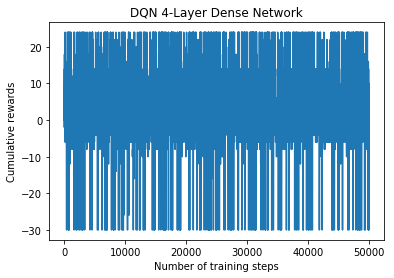

In [9]:
# Plotting rewards
plt.plot(train_summary['rewards'])
plt.xlabel("Number of training steps")
plt.ylabel("Cumulative rewards")
plt.title("DQN 4-Layer Dense Network")
plt.show()

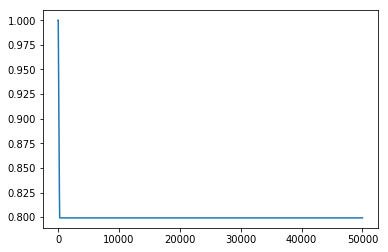

In [6]:
# Plotting epsilon
plt.plot(train_summary['epsilon'])
plt.show()